# Group 30
## Musical Instrument Recognition 
#### By: Haoyu He [2034205], Han Hu [2036014], Michelle Tsjin [2032877]

For this instrument recognition, the dataset used is IRMAS (Instrument Recognition in Musical Audio Signals) dataset.

The dataset can be downloaded here: https://www.upf.edu/web/mtg/irmas <br>
Only **IRMAS-TrainingData** is used.

Inspired by: <br>
1. Vineet Kumar https://github.com/vntkumar8/musical-instrument-classification [His code is used as a reference. The difference: the library he used is called "essentia". Our group is using "Librosa"] <br>
2. Librosa reference: https://www.youtube.com/watch?v=MhOdbtPhbLU


### Understanding Sound

How do we define a sound? <br>
A sound form of a vibration that travels through the air. Each sound has a frequency defined as the number of occurrences of a repeating event per unit of time and measured in Hertz (Hz) or inverse seconds. <br>
**Waveform** is a continuous time signal of a sound. <br>
**Sampling Rate** is the number of samples of audio recorded per second. This determine the maximum audio frequency that can be reproduced.


In [26]:
# pip install librosa
# This library is use for extracting the audio file

In [121]:
import librosa
import librosa.display
import numpy as np
import IPython
import os, fnmatch
import itertools

# Visualization
import seaborn
import matplotlib.pyplot as plt
from IPython.display import Audio
from IPython.core.display import HTML, display

# Sickit learn dependencies
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import SVC
from sklearn import tree
from scipy import signal
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')


# Audio Path
path='/Users/ellechim/Downloads/IRMAS-TrainingData'

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/3041975089.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/3041975089.py:24: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [109]:
example_audio = '/Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1297__2.wav'

In [110]:
#load the waveform y and sampling rate s
y, sr = librosa.load(example_audio, sr=None)
# sr=None, to disable resampling

In [111]:
print(type(y), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [112]:
print(y.shape, sr)

(132299,) 44100


In [113]:
Audio(example_audio)

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/3674113661.py:4: FutureWarning: Pass sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y, sr)


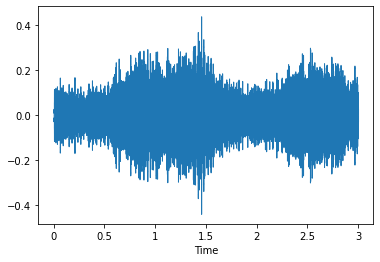

In [116]:
#Waveform
#y: audio time series
#sr: sampling per second
librosa.display.waveshow(y, sr)

The Mel Frequency Cepstral Coefficients (**MFCCs**) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope

In [106]:
mfccs = librosa.feature.mfcc(y, sr=fs)
print(mfccs.shape)

(20, 259)


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/73176314.py:1: FutureWarning: Pass y=[ 0.03  0.02  0.02 ... -0.03 -0.03 -0.03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(y, sr=fs)


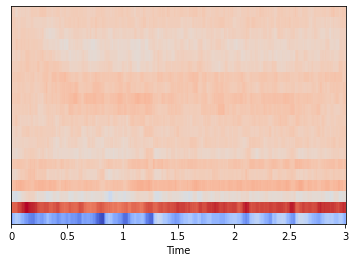

In [107]:
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

### Processing The Dataset

In [66]:
#Get filenames
#Total Audio Files in the directory
files = []
for root, dirnames, filenames in os.walk(path):
    for filename in fnmatch.filter(filenames, '*.wav'):
        files.append(os.path.join(root, filename))

print("found %d audio files in %s"%(len(files),path))

found 6705 audio files in /Users/ellechim/Downloads/IRMAS-TrainingData


In [20]:
labels =[]
classes=['flu','pia','tru','gac','org','voi']
color_dict={'flu':'blue', 'pia':'red', 'tru':'green', 'gac':'black','org': 'yellow', 'voi':'white'}
color_list=[]
for filename in files:
    for name in classes:
        if fnmatch.fnmatchcase(filename, '*'+name+'*'):
            labels.append(name)
            color_list.append(color_dict[name])
            break
    else:
        labels.append('other')

In [67]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

7 classes: flu, gac, org, other, pia, tru, voi


In [68]:
#Parameters for MFCC
# Parameters
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames
n_mels = 128       # Number of Mel bands
n_mfcc = 13        # Number of MFCCs

# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing
n_neighbors=1       # Number of neighbors for kNN Classifier

### Function to calculate audio features: MFCC

In [71]:
# Define Function to Calculate MFCC, Delta_MFCC and Delta2_MFCC
def get_features(y, sr=fs):
    S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc)
    feature_vector = np.mean(mfcc,1)
    #feature_vector = (feature_vector-np.mean(feature_vector))/np.std(feature_vector)
    return feature_vector

### Load audio files, calculate features and create feature vectors

In [74]:
# Load files and feature vectors

feature_vectors = []
sound_paths = []

for i,f in enumerate(files):
    print ("getting %d of total %d files = %s"%(i+1, len(files), f))
    try:
        y, sr = librosa.load(f, sr=fs)
        y/=y.max() #Normalize
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        feat = get_features(y, sr)
        feature_vectors.append(feat)
        sound_paths.append(f)
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))

print("Calculated %d feature vectors"%len(feature_vectors))

getting 1 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1346__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04883483  0.07972541  0.10814717 ... -0.07689528 -0.08375986
 -0.08917926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11614122 0.07774246 0.03908599 ... 0.31724077 0.31079805 0.2961945 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06575015 -0.06963538 -0.07160789 ... -0.13801554 -0.14488941
 -0.14907353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1291__1.wav
getting 3 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1490__3.wav
getting 4 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/027__[pia][nod][cla]1398__2.wav
getting 5 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1524__1.wav
getting 6 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/244__[pia][nod][cla]1384__1.wav
getting 7 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1370__2.wav
getting 8 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1459__1.wav
getting 9 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/057__[pia][nod][cla]1413__2.wav
getting 10 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/170__[pia][nod][cla]1403__2.wav
getting 11 of total 

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2634196   0.23256408  0.1999235  ... -0.21764632 -0.22695397
 -0.23332909] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19942057 -0.20943989 -0.21752776 ... -0.34126025 -0.3621439
 -0.38025108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01590748 -0.01132877 -0.00047203 ... -0.41194242 -0.43686572
 -0.44956338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 15 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1317__1.wav
getting 16 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1537__1.wav
getting 17 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1528__1.wav
getting 18 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/222__[pia][nod][pop_roc]1438__3.wav
getting 19 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1283__1.wav
getting 20 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1482__3.wav
getting 21 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/204__[pia][nod][cla]1401__1.wav
getting 22 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1298__2.wav
getting 23 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1362__2.wav
getting 24 of total 

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00293929  0.0004446   0.00669367 ...  0.05169688  0.05572297
  0.04132293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04845615 -0.04780134 -0.04699542 ...  0.13443813  0.15413287
  0.17382763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09622063 -0.09249234 -0.08452503 ... -0.7843463  -0.681716
 -0.55497956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 27 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1337__2.wav
getting 28 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/261__[pia][dru][jaz_blu]1427__1.wav
getting 29 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1298__3.wav
getting 30 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1499__1.wav
getting 31 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1463__1.wav
getting 32 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1482__2.wav
getting 33 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1500__1.wav
getting 34 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1333__1.wav
getting 35 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/222__[pia][nod][pop_roc]1438__2.wav
getting 36 of to

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.34249777 0.32121366 0.29442453 ... 0.2859109  0.27160415 0.24785559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06509113  0.04261973  0.04288778 ... -0.06732488 -0.06629735
 -0.06678878] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05431537 -0.05630599 -0.05602161 ... -0.1198635  -0.11318072
 -0.10521825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 37 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1295__3.wav
getting 38 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/170__[pia][nod][cla]1403__3.wav
getting 39 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/057__[pia][nod][cla]1413__3.wav
getting 40 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1370__3.wav
getting 41 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1471__1.wav
getting 42 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/027__[pia][nod][cla]1398__3.wav
getting 43 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1490__2.wav
getting 44 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1512__1.wav
getting 45 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1321__1.wav
getting 46 of 

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07957428 0.08128378 0.07951914 ... 0.11321275 0.11784493 0.1226977 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09702584 0.08552952 0.0771639  ... 0.02150427 0.02555878 0.02989556] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23307624  0.20961139  0.18834174 ... -0.05535449 -0.07190745
 -0.0906556 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 47 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1291__2.wav
getting 48 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1321__3.wav
getting 49 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/027__[pia][nod][cla]1398__1.wav
getting 50 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1512__3.wav
getting 51 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1524__2.wav
getting 52 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/244__[pia][nod][cla]1384__2.wav
getting 53 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1471__3.wav
getting 54 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/057__[pia][nod][cla]1413__1.wav
getting 55 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1370__1.wav
getting 56 of tota

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.36704186 -0.33514258 -0.30755883 ...  0.12710771  0.1275971
  0.12483872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04685793  0.01849229 -0.00700036 ...  0.01436491  0.03961478
  0.065593  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00491682 -0.00934197 -0.02212571 ... -0.25067607 -0.29001066
 -0.32655904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 57 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1295__1.wav
getting 58 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1446__2.wav
getting 59 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1317__2.wav
getting 60 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1546__2.wav
getting 61 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/170__[pia][nod][cla]1403__1.wav
getting 62 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1537__2.wav
getting 63 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1333__3.wav
getting 64 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1283__2.wav
getting 65 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1528__2.wav
getting 66 of total 6705 f

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04220964 -0.00728358 -0.0104866  ...  0.01110087  0.05897065
  0.03444342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11070944  0.10031632  0.08901943 ... -0.27745143 -0.26253954
 -0.2431089 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03239806 -0.03308555 -0.03953079 ...  0.00128905  0.00399605
  0.01224595] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 68 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1499__3.wav
getting 69 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1463__3.wav
getting 70 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1298__1.wav
getting 71 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1362__1.wav
getting 72 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1287__1.wav
getting 73 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1337__1.wav
getting 74 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/261__[pia][dru][jaz_blu]1427__2.wav
getting 75 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1463__2.wav
getting 76 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1499__2.wav
getting 77 of total 6705 files = /

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01402426 0.02966131 0.04200266 ... 0.1230629  0.1121941  0.09901129] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00955285 -0.00734356 -0.00379625 ...  0.1555839   0.16025142
  0.16460778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06680482 -0.0690744  -0.07006118 ... -0.02141307 -0.02022893
 -0.0190448 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 79 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1500__2.wav
getting 80 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/222__[pia][nod][pop_roc]1438__1.wav
getting 81 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1528__3.wav
getting 82 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1333__2.wav
getting 83 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1283__3.wav
getting 84 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1537__3.wav
getting 85 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1317__3.wav
getting 86 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1446__3.wav
getting 87 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1325__1.wav
getting 88 of total 6705 f

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15255556 -0.14980745 -0.14892155 ...  0.10901991  0.14821646
  0.13800149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01601942 0.04989212 0.0802589  ... 0.2527508  0.2494067  0.23700108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08954255 -0.09505786 -0.10111388 ... -0.03925598 -0.04379799
 -0.04963772] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 90 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/244__[pia][nod][cla]1384__3.wav
getting 91 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1524__3.wav
getting 92 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1490__1.wav
getting 93 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1512__2.wav
getting 94 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1291__3.wav
getting 95 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1321__2.wav
getting 96 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1346__1.wav
getting 97 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/112__[pia][nod][cla]1392__2.wav
getting 98 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1461__3.wav
getting 99 of total 6705

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18792973  0.18185696  0.17585947 ... -0.3263739  -0.38030112
 -0.40690088] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17031135 -0.16878568 -0.16336103 ... -0.00508561  0.03633384
  0.07571905] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03837858 0.04484938 0.05087393 ... 0.01599107 0.01859427 0.01963555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 100 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1534__2.wav
getting 101 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/004__[pia][nod][cla]1394__3.wav
getting 102 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1318__2.wav
getting 103 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/178__[pia][nod][cla]1379__3.wav
getting 104 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1331__3.wav
getting 105 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/212__[pia][nod][cla]1397__1.wav
getting 106 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/135__[pia][nod][cla]1396__2.wav
getting 107 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1502__3.wav
getting 108 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/219__[pia][nod][cla]1

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01313535 0.01941748 0.02227299 ... 0.03997716 0.04283267 0.04683038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.8394943   0.83116466  0.80942875 ... -0.11437232 -0.12883829
 -0.14061807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00911641 -0.00736325 -0.00666199 ... -0.05049088 -0.02173913
  0.00420757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 111 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1526__2.wav
getting 112 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1315__2.wav
getting 113 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1293__2.wav
getting 114 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1376__2.wav
getting 115 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1497__3.wav
getting 116 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/051__[pia][dru][jaz_blu]1431__3.wav
getting 117 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1314__2.wav
getting 118 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1289__1.wav
getting 119 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1510__3.wav
getting 120 of to

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26971644 0.28595138 0.30579406 ... 0.17692474 0.17952234 0.18161483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12255824  0.10136015  0.0531761  ...  0.00072348  0.01490378
 -0.04217913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22967725 -0.21078576 -0.18907072 ... -0.15393975 -0.17506202
 -0.18807232] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 121 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1510__2.wav
getting 122 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1314__3.wav
getting 123 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/051__[pia][dru][jaz_blu]1431__2.wav
getting 124 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1497__2.wav
getting 125 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1376__3.wav
getting 126 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/228__[pia][nod][pop_roc]1437__1.wav
getting 127 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1293__3.wav
getting 128 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1315__3.wav
getting 129 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1327__1.wav
getting 130

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0386396  -0.02822294 -0.01433405 ...  0.1701389   0.1886574
  0.20584045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14809409 -0.15849747 -0.1527201  ...  0.11589704  0.12630042
  0.16635141] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-3.6798260e-01 -3.5652813e-01 -3.4130654e-01 ... -1.8376160e-04
 -2.3123335e-02 -4.4317171e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.featu

getting 133 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1480__1.wav
getting 134 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/219__[pia][nod][cla]1393__3.wav
getting 135 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1502__2.wav
getting 136 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/135__[pia][nod][cla]1396__3.wav
getting 137 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1331__2.wav
getting 138 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/178__[pia][nod][cla]1379__2.wav
getting 139 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1318__3.wav
getting 140 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/004__[pia][nod][cla]1394__2.wav
getting 141 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1534__3

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18005235 0.18625155 0.19251963 ... 0.24114892 0.25967765 0.27627772] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12199754 -0.12114307 -0.11971898 ...  0.20497485  0.24522927
  0.28235072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00504854 0.00854369 0.01281553 ... 0.02834952 0.03067961 0.03029126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 144 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/162__[pia][dru][pop_roc]1436__2.wav
getting 145 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/112__[pia][nod][cla]1392__1.wav
getting 146 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1534__1.wav
getting 147 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1318__1.wav
getting 148 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/212__[pia][nod][cla]1397__2.wav
getting 149 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/135__[pia][nod][cla]1396__1.wav
getting 150 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1319__1.wav
getting 151 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/219__[pia][nod][cla]1393__1.wav
getting 152 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_b

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.38780084  0.28176865  0.3281896  ... -0.26925248 -0.2780703
 -0.31685767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05317324 -0.03580618 -0.01758148 ... -0.03023156 -0.03108919
 -0.03237564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01752639  0.00567616 -0.03435571 ...  0.00751842 -0.00990838
 -0.02793268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 154 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1315__1.wav
getting 155 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1293__1.wav
getting 156 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/228__[pia][nod][pop_roc]1437__3.wav
getting 157 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1376__1.wav
getting 158 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1314__1.wav
getting 159 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1492__3.wav
getting 160 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1289__2.wav
getting 161 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1289__3.wav
getting 162 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1492__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00196651  0.00154937  0.00333711 ... -0.01156069  0.00935582
  0.03009356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01669696  0.00170508  0.01947979 ...  0.08552769  0.08160278
  0.07682533] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08149447 -0.0766212  -0.07444995 ...  0.09416817  0.08686631
  0.07404786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 163 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1510__1.wav
getting 164 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/051__[pia][dru][jaz_blu]1431__1.wav
getting 165 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1497__1.wav
getting 166 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/228__[pia][nod][pop_roc]1437__2.wav
getting 167 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1327__2.wav
getting 168 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1473__1.wav
getting 169 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1480__2.wav
getting 170 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1502__1.wav
getting 171 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1353__1.wav
getting

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03194277  0.00725514 -0.01360339 ... -0.01088271 -0.00110842
  0.00947199] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02459461 -0.00638978  0.0132618  ...  0.01645669  0.01476882
  0.01271927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08050942 0.07607973 0.06982281 ... 0.10885936 0.10390365 0.10251938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 173 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1331__1.wav
getting 174 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/178__[pia][nod][cla]1379__1.wav
getting 175 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/004__[pia][nod][cla]1394__1.wav
getting 176 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/162__[pia][dru][pop_roc]1436__3.wav
getting 177 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1461__1.wav
getting 178 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1352__1.wav
getting 179 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1335__2.wav
getting 180 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1357__2.wav
getting 181 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/055__[pia][dru][cou_fol]142

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0742611  -0.05426011 -0.03247685 ...  0.01009951  0.01222833
  0.01401059] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11746977 0.10961047 0.10505132 ... 0.05930716 0.03294418 0.00658121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03489539 -0.03421021 -0.08099841 ... -0.22569436 -0.20719442
 -0.20075859] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 183 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1506__2.wav
getting 184 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1530__3.wav
getting 185 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1465__2.wav
getting 186 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1303__3.wav
getting 187 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1518__2.wav
getting 188 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1469__2.wav
getting 189 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1297__3.wav
getting 190 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1514__2.wav
getting 191 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1373__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16001655 -0.14990838 -0.13672636 ...  0.00809836  0.00591121
  0.01477803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21785085 -0.21667646 -0.21432766 ... -0.22850432 -0.24754634
 -0.26507843] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04102743  0.03422827  0.03573919 ... -0.04294514 -0.04922129
 -0.05381218] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 192 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1522__3.wav
getting 193 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1477__2.wav
getting 194 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1344__2.wav
getting 195 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1488__1.wav
getting 196 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1311__3.wav
getting 197 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1323__1.wav
getting 198 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1311__2.wav
getting 199 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1344__3.wav
getting 200 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1477__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15551306  0.15232632  0.15168898 ... -0.6050988  -0.5646909
 -0.52746975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2737166  -0.23411404 -0.2181216  ... -0.03818311 -0.03340431
 -0.03129879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04858038 -0.05294099 -0.05814141 ... -0.02030104 -0.02845699
 -0.04152266] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 201 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1522__2.wav
getting 202 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1373__2.wav
getting 203 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1514__3.wav
getting 204 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1297__2.wav
getting 205 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1444__1.wav
getting 206 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1469__3.wav
getting 207 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/218__[pia][nod][cla]1417__1.wav
getting 208 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1518__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03264656  0.03524411  0.03778263 ... -0.01050829 -0.01582148
 -0.02225633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14683153 -0.18520753 -0.2133675  ... -0.12040562 -0.11301693
 -0.10675915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0985896   0.09762168  0.09582411 ... -0.27392146 -0.27488938
 -0.27226216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 209 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1281__1.wav
getting 210 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1303__2.wav
getting 211 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1364__1.wav
getting 212 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1465__3.wav
getting 213 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1448__1.wav
getting 214 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1530__2.wav
getting 215 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1506__3.wav
getting 216 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/055__[pia][dru][cou_fol]1420__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08267223 -0.08465553 -0.08517745 ...  0.0308977   0.01576201
  0.00083507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25351128 -0.2587724  -0.2644836  ... -0.03541553 -0.01292776
  0.01404516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3932     -0.41380602 -0.42991617 ... -0.16882874 -0.17660283
 -0.18325295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 217 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1357__3.wav
getting 218 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1335__3.wav
getting 219 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1307__1.wav
getting 220 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1456__1.wav
getting 221 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1352__2.wav
getting 222 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1456__3.wav
getting 223 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1307__3.wav
getting 224 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1335__1.wav
getting 225 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1484__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11989655 -0.11802575 -0.11643007 ...  0.0165071   0.0206889
  0.02520084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2646615  -0.28665373 -0.30659768 ... -0.11060802 -0.10737387
 -0.10413972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2011912  0.16596003 0.13305068 ... 0.09711286 0.11175045 0.12573189] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 226 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1506__1.wav
getting 227 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/055__[pia][dru][cou_fol]1420__1.wav
getting 228 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1357__1.wav
getting 229 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1448__3.wav
getting 230 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1465__1.wav
getting 231 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1364__3.wav
getting 232 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1518__1.wav
getting 233 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1281__3.wav
getting 234 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/218__[pia][nod][cla]1417__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.40437615  0.38870382  0.38057742 ... -0.01155865 -0.03364123
 -0.09370583] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23476623  0.25072014  0.2674496  ... -0.01839131 -0.02415245
 -0.029692  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15779987 -0.16210245 -0.15942787 ... -0.21210535 -0.19262747
 -0.16553289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 235 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1469__1.wav
getting 236 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1514__1.wav
getting 237 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1477__1.wav
getting 238 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1344__1.wav
getting 239 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1323__2.wav
getting 240 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1488__2.wav
getting 241 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1488__3.wav
getting 242 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1323__3.wav
getting 243 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1311__1.wav
getting 244 of total 6705 f

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17365241 -0.16543388 -0.14875513 ... -0.01658206  0.02291516
  0.06038192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03627907  0.04136799  0.04859097 ... -0.01165527 -0.03726402
 -0.05980848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3606952   0.34340906  0.30704197 ... -0.07037264 -0.06659425
 -0.05634535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 245 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1522__1.wav
getting 246 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1297__1.wav
getting 247 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1444__2.wav
getting 248 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/218__[pia][nod][cla]1417__2.wav
getting 249 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1281__2.wav
getting 250 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1303__1.wav
getting 251 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1364__2.wav
getting 252 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1530__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20216078 -0.16650803 -0.12375563 ... -0.32259807 -0.3779807
 -0.43254018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17160347 -0.2164297  -0.2636256  ... -0.16340837 -0.19006714
 -0.21346761] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14213097  0.14970598  0.15419117 ... -0.0203329  -0.02910396
 -0.03737666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 253 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1448__2.wav
getting 254 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1484__3.wav
getting 255 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1307__2.wav
getting 256 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1456__2.wav
getting 257 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1352__3.wav
getting 258 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1475__1.wav
getting 259 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/093__[pia][dru][jaz_blu]1428__1.wav
getting 260 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1458__3.wav
getting 261 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1359__1.wav
getting 262 of total 6705 fil

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2616271  -0.25250378 -0.23782411 ... -0.06701879 -0.08114967
 -0.09610372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.27930278 0.25065234 0.22148001 ... 0.37830082 0.38584176 0.3924434 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06244767 -0.05281887 -0.04472509 ... -0.17080659 -0.1991348
 -0.2320681 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 263 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1508__1.wav
getting 264 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1374__3.wav
getting 265 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/161__[pia][nod][pop_roc]1441__2.wav
getting 266 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/137__[pia][nod][cla]1381__1.wav
getting 267 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1494__2.wav
getting 268 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1516__1.wav
getting 269 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1467__1.wav
getting 270 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1336__1.wav
getting 271 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/084__[pia][nod][cla]1410__3.wav
g

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3778427   0.37564394  0.3675713  ... -0.23127906 -0.2171127
 -0.2039201 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03316251 -0.04248366 -0.05087641 ... -0.01466875 -0.01489156
 -0.01474302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07638413  0.06876856  0.05681212 ... -0.72454494 -0.72743887
 -0.73558754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 273 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1305__3.wav
getting 274 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/125__[pia][nod][cla]1378__1.wav
getting 275 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1479__1.wav
getting 276 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1350__2.wav
getting 277 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1328__1.wav
getting 278 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1486__2.wav
getting 279 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1504__1.wav
getting 280 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/220__[pia][nod][cla]1416__1.wav
getting 281 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1486__3.wav
getting 282 of 

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00980392 0.00574497 0.00271637 ... 0.00549519 0.00321594 0.00049956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17910695  0.18280044  0.18555678 ... -0.10859978 -0.07828005
 -0.05793826] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10975263 -0.10719363 -0.1034973  ... -0.0924083  -0.08330964
 -0.07591698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 283 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1305__2.wav
getting 284 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1450__1.wav
getting 285 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1562__3.wav
getting 286 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1532__1.wav
getting 287 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/084__[pia][nod][cla]1410__2.wav
getting 288 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1363__1.wav
getting 289 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1494__3.wav
getting 290 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/161__[pia][nod][pop_roc]1441__3.wav
getting 291 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1374__2.wav
getting 292 of 

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02374531  0.03553002  0.04795966 ... -0.0619137  -0.13121483
 -0.19383208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09133941 -0.08561244 -0.07848293 ...  0.2054114   0.23352034
  0.24894811] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16245791 0.15404041 0.1456229  ... 0.11742424 0.10479798 0.09259259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 293 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/196__[pia][nod][pop_roc]1439__1.wav
getting 294 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1458__2.wav
getting 295 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1371__1.wav
getting 296 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/056__[pia][nod][cla]1385__1.wav
getting 297 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1520__1.wav
getting 298 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/131__[pia][nod][cla]1402__1.wav
getting 299 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/093__[pia][dru][jaz_blu]1428__2.wav
getting 300 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1475__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02180039 0.02227894 0.02302334 ... 0.10629021 0.12171    0.134099  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06852917 0.05998357 0.05012326 ... 0.08233361 0.06721446 0.04963024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06439666 0.06540151 0.06844477 ... 0.15546496 0.17002095 0.17923689] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 301 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/056__[pia][nod][cla]1385__3.wav
getting 302 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/196__[pia][nod][pop_roc]1439__3.wav
getting 303 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/131__[pia][nod][cla]1402__3.wav
getting 304 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1520__3.wav
getting 305 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1508__2.wav
getting 306 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1359__2.wav
getting 307 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/137__[pia][nod][cla]1381__2.wav
getting 308 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/161__[pia][nod][pop_roc]1441__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06695435 -0.08546134 -0.09222351 ... -0.0114334  -0.00974286
 -0.01187828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.23255207 0.24695769 0.26191515 ... 0.1714153  0.18175481 0.18901572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1523678  0.15534084 0.15703972 ... 0.60506475 0.58903164 0.55542576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 309 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1494__1.wav
getting 310 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1516__2.wav
getting 311 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1467__2.wav
getting 312 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1336__2.wav
getting 313 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1532__3.wav
getting 314 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1363__3.wav
getting 315 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1562__1.wav
getting 316 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/125__[pia][nod][cla]1378__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30249298 -0.32202402 -0.3289049  ... -0.32916954 -0.31360823
 -0.29820567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22108538 -0.24657884 -0.27147546 ... -0.4373108  -0.4388882
 -0.43424138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09544574 -0.09435562 -0.09181201 ...  0.18132268  0.16242732
  0.14474322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 317 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1479__2.wav
getting 318 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1350__1.wav
getting 319 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1328__2.wav
getting 320 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1300__3.wav
getting 321 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/220__[pia][nod][cla]1416__3.wav
getting 322 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1486__1.wav
getting 323 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1504__2.wav
getting 324 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1504__3.wav
getting 325 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/220__[pia][nod][cla]1416__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1561993  -0.14971031 -0.14067207 ...  0.08667439  0.09038239
  0.09362689] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06171266  0.06628674  0.06981104 ... -0.08803239 -0.09414367
 -0.09744301] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02438392 -0.03184176 -0.03936446 ... -0.09059663 -0.10719845
 -0.12133592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 326 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1300__2.wav
getting 327 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1328__3.wav
getting 328 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1479__3.wav
getting 329 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/125__[pia][nod][cla]1378__3.wav
getting 330 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1305__1.wav
getting 331 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1450__2.wav
getting 332 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1363__2.wav
getting 333 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/084__[pia][nod][cla]1410__1.wav
getting 334 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1532__2.wav
getting 335

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1138319   0.10589014  0.10059563 ... -0.20648578 -0.23560555
 -0.26340172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4884079  -0.48976636 -0.49402282 ...  0.10740808  0.12343778
  0.13955805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06445443 -0.06378502 -0.06034235 ... -0.03284881 -0.03318352
 -0.03686526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 336 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1516__3.wav
getting 337 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/137__[pia][nod][cla]1381__3.wav
getting 338 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1374__1.wav
getting 339 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/215__[pia][dru][jaz_blu]1432__1.wav
getting 340 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1359__3.wav
getting 341 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1508__3.wav
getting 342 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/131__[pia][nod][cla]1402__2.wav
getting 343 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1520__2.wav
getting 344 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/056__[pia][nod][cla]1385__2

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04601668  0.04644809  0.0447704  ...  0.01850254  0.0091554
 -0.00143802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2528843  -0.21503052 -0.20355171 ...  0.17691387  0.1817332
  0.18658178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08223863 -0.08130587 -0.08029538 ...  0.0433735   0.03933152
  0.0346677 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 346 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1458__1.wav
getting 347 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1371__2.wav
getting 348 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1475__3.wav
getting 349 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/093__[pia][dru][jaz_blu]1428__3.wav
getting 350 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1332__2.wav
getting 351 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1529__3.wav
getting 352 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/160__[pia][nod][jaz_blu]1433__3.wav
getting 353 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1536__3.wav
getting 354 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1355__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09326076 -0.11588906 -0.13823225 ... -0.17081389 -0.18151893
 -0.18027475] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01113839 -0.02095775 -0.03147327 ...  0.1913311   0.16645293
  0.13567582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01552869  0.01318753  0.01286155 ... -0.14482574 -0.16026554
 -0.17822428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 355 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1483__1.wav
getting 356 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1501__2.wav
getting 357 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1498__2.wav
getting 358 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1462__2.wav
getting 359 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1366__3.wav
getting 360 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/152__[pia][dru][pop_roc]1440__1.wav
getting 361 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/254__[pia][nod][cla]1406__3.wav
getting 362 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1351__2.wav
getting 363 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1320__2.wav
getting

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30710056  0.22742245  0.18180871 ... -0.12012175 -0.1167028
 -0.11543112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08630838 -0.08134783 -0.08021693 ... -0.0277842  -0.03845067
 -0.0510962 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18391286 0.20402178 0.22329284 ... 0.61918724 0.5915375  0.5643067 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 365 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1491__1.wav
getting 366 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1513__2.wav
getting 367 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1470__2.wav
getting 368 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1525__3.wav
getting 369 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/001__[pia][nod][cla]1389__1.wav
getting 370 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1316__3.wav
getting 371 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1324__1.wav
getting 372 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1343__2.wav
getting 373 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/042__[pia][nod][cla]1409__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30375698  0.30508927  0.3042899  ... -0.17372769 -0.20410338
 -0.23141487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2855966  -0.29753938 -0.27311334 ... -0.29352415 -0.24745187
 -0.16408421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.62042975 -0.5806607  -0.5396087  ... -0.36353433 -0.35952532
 -0.35230917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 374 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1343__3.wav
getting 375 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/185__[pia][dru][pop_roc]1442__1.wav
getting 376 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1316__2.wav
getting 377 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1525__2.wav
getting 378 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/199__[pia][nod][cla]1383__1.wav
getting 379 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1470__3.wav
getting 380 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1513__3.wav
getting 381 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/067__[pia][nod][cla]1388__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2643255  0.27186996 0.27779773 ... 0.36020297 0.3525238  0.33545896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06882934  0.05416079  0.04203103 ... -0.01495063 -0.01382228
 -0.01071932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21154188  0.19217536  0.16624694 ... -0.06441315 -0.08140319
 -0.10059234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 382 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/187__[pia][nod][cla]1404__1.wav
getting 383 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/144__[pia][nod][cla]1380__1.wav
getting 384 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1312__1.wav
getting 385 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1320__3.wav
getting 386 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1351__3.wav
getting 387 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1286__1.wav
getting 388 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/124__[pia][nod][jaz_blu]1426__1.wav
getting 389 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/254__[pia][nod][cla]1406__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02189661 0.02110635 0.01567336 ... 0.13261442 0.13328943 0.13478762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03644785  0.02716813  0.02253646 ... -0.11818137 -0.1048428
 -0.0898676 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08188254  0.05324915  0.01779223 ... -0.03960207 -0.00950195
  0.02015178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 390 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1366__2.wav
getting 391 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1462__3.wav
getting 392 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1498__3.wav
getting 393 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1501__3.wav
getting 394 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1536__2.wav
getting 395 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/160__[pia][nod][jaz_blu]1433__2.wav
getting 396 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1529__2.wav
getting 397 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/107__[pia][nod][cla]1412__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36179844  0.34619612  0.33129698 ... -0.06821079 -0.05445436
 -0.06895794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02842078  0.02263374  0.01916152 ... -0.0153035  -0.01350309
 -0.01234568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06728473  0.07508077  0.08175305 ... -0.28132463 -0.26836634
 -0.25287962] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 398 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1332__3.wav
getting 399 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/107__[pia][nod][cla]1412__3.wav
getting 400 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1332__1.wav
getting 401 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1355__2.wav
getting 402 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1483__2.wav
getting 403 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1501__1.wav
getting 404 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1462__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2295762   0.21298467  0.20604149 ... -0.18881875 -0.19864742
 -0.21577998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2419087  -0.26007953 -0.27633765 ... -0.09790104 -0.10524991
 -0.11415916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17664735  0.17878497  0.21298677 ... -0.21236718 -0.19848818
 -0.18817188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 405 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1498__1.wav
getting 406 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/152__[pia][dru][pop_roc]1440__2.wav
getting 407 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1286__3.wav
getting 408 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/124__[pia][nod][jaz_blu]1426__3.wav
getting 409 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1351__1.wav
getting 410 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1320__1.wav
getting 411 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1312__3.wav
getting 412 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/144__[pia][nod][cla]1380__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11070458 -0.12409171 -0.14079571 ...  0.05717314  0.07319325
  0.09052984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03859587 -0.03620876 -0.02706234 ...  0.21614695  0.22092117
  0.2267005 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24920128 -0.26369748 -0.27175623 ...  0.036622    0.03862477
  0.04015068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 413 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/187__[pia][nod][cla]1404__3.wav
getting 414 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1491__2.wav
getting 415 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1513__1.wav
getting 416 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/067__[pia][nod][cla]1388__1.wav
getting 417 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1470__1.wav
getting 418 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/199__[pia][nod][cla]1383__3.wav
getting 419 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/185__[pia][dru][pop_roc]1442__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09329082 -0.08217348 -0.07075451 ... -0.12957297 -0.13362348
 -0.1398285 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14618786 0.15623744 0.16508107 ... 0.03644647 0.05359775 0.07182098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02808862  0.04875476  0.05497155 ... -0.19385102 -0.17260088
 -0.14036773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 420 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1324__2.wav
getting 421 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/001__[pia][nod][cla]1389__2.wav
getting 422 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/042__[pia][nod][cla]1409__2.wav
getting 423 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1343__1.wav
getting 424 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/042__[pia][nod][cla]1409__3.wav
getting 425 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1324__3.wav
getting 426 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1316__1.wav
getting 427 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/001__[pia][nod][cla]1389__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1635026  -0.16373992 -0.16468914 ...  0.03227337  0.0336972
  0.03559563] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25207654  0.25228682  0.2510777  ... -0.32704237 -0.3410262
 -0.35742825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.32617423 -0.27003077 -0.14578012 ... -0.02872335 -0.01592556
  0.02265026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 428 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/185__[pia][dru][pop_roc]1442__2.wav
getting 429 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1525__1.wav
getting 430 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/199__[pia][nod][cla]1383__2.wav
getting 431 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1491__3.wav
getting 432 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/187__[pia][nod][cla]1404__2.wav
getting 433 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/144__[pia][nod][cla]1380__2.wav
getting 434 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1312__2.wav
getting 435 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/124__[pia][nod][jaz_blu]1426__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09156845 0.09640375 0.09882139 ... 0.15593836 0.1435479  0.13145965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11037169 -0.10075914 -0.08902691 ... -0.1021887  -0.10174505
 -0.09908311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-2.0966148e-02 -9.7871963e-03  2.6937237e-04 ... -3.5400018e-01
 -3.8798600e-01 -4.1213971e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.mel

getting 436 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1286__2.wav
getting 437 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/152__[pia][dru][pop_roc]1440__3.wav
getting 438 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1366__1.wav
getting 439 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/254__[pia][nod][cla]1406__1.wav
getting 440 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1483__3.wav
getting 441 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1536__1.wav
getting 442 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/160__[pia][nod][jaz_blu]1433__1.wav
getting 443 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1355__3.wav
getting 444 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1529__1.w

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25888044 -0.2739461  -0.2870767  ...  0.01451278  0.01935038
  0.02404976] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00052602 0.00179956 0.00753045 ... 0.24695459 0.24291252 0.23803987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05092878  0.071411    0.0909706  ... -0.17099275 -0.15770698
 -0.14177635] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 445 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/107__[pia][nod][cla]1412__2.wav
getting 446 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/182__[pia][dru][cou_fol]1421__2.wav
getting 447 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1472__1.wav
getting 448 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/024__[pia][nod][cla]1414__1.wav
getting 449 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1296__3.wav
getting 450 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1496__1.wav
getting 451 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/031__[pia][nod][cla]1444__1.wav
getting 452 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1493__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15827653 -0.16867821 -0.17372271 ... -0.0635149  -0.06095095
 -0.04994476] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10680146 -0.11060508 -0.1143086  ... -0.02717582 -0.0245233
 -0.02132025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00486747  0.01999894  0.03327866 ... -0.07100154 -0.07914925
 -0.08703243] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 453 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1511__1.wav
getting 454 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/002__[pia][nod][cla]1382__2.wav
getting 455 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1288__3.wav
getting 456 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1340__1.wav
getting 457 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1338__2.wav
getting 458 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/063__[pia][nod][cla]1418__1.wav
getting 459 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1460__1.wav
getting 460 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1361__3.wav
getting 461 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1453__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1059801   0.11477152  0.12617138 ... -0.10694619 -0.08192445
 -0.05342479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06730038 -0.03219265 -0.00209125 ...  0.0026616   0.03022814
  0.06032953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00871107  0.00698972  0.00766783 ... -0.11992072 -0.13499556
 -0.15137447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 462 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1330__1.wav
getting 463 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/134__[pia][nod][cla]1405__3.wav
getting 464 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/155__[pia][nod][cla]1415__2.wav
getting 465 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1481__2.wav
getting 466 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1503__1.wav
getting 467 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1481__3.wav
getting 468 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/155__[pia][nod][cla]1415__3.wav
getting 469 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1453__2.wav
getting 470 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/134__[pia][nod][cla]1405__2.wav

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.24507205 0.20288184 0.15066282 ... 0.963804   0.96207494 0.94835734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1495334   0.13828336  0.12825052 ... -0.25543138 -0.28147247
 -0.2958209 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2684669   0.26480836  0.2510453  ... -0.57334495 -0.58536583
 -0.59250873] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 471 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1306__1.wav
getting 472 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1361__2.wav
getting 473 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1288__2.wav
getting 474 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1338__3.wav
getting 475 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/002__[pia][nod][cla]1382__3.wav
getting 476 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1493__3.wav
getting 477 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1292__1.wav
getting 478 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1377__1.wav
getting 479 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1296__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08952072 -0.08968318 -0.08952072 ... -0.07587327 -0.08480909
 -0.09212023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17840067  0.15622424  0.1370981  ... -0.11962078 -0.13511954
 -0.14863974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17736313  0.16970815  0.16007107 ... -0.23094799 -0.22103752
 -0.20552252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 480 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1445__1.wav
getting 481 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1527__1.wav
getting 482 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/108__[pia][nod][cla]1386__1.wav
getting 483 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1527__3.wav
getting 484 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/108__[pia][nod][cla]1386__3.wav
getting 485 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1472__2.wav
getting 486 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/182__[pia][dru][cou_fol]1421__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17915457 -0.18279806 -0.17657378 ... -0.01840294 -0.04997976
 -0.08703866] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11547938 0.1282271  0.14043921 ... 0.02913765 0.02420996 0.02024638] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02487536 -0.02412883 -0.02418215 ...  0.15575759  0.18655184
  0.21132055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 487 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/024__[pia][nod][cla]1414__2.wav
getting 488 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1445__3.wav
getting 489 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1377__3.wav
getting 490 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1496__2.wav
getting 491 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1340__2.wav
getting 492 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1338__1.wav
getting 493 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1493__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02903817 -0.03402257 -0.03965013 ... -0.41926873 -0.35170594
 -0.28327492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10104061 -0.10284608 -0.10104061 ... -0.14496274 -0.06923153
 -0.04582608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08384289  0.03295678 -0.01989844 ...  0.00860193  0.01668567
  0.02518396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 494 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1511__2.wav
getting 495 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/002__[pia][nod][cla]1382__1.wav
getting 496 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/031__[pia][nod][cla]1444__2.wav
getting 497 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1460__2.wav
getting 498 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/063__[pia][nod][cla]1418__2.wav
getting 499 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1306__3.wav
getting 500 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1330__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.078125    0.03913909 -0.03251379 ...  0.03105852  0.03190104
  0.03259038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00566876  0.01700628  0.03286349 ...  0.22698024  0.22054543
  0.21349777] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0196997   0.00439467 -0.05018769 ... -0.1690115  -0.1635487
 -0.14986114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 501 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1481__1.wav
getting 502 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1503__2.wav
getting 503 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/155__[pia][nod][cla]1415__1.wav
getting 504 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1503__3.wav
getting 505 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/134__[pia][nod][cla]1405__1.wav
getting 506 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1453__1.wav
getting 507 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1306__2.wav
getting 508 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1361__1.wav
getting 509 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1460__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25195068  0.24968538  0.24590988 ... -0.1444752  -0.14925748
 -0.15630506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10126392 -0.09840506 -0.09968402 ... -0.08659344 -0.08486307
 -0.08358411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18255362 -0.174792   -0.11817988 ... -0.10680822 -0.08408132
 -0.05182061] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 510 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/063__[pia][nod][cla]1418__3.wav
getting 511 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1511__3.wav
getting 512 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1340__3.wav
getting 513 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1288__1.wav
getting 514 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1292__2.wav
getting 515 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1496__3.wav
getting 516 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1377__2.wav
getting 517 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1296__1.wav
getting 518 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1445__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1353067  0.10115228 0.06858484 ... 0.23763196 0.17808597 0.11653902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01691775 0.0358978  0.05554196 ... 0.13139223 0.12545003 0.12069628] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4288491  0.42676663 0.41566014 ... 0.1995002  0.28682494 0.3537415 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 519 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/024__[pia][nod][cla]1414__3.wav
getting 520 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1472__3.wav
getting 521 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/108__[pia][nod][cla]1386__2.wav
getting 522 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1527__2.wav
getting 523 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/157__[pia][nod][cla]1400__2.wav
getting 524 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1341__3.wav
getting 525 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/086__[pia][dru][jaz_blu]1424__1.wav
getting 526 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/118__[pia][dru][jaz_blu]1429__1.wav
getting 527 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27748716 -0.278124   -0.27826047 ... -0.18204977 -0.18659873
 -0.18614385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.27701414 0.2742884  0.2688369  ... 0.04513064 0.04524746 0.04536428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15554209 0.1677331  0.17451337 ... 0.06396354 0.05949575 0.06183067] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 529 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/072__[pia][nod][cla]1395__1.wav
getting 530 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1523__1.wav
getting 531 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1372__1.wav
getting 532 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1322__3.wav
getting 533 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1310__1.wav
getting 534 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1489__3.wav
getting 535 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1541__1.wav
getting 536 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/229__[pia][nod][jaz_blu]1434__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2975187   0.28041992  0.25974232 ... -0.27127406 -0.2634802
 -0.24972165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08533933 0.10104324 0.10952188 ... 0.06303683 0.04692741 0.03210823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04257476 -0.1591485  -0.27124515 ... -0.12552796 -0.11615138
 -0.10685927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 537 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/064__[pia][dru][jaz_blu]1430__2.wav
getting 538 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1284__1.wav
getting 539 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1457__2.wav
getting 540 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1452__1.wav
getting 541 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1485__3.wav
getting 542 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1360__1.wav
getting 543 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/231__[pia][nod][cla]1408__2.wav
getting 544 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1449__2.wav
getting 545 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1531__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01113017  0.00681888  0.00109982 ...  0.00316748 -0.00167173
 -0.00580705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18203658 -0.21758102 -0.24248664 ...  0.03627985  0.03726038
  0.03466196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.40386468  0.28643227  0.30577868 ... -0.09184376 -0.08507366
 -0.08046082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 546 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1302__1.wav
getting 547 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1365__2.wav
getting 548 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/153__[pia][dru][cou_fol]1419__1.wav
getting 549 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1365__3.wav
getting 550 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1348__1.wav
getting 551 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1519__1.wav
getting 552 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1449__3.wav
getting 553 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/231__[pia][nod][cla]1408__3.wav
getting 554 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1356__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0772128   0.05714906  0.03831667 ...  0.01187889  0.00412864
 -0.00507026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00938842  0.01136212  0.0126957  ... -0.00586776 -0.00586776
 -0.00466754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18073198 -0.16689725 -0.18966168 ...  0.19645327  0.22638662
  0.22852471] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 555 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1485__2.wav
getting 556 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1507__1.wav
getting 557 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1349__1.wav
getting 558 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1457__3.wav
getting 559 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1334__1.wav
getting 560 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1345__1.wav
getting 561 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/064__[pia][dru][jaz_blu]1430__3.wav
getting 562 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1489__2.wav
getting 563 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1322__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23540248 -0.2506256  -0.27161825 ...  0.10621437  0.12296677
  0.20728485] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10629688 -0.03659923  0.01059332 ... -0.07801773 -0.0855649
 -0.09252103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03199408  0.03565055  0.03995995 ... -0.07769991 -0.07778697
 -0.07726461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 564 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1476__1.wav
getting 565 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/239__[pia][nod][cla]1391__2.wav
getting 566 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1515__1.wav
getting 567 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/032__[pia][dru][jaz_blu]1425__1.wav
getting 568 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1369__3.wav
getting 569 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1339__1.wav
getting 570 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1341__2.wav
getting 571 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1468__1.wav
getting 572 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1326__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00601636  0.00759346  0.00975467 ... -0.27996495 -0.26068926
 -0.23294392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0044861  -0.0018158  -0.00603487 ... -0.04101578 -0.04272477
 -0.04464739] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 5.9801247e-03  2.9021194e-03  1.3191452e-04 ... -2.4333832e-01
 -2.6831412e-01 -2.9245448e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feat

getting 573 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/029__[pia][nod][cla]1411__1.wav
getting 574 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/157__[pia][nod][cla]1400__3.wav
getting 575 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1326__3.wav
getting 576 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/157__[pia][nod][cla]1400__1.wav
getting 577 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/029__[pia][nod][cla]1411__3.wav
getting 578 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1468__3.wav
getting 579 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1339__3.wav
getting 580 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1369__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02634745 0.02400144 0.0210539  ... 0.05064966 0.0504692  0.0504692 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04176715 -0.03704061 -0.03188    ...  0.00453362 -0.00231504
 -0.00993537] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02965678  0.03509941  0.04331889 ... -0.06586693 -0.07441964
 -0.08219483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 581 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/086__[pia][dru][jaz_blu]1424__2.wav
getting 582 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/118__[pia][dru][jaz_blu]1429__2.wav
getting 583 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1515__3.wav
getting 584 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/072__[pia][nod][cla]1395__2.wav
getting 585 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/032__[pia][dru][jaz_blu]1425__3.wav
getting 586 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1476__3.wav
getting 587 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1372__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10989688 -0.05952748  0.01360243 ...  0.17265661  0.16203633
  0.16280591] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.22849731  0.26441827  0.28580457 ... -0.17820795 -0.09252977
 -0.08501297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01647327 -0.01730211 -0.01823456 ... -0.03211769 -0.04050974
 -0.04869457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 588 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1523__2.wav
getting 589 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1541__2.wav
getting 590 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1310__2.wav
getting 591 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1345__3.wav
getting 592 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/064__[pia][dru][jaz_blu]1430__1.wav
getting 593 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/229__[pia][nod][jaz_blu]1434__2.wav
getting 594 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1334__3.wav
getting 595 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1284__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00402321  0.01015381  0.01346543 ... -0.0386447  -0.0160381
 -0.03256883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16168228 -0.12518719 -0.08706627 ...  0.14469688  0.18572712
  0.22042528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07237907 0.0799831  0.08931211 ... 0.12215729 0.08617897 0.06322608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 596 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1457__1.wav
getting 597 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1349__3.wav
getting 598 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1452__2.wav
getting 599 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1356__3.wav
getting 600 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1507__3.wav
getting 601 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1531__2.wav
getting 602 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1360__2.wav
getting 603 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1449__1.wav
getting 604 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/231__[pia][nod][cla]1408__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26361892 -0.27040896 -0.27440006 ...  0.08858135  0.05628984
  0.03768206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-2.3696177e-01 -2.4320620e-01 -2.5917625e-01 ...  9.3535826e-02
  4.9454972e-02  2.1757577e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04031731 0.03705086 0.03378442 ... 0.12309846 0.14811012 0.16864209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.mel

getting 605 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1348__3.wav
getting 606 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1302__2.wav
getting 607 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1519__3.wav
getting 608 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/153__[pia][dru][cou_fol]1419__2.wav
getting 609 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1365__1.wav
getting 610 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/153__[pia][dru][cou_fol]1419__3.wav
getting 611 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1519__2.wav
getting 612 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1348__2.wav
getting 613 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1302__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03264894  0.03907775  0.06647594 ...  0.15930663  0.17802086
  0.19878829] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11827061 -0.17424965 -0.19187708 ... -0.03049071 -0.06443544
 -0.11553121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17148247  0.13782676  0.09354134 ... -0.04880678 -0.0541366
 -0.05973591] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 614 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1360__3.wav
getting 615 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1531__3.wav
getting 616 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1485__1.wav
getting 617 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1507__2.wav
getting 618 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1356__2.wav
getting 619 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1349__2.wav
getting 620 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1452__3.wav
getting 621 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1334__2.wav
getting 622 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1284__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01362381 0.01349824 0.01839528 ... 0.13404068 0.15670517 0.19023104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07525249 0.07718885 0.07726479 ... 0.257119   0.26710457 0.27230617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16758747 -0.1495659  -0.12407919 ... -0.04173244 -0.04636938
 -0.04778348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 623 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/229__[pia][nod][jaz_blu]1434__3.wav
getting 624 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1345__2.wav
getting 625 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1310__3.wav
getting 626 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1322__1.wav
getting 627 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1541__3.wav
getting 628 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1489__1.wav
getting 629 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1523__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00864984  0.00146502 -0.00695105 ... -0.29817808 -0.35514238
 -0.35598397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18725 -0.17175 -0.1553  ...  0.0192   0.0187   0.0169 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24696058 -0.25764653 -0.25591886 ...  0.03711287  0.03362554
  0.02751472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n

getting 630 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1372__3.wav
getting 631 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1476__2.wav
getting 632 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/032__[pia][dru][jaz_blu]1425__2.wav
getting 633 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/072__[pia][nod][cla]1395__3.wav
getting 634 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/239__[pia][nod][cla]1391__1.wav
getting 635 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1515__2.wav
getting 636 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/118__[pia][dru][jaz_blu]1429__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16785099 -0.19390611 -0.22028424 ... -0.249354   -0.24741602
 -0.24418604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13423657 0.0566962  0.03621678 ... 0.25659198 0.24189682 0.23668577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11227311  0.12289137  0.13002364 ... -0.04443643 -0.03818568
 -0.03730416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 637 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/086__[pia][dru][jaz_blu]1424__3.wav
getting 638 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1339__2.wav
getting 639 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1341__1.wav
getting 640 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1468__2.wav
getting 641 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/029__[pia][nod][cla]1411__2.wav
getting 642 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1326__2.wav
getting 643 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1533__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29485214 -0.27601314 -0.25805038 ... -0.07141292 -0.04819277
 -0.0245345 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3101859  -0.31069797 -0.30857098 ...  0.15263116  0.13589098
  0.11962344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16559722 -0.12570545 -0.17634325 ... -0.0201005  -0.0610746
 -0.02342482] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 644 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1367__1.wav
getting 645 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1282__1.wav
getting 646 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/113__[pia][nod][cla]1407__1.wav
getting 647 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1478__3.wav
getting 648 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/104__[pia][nod][cla]1387__3.wav
getting 649 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1354__3.wav
getting 650 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1505__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19298245 -0.21052632 -0.22686026 ... -0.10798548 -0.10677556
 -0.10465819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11741019  0.08848151  0.04768465 ... -0.14432552 -0.13584825
 -0.11836389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04350457  0.04343733  0.047539   ... -0.21295051 -0.20716783
 -0.19419043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 651 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/224__[pia][dru][cou_fol]1422__3.wav
getting 652 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1301__2.wav
getting 653 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1308__1.wav
getting 654 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1521__2.wav
getting 655 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1474__3.wav
getting 656 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1375__1.wav
getting 657 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1509__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15912974 -0.16219476 -0.16445583 ... -0.21435031 -0.20761733
 -0.20003015] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20157643 -0.20422535 -0.20603438 ... -0.10091743 -0.07287763
 -0.04651764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05839895 0.04123763 0.02296588 ... 0.26509187 0.2830103  0.29335755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 658 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1290__1.wav
getting 659 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1443__2.wav
getting 660 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1358__3.wav
getting 661 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1294__2.wav
getting 662 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1447__1.wav
getting 663 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1517__3.wav
getting 664 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1313__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09623566 0.11183447 0.10835374 ... 0.15566584 0.15579477 0.15985562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0800484   0.06946766  0.06291245 ... -0.1675099  -0.14502859
 -0.1241531 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2799652  -0.26201922 -0.26210213 ... -0.12549734 -0.15156664
 -0.15508953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 665 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1313__3.wav
getting 666 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1495__1.wav
getting 667 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1517__2.wav
getting 668 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1294__3.wav
getting 669 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/101__[pia][nod][cla]1399__1.wav
getting 670 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1443__3.wav
getting 671 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/190__[pia][dru][jaz_blu]1435__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00668422 -0.00060766 -0.00749443 ... -0.02815475 -0.03038282
 -0.03321856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3611713  0.37643054 0.35734123 ... 0.16531877 0.19812617 0.24025697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.34946027 0.35299683 0.38157704 ... 0.17115246 0.13340187 0.10767966] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 672 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1358__2.wav
getting 673 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1509__2.wav
getting 674 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1474__2.wav
getting 675 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1521__3.wav
getting 676 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1301__3.wav
getting 677 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/224__[pia][dru][cou_fol]1422__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07205416 -0.04869911 -0.01575182 ...  0.2693529   0.21128613
  0.1429213 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36333892  0.38221478  0.38499427 ... -0.24865863 -0.24380332
 -0.25122702] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1256535  0.11515207 0.10333227 ... 0.08655725 0.07585125 0.05962177] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 678 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1487__1.wav
getting 679 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1505__2.wav
getting 680 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1354__2.wav
getting 681 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/104__[pia][nod][cla]1387__2.wav
getting 682 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1478__2.wav
getting 683 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1329__2.wav
getting 684 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1533__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21810824 -0.21847612 -0.21449438 ...  0.14548483  0.15057021
  0.1578845 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11515064 -0.12007532 -0.12239282 ...  0.1712051   0.16475956
  0.1595452 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02312046  0.01458981  0.02359882 ...  0.07486247 -0.05979431
  0.13983895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 685 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1533__1.wav
getting 686 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1367__2.wav
getting 687 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1282__2.wav
getting 688 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/113__[pia][nod][cla]1407__2.wav
getting 689 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1487__3.wav
getting 690 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1301__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25632292  0.2750575   0.29660222 ... -0.12892787 -0.11602657
 -0.10261432] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07873309 0.07264218 0.06706418 ... 0.04270052 0.03808425 0.03391678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10390829  0.12583628  0.122601   ... -0.08435684 -0.07521019
 -0.06574401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 691 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1521__1.wav
getting 692 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1308__2.wav
getting 693 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1375__2.wav
getting 694 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/190__[pia][dru][jaz_blu]1435__3.wav
getting 695 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1290__2.wav
getting 696 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1443__1.wav
getting 697 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/101__[pia][nod][cla]1399__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02384652 -0.04166799 -0.05733312 ... -0.04328524 -0.03849691
 -0.03386713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21677297 0.2097995  0.21117282 ... 0.01443525 0.02365185 0.07594531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19574781 -0.19257087 -0.1886608  ...  0.21554253  0.21969697
  0.22678398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 698 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1294__1.wav
getting 699 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1447__2.wav
getting 700 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1495__3.wav
getting 701 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1313__1.wav
getting 702 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1495__2.wav
getting 703 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1517__1.wav
getting 704 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1447__3.wav
getting 705 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/101__[pia][nod][cla]1399__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.37722996 0.25780955 0.0790365  ... 0.30722618 0.28227323 0.23835152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2576064  -0.24750303 -0.23099129 ... -0.16032562 -0.17025577
 -0.17858861] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.42598733 -0.4356346  -0.43985528 ... -0.20721535 -0.20450206
 -0.20068336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 706 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1509__1.wav
getting 707 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/190__[pia][dru][jaz_blu]1435__2.wav
getting 708 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1358__1.wav
getting 709 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1375__3.wav
getting 710 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1474__1.wav
getting 711 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1308__3.wav
getting 712 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/224__[pia][dru][cou_fol]1422__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01128391 -0.01525959 -0.01853368 ...  0.33576941  0.30437323
  0.27098924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0833265  -0.07525604 -0.06341663 ...  0.04891438  0.05337976
  0.05911512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10939297 -0.11603834 -0.12089457 ... -0.14619808 -0.15003195
 -0.15194888] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 713 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1354__1.wav
getting 714 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1487__2.wav
getting 715 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1505__1.wav
getting 716 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1478__1.wav
getting 717 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][jaz_blu]1329__1.wav
getting 718 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/104__[pia][nod][cla]1387__1.wav
getting 719 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/113__[pia][nod][cla]1407__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14456576  0.11067171  0.08408889 ... -0.02253173 -0.03439562
 -0.05445812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06632925 -0.10104777 -0.13487835 ... -0.26966792 -0.27943528
 -0.2849405 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02043929 0.01281269 0.0076266  ... 0.07870653 0.07596095 0.07504576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 720 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][pop_roc]1282__3.wav
getting 721 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/pia/[pia][cla]1367__3.wav
getting 722 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/184__[voi][dru][pop_roc]2303__3.wav
getting 723 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/135__[voi][dru][pop_roc]2292__2.wav
getting 724 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2509__1.wav
getting 725 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/027__[voi][dru][cou_fol]2378__3.wav
getting 726 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/197__[voi][dru][cou_fol]2425__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08870619  0.01386227  0.04732027 ... -0.1390709  -0.11483897
 -0.09491871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.37987128  0.3568364   0.36408907 ... -0.3051739  -0.30356506
 -0.28150058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.29887798  0.3337396   0.33900917 ... -0.40003943 -0.4236808
 -0.4476269 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 727 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/011__[voi][dru][pop_roc]2294__2.wav
getting 728 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/181__[voi][nod][cou_fol]2434__1.wav
getting 729 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2495__2.wav
getting 730 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2517__1.wav
getting 731 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/127__[voi][dru][pop_roc]2477__1.wav
getting 732 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/214__[voi][nod][cou_fol]2372__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00299995 -0.00941524 -0.01629206 ... -0.24918078 -0.22356579
 -0.19287395] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17750105 0.14069104 0.14120722 ... 0.12772204 0.11410782 0.10639739] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15919887 -0.15735011 -0.1613044  ...  0.2130954   0.17201181
  0.13190396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 733 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2486__2.wav
getting 734 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2499__2.wav
getting 735 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/079__[voi][dru][lat_sou]2289__3.wav
getting 736 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/264__[voi][nod][cou_fol]2435__1.wav
getting 737 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2337__1.wav
getting 738 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2354__1.wav
getting 739 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2505__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10308718 -0.11523833 -0.13917017 ...  0.14788836  0.15218572
  0.13998519] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.62300414  0.5798755   0.5511616  ... -0.10501461  0.09631293
  0.1700213 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11610018 0.09645796 0.08908766 ... 0.04028622 0.04132379 0.04078712] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 740 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/112__[voi][dru][cou_fol]2427__3.wav
getting 741 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/051__[voi][dru][pop_roc]2304__3.wav
getting 742 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/051__[voi][dru][pop_roc]2304__2.wav
getting 743 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/128__[voi][dru][pop_roc]2293__1.wav
getting 744 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/112__[voi][dru][cou_fol]2427__2.wav
getting 745 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/079__[voi][dru][lat_sou]2289__2.wav
getting 746 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2362__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0565913  -0.0221785  -0.03023224 ...  0.2128706   0.16467117
  0.0902971 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08310201 -0.06522533 -0.21104643 ... -0.2626937  -0.2726869
 -0.28640768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26859158 0.27931187 0.28579515 ... 0.5870955  0.4931332  0.3381182 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 747 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2533__1.wav
getting 748 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2499__3.wav
getting 749 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/214__[voi][nod][cou_fol]2372__3.wav
getting 750 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2486__3.wav
getting 751 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/209__[voi][nod][cou_fol]2422__1.wav
getting 752 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2542__1.wav
getting 753 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2495__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02781184 -0.00511349  0.06985354 ...  0.07024688  0.06758601
  0.11203406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17144862 -0.17022714 -0.16632882 ... -0.05590208 -0.05494048
 -0.05197775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01432844  0.09685049  0.17670217 ... -0.1851558  -0.20010987
 -0.15250099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 754 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/011__[voi][dru][pop_roc]2294__3.wav
getting 755 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2521__1.wav
getting 756 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/027__[voi][dru][cou_fol]2378__2.wav
getting 757 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/135__[voi][dru][pop_roc]2292__3.wav
getting 758 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/184__[voi][dru][pop_roc]2303__2.wav
getting 759 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/058__[voi][nod][cou_fol]2398__1.wav
getting 760 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/058__[voi][nod][cou_fol]2398__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19927819 0.19399801 0.17981084 ... 0.2821967  0.31115773 0.3847248 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03834052 -0.07264439 -0.21888478 ...  0.43241292  0.46699306
  0.2510552 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1613288  -0.16918655 -0.20093697 ... -0.02698041  0.01041312
  0.02906729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 761 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/135__[voi][dru][pop_roc]2292__1.wav
getting 762 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2509__2.wav
getting 763 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/197__[voi][dru][cou_fol]2425__2.wav
getting 764 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2521__3.wav
getting 765 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/181__[voi][nod][cou_fol]2434__2.wav
getting 766 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/011__[voi][dru][pop_roc]2294__1.wav
getting 767 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/127__[voi][dru][pop_roc]2477__2.wav
getting 768 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2495__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19245405 -0.19521827 -0.19444644 ... -0.07477742 -0.05320218
 -0.04070936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14543343 -0.16117495 -0.1735695  ...  0.0183855   0.00366793
 -0.01140115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19846801  0.2257678   0.2418863  ...  0.01154433 -0.00689755
 -0.02203587] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 769 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2517__2.wav
getting 770 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2542__3.wav
getting 771 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/209__[voi][nod][cou_fol]2422__3.wav
getting 772 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2486__1.wav
getting 773 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/214__[voi][nod][cou_fol]2372__1.wav
getting 774 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2499__1.wav
getting 775 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/264__[voi][nod][cou_fol]2435__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10995839 -0.10837726 -0.10651872 ... -0.3059362  -0.2986408
 -0.2930097 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19398332  0.09435661 -0.02821695 ... -0.29229248 -0.2949934
 -0.2900966 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23021728 -0.15350808 -0.0820683  ...  0.1971433   0.20873602
  0.21866941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 776 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2362__3.wav
getting 777 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2533__3.wav
getting 778 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2337__2.wav
getting 779 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2505__2.wav
getting 780 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2354__2.wav
getting 781 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/128__[voi][dru][pop_roc]2293__3.wav
getting 782 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/128__[voi][dru][pop_roc]2293__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10093705  0.08385958  0.10682759 ... -0.15941808 -0.17423779
 -0.19647586] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11960521 -0.13225876 -0.15193988 ...  0.17129008  0.15667036
  0.15338044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12105323  0.1155534   0.13071355 ... -0.151687   -0.15194346
 -0.15188646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 783 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/051__[voi][dru][pop_roc]2304__1.wav
getting 784 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/112__[voi][dru][cou_fol]2427__1.wav
getting 785 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2354__3.wav
getting 786 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2505__3.wav
getting 787 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2337__3.wav
getting 788 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2533__2.wav
getting 789 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/264__[voi][nod][cou_fol]2435__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19811466 -0.19324729 -0.19447953 ... -0.17960013 -0.2077262
 -0.3051354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14059626 0.15512818 0.16007811 ... 0.69789517 0.6159034  0.55906993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08212815  0.07312758  0.06594753 ... -0.16440943 -0.12423861
 -0.09999319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 790 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/079__[voi][dru][lat_sou]2289__1.wav
getting 791 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2362__2.wav
getting 792 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/209__[voi][nod][cou_fol]2422__2.wav
getting 793 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2542__2.wav
getting 794 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2517__3.wav
getting 795 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/127__[voi][dru][pop_roc]2477__3.wav
getting 796 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/181__[voi][nod][cou_fol]2434__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0408046  -0.06143678 -0.07497127 ... -0.07094827 -0.06885058
 -0.06816092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0977424  -0.07344867 -0.07530444 ... -0.11610074 -0.12530291
 -0.12327842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1792041  0.17490372 0.06623877 ... 0.18780488 0.1876765  0.20449294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 797 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2521__2.wav
getting 798 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/197__[voi][dru][cou_fol]2425__3.wav
getting 799 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2509__3.wav
getting 800 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/027__[voi][dru][cou_fol]2378__1.wav
getting 801 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/058__[voi][nod][cou_fol]2398__2.wav
getting 802 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/184__[voi][dru][pop_roc]2303__1.wav
getting 803 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/057__[voi][nod][pop_roc]2314__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22836168 0.11867154 0.12769198 ... 0.2958588  0.28685787 0.2557354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.27812752 0.2974376  0.27059862 ... 0.20990722 0.19974597 0.18993446] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1741323  -0.20136377 -0.22570106 ... -0.10739108 -0.1308733
 -0.1510886 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 804 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/168__[voi][dru][pop_roc]2474__3.wav
getting 805 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/077__[voi][dru][cou_fol]2412__1.wav
getting 806 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/102__[voi][dru][cou_fol]2426__2.wav
getting 807 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2507__2.wav
getting 808 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/025__[voi][dru][cou_fol]2424__3.wav
getting 809 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/207__[voi][dru][cou_fol]2414__3.wav
getting 810 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2334__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30293542 -0.3001457  -0.31068474 ... -0.11146586 -0.11586746
 -0.12336877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.24657574  0.23940113  0.23157427 ... -0.03596205 -0.03774088
 -0.04681293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.25575504 0.28046438 0.2906661  ... 0.20961545 0.16771555 0.09371998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 811 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/231__[voi][nod][cou_fol]2388__2.wav
getting 812 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/171__[voi][dru][pop_roc]2315__1.wav
getting 813 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2519__2.wav
getting 814 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2348__2.wav
getting 815 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2484__1.wav
getting 816 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/244__[voi][nod][cou_fol]2441__1.wav
getting 817 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/020__[voi][nod][cou_fol]2404__1.wav
getting 818 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2335__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23297122  0.26629478  0.3061142  ... -0.04014974 -0.04044333
 -0.04059013] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01212514 -0.02139058 -0.02266791 ...  0.2346291   0.1866814
  0.1396107 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01630196  0.02536612  0.03514053 ... -0.11607535 -0.11167856
 -0.11773261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 819 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2360__3.wav
getting 820 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/251__[voi][dru][pop_roc]2308__1.wav
getting 821 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2531__3.wav
getting 822 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2488__1.wav
getting 823 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2540__3.wav
getting 824 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2344__2.wav
getting 825 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2497__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10806604  0.0849025   0.06628621 ...  0.03390606 -0.00810266
 -0.01767022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15695594 -0.11818425 -0.07994659 ...  0.18424566  0.16560748
  0.17313752] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3193762  -0.3024537  -0.237022   ... -0.26564837 -0.252266
 -0.25141147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 826 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/023__[voi][dru][cou_fol]2420__1.wav
getting 827 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/178__[voi][nod][pop_roc]2461__1.wav
getting 828 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/101__[voi][dru][pop_roc]2468__3.wav
getting 829 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/186__[voi][nod][cou_fol]2439__2.wav
getting 830 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/001__[voi][dru][pop_roc]2321__1.wav
getting 831 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2339__2.wav
getting 832 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/164__[voi][nod][cou_fol]2433__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.36595726 -0.37539122 -0.370093   ... -0.05566485 -0.05018779
 -0.0481758 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.6851235  -0.6305164  -0.57321596 ... -0.10130421 -0.06340791
 -0.03134344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08078536  0.0463568   0.02183763 ... -0.28993034 -0.2660122
 -0.25846073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 833 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/098__[voi][dru][pop_roc]2313__2.wav
getting 834 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/034__[voi][nod][cou_fol]2379__3.wav
getting 835 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/019__[voi][dru][pop_roc]2459__1.wav
getting 836 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2523__3.wav
getting 837 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/192__[voi][nod][pop_roc]2469__1.wav
getting 838 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/118__[voi][nod][cou_fol]2432__1.wav
getting 839 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2523__2.wav
getting 840 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/034__[voi][nod][cou_fol]2379__2.wav
getting 841 of total 6705 files = /Users/ellechim/Downloads/IRMAS-Tr

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.631296   0.6292096  0.6306273  ... 0.07960412 0.07195399 0.05502207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04216148 -0.05923261 -0.05757067 ...  0.1539951   0.13592358
  0.11428618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15899815 0.18406308 0.20957328 ... 0.26905382 0.25847867 0.24391466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 842 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/186__[voi][nod][cou_fol]2439__3.wav
getting 843 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2339__3.wav
getting 844 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/101__[voi][dru][pop_roc]2468__2.wav
getting 845 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2344__3.wav
getting 846 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2540__2.wav
getting 847 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2531__2.wav
getting 848 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2360__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.145261   -0.14599796 -0.13860798 ...  0.15780962  0.14966223
  0.09074719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10657512  0.15931498  0.2160357  ... -0.15878062 -0.16391034
 -0.16126533] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3761864  0.34936064 0.34037295 ... 0.00294504 0.09955138 0.21816157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 849 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2335__3.wav
getting 850 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2348__3.wav
getting 851 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2519__3.wav
getting 852 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/248__[voi][nod][cou_fol]2385__1.wav
getting 853 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/231__[voi][nod][cou_fol]2388__3.wav
getting 854 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/207__[voi][dru][cou_fol]2414__2.wav
getting 855 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2334__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19998555 -0.19514267 -0.18852888 ... -0.0879669  -0.10732033
 -0.06749309] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07377785 -0.11156376  0.0766557  ... -0.21565257 -0.20608462
 -0.19647929] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.28262037 0.24212766 0.23843224 ... 0.21789473 0.18819709 0.145084  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 856 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/025__[voi][dru][cou_fol]2424__2.wav
getting 857 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2507__3.wav
getting 858 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/191__[voi][nod][cou_fol]2368__1.wav
getting 859 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/102__[voi][dru][cou_fol]2426__3.wav
getting 860 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/057__[voi][nod][pop_roc]2314__3.wav
getting 861 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/168__[voi][dru][pop_roc]2474__2.wav
getting 862 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/102__[voi][dru][cou_fol]2426__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07874233  0.05669902  0.03879492 ... -0.3702399  -0.3973801
 -0.4450865 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28046516 -0.2251488  -0.23616563 ... -0.03368368 -0.03551982
 -0.03423241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05462879 -0.06819308 -0.06862664 ... -0.01143777 -0.03090676
 -0.028037  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 863 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/191__[voi][nod][cou_fol]2368__3.wav
getting 864 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/077__[voi][dru][cou_fol]2412__2.wav
getting 865 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/057__[voi][nod][pop_roc]2314__1.wav
getting 866 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2507__1.wav
getting 867 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/231__[voi][nod][cou_fol]2388__1.wav
getting 868 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2334__1.wav
getting 869 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/248__[voi][nod][cou_fol]2385__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02631827  0.04335328  0.04349465 ... -0.24197729 -0.25022385
 -0.24016304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11751811 -0.0752603  -0.09042197 ...  0.03227181  0.04451075
  0.04371917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26412112 -0.23670311 -0.20578638 ... -0.02910008 -0.03781329
 -0.04074012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 870 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/171__[voi][dru][pop_roc]2315__2.wav
getting 871 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2348__1.wav
getting 872 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2519__1.wav
getting 873 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2484__2.wav
getting 874 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/244__[voi][nod][cou_fol]2441__2.wav
getting 875 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2335__1.wav
getting 876 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/020__[voi][nod][cou_fol]2404__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5372708  -0.5275293  -0.5064739  ...  0.15894702  0.1363395
  0.1104644 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01657858 -0.02414392 -0.05368131 ... -0.15485412 -0.18873525
 -0.23923115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16392586 -0.16732524 -0.16918473 ... -0.08286362 -0.08457784
 -0.07995816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 877 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/251__[voi][dru][pop_roc]2308__2.wav
getting 878 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2488__2.wav
getting 879 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2497__2.wav
getting 880 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2344__1.wav
getting 881 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/178__[voi][nod][pop_roc]2461__2.wav
getting 882 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/023__[voi][dru][cou_fol]2420__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26251304  0.23764049  0.1903519  ... -0.08656267  0.00162746
  0.01731868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4289387  -0.3694218  -0.30658227 ... -0.15007761 -0.18206732
 -0.15917249] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0206833  0.05223337 0.0578918  ... 0.0832476  0.05043296 0.02188357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 883 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/164__[voi][nod][cou_fol]2433__2.wav
getting 884 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/001__[voi][dru][pop_roc]2321__2.wav
getting 885 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2339__1.wav
getting 886 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/186__[voi][nod][cou_fol]2439__1.wav
getting 887 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/098__[voi][dru][pop_roc]2313__1.wav
getting 888 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/019__[voi][dru][pop_roc]2459__2.wav
getting 889 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/118__[voi][nod][cou_fol]2432__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0527776  0.06659951 0.08078473 ... 0.14996037 0.15427043 0.15214017] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17279844 0.1939987  0.20567514 ... 0.55335945 0.5012394  0.47018918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5695053  -0.48630574 -0.40438217 ... -0.04729744 -0.04648349
 -0.05066326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 890 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/192__[voi][nod][pop_roc]2469__2.wav
getting 891 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2523__1.wav
getting 892 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/118__[voi][nod][cou_fol]2432__2.wav
getting 893 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/192__[voi][nod][pop_roc]2469__3.wav
getting 894 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/019__[voi][dru][pop_roc]2459__3.wav
getting 895 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/034__[voi][nod][cou_fol]2379__1.wav
getting 896 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/001__[voi][dru][pop_roc]2321__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04610651 -0.09791327 -0.12047889 ... -0.23703991 -0.19843285
 -0.17026787] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0705235  -0.06658093 -0.04965107 ... -0.10857878 -0.11281651
 -0.11519892] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27815273 -0.2547053  -0.18770596 ... -0.32542777 -0.30638465
 -0.28488594] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 897 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/164__[voi][nod][cou_fol]2433__3.wav
getting 898 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/023__[voi][dru][cou_fol]2420__3.wav
getting 899 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/101__[voi][dru][pop_roc]2468__1.wav
getting 900 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/178__[voi][nod][pop_roc]2461__3.wav
getting 901 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2497__3.wav
getting 902 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2540__1.wav
getting 903 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2488__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2943767  -0.2557596  -0.21630366 ...  0.07966086  0.08100902
  0.07286018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06120973 -0.04366792 -0.02008444 ... -0.35830086 -0.5068698
 -0.72147703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07565847 -0.06833246 -0.0649311  ...  0.00331415  0.0242892
  0.04578755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 904 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2360__1.wav
getting 905 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2531__1.wav
getting 906 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/251__[voi][dru][pop_roc]2308__3.wav
getting 907 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/020__[voi][nod][cou_fol]2404__3.wav
getting 908 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/244__[voi][nod][cou_fol]2441__3.wav
getting 909 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2484__3.wav
getting 910 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/171__[voi][dru][pop_roc]2315__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09995745 -0.10644635 -0.11196014 ... -0.14422736 -0.10414155
 -0.04801078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08177072 -0.08099843 -0.09165611 ...  0.35727966  0.30470175
  0.30087116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05305855 -0.05601465 -0.05438543 ...  0.14417683  0.11372568
  0.08918674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 911 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/248__[voi][nod][cou_fol]2385__2.wav
getting 912 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/207__[voi][dru][cou_fol]2414__1.wav
getting 913 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/025__[voi][dru][cou_fol]2424__1.wav
getting 914 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/077__[voi][dru][cou_fol]2412__3.wav
getting 915 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/168__[voi][dru][pop_roc]2474__1.wav
getting 916 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/191__[voi][nod][cou_fol]2368__2.wav
getting 917 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/217__[voi][dru][lat_sou]2453__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.22083752  0.29180905  0.32046902 ... -0.15673366 -0.15685092
 -0.17509213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04223744 0.03446308 0.00647536 ... 0.30552274 0.2623209  0.2224256 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05880534 -0.06907018 -0.05546105 ... -0.09588247 -0.08034023
 -0.04270249] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 918 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2548__2.wav
getting 919 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/239__[voi][nod][pop_roc]2478__3.wav
getting 920 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2535__2.wav
getting 921 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2364__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12031161 -0.13190195 -0.18213947 ...  0.35151055  0.3534486
  0.36199886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14111826 0.10834339 0.04151076 ... 0.2761275  0.28710845 0.2767995 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08255622 -0.0682181  -0.06883419 ... -0.03066454 -0.07317483
 -0.10949621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 922 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/137__[voi][dru][cou_fol]2377__1.wav
getting 923 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2352__3.wav
getting 924 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2503__3.wav
getting 925 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/083__[voi][dru][pop_roc]2300__3.wav
getting 926 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/228__[voi][dru][pop_roc]2466__3.wav
getting 927 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/225__[voi][nod][cou_fol]2365__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3329578  -0.31237912 -0.2611202  ... -0.03229501  0.02440902
  0.0336469 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08512737  0.01551833 -0.1096454  ...  0.3117844   0.29326102
  0.21614708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18072134 -0.08402858  0.02626963 ...  0.17340522  0.15111454
  0.10144184] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 928 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/120__[voi][dru][cou_fol]2402__2.wav
getting 929 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/048__[voi][dru][cou_fol]2413__2.wav
getting 930 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/131__[voi][dru][lat_sou]2458__1.wav
getting 931 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/258__[voi][dru][lat_sou]2452__2.wav
getting 932 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/142__[voi][dru][cou_fol]2430__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21973327  0.21776482  0.18993194 ... -0.18140203 -0.22064883
 -0.23465683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24032933 -0.23519073 -0.24374868 ...  0.41120175  0.39779174
  0.4071902 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03531788 -0.03241787  0.05435777 ...  0.05846611  0.05943277
  0.04515717] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 933 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/003__[voi][dru][cou_fol]2431__3.wav
getting 934 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2527__2.wav
getting 935 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/203__[voi][nod][cou_fol]2374__2.wav
getting 936 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2511__3.wav
getting 937 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/050__[voi][dru][pop_roc]2317__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05958468 -0.07944625 -0.08717885 ... -0.0889561  -0.07180718
 -0.02852956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03744236  0.0393761   0.04606983 ...  0.01189996  0.00571623
 -0.00424998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02837435  0.02665469 -0.00177698 ...  0.09507795  0.01648961
 -0.0970078 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 938 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2340__3.wav
getting 939 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/018__[voi][dru][cou_fol]2449__3.wav
getting 940 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2544__2.wav
getting 941 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/206__[voi][dru][pop_roc]2475__1.wav
getting 942 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/235__[voi][dru][pop_roc]2328__1.wav
getting 943 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2539__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4076149  -0.33760482 -0.28819188 ... -0.15892318 -0.23176786
 -0.24827239] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13520035 -0.2302322  -0.28252444 ...  0.18235038  0.1648669
  0.1847237 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09608004 0.0799068  0.06099232 ... 0.00303819 0.03935947 0.08463541] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 944 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2539__3.wav
getting 945 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/018__[voi][dru][cou_fol]2449__2.wav
getting 946 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2544__3.wav
getting 947 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/094__[voi][dru][pop_roc]2479__1.wav
getting 948 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2340__2.wav
getting 949 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/046__[voi][dru][lat_sou]2455__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06467436  0.03911221  0.01118648 ... -0.06503052 -0.06943388
 -0.0704214 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09413345  0.12572254  0.19267823 ... -0.11149985 -0.11256465
 -0.1131731 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13372129 -0.12107581 -0.11525637 ...  0.06914124  0.0506134
  0.10154136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 950 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/224__[voi][nod][lat_sou]2284__1.wav
getting 951 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/050__[voi][dru][pop_roc]2317__2.wav
getting 952 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2511__2.wav
getting 953 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/203__[voi][nod][cou_fol]2374__3.wav
getting 954 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2527__3.wav
getting 955 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/003__[voi][dru][cou_fol]2431__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2074572  -0.20793106 -0.20209679 ... -0.13347746 -0.17070426
 -0.21527572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03839459 -0.05008206 -0.05846223 ...  0.05672154  0.10168101
  0.14512359] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00688579  0.00645543  0.01783313 ... -0.02684383 -0.03706493
 -0.03421378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 956 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/010__[voi][dru][cou_fol]2367__1.wav
getting 957 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/068__[voi][dru][pop_roc]2464__1.wav
getting 958 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/258__[voi][dru][lat_sou]2452__3.wav
getting 959 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2492__1.wav
getting 960 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/048__[voi][dru][cou_fol]2413__3.wav
getting 961 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/120__[voi][dru][cou_fol]2402__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[2.5377490e-04 2.1842768e-02 6.9878735e-02 ... 3.4865046e-01 3.1750867e-01
 2.8368407e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12098445 -0.2098116  -0.2758853  ...  0.05699865  0.05417091
  0.01070266] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3320196  -0.28883994 -0.27756688 ... -0.17477614 -0.17176226
 -0.17245777] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.me

getting 962 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/119__[voi][nod][cou_fol]2393__1.wav
getting 963 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/228__[voi][dru][pop_roc]2466__2.wav
getting 964 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/225__[voi][nod][cou_fol]2365__2.wav
getting 965 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2503__2.wav
getting 966 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/083__[voi][dru][pop_roc]2300__2.wav
getting 967 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2352__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.53727514 -0.5380602  -0.6000818  ... -0.58253187 -0.46751717
 -0.36596337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26223162 -0.26420274 -0.2656107  ...  0.09447378  0.1001056
  0.10496304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05750635  0.08171159  0.09754623 ... -0.19959506 -0.23044844
 -0.2503022 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 968 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/236__[voi][nod][cou_fol]2450__1.wav
getting 969 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2364__3.wav
getting 970 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2535__3.wav
getting 971 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/124__[voi][dru][lat_sou]2457__1.wav
getting 972 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/239__[voi][nod][pop_roc]2478__2.wav
getting 973 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/217__[voi][dru][lat_sou]2453__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01014168 0.01849812 0.03456527 ... 0.09492157 0.08686899 0.070422  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.53994095 -0.54081994 -0.5059771  ...  0.08942761  0.08278251
  0.09102736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08665587 0.06274883 0.07061625 ... 0.186513   0.21419182 0.24065149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 974 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2548__3.wav
getting 975 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2548__1.wav
getting 976 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/124__[voi][dru][lat_sou]2457__3.wav
getting 977 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2364__1.wav
getting 978 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/236__[voi][nod][cou_fol]2450__3.wav
getting 979 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2535__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04211373 -0.05782134 -0.09412201 ...  0.14155406  0.09829628
 -0.10250147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14542717 -0.14084728 -0.14384302 ...  0.05489593  0.03974466
  0.03312577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11152094 -0.09601156 -0.08939007 ... -0.06885902 -0.04055105
 -0.00626597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 980 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/137__[voi][dru][cou_fol]2377__2.wav
getting 981 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/048__[voi][dru][cou_fol]2413__1.wav
getting 982 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/119__[voi][nod][cou_fol]2393__3.wav
getting 983 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/120__[voi][dru][cou_fol]2402__1.wav
getting 984 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/131__[voi][dru][lat_sou]2458__2.wav
getting 985 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2492__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5079348   0.43658254  0.4076052  ... -0.15347758 -0.16858424
 -0.21741386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01006447  0.01500024  0.026994   ... -0.18640171 -0.19362047
 -0.19963343] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.29700613  0.20827357  0.1710715  ... -0.16078676 -0.18846706
 -0.13638721] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 986 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/068__[voi][dru][pop_roc]2464__3.wav
getting 987 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/142__[voi][dru][cou_fol]2430__2.wav
getting 988 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/258__[voi][dru][lat_sou]2452__1.wav
getting 989 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2527__1.wav
getting 990 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/010__[voi][dru][cou_fol]2367__3.wav
getting 991 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/203__[voi][nod][cou_fol]2374__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05350316 -0.06934912 -0.09678014 ...  0.22873002  0.26426828
  0.28575706] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2935207  -0.2717546  -0.23483492 ... -0.00495936 -0.01115856
 -0.03090416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09683637 -0.07503671 -0.05036103 ...  0.1594205   0.20207135
  0.23708849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 992 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/094__[voi][dru][pop_roc]2479__3.wav
getting 993 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/224__[voi][nod][lat_sou]2284__3.wav
getting 994 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/046__[voi][dru][lat_sou]2455__3.wav
getting 995 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2544__1.wav
getting 996 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/235__[voi][dru][pop_roc]2328__2.wav
getting 997 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/206__[voi][dru][pop_roc]2475__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05765506 -0.06717494 -0.07960024 ...  0.18677106  0.17910571
  0.207789  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3174098  -0.31135315 -0.26818353 ... -0.20837152 -0.24244712
 -0.27105913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00256466  0.00549569  0.03002155 ... -0.50267243 -0.4619612
 -0.44351292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 998 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2539__1.wav
getting 999 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/206__[voi][dru][pop_roc]2475__3.wav
getting 1000 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/235__[voi][dru][pop_roc]2328__3.wav
getting 1001 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/018__[voi][dru][cou_fol]2449__1.wav
getting 1002 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/050__[voi][dru][pop_roc]2317__1.wav
getting 1003 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2511__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02124016 -0.13686033 -0.23164988 ... -0.01988123  0.3065396
  0.4143413 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22642885 0.2239231  0.21959499 ... 0.07904508 0.07202897 0.06184651] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.073783    0.06917696  0.06831332 ... -0.25828367 -0.19742638
 -0.10873132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1004 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/046__[voi][dru][lat_sou]2455__2.wav
getting 1005 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/224__[voi][nod][lat_sou]2284__2.wav
getting 1006 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2340__1.wav
getting 1007 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/094__[voi][dru][pop_roc]2479__2.wav
getting 1008 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/003__[voi][dru][cou_fol]2431__1.wav
getting 1009 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/010__[voi][dru][cou_fol]2367__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04059881 -0.09234048 -0.12958029 ... -0.5656541  -0.506064
 -0.41784152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.33373544  0.31355047  0.29240048 ... -0.04795604 -0.09971853
 -0.15373275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19388318  0.33400002  0.31318015 ... -0.00795313 -0.00491362
 -0.02406413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 1010 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/068__[voi][dru][pop_roc]2464__2.wav
getting 1011 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/142__[voi][dru][cou_fol]2430__3.wav
getting 1012 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2492__2.wav
getting 1013 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/131__[voi][dru][lat_sou]2458__3.wav
getting 1014 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/119__[voi][nod][cou_fol]2393__2.wav
getting 1015 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/225__[voi][nod][cou_fol]2365__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.42494613 -0.43957612 -0.43621925 ...  0.25001252  0.2566762
  0.25865525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.32729754 -0.33922824 -0.33373427 ...  0.10445044  0.07863854
  0.05724781] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34051508 -0.3578369  -0.3753118  ... -0.30570304 -0.31747028
 -0.3338281 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1016 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/228__[voi][dru][pop_roc]2466__1.wav
getting 1017 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2352__1.wav
getting 1018 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/083__[voi][dru][pop_roc]2300__1.wav
getting 1019 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2503__1.wav
getting 1020 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/137__[voi][dru][cou_fol]2377__3.wav
getting 1021 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/236__[voi][nod][cou_fol]2450__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.49093354  0.50070035  0.52774835 ... -0.12549213 -0.11873486
 -0.10874091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01372849  0.01910666  0.00784081 ... -0.04888474 -0.0560462
 -0.06131114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0365534  -0.03554337 -0.04307048 ...  0.00149099 -0.00449703
 -0.00897001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1022 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/124__[voi][dru][lat_sou]2457__2.wav
getting 1023 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/239__[voi][nod][pop_roc]2478__1.wav
getting 1024 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/217__[voi][dru][lat_sou]2453__1.wav
getting 1025 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2546__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20165902 -0.23624712 -0.27272183 ... -0.18980026 -0.14470099
 -0.11077172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1523595  0.16990612 0.17083544 ... 0.16313319 0.18992566 0.19869897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00180059 -0.05020295 -0.07286294 ... -0.36371958 -0.3767205
 -0.38995025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1026 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/193__[voi][dru][pop_roc]2323__1.wav
getting 1027 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/115__[voi][dru][lat_sou]2285__3.wav
getting 1028 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/035__[voi][nod][cou_fol]2437__3.wav
getting 1029 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/218__[voi][nod][cou_fol]2373__1.wav
getting 1030 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/177__[voi][nod][cou_fol]2382__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1866508   0.22587389  0.25261295 ... -0.04314249 -0.0402973
 -0.01553246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21420819 -0.18307844 -0.14592995 ... -0.01628022 -0.03606315
 -0.05362605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08505514  0.01762751 -0.03125753 ... -0.01709772 -0.01045128
  0.00134855] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1031 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/033__[voi][nod][pop_roc]2467__1.wav
getting 1032 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/194__[voi][nod][cou_fol]2370__1.wav
getting 1033 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/039__[voi][nod][cou_fol]2371__1.wav
getting 1034 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2525__1.wav
getting 1035 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/100__[voi][dru][cou_fol]2423__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05034284 0.119189   0.18647683 ... 0.07012565 0.07635904 0.08336341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08211934  0.15569825  0.25217205 ... -0.3409595  -0.36927423
 -0.405456  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05040031 -0.05539307 -0.01737127 ...  0.0558953   0.05622027
  0.05704748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1036 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/065__[voi][nod][cou_fol]2410__2.wav
getting 1037 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2529__1.wav
getting 1038 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/017__[voi][dru][pop_roc]2320__3.wav
getting 1039 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/090__[voi][nod][cou_fol]2390__1.wav
getting 1040 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2482__3.wav
getting 1041 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/005__[voi][dru][pop_roc]2316__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10973679  0.14200352  0.10722715 ... -0.312838   -0.44504198
 -0.517194  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03211762 -0.04368914 -0.05583349 ... -0.03475272 -0.03517281
 -0.03448539] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2300447   0.07640082 -0.10692678 ...  0.01423169  0.00515641
  0.01156755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1042 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/133__[voi][nod][cou_fol]2448__3.wav
getting 1043 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/045__[voi][dru][cou_fol]2401__1.wav
getting 1044 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/254__[voi][nod][cou_fol]2444__1.wav
getting 1045 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/172__[voi][dru][pop_roc]2470__3.wav
getting 1046 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/082__[voi][dru][pop_roc]2299__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2152577   0.21349294  0.21119663 ... -0.44884333 -0.44799286
 -0.44459093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3827054  0.23639575 0.11575904 ... 0.39219975 0.40894037 0.45402357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3692516   0.35061964  0.33334273 ... -0.07190244 -0.08999802
 -0.09188945] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1047 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2537__1.wav
getting 1048 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2333__1.wav
getting 1049 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/172__[voi][dru][pop_roc]2470__2.wav
getting 1050 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/133__[voi][nod][cou_fol]2448__2.wav
getting 1051 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/005__[voi][dru][pop_roc]2316__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00515464 -0.01749914 -0.02261574 ...  0.1694754   0.16177198
  0.13055883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05040183 -0.0381074  -0.02214061 ...  0.18388419  0.16190325
  0.13789983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41197032 -0.39821774 -0.39020908 ...  0.2989464   0.3141924
  0.31338826] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1052 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2482__2.wav
getting 1053 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/096__[voi][nod][cou_fol]2428__1.wav
getting 1054 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/017__[voi][dru][pop_roc]2320__2.wav
getting 1055 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/185__[voi][dru][lat_sou]2288__1.wav
getting 1056 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/065__[voi][nod][cou_fol]2410__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.32172737  0.22239953  0.21089028 ... -0.02106807  0.00846269
  0.00119284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.22239901  0.22257403  0.22274904 ... -0.13983867 -0.15040334
 -0.16941656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05864951  0.04309239  0.09994207 ...  0.04714717  0.03359676
 -0.01220572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1057 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2350__1.wav
getting 1058 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2501__1.wav
getting 1059 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/100__[voi][dru][cou_fol]2423__2.wav
getting 1060 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/072__[voi][dru][cou_fol]2406__1.wav
getting 1061 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/099__[voi][nod][cou_fol]2399__1.wav
getting 1062 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/177__[voi][nod][cou_fol]2382__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10192091 0.13902453 0.16088963 ... 0.07544132 0.13835381 0.16824059] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2015281  0.16814297 0.07371148 ... 0.13304843 0.12833463 0.0920746 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11942726  0.07762772  0.04888385 ... -0.16552876 -0.20803459
 -0.23166321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1063 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/087__[voi][dru][pop_roc]2462__1.wav
getting 1064 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/035__[voi][nod][cou_fol]2437__2.wav
getting 1065 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2513__1.wav
getting 1066 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2342__1.wav
getting 1067 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/115__[voi][dru][lat_sou]2285__2.wav
getting 1068 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/193__[voi][dru][pop_roc]2323__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00451762  0.03217428  0.02630295 ... -0.23715153 -0.119898
  0.02790851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03668482 -0.03496346 -0.03967604 ... -0.03143607 -0.03913988
 -0.03140785] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06274565 -0.02350218  0.02062925 ...  0.04494942  0.00456876
 -0.0281707 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 1069 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2546__2.wav
getting 1070 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2513__3.wav
getting 1071 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2342__3.wav
getting 1072 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/218__[voi][nod][cou_fol]2373__2.wav
getting 1073 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/033__[voi][nod][pop_roc]2467__2.wav
getting 1074 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/087__[voi][dru][pop_roc]2462__3.wav
getting 1075 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/039__[voi][nod][cou_fol]2371__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08650837 -0.06242346 -0.04078786 ...  0.00898081  0.0104436
  0.00476255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2745882   0.25785196  0.24836372 ... -0.10292115 -0.02191961
  0.06782341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15316062 -0.15981017 -0.17283337 ... -0.01454074 -0.02695693
 -0.03026791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1076 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/194__[voi][nod][cou_fol]2370__2.wav
getting 1077 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/099__[voi][nod][cou_fol]2399__3.wav
getting 1078 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2525__2.wav
getting 1079 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/072__[voi][dru][cou_fol]2406__3.wav
getting 1080 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2350__3.wav
getting 1081 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2501__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01577397 -0.04853672 -0.0847598  ... -0.4006442  -0.40386528
 -0.40531933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11310592 0.1574011  0.21701851 ... 0.12576611 0.13235931 0.13833344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.44712767 0.44129246 0.43923965 ... 0.20342353 0.21989462 0.23489477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1082 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2529__2.wav
getting 1083 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/065__[voi][nod][cou_fol]2410__1.wav
getting 1084 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/185__[voi][dru][lat_sou]2288__3.wav
getting 1085 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/096__[voi][nod][cou_fol]2428__3.wav
getting 1086 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/090__[voi][nod][cou_fol]2390__2.wav
getting 1087 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/254__[voi][nod][cou_fol]2444__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23595263  0.09752422 -0.04205238 ... -0.2426504  -0.1941873
 -0.15105848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17364357 -0.19005574 -0.2102074  ... -0.20297082 -0.19774246
 -0.19244486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2660281  0.26556465 0.2744091  ... 0.45259154 0.34885293 0.26577708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1088 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2333__3.wav
getting 1089 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/045__[voi][dru][cou_fol]2401__2.wav
getting 1090 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2537__2.wav
getting 1091 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/082__[voi][dru][pop_roc]2299__2.wav
getting 1092 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/082__[voi][dru][pop_roc]2299__3.wav
getting 1093 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2537__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00186318 -0.0115031  -0.0230062  ... -0.01144234 -0.00801977
 -0.00281502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08283254 -0.06238456 -0.03938708 ...  0.25773302  0.26405475
  0.27107885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05103229  0.04829716  0.00691724 ... -0.16183166 -0.14852656
 -0.12398094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1094 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/133__[voi][nod][cou_fol]2448__1.wav
getting 1095 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/005__[voi][dru][pop_roc]2316__1.wav
getting 1096 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/172__[voi][dru][pop_roc]2470__1.wav
getting 1097 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/254__[voi][nod][cou_fol]2444__3.wav
getting 1098 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/045__[voi][dru][cou_fol]2401__3.wav
getting 1099 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2333__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01248444 -0.01269194 -0.01372942 ... -0.39064878 -0.40123114
 -0.4264767 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00529637  0.00338432  0.00212237 ... -0.1125239  -0.08372849
 -0.04940727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02609447  0.05048657  0.06329243 ...  0.04570979 -0.08865005
 -0.23904261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1100 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2482__1.wav
getting 1101 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/090__[voi][nod][cou_fol]2390__3.wav
getting 1102 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/096__[voi][nod][cou_fol]2428__2.wav
getting 1103 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/185__[voi][dru][lat_sou]2288__2.wav
getting 1104 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/017__[voi][dru][pop_roc]2320__1.wav
getting 1105 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2529__3.wav
getting 1106 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2501__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05923394 -0.00587741 -0.03140618 ...  0.12884331  0.14389668
  0.15665108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00600591  0.03572102  0.06953965 ...  0.1014716   0.08109553
  0.03246651] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.445051   -0.42074955 -0.37818164 ...  0.14610831  0.1248474
  0.0988644 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1107 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2350__2.wav
getting 1108 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/072__[voi][dru][cou_fol]2406__2.wav
getting 1109 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/100__[voi][dru][cou_fol]2423__1.wav
getting 1110 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2525__3.wav
getting 1111 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/099__[voi][nod][cou_fol]2399__2.wav
getting 1112 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/194__[voi][nod][cou_fol]2370__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1207167  -0.12662886 -0.13109314 ...  0.27413127  0.2752775
  0.27123553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12952918 -0.12118367 -0.11290772 ... -0.06419083 -0.069372
 -0.06220878] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01629939 0.00787586 0.00255574 ... 0.06819664 0.08856435 0.11550397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs,

getting 1113 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/039__[voi][nod][cou_fol]2371__3.wav
getting 1114 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/177__[voi][nod][cou_fol]2382__1.wav
getting 1115 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/087__[voi][dru][pop_roc]2462__2.wav
getting 1116 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/033__[voi][nod][pop_roc]2467__3.wav
getting 1117 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/035__[voi][nod][cou_fol]2437__1.wav
getting 1118 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/218__[voi][nod][cou_fol]2373__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15522715 -0.15269484 -0.15254365 ...  0.18614408  0.1414317
  0.11149747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04123051  0.0433668   0.04556413 ... -0.0536668  -0.11705374
 -0.20944853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10353404 -0.10638753 -0.10538042 ...  0.01339763  0.02491836
 -0.01606799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1119 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2342__2.wav
getting 1120 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/115__[voi][dru][lat_sou]2285__1.wav
getting 1121 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2513__2.wav
getting 1122 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2546__3.wav
getting 1123 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/193__[voi][dru][pop_roc]2323__3.wav
getting 1124 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/242__[voi][dru][pop_roc]2324__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16685995  0.12997833  0.05618457 ... -0.3178045  -0.09039582
  0.16260262] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04708788 -0.04340399 -0.03445153 ...  0.023688    0.02288537
  0.01994237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13101526  0.19007966  0.2219087  ... -0.00622817 -0.05139102
 -0.09920342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1125 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/247__[voi][---][cou_fol]2376__3.wav
getting 1126 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/024__[voi][dru][cou_fol]2416__1.wav
getting 1127 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/183__[voi][nod][pop_roc]2305__1.wav
getting 1128 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/070__[voi][dru][pop_roc]2295__3.wav
getting 1129 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/009__[voi][nod][cou_fol]2442__3.wav
getting 1130 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/199__[voi][nod][cou_fol]2438__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09971347  0.11248465  0.12574703 ... -0.1995088  -0.21653704
 -0.22562423] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1382553  -0.11846596 -0.05512043 ... -0.06616907 -0.06938545
 -0.077586  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04462175 -0.03446081 -0.01625296 ...  0.3420622   0.3577696
  0.3757956 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1131 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/069__[voi][nod][cou_fol]2384__1.wav
getting 1132 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/174__[voi][dru][pop_roc]2463__2.wav
getting 1133 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/062__[voi][nod][pop_roc]2291__2.wav
getting 1134 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/205__[voi][dru][lat_sou]2287__1.wav
getting 1135 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/056__[voi][dru][cou_fol]2403__1.wav
getting 1136 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/091__[voi][dru][pop_roc]2319__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.53529465  0.5733665   0.59067047 ... -0.21292764 -0.16922514
 -0.14484085] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03704585 -0.04793631 -0.02132333 ... -0.02518532 -0.02714377
 -0.03155486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0355057  0.02692308 0.02211539 ... 0.27126068 0.2696225  0.26246437] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1137 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/230__[voi][dru][cou_fol]2369__2.wav
getting 1138 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2363__2.wav
getting 1139 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2532__2.wav
getting 1140 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2504__3.wav
getting 1141 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2355__3.wav
getting 1142 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/237__[voi][dru][cou_fol]2366__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.37628555 -0.36636946 -0.34648466 ... -0.13935138 -0.12630527
 -0.1475315 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03216727  0.04138664  0.02438394 ... -0.09383078 -0.0674651
 -0.07470274] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1763911  -0.23021717 -0.26464102 ... -0.30187654 -0.31160095
 -0.31857583] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1143 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/227__[voi][nod][pop_roc]2311__1.wav
getting 1144 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/216__[voi][dru][pop_roc]2298__1.wav
getting 1145 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2359__3.wav
getting 1146 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2508__3.wav
getting 1147 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/093__[voi][nod][cou_fol]2383__3.wav
getting 1148 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/161__[voi][dru][pop_roc]2460__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13129328  0.15032566  0.17260669 ... -0.29312393 -0.29494634
 -0.29104796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18656762 -0.16123089 -0.11955668 ...  0.43498218  0.4465181
  0.48296794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2421895  -0.2203868  -0.21074232 ...  0.01559534  0.00774637
  0.01600575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1149 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/037__[voi][dru][pop_roc]2473__3.wav
getting 1150 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2520__2.wav
getting 1151 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/060__[voi][dru][lat_sou]2451__1.wav
getting 1152 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/240__[voi][dru][cou_fol]2392__2.wav
getting 1153 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2543__2.wav
getting 1154 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/189__[voi][dru][pop_roc]2290__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09150975 -0.1040376  -0.09115878 ...  0.1649678   0.18324839
  0.26029238] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00119923  0.00243002  0.00599615 ... -0.00460757 -0.0063433
 -0.00820526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26017007 -0.35142535 -0.36098367 ...  0.25830427  0.23542546
  0.2259283 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1155 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2358__3.wav
getting 1156 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2347__3.wav
getting 1157 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/166__[voi][nod][pop_roc]2312__2.wav
getting 1158 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2516__3.wav
getting 1159 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/114__[voi][dru][lat_sou]2454__1.wav
getting 1160 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/067__[voi][dru][pop_roc]2309__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01388273  0.040703    0.05381775 ... -0.01899276 -0.018786
 -0.0080638 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.37019566 -0.39410758 -0.39544886 ... -0.2707553  -0.32297304
 -0.3559965 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30845952 -0.39776257 -0.48886138 ...  0.48121724  0.46289554
  0.43447873] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 1161 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/241__[voi][nod][cou_fol]2421__3.wav
getting 1162 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/125__[voi][dru][cou_fol]2405__1.wav
getting 1163 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/241__[voi][nod][cou_fol]2421__2.wav
getting 1164 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/067__[voi][dru][pop_roc]2309__3.wav
getting 1165 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/166__[voi][nod][pop_roc]2312__3.wav
getting 1166 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2494__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.42873356  0.4747943   0.5132129  ... -0.16385132 -0.03073867
  0.07292159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0516778  -0.02276429 -0.10443476 ... -0.09160694 -0.09663626
 -0.10368138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21026692  0.2673772   0.29573214 ... -0.9065258  -0.919525
 -0.92181987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 1167 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2516__2.wav
getting 1168 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2347__2.wav
getting 1169 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2358__2.wav
getting 1170 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/189__[voi][dru][pop_roc]2290__3.wav
getting 1171 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2543__3.wav
getting 1172 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/240__[voi][dru][cou_fol]2392__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10782289 -0.11704626 -0.12089404 ... -0.13362569 -0.12612817
 -0.11701797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10498171 -0.07020225 -0.06549797 ... -0.05842146 -0.08310884
 -0.03739295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16692108 -0.22071634 -0.26132876 ... -0.7658387  -0.7977088
 -0.8234886 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1173 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2520__3.wav
getting 1174 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/265__[voi][nod][cou_fol]2409__1.wav
getting 1175 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/037__[voi][dru][pop_roc]2473__2.wav
getting 1176 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/093__[voi][nod][cou_fol]2383__2.wav
getting 1177 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/175__[voi][dru][pop_roc]2327__1.wav
getting 1178 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/161__[voi][dru][pop_roc]2460__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2096387  -0.20464171 -0.16009837 ... -0.06088111 -0.06396518
 -0.035662  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2957787  -0.3047834  -0.31554696 ... -0.3139028  -0.30262303
 -0.2205292 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23920614 -0.287411   -0.28998375 ... -0.19061436 -0.1376122
 -0.08165042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1179 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2508__2.wav
getting 1180 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2359__2.wav
getting 1181 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/237__[voi][dru][cou_fol]2366__3.wav
getting 1182 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/222__[voi][dru][pop_roc]2481__1.wav
getting 1183 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2355__2.wav
getting 1184 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2504__2.wav
getting 1185 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2532__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29726008 -0.23425685 -0.18821369 ... -0.23563448 -0.24746671
 -0.22655748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29045472 -0.28294936 -0.27351955 ...  0.25600705  0.25358772
  0.23813713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25271544  0.23486751  0.23458473 ... -0.10118265 -0.08546383
 -0.07563332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1186 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2363__3.wav
getting 1187 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/230__[voi][dru][cou_fol]2369__3.wav
getting 1188 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/091__[voi][dru][pop_roc]2319__3.wav
getting 1189 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/062__[voi][nod][pop_roc]2291__3.wav
getting 1190 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2336__2.wav
getting 1191 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2487__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04886913 -0.05900209 -0.06045577 ...  0.18705374  0.18136731
  0.18076874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05170628  0.01955543 -0.03576331 ... -0.02622643 -0.01806228
 -0.01076512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17124107  0.11923026  0.08389128 ... -0.07564404 -0.09706026
 -0.11967365] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1192 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/174__[voi][dru][pop_roc]2463__3.wav
getting 1193 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/199__[voi][nod][cou_fol]2438__3.wav
getting 1194 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/073__[voi][nod][cou_fol]2436__1.wav
getting 1195 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/009__[voi][nod][cou_fol]2442__2.wav
getting 1196 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/070__[voi][dru][pop_roc]2295__2.wav
getting 1197 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/242__[voi][dru][pop_roc]2324__3.wav
getting 1198 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2498__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06594367 -0.05736305 -0.05873356 ... -0.20520002 -0.18625115
 -0.19882414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02859025 0.01691798 0.00538196 ... 0.00474612 0.02570624 0.05924698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13021138 0.10188821 0.1005932  ... 0.31251568 0.32976857 0.3412566 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1199 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/247__[voi][---][cou_fol]2376__2.wav
getting 1200 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/073__[voi][nod][cou_fol]2436__3.wav
getting 1201 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/183__[voi][nod][pop_roc]2305__2.wav
getting 1202 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/024__[voi][dru][cou_fol]2416__2.wav
getting 1203 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2498__3.wav
getting 1204 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/242__[voi][dru][pop_roc]2324__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19315165  0.10571612  0.02533036 ... -0.2517777  -0.2300943
 -0.26143682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.277699   0.30071408 0.30909905 ... 0.13194497 0.10987534 0.09024408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2561646   0.27158323  0.2597075  ...  0.08933734  0.0386316
 -0.05932203] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 1205 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/174__[voi][dru][pop_roc]2463__1.wav
getting 1206 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/069__[voi][nod][cou_fol]2384__2.wav
getting 1207 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2487__3.wav
getting 1208 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/199__[voi][nod][cou_fol]2438__1.wav
getting 1209 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/205__[voi][dru][lat_sou]2287__2.wav
getting 1210 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/056__[voi][dru][cou_fol]2403__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.29179344  0.3460274   0.38102627 ... -0.04580075 -0.02946522
 -0.01502869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05036133 0.08638188 0.12028264 ... 0.41202825 0.31398746 0.24326321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12253182  0.01226844 -0.05795465 ...  0.19586779  0.16629536
  0.16911831] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1211 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/062__[voi][nod][pop_roc]2291__1.wav
getting 1212 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2532__1.wav
getting 1213 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/091__[voi][dru][pop_roc]2319__1.wav
getting 1214 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/230__[voi][dru][cou_fol]2369__1.wav
getting 1215 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2363__1.wav
getting 1216 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/227__[voi][nod][pop_roc]2311__2.wav
getting 1217 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/222__[voi][dru][pop_roc]2481__3.wav
getting 1218 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/237__[voi][dru][cou_fol]2366__1.wav
getting 1219 of total 6705 files = /Users/ellechim/Downloads

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09160739 0.10492051 0.09830701 ... 0.4223688  0.37676316 0.35885158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14833267  0.13068166 -0.0583099  ... -0.03578412 -0.0846123
 -0.10427213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.40419474 -0.40344217 -0.41841176 ...  0.08847588  0.14781427
  0.23123486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1223 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2520__1.wav
getting 1224 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/060__[voi][dru][lat_sou]2451__2.wav
getting 1225 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/189__[voi][dru][pop_roc]2290__1.wav
getting 1226 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2543__1.wav
getting 1227 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2494__3.wav
getting 1228 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/166__[voi][nod][pop_roc]2312__1.wav
getting 1229 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/067__[voi][dru][pop_roc]2309__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06854876 -0.05849248 -0.05304917 ... -0.14641573 -0.14549312
 -0.14364794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22199494 -0.2299032  -0.23513779 ...  0.27173162  0.25739688
  0.2526455 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12885833 -0.12641771 -0.11845779 ...  0.38162994  0.34529182
  0.3587711 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1230 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/114__[voi][dru][lat_sou]2454__2.wav
getting 1231 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/125__[voi][dru][cou_fol]2405__2.wav
getting 1232 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/125__[voi][dru][cou_fol]2405__3.wav
getting 1233 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/241__[voi][nod][cou_fol]2421__1.wav
getting 1234 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/114__[voi][dru][lat_sou]2454__3.wav
getting 1235 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2347__1.wav
getting 1236 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2494__2.wav
getting 1237 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2516__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02216026 -0.10759711 -0.17921436 ... -0.17745328 -0.20296448
 -0.22947852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12284524  0.12928557  0.11918215 ... -0.2498324  -0.2181335
 -0.18588392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05090791 0.05199648 0.05171855 ... 0.10392348 0.11246989 0.12015935] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1238 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2358__1.wav
getting 1239 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/060__[voi][dru][lat_sou]2451__3.wav
getting 1240 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/265__[voi][nod][cou_fol]2409__2.wav
getting 1241 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/161__[voi][dru][pop_roc]2460__1.wav
getting 1242 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/175__[voi][dru][pop_roc]2327__2.wav
getting 1243 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/093__[voi][nod][cou_fol]2383__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19856445 -0.21445188 -0.2166364  ... -0.45537335 -0.49634022
 -0.5111212 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25870508 -0.31655356 -0.3610524  ... -0.01390588  0.04755813
  0.07592613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24584165 -0.24485224 -0.01708141 ... -0.03158661 -0.01706274
 -0.05270036] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1244 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/037__[voi][dru][pop_roc]2473__1.wav
getting 1245 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2359__1.wav
getting 1246 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2508__1.wav
getting 1247 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/216__[voi][dru][pop_roc]2298__3.wav
getting 1248 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/227__[voi][nod][pop_roc]2311__3.wav
getting 1249 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/222__[voi][dru][pop_roc]2481__2.wav
getting 1250 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2504__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01236664 -0.02571223 -0.03494226 ...  0.0042554   0.01684181
  0.01582291] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07187527 -0.01732631  0.01544162 ... -0.0304549  -0.03658014
 -0.04943031] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1734398  -0.15391889 -0.1517966  ... -0.00922463  0.02010927
  0.05370876] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1251 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2355__1.wav
getting 1252 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2336__1.wav
getting 1253 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/056__[voi][dru][cou_fol]2403__3.wav
getting 1254 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/205__[voi][dru][lat_sou]2287__3.wav
getting 1255 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2487__2.wav
getting 1256 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/069__[voi][nod][cou_fol]2384__3.wav
getting 1257 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2498__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04054939 -0.04894941 -0.05192101 ... -0.6907436  -0.6887313
 -0.62927604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13314551 -0.09573741 -0.05706237 ... -0.1674863  -0.18825746
 -0.15448347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.34653443 0.34089562 0.34769732 ... 0.01419576 0.01331812 0.01513921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1258 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/024__[voi][dru][cou_fol]2416__3.wav
getting 1259 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/247__[voi][---][cou_fol]2376__1.wav
getting 1260 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/009__[voi][nod][cou_fol]2442__1.wav
getting 1261 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/070__[voi][dru][pop_roc]2295__1.wav
getting 1262 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/073__[voi][nod][cou_fol]2436__2.wav
getting 1263 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/183__[voi][nod][pop_roc]2305__3.wav
getting 1264 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2496__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18366122 0.19286428 0.20084472 ... 0.3406469  0.34929422 0.3522063 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5119678   0.5446726   0.62213385 ... -0.02923066 -0.02760141
 -0.02235427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14699894 0.17358905 0.20673507 ... 0.00435703 0.00427559 0.00513071] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1265 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2541__1.wav
getting 1266 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2489__3.wav
getting 1267 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/215__[voi][dru][pop_roc]2326__1.wav
getting 1268 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/238__[voi][nod][cou_fol]2418__3.wav
getting 1269 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/155__[voi][dru][pop_roc]2306__1.wav
getting 1270 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/130__[voi][dru][pop_roc]2301__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03672419 -0.01566738 -0.1174103  ... -0.20282945 -0.1473286
 -0.11677118] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02510261 -0.01185401  0.00870034 ...  0.18132834  0.2624998
  0.24375208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00716648 0.00606395 0.00362262 ... 0.16356906 0.15750512 0.14710978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 1271 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/028__[voi][dru][pop_roc]2480__2.wav
getting 1272 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2522__1.wav
getting 1273 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/234__[voi][dru][cou_fol]2415__1.wav
getting 1274 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/121__[voi][dru][cou_fol]2375__2.wav
getting 1275 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/200__[voi][dru][lat_sou]2456__2.wav
getting 1276 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/126__[voi][dru][pop_roc]2318__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21011993 -0.23677786 -0.29151282 ...  0.07113864  0.05755791
 -0.0205237 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30048025 -0.25141478 -0.17445168 ... -0.16178764 -0.11480224
 -0.06344254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19532858 0.21598509 0.24680105 ... 0.01662166 0.02842078 0.03542953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1277 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/066__[voi][dru][cou_fol]2391__1.wav
getting 1278 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/179__[voi][dru][pop_roc]2471__1.wav
getting 1279 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/160__[voi][dru][pop_roc]2310__3.wav
getting 1280 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/261__[voi][dru][cou_fol]2408__2.wav
getting 1281 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/052__[voi][nod][cou_fol]2396__1.wav
getting 1282 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/148__[voi][dru][pop_roc]2331__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01343956  0.00385101 -0.01849109 ...  0.09415488  0.07192192
  0.04449711] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11558885 -0.09884945 -0.08485672 ...  0.15117344  0.1632435
  0.13054292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05886171  0.04464532  0.02413217 ... -0.15047307 -0.29588276
 -0.35834727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1283 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2530__1.wav
getting 1284 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2361__1.wav
getting 1285 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2518__1.wav
getting 1286 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2349__1.wav
getting 1287 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2356__1.wav
getting 1288 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/261__[voi][dru][cou_fol]2408__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07166925  0.06471124  0.06843453 ... -0.15629423 -0.14586562
 -0.16768314] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15445442 -0.12818953 -0.1092395  ...  0.09195833  0.08986837
  0.08773161] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.41178492  0.25258312  0.08355289 ... -0.0564045  -0.05631286
 -0.04982932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1289 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/148__[voi][dru][pop_roc]2331__3.wav
getting 1290 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/213__[voi][nod][cou_fol]2381__1.wav
getting 1291 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/160__[voi][dru][pop_roc]2310__2.wav
getting 1292 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/220__[voi][dru][cou_fol]2389__1.wav
getting 1293 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/126__[voi][dru][pop_roc]2318__2.wav
getting 1294 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2506__1.wav
getting 1295 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2357__1.wav
getting 1296 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/200__[voi][dru][lat_sou]2456__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20671698 -0.14943498 -0.10214623 ... -0.08492157 -0.06731743
 -0.03326868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07439542 -0.06184235 -0.05493288 ...  0.10931195  0.12431762
  0.09158996] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04127415 -0.02272606 -0.01112353 ...  0.04526585  0.16049284
  0.2603917 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1297 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/121__[voi][dru][cou_fol]2375__3.wav
getting 1298 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/028__[voi][dru][pop_roc]2480__3.wav
getting 1299 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/130__[voi][dru][pop_roc]2301__2.wav
getting 1300 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/238__[voi][nod][cou_fol]2418__2.wav
getting 1301 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2338__1.wav
getting 1302 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2489__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34011003 -0.3281715  -0.31720188 ...  0.07012596  0.05505571
  0.01505294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04130538 -0.08425713 -0.13258699 ... -0.20531958 -0.19836827
 -0.19247796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00439069 -0.03893629 -0.09220446 ...  0.1724795   0.17537901
  0.17678735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1303 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2345__1.wav
getting 1304 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2496__2.wav
getting 1305 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2514__1.wav
getting 1306 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2345__3.wav
getting 1307 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2514__3.wav
getting 1308 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2541__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17757195  0.17177343  0.05221717 ...  0.01705985 -0.0798822
 -0.05931272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12288293 -0.13119908 -0.14174639 ...  0.20998275  0.23391704
  0.32747373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21050863 0.19439465 0.20154604 ... 0.14554858 0.15518336 0.16115841] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1309 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2338__3.wav
getting 1310 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/215__[voi][dru][pop_roc]2326__2.wav
getting 1311 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/155__[voi][dru][pop_roc]2306__2.wav
getting 1312 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2522__2.wav
getting 1313 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/234__[voi][dru][cou_fol]2415__2.wav
getting 1314 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/028__[voi][dru][pop_roc]2480__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1899975  -0.187253   -0.20500596 ...  0.23572862  0.2657926
  0.27350855] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12119149 -0.15423225 -0.18686946 ... -0.09274112 -0.09417877
 -0.10784907] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1209018  -0.10608346 -0.08134212 ...  0.639438    0.6088222
  0.5893996 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 1315 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/200__[voi][dru][lat_sou]2456__1.wav
getting 1316 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/121__[voi][dru][cou_fol]2375__1.wav
getting 1317 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2506__3.wav
getting 1318 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/066__[voi][dru][cou_fol]2391__2.wav
getting 1319 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2357__3.wav
getting 1320 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/179__[voi][dru][pop_roc]2471__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20648113  0.1660495   0.11419044 ...  0.07263618  0.03238887
 -0.017493  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2916537  -0.2987672  -0.30913392 ...  0.14882323  0.12507005
  0.11778532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2853115  -0.29037103 -0.27376938 ...  0.03149046  0.02469168
  0.02940867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1321 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/220__[voi][dru][cou_fol]2389__3.wav
getting 1322 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/213__[voi][nod][cou_fol]2381__3.wav
getting 1323 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2356__3.wav
getting 1324 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/148__[voi][dru][pop_roc]2331__1.wav
getting 1325 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/261__[voi][dru][cou_fol]2408__1.wav
getting 1326 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/052__[voi][nod][cou_fol]2396__2.wav
getting 1327 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2518__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00625545  0.00163347 -0.0370501  ... -0.02969948 -0.0476491
 -0.04792753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.6605824  -0.47540373 -0.2927011  ... -0.15193813 -0.15531257
 -0.1460876 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3580075  0.3951207  0.39036041 ... 0.63272697 0.62766063 0.78728324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1328 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2349__3.wav
getting 1329 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2361__2.wav
getting 1330 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2530__2.wav
getting 1331 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2530__3.wav
getting 1332 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2361__3.wav
getting 1333 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2349__2.wav
getting 1334 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2518__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20413649  0.18586202  0.17481147 ... -0.1838087  -0.18078473
 -0.15043306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08547667 -0.07788529 -0.07385166 ... -0.23372385 -0.24537152
 -0.26275238] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24724224 -0.23706599 -0.2299426  ... -0.19839622 -0.20596735
 -0.2030773 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1335 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/052__[voi][nod][cou_fol]2396__3.wav
getting 1336 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2356__2.wav
getting 1337 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/213__[voi][nod][cou_fol]2381__2.wav
getting 1338 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/220__[voi][dru][cou_fol]2389__2.wav
getting 1339 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/160__[voi][dru][pop_roc]2310__1.wav
getting 1340 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/179__[voi][dru][pop_roc]2471__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07910874 -0.1069142  -0.13944964 ...  0.5365812   0.5184891
  0.49590352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20794491  0.21115172  0.18263853 ... -0.48159197 -0.27846968
  0.33288586] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.38064212  0.37977234  0.37905514 ... -0.14799951 -0.03027436
  0.0233314 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1341 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2357__2.wav
getting 1342 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/126__[voi][dru][pop_roc]2318__1.wav
getting 1343 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/066__[voi][dru][cou_fol]2391__3.wav
getting 1344 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2506__2.wav
getting 1345 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/234__[voi][dru][cou_fol]2415__3.wav
getting 1346 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2522__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14204934 -0.14335425 -0.13546263 ... -0.11595103 -0.11924439
 -0.12483688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26089045 -0.21632135 -0.16022253 ... -0.3021587  -0.33667034
 -0.36808255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3153253  -0.31622773 -0.3030191  ...  0.07104766  0.07720076
  0.06399212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1347 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/130__[voi][dru][pop_roc]2301__1.wav
getting 1348 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/238__[voi][nod][cou_fol]2418__1.wav
getting 1349 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/155__[voi][dru][pop_roc]2306__3.wav
getting 1350 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/215__[voi][dru][pop_roc]2326__3.wav
getting 1351 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2338__2.wav
getting 1352 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2489__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.44013578 -0.44384193 -0.45929077 ... -0.43732688 -0.43471307
 -0.4297195 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06550798  0.00590533  0.20151372 ...  0.05673391  0.01556444
 -0.03051851] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2003428  0.2165089  0.24689338 ... 0.02161973 0.02793035 0.03408515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1353 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2541__3.wav
getting 1354 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2496__1.wav
getting 1355 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2514__2.wav
getting 1356 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2345__2.wav
getting 1357 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/263__[voi][dru][pop_roc]2296__3.wav
getting 1358 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2493__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0907141  0.11616462 0.12403531 ... 0.13715315 0.12740573 0.11587736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30302262 -0.33035555 -0.33421314 ... -0.0577621  -0.06806588
 -0.07545111] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01079799 -0.02696559 -0.03915497 ...  0.10470722  0.09682919
  0.09716234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1359 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/092__[voi][dru][cou_fol]2400__1.wav
getting 1360 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/085__[voi][dru][cou_fol]2394__1.wav
getting 1361 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/043__[voi][dru][pop_roc]2476__3.wav
getting 1362 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/149__[voi][dru][cou_fol]2429__1.wav
getting 1363 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/129__[voi][nod][pop_roc]2307__1.wav
getting 1364 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/146__[voi][nod][cou_fol]2443__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30591086 -0.4005814  -0.35542637 ... -0.1624031  -0.10397287
 -0.1000969 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2640691  -0.25024098 -0.20467858 ... -0.22647735 -0.23444799
 -0.24912879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02153055 0.02418935 0.03985319 ... 0.21331137 0.26848158 0.2822669 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1365 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2341__1.wav
getting 1366 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/132__[voi][dru][cou_fol]2397__3.wav
getting 1367 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2510__1.wav
getting 1368 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/004__[voi][nod][pop_roc]2332__1.wav
getting 1369 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/196__[voi][nod][cou_fol]2417__2.wav
getting 1370 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/150__[voi][dru][pop_roc]2302__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15292926 -0.12571827 -0.1003435  ...  0.11166163  0.09388505
  0.07493708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11117974 -0.03534203 -0.06128397 ... -0.14322113 -0.10077594
 -0.12963249] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23245925 -0.52465546 -0.6936452  ...  0.10789826  0.10477991
  0.06301284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1371 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/243__[voi][dru][pop_roc]2325__2.wav
getting 1372 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/134__[voi][dru][lat_sou]2286__3.wav
getting 1373 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2502__1.wav
getting 1374 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2353__1.wav
getting 1375 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/138__[voi][dru][pop_roc]2297__2.wav
getting 1376 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/202__[voi][nod][cou_fol]2407__3.wav
getting 1377 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/059__[voi][nod][cou_fol]2447__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.54670924 0.56277245 0.56955683 ... 0.2260975  0.21866038 0.217145  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.7120274   0.71300393  0.72371596 ... -0.2671438  -0.26862392
 -0.2687002 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07937694 -0.02435319  0.01412967 ... -0.4211656  -0.45410267
 -0.46611047] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1378 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/202__[voi][nod][cou_fol]2407__2.wav
getting 1379 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/138__[voi][dru][pop_roc]2297__3.wav
getting 1380 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2534__1.wav
getting 1381 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/243__[voi][dru][pop_roc]2325__3.wav
getting 1382 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/134__[voi][dru][lat_sou]2286__2.wav
getting 1383 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/150__[voi][dru][pop_roc]2302__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12187392 -0.10860083 -0.10356459 ...  0.1120054   0.09939126
  0.05080172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06872403  0.04627396  0.02144485 ... -0.08639928 -0.05455033
 -0.0172564 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12566489 0.11120217 0.1063652  ... 0.01889794 0.02961642 0.0396921 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1384 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/196__[voi][nod][cou_fol]2417__3.wav
getting 1385 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2538__1.wav
getting 1386 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/146__[voi][nod][cou_fol]2443__3.wav
getting 1387 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/132__[voi][dru][cou_fol]2397__2.wav
getting 1388 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2545__1.wav
getting 1389 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2526__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16122258 0.13242541 0.08668261 ... 0.42195654 0.39513463 0.34851855] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20503534  0.1326964   0.02971867 ... -0.12962274 -0.11965778
 -0.12259442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2549859   0.24355294  0.29125866 ...  0.02681364 -0.00984363
 -0.06977698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1390 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/043__[voi][dru][pop_roc]2476__2.wav
getting 1391 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/031__[voi][dru][cou_fol]2395__1.wav
getting 1392 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/253__[voi][nod][pop_roc]2330__1.wav
getting 1393 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/165__[voi][dru][pop_roc]2322__1.wav
getting 1394 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2493__3.wav
getting 1395 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/226__[voi][nod][cou_fol]2440__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05612315 -0.07538313 -0.08918956 ... -0.0234019  -0.02195223
 -0.00925031] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02630975 -0.0513284  -0.08403627 ...  0.22427842  0.22525391
  0.25021517] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01699061  0.00270801  0.03944093 ... -0.3043896  -0.27027735
 -0.26420617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1396 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/263__[voi][dru][pop_roc]2296__2.wav
getting 1397 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/103__[voi][dru][cou_fol]2386__1.wav
getting 1398 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/103__[voi][dru][cou_fol]2386__3.wav
getting 1399 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/226__[voi][nod][cou_fol]2440__3.wav
getting 1400 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/253__[voi][nod][pop_roc]2330__3.wav
getting 1401 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2493__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13990007 -0.11861491 -0.13514157 ...  0.17137942  0.18494116
  0.18021926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06289989 -0.05764762 -0.01165048 ... -0.15841159 -0.2044724
 -0.22180487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.52340007 -0.5514146  -0.54339606 ...  0.07536941  0.06069393
  0.04175702] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1402 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/165__[voi][dru][pop_roc]2322__3.wav
getting 1403 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/092__[voi][dru][cou_fol]2400__2.wav
getting 1404 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/031__[voi][dru][cou_fol]2395__3.wav
getting 1405 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/149__[voi][dru][cou_fol]2429__2.wav
getting 1406 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2526__3.wav
getting 1407 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/085__[voi][dru][cou_fol]2394__2.wav
getting 1408 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/129__[voi][nod][pop_roc]2307__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4154124  0.4098227  0.3812047  ... 0.01292614 0.02550293 0.04463012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1813323   0.18217067  0.17595278 ... -0.15848674 -0.18908723
 -0.22160897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01092393 -0.06693976 -0.18636656 ... -0.32306913 -0.29422504
 -0.28972965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1409 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2545__3.wav
getting 1410 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2510__2.wav
getting 1411 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/146__[voi][nod][cou_fol]2443__1.wav
getting 1412 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2341__2.wav
getting 1413 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/004__[voi][nod][pop_roc]2332__2.wav
getting 1414 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2538__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14283103  0.13937409  0.13872592 ... -0.19033056 -0.19400355
 -0.19162692] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.44635913 -0.48756203 -0.5207523  ...  0.46494904  0.3873709
  0.30920613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14796048 -0.11721285 -0.08017716 ...  0.11365873  0.10726133
  0.12319104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1415 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/196__[voi][nod][cou_fol]2417__1.wav
getting 1416 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2534__3.wav
getting 1417 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/243__[voi][dru][pop_roc]2325__1.wav
getting 1418 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2353__2.wav
getting 1419 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/138__[voi][dru][pop_roc]2297__1.wav
getting 1420 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2502__2.wav
getting 1421 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/059__[voi][nod][cou_fol]2447__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01192301 -0.00138156 -0.0092356  ...  0.05240447  0.04644297
  0.03881603] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09186071  0.07513657  0.04824976 ... -0.13603626 -0.11525315
 -0.09761345] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04585705 -0.04065909 -0.04004274 ...  0.03661167  0.04417234
  0.0506441 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1422 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/202__[voi][nod][cou_fol]2407__1.wav
getting 1423 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/059__[voi][nod][cou_fol]2447__3.wav
getting 1424 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2502__3.wav
getting 1425 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2353__3.wav
getting 1426 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/134__[voi][dru][lat_sou]2286__1.wav
getting 1427 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2534__2.wav
getting 1428 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/150__[voi][dru][pop_roc]2302__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26150924 -0.26172906 -0.258259   ...  0.07221141  0.09298455
  0.13234833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3221442  -0.24977665 -0.15630718 ... -0.5952776  -0.6082961
 -0.5960434 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02602504 -0.03078812 -0.04884197 ... -0.16148621 -0.15613389
 -0.14997955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1429 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/004__[voi][nod][pop_roc]2332__3.wav
getting 1430 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2538__2.wav
getting 1431 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/132__[voi][dru][cou_fol]2397__1.wav
getting 1432 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2341__3.wav
getting 1433 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2510__3.wav
getting 1434 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/129__[voi][nod][pop_roc]2307__3.wav
getting 1435 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2545__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04146629  0.03850225  0.03880471 ... -0.261773   -0.28841907
 -0.31911805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02164951 -0.10373632 -0.10211746 ...  0.11623389  0.07843899
  0.06056682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0495983   0.10961299  0.15665154 ...  0.00017741  0.02488785
 -0.00405505] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1436 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/043__[voi][dru][pop_roc]2476__1.wav
getting 1437 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2526__2.wav
getting 1438 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/085__[voi][dru][cou_fol]2394__3.wav
getting 1439 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/149__[voi][dru][cou_fol]2429__3.wav
getting 1440 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/031__[voi][dru][cou_fol]2395__2.wav
getting 1441 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/092__[voi][dru][cou_fol]2400__3.wav
getting 1442 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/165__[voi][dru][pop_roc]2322__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00964094 0.01365934 0.0194115  ... 0.20736924 0.19706397 0.20759608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08033803  0.01138028 -0.03083568 ...  0.0456338   0.0376338
  0.02471361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27915713 -0.28601763 -0.28190678 ... -0.18471633 -0.2298813
 -0.27044538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 1443 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/253__[voi][nod][pop_roc]2330__2.wav
getting 1444 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/263__[voi][dru][pop_roc]2296__1.wav
getting 1445 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/103__[voi][dru][cou_fol]2386__2.wav
getting 1446 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/226__[voi][nod][cou_fol]2440__2.wav
getting 1447 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2351__2.wav
getting 1448 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/029__[voi][nod][cou_fol]2380__2.wav
getting 1449 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2500__2.wav
getting 1450 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2528__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09641533 -0.04847109 -0.1278648  ... -0.36817363 -0.5179436
 -0.6304687 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.49893507 -0.51206595 -0.4753218  ...  0.2993981   0.19914807
  0.11099176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16860868 0.17361592 0.1768911  ... 0.32332933 0.30456007 0.30125338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1451 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/002__[voi][dru][cou_fol]2411__1.wav
getting 1452 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2483__1.wav
getting 1453 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/041__[voi][dru][pop_roc]2465__3.wav
getting 1454 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2536__3.wav
getting 1455 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/075__[voi][dru][pop_roc]2329__3.wav
getting 1456 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2512__2.wav
getting 1457 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2343__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03240835 0.06738483 0.06065771 ... 0.2653576  0.25072157 0.2320629 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14536545 0.12459676 0.10275277 ... 0.04172171 0.04695997 0.04692924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29099354 -0.3014024  -0.27721405 ...  0.35667756  0.39487243
  0.40535113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1458 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2547__3.wav
getting 1459 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/078__[voi][nod][cou_fol]2445__3.wav
getting 1460 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/233__[voi][dru][pop_roc]2472__2.wav
getting 1461 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2491__1.wav
getting 1462 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/190__[voi][dru][cou_fol]2419__3.wav
getting 1463 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/256__[voi][nod][cou_fol]2387__3.wav
getting 1464 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/107__[voi][nod][cou_fol]2446__1.wav
getting 1465 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/256__[voi][nod][cou_fol]2387__2.wav
getting 1466 of total 6705 files = /Users/ellechim/Downloads

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09899598 -0.0665973  -0.01040583 ...  0.37193802  0.384875
  0.3865624 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0511044  -0.05558604 -0.04426762 ...  0.05590616  0.01262176
 -0.02368866] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09836229  0.12440326  0.08770388 ... -0.22652832 -0.17053442
 -0.11914866] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 1470 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2343__3.wav
getting 1471 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2512__3.wav
getting 1472 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/075__[voi][dru][pop_roc]2329__2.wav
getting 1473 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/041__[voi][dru][pop_roc]2465__2.wav
getting 1474 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2536__2.wav
getting 1475 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2528__2.wav
getting 1476 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2500__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05203513  0.0366418   0.02453017 ... -0.12357163 -0.11297101
 -0.09724715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08266174 0.10338278 0.10360523 ... 0.19819312 0.17504235 0.158137  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23146763  0.37571338  0.4061556  ... -0.03077792 -0.05142369
 -0.04623554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1477 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/029__[voi][nod][cou_fol]2380__3.wav
getting 1478 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2500__1.wav
getting 1479 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2351__1.wav
getting 1480 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/029__[voi][nod][cou_fol]2380__1.wav
getting 1481 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/002__[voi][dru][cou_fol]2411__2.wav
getting 1482 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2483__2.wav
getting 1483 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2343__1.wav
getting 1484 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2512__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17959802 -0.17484331 -0.19883294 ...  0.02079581  0.00998967
 -0.0042264 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12545827  0.12813024  0.13142361 ... -0.11122848 -0.11539178
 -0.11955509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.28927338 0.23046425 0.16343212 ... 0.17251168 0.18829691 0.16614865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1485 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/233__[voi][dru][pop_roc]2472__1.wav
getting 1486 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2491__2.wav
getting 1487 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/107__[voi][nod][cou_fol]2446__2.wav
getting 1488 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/256__[voi][nod][cou_fol]2387__1.wav
getting 1489 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/107__[voi][nod][cou_fol]2446__3.wav
getting 1490 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/190__[voi][dru][cou_fol]2419__1.wav
getting 1491 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/078__[voi][nod][cou_fol]2445__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15170464 0.15343423 0.16208215 ... 0.03582238 0.02680858 0.02371528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09267739 0.09189236 0.08665881 ... 0.13493828 0.14667016 0.16926163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03475875  0.00772103  0.0313649  ...  0.17566039  0.19624978
  0.19941738] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1492 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2491__3.wav
getting 1493 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2547__1.wav
getting 1494 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2536__1.wav
getting 1495 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/041__[voi][dru][pop_roc]2465__1.wav
getting 1496 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/075__[voi][dru][pop_roc]2329__1.wav
getting 1497 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][jaz_blu]2483__3.wav
getting 1498 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/002__[voi][dru][cou_fol]2411__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23002206 -0.22321975 -0.2189913  ... -0.13429955 -0.12997916
 -0.12504596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15121493 -0.20297426 -0.19676955 ...  0.10377887  0.0550018
  0.05298027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20090334  0.3323313   0.4047212  ...  0.00875881 -0.04684591
 -0.08551286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1499 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/voi/[voi][pop_roc]2528__1.wav
getting 1500 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2014__2.wav
getting 1501 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1968__3.wav
getting 1502 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2035__2.wav
getting 1503 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2057__2.wav
getting 1504 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2048__2.wav
getting 1505 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1969__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12163319 -0.17813711 -0.22599316 ... -0.1749392  -0.15883704
 -0.14521214] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04186731 -0.03512574 -0.03135366 ... -0.3962547  -0.42841092
 -0.45382556] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03958134  0.04964935  0.05921263 ... -0.04239719 -0.05815004
 -0.07339815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1506 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1914__3.wav
getting 1507 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2006__2.wav
getting 1508 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1965__3.wav
getting 1509 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1873__2.wav
getting 1510 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/141__[tru][dru][jaz_blu]1982__3.wav
getting 1511 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2039__2.wav
getting 1512 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/205__[tru][---][jaz_blu]1987__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01905673  0.00860864 -0.00382606 ... -0.03987933 -0.06776543
 -0.09469502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25727895 -0.31316248 -0.3432175  ... -0.06655038 -0.09385482
 -0.11585938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09215686  0.08249819  0.07763253 ... -0.01358025  0.22995643
  0.39684096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1513 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1931__2.wav
getting 1514 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2026__2.wav
getting 1515 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2044__2.wav
getting 1516 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1938__3.wav
getting 1517 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1953__2.wav
getting 1518 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1953__3.wav
getting 1519 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1884__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2761244  -0.28218526 -0.26751378 ... -0.17133422 -0.15453102
 -0.19683163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04560227 -0.04502568 -0.0418807  ...  0.03527623  0.03401824
  0.03265541] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02377469 -0.01386857 -0.03764326 ...  0.05833943  0.03505243
  0.01624604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1520 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1938__2.wav
getting 1521 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2044__3.wav
getting 1522 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2026__3.wav
getting 1523 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1931__3.wav
getting 1524 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2039__3.wav
getting 1525 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/141__[tru][dru][jaz_blu]1982__2.wav
getting 1526 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1965__2.wav
getting 1527 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2006__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4371075   0.45326504  0.45241144 ... -0.29772574 -0.2926651
 -0.28516555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17989062 0.18334301 0.18862852 ... 0.09654456 0.08863157 0.07298891] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20092787 -0.23248824 -0.2638526  ... -0.05214323 -0.0334553
 -0.01385259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 1528 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1914__2.wav
getting 1529 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1969__2.wav
getting 1530 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2048__3.wav
getting 1531 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1888__1.wav
getting 1532 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2057__3.wav
getting 1533 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2035__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[6.6511471e-05 2.1948786e-03 5.6534754e-03 ... 4.0705021e-02 4.4429664e-02
 4.9151979e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.351029   -0.35885686 -0.3658592  ... -0.19859953 -0.18507871
 -0.17076087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17647617 -0.19057089 -0.2049813  ... -0.00258851 -0.05172278
 -0.10503969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.me

getting 1534 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1968__2.wav
getting 1535 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2014__1.wav
getting 1536 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2035__1.wav
getting 1537 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2057__1.wav
getting 1538 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2048__1.wav
getting 1539 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1888__3.wav
getting 1540 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2006__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30327114 -0.31412616 -0.32293147 ... -0.7576968  -0.7047603
 -0.6289634 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17558523 -0.22509605 -0.25698102 ...  0.18707173  0.17578326
  0.16061315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04426372  0.03385049  0.02235693 ... -0.20844463 -0.22167872
 -0.23530294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1541 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1873__1.wav
getting 1542 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1931__1.wav
getting 1543 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/205__[tru][---][jaz_blu]1987__2.wav
getting 1544 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2039__1.wav
getting 1545 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2026__1.wav
getting 1546 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1884__3.wav
getting 1547 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2044__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08154416 0.08378208 0.08434156 ... 0.34722707 0.38862857 0.4166725 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09485395 -0.07961974 -0.07233252 ... -0.3181191  -0.3476579
 -0.33740178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.31177658 0.35576132 0.382197   ... 0.28735718 0.206706   0.11866179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 1548 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1953__1.wav
getting 1549 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1884__2.wav
getting 1550 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1938__1.wav
getting 1551 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/205__[tru][---][jaz_blu]1987__3.wav
getting 1552 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/141__[tru][dru][jaz_blu]1982__1.wav
getting 1553 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1965__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04387409  0.04881185  0.05081782 ... -0.15229915 -0.14216645
 -0.1297706 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10295239 -0.05545266 -0.00076261 ...  0.12495915  0.10273451
  0.07920253] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12551431 -0.1880597  -0.2375353  ...  0.02291247  0.03223074
  0.04225494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1554 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1914__1.wav
getting 1555 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1969__1.wav
getting 1556 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1888__2.wav
getting 1557 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1968__1.wav
getting 1558 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2024__1.wav
getting 1559 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1912__1.wav
getting 1560 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1999__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.47775236 -0.42479903 -0.36213154 ... -0.01027244 -0.05155762
 -0.0726887 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22652406 -0.22508885 -0.17994806 ...  0.08812876  0.10538546
  0.11331329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01851494 0.06267586 0.10915652 ... 0.01546491 0.02240265 0.02813755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1561 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2059__1.wav
getting 1562 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2046__1.wav
getting 1563 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2004__1.wav
getting 1564 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1932__1.wav
getting 1565 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1950__1.wav
getting 1566 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2008__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4120418   0.40935     0.401908   ... -0.02331565 -0.02850131
 -0.03962473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01530186  0.01237727  0.04214539 ... -0.67291623 -0.6904115
 -0.6991331 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14547518  0.15716904  0.16545947 ... -0.0803735  -0.11536783
 -0.14006458] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1567 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1921__1.wav
getting 1568 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1943__1.wav
getting 1569 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2037__1.wav
getting 1570 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2028__1.wav
getting 1571 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2016__1.wav
getting 1572 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1895__3.wav
getting 1573 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1995__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08672607 -0.08580427 -0.08718697 ...  0.09801813  0.10746659
  0.11537871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1223352  -0.12289059 -0.12511215 ... -0.05938394 -0.05064724
 -0.04223096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34076366 -0.20189847 -0.02186433 ... -0.00127986  0.00159983
  0.00383959] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1574 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1995__2.wav
getting 1575 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1917__1.wav
getting 1576 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1895__2.wav
getting 1577 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1908__1.wav
getting 1578 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2000__1.wav
getting 1579 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1975__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.41241655 0.3878562  0.35234004 ... 0.0708285  0.05140905 0.00537601] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07240413 -0.05518202 -0.02472336 ...  0.00443919  0.03376375
  0.0331319 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00706608 -0.0419254  -0.07485761 ...  0.2510385   0.23808402
  0.24138153] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1580 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1875__1.wav
getting 1581 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1916__1.wav
getting 1582 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2063__1.wav
getting 1583 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2051__1.wav
getting 1584 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1967__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.46845952 0.46010444 0.45185378 ... 0.07279374 0.10511749 0.13493472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20951435 -0.21236204 -0.20847683 ...  0.6383885   0.59251654
  0.5816556 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21582396  0.26638576  0.29927436 ... -0.1908942  -0.15379213
 -0.10451779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1585 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1999__2.wav
getting 1586 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1979__1.wav
getting 1587 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1912__2.wav
getting 1588 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2024__2.wav
getting 1589 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1979__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03536367 -0.25904432 -0.45609373 ...  0.06074741  0.06183219
  0.06546618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00167204  0.00859907  0.0197062  ... -0.6144751  -0.60527885
 -0.5879613 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-2.8457463e-02 -2.4706792e-02 -2.1253794e-02 ... -5.9534439e-05
 -2.2087278e-02 -4.6317793e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feat

getting 1590 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2059__2.wav
getting 1591 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2046__2.wav
getting 1592 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2051__3.wav
getting 1593 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1967__3.wav
getting 1594 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1932__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09783591 0.08026403 0.04237748 ... 0.15154621 0.14129846 0.13478811] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0150391  -0.03398837 -0.04872669 ...  0.13023862  0.13454983
  0.12412272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09118108 0.09095739 0.0927469  ... 0.36771613 0.36061403 0.3560284 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1595 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2004__2.wav
getting 1596 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1950__2.wav
getting 1597 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2008__2.wav
getting 1598 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1921__2.wav
getting 1599 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2063__3.wav
getting 1600 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1943__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.7260948  -0.6910527  -0.6492954  ... -0.02057127 -0.02785397
 -0.03518396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27916956 -0.25153676 -0.22048248 ... -0.11664927 -0.12859546
 -0.1302192 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22554845 -0.31775594 -0.39922303 ...  0.06078611  0.06535649
  0.07015539] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1601 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1916__3.wav
getting 1602 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1975__3.wav
getting 1603 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1875__3.wav
getting 1604 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2037__2.wav
getting 1605 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2028__2.wav
getting 1606 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2016__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09806662 -0.10618615 -0.08508869 ... -0.0915111  -0.1089814
 -0.11926392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19235697 -0.19315779 -0.19825101 ...  0.06803767  0.07799987
  0.08767378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02106251 0.01619658 0.01183463 ... 0.21632518 0.22424969 0.24943087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1607 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2000__3.wav
getting 1608 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1917__3.wav
getting 1609 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1917__2.wav
getting 1610 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1895__1.wav
getting 1611 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1995__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30185404 -0.25157654 -0.19214049 ...  0.379401    0.42720416
  0.46742958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06908922 -0.03457554 -0.10383485 ... -0.16539353 -0.15976496
 -0.16607392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0992833   0.17599384  0.24039653 ...  0.03144781 -0.02660839
 -0.10772297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1612 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2000__2.wav
getting 1613 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1908__2.wav
getting 1614 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2016__3.wav
getting 1615 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2028__3.wav
getting 1616 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1875__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.33262852 -0.3574402  -0.39110613 ...  0.24154222  0.2019955
  0.1551804 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17262198  0.18543617  0.1902415  ... -0.05298176 -0.02796944
 -0.00073928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12351021  0.04516815 -0.03461626 ... -0.10483565 -0.10779625
 -0.10605025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1617 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2037__3.wav
getting 1618 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1975__2.wav
getting 1619 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1916__2.wav
getting 1620 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1943__3.wav
getting 1621 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2063__2.wav
getting 1622 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1921__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07803053 -0.09027565 -0.10216211 ...  0.09442566  0.10323804
  0.11604673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21903948  0.27199265  0.32415742 ... -0.01984101  0.00256225
  0.01727876] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08713038  0.0530558   0.04625986 ... -0.33589366 -0.34249997
 -0.34975424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1623 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2008__3.wav
getting 1624 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1950__3.wav
getting 1625 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1932__3.wav
getting 1626 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1967__2.wav
getting 1627 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2051__2.wav
getting 1628 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2046__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17693035  0.19319256  0.20327766 ... -0.00523164 -0.00472739
 -0.00428616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03694981  0.01611981  0.01294158 ... -0.2559506  -0.23857322
 -0.1505659 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02889777 -0.02158766 -0.07458595 ... -0.04340377 -0.04534552
 -0.04751571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1629 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2059__3.wav
getting 1630 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1999__1.wav
getting 1631 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1979__2.wav
getting 1632 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2024__3.wav
getting 1633 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1912__3.wav
getting 1634 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2082__3.wav
getting 1635 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2055__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05341903  0.05946851  0.06384358 ... -0.1438371  -0.1750027
 -0.2012531 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23857623 -0.27825877 -0.31697932 ... -0.03751804 -0.03439153
 -0.03318903] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00180579 -0.01706763 -0.03419351 ...  0.38539058  0.35218734
  0.29317877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1636 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1963__1.wav
getting 1637 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1901__1.wav
getting 1638 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/001__[tru][nod][jaz_blu]1986__1.wav
getting 1639 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1894__3.wav
getting 1640 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2066__1.wav
getting 1641 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/051__[tru][nod][jaz_blu]1989__1.wav
getting 1642 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1898__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12915088  0.00479162 -0.11355025 ... -0.12608647 -0.1835302
 -0.2237018 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05147225 -0.07375339 -0.1065264  ...  0.02687838  0.06061034
  0.07868908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5925361   0.5733815   0.5583467  ... -0.22391653 -0.19850187
 -0.1712413 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1643 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1971__1.wav
getting 1644 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2079__1.wav
getting 1645 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1871__1.wav
getting 1646 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1951__1.wav
getting 1647 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2078__1.wav
getting 1648 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1886__3.wav
getting 1649 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1970__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1136495  -0.10370213 -0.08852249 ...  0.09077358  0.08341192
  0.08085663] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16027005  0.11144079  0.08426326 ... -0.09331527 -0.1096347
 -0.10819411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.33448356  0.37980217  0.42328042 ... -0.3110191  -0.30618817
 -0.28755462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1650 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1879__1.wav
getting 1651 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2050__1.wav
getting 1652 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1958__1.wav
getting 1653 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1904__1.wav
getting 1654 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1886__2.wav
getting 1655 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2032__1.wav
getting 1656 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1898__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07665772 -0.07873376 -0.07291146 ...  0.05154221  0.02758179
  0.02200924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14229597 0.15868609 0.16627158 ... 0.02607518 0.02519472 0.03047748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12361539  0.11881923  0.11156789 ... -0.00519584 -0.02506566
 -0.02061208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1657 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2012__1.wav
getting 1658 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2042__1.wav
getting 1659 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2020__1.wav
getting 1660 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1894__2.wav
getting 1661 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1937__1.wav
getting 1662 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1936__1.wav
getting 1663 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2082__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06322213 -0.04706647 -0.02876007 ... -0.00560196 -0.01025359
 -0.01745611] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.6924684   0.5873838   0.51233536 ... -0.0268269  -0.01323795
 -0.04496222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.111908    0.11623593  0.1141338  ... -0.20885372 -0.19970323
 -0.19475701] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1664 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1936__3.wav
getting 1665 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1963__2.wav
getting 1666 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2055__2.wav
getting 1667 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/001__[tru][nod][jaz_blu]1986__2.wav
getting 1668 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1901__2.wav
getting 1669 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1937__3.wav
getting 1670 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2020__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.37136573 0.39815572 0.4251995  ... 0.12424918 0.15639716 0.24153295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09857164 -0.09280477 -0.10086312 ...  0.10365108 -0.1223648
 -0.23086618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17491406  0.24129826  0.2674874  ... -0.1468063  -0.11177552
 -0.0572228 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1671 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2042__3.wav
getting 1672 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2012__3.wav
getting 1673 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/051__[tru][nod][jaz_blu]1989__2.wav
getting 1674 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2066__2.wav
getting 1675 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1871__2.wav
getting 1676 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1971__2.wav
getting 1677 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1951__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04570838 -0.02428719 -0.00552519 ...  0.31617668  0.2930418
  0.27744126] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10761109  0.11553013  0.12476902 ... -0.14148702 -0.14940608
 -0.15503739] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02131791  0.00143527  0.01257968 ...  0.03697919  0.03419308
  0.03161805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1678 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1970__2.wav
getting 1679 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1904__3.wav
getting 1680 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2078__2.wav
getting 1681 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2032__3.wav
getting 1682 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2050__3.wav
getting 1683 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1958__3.wav
getting 1684 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1879__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07498197 0.08135988 0.09472575 ... 0.07082247 0.07542565 0.06067329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4358475  -0.47997054 -0.51111895 ... -0.09074596 -0.07185142
 -0.05591682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17970094 -0.18089189 -0.18181819 ... -0.15591505 -0.15660976
 -0.15651052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1685 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1879__2.wav
getting 1686 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1958__2.wav
getting 1687 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2050__2.wav
getting 1688 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2078__3.wav
getting 1689 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2032__2.wav
getting 1690 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1970__3.wav
getting 1691 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1904__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09826954 -0.05283596  0.00160183 ... -0.01080018 -0.0291969
 -0.02487683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03062087  0.08395884  0.104787   ... -0.61987376 -0.50763035
 -0.2641547 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07950143 0.08403207 0.07779987 ... 0.0951229  0.06603251 0.04577789] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1692 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1886__1.wav
getting 1693 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1951__3.wav
getting 1694 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1971__3.wav
getting 1695 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1871__3.wav
getting 1696 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/051__[tru][nod][jaz_blu]1989__3.wav
getting 1697 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2012__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13103408 0.14135726 0.15279488 ... 0.02909262 0.04105813 0.05431404] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2526366   0.2361139   0.22170049 ... -0.16146043 -0.15161711
 -0.14172359] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07869576  0.08600964  0.09201602 ...  0.07403775  0.03236087
 -0.00518918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1698 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2066__3.wav
getting 1699 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1898__1.wav
getting 1700 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2042__2.wav
getting 1701 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1894__1.wav
getting 1702 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2020__2.wav
getting 1703 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1937__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00850974 -0.00780646 -0.02953794 ...  0.06779661  0.02960827
  0.00808777] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04839133 -0.03105712 -0.02816809 ...  0.04858831  0.05325016
  0.05633618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05968825 -0.00188795  0.05575098 ... -0.18613245 -0.1651391
 -0.16423546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1704 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1901__3.wav
getting 1705 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/001__[tru][nod][jaz_blu]1986__3.wav
getting 1706 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2055__3.wav
getting 1707 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1963__3.wav
getting 1708 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2082__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04425499 -0.04142397 -0.03725879 ...  0.11538837  0.1254759
  0.13185383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00567423 -0.05821095 -0.11455274 ...  0.02256342  0.01088118
 -0.00206943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02285284  0.01908589  0.0200067  ... -0.02896367 -0.04930521
 -0.06320107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1709 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1936__2.wav
getting 1710 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1906__3.wav
getting 1711 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2030__3.wav
getting 1712 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1945__3.wav
getting 1713 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2018__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00382775  0.00445471  0.03471375 ... -0.12852664 -0.11149975
 -0.09130506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03971213  0.02818001  0.0157808  ...  0.01456689  0.00580942
 -0.00147403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00133067  0.03208398  0.06882531 ... -0.05810601  0.11428994
  0.29134324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1714 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1892__1.wav
getting 1715 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1973__2.wav
getting 1716 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1926__3.wav
getting 1717 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1930__2.wav
getting 1718 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1944__3.wav
getting 1719 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1993__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00815761 -0.02608896 -0.04632907 ... -0.02808989 -0.03316915
 -0.03947976] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01900201 -0.06882435 -0.11099954 ...  0.24277769  0.21890931
  0.18499923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01431373  0.00462185  0.02204482 ... -0.13464986 -0.11941177
 -0.09971989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1720 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2022__3.wav
getting 1721 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2068__2.wav
getting 1722 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2061__3.wav
getting 1723 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1957__3.wav
getting 1724 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1880__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01193588 -0.00688273 -0.02709531 ...  0.13626067  0.13852587
  0.14384039] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01971496 -0.007416    0.00180059 ...  0.06152532  0.09892575
  0.16052736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01868137 -0.03113562 -0.05048248 ... -0.17512003 -0.13894567
 -0.10239103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1725 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2034__2.wav
getting 1726 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2040__3.wav
getting 1727 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1961__2.wav
getting 1728 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1934__3.wav
getting 1729 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1981__1.wav
getting 1730 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/055__[tru][dru][jaz_blu]1988__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03264961  0.00561439  0.04748309 ... -0.01063864  0.01764068
  0.09688018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.24201056 0.22523841 0.21455097 ... 0.17380616 0.1826281  0.19784856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0745169  -0.06239212 -0.04980424 ... -0.09615628 -0.04694144
 -0.00846209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1731 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1949__3.wav
getting 1732 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1977__3.wav
getting 1733 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1977__2.wav
getting 1734 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1949__2.wav
getting 1735 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/055__[tru][dru][jaz_blu]1988__2.wav
getting 1736 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1934__2.wav
getting 1737 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1961__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04149142 -0.02716835 -0.01557349 ...  0.22951005  0.22655451
  0.16028191] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13709141 -0.07575287 -0.0098461  ... -0.09509026 -0.02936089
  0.01765202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18188512 0.22555228 0.25471282 ... 0.6009573  0.54698086 0.4916053 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1738 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2034__3.wav
getting 1739 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2040__2.wav
getting 1740 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1957__2.wav
getting 1741 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2061__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.49151522 -0.43596995 -0.38932678 ...  0.3449864   0.44822577
  0.5552516 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10347811 0.03161447 0.01621388 ... 0.31219935 0.29890984 0.29472226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2708492  -0.24127433 -0.1988692  ... -0.22452974 -0.22637817
 -0.22550832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1742 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/203__[tru][dru][pop_roc]1992__1.wav
getting 1743 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2022__2.wav
getting 1744 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2068__3.wav
getting 1745 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1944__2.wav
getting 1746 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2010__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24914424 -0.2564727  -0.19184911 ...  0.11472812  0.12515794
  0.13372694] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05013125  0.05128369  0.05218004 ... -0.04795441 -0.04833856
 -0.0419361 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16286486 0.13997592 0.09970138 ... 0.10840981 0.12989165 0.15260862] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1747 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1926__2.wav
getting 1748 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1973__3.wav
getting 1749 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2018__3.wav
getting 1750 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1945__2.wav
getting 1751 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2030__2.wav
getting 1752 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1906__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18084008  0.3076261   0.36529523 ... -0.00146325 -0.01334137
 -0.02341195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12517515 -0.11098786 -0.09674218 ...  0.03316207  0.02387903
  0.01173517] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00199144 -0.01917687 -0.04241038 ...  0.4765452   0.30137187
  0.1748783 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1753 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1892__2.wav
getting 1754 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2018__1.wav
getting 1755 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1973__1.wav
getting 1756 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1930__1.wav
getting 1757 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1993__2.wav
getting 1758 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2068__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07623255 -0.08878603 -0.09874465 ...  0.03590715  0.03366295
  0.03324216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06676807 -0.07788734 -0.0899507  ... -0.15608938 -0.13993496
 -0.12152523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01423192 -0.01748676 -0.03733487 ...  0.40627992  0.39919585
  0.33965155] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1759 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/203__[tru][dru][pop_roc]1992__3.wav
getting 1760 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2034__1.wav
getting 1761 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1880__2.wav
getting 1762 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1961__1.wav
getting 1763 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1981__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14517367 -0.19047855 -0.2327631  ... -0.38350704 -0.41361126
 -0.4387394 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08268819  0.10983132  0.15636015 ...  0.06687437  0.04372797
 -0.01235209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11119131 -0.10116458 -0.11524881 ... -0.08907009 -0.09587812
 -0.11054756] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1764 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/055__[tru][dru][jaz_blu]1988__1.wav
getting 1765 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1981__3.wav
getting 1766 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1977__1.wav
getting 1767 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1949__1.wav
getting 1768 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1934__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12371486 -0.14328311 -0.16108091 ... -0.20180152 -0.2063364
 -0.2063985 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06746373 -0.01216277  0.02427385 ...  0.1417152   0.12858768
  0.12310926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.24840325  0.25867426  0.25927845 ... -0.11375798 -0.090454
 -0.06680477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y,

getting 1769 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1880__3.wav
getting 1770 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2040__1.wav
getting 1771 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/203__[tru][dru][pop_roc]1992__2.wav
getting 1772 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2061__1.wav
getting 1773 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1957__1.wav
getting 1774 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2022__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01643797 -0.00259051 -0.00850944 ... -0.17199422 -0.1652432
 -0.17610765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5937017  -0.53589165 -0.4836875  ...  0.04773191  0.01553966
 -0.00863544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06792928  0.07434896  0.08317871 ... -0.00786998 -0.0009171
  0.01301   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 1775 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1993__3.wav
getting 1776 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1944__1.wav
getting 1777 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1926__1.wav
getting 1778 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2010__1.wav
getting 1779 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1945__1.wav
getting 1780 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1906__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08334863 -0.07864212 -0.06977987 ... -0.02289834 -0.03399703
 -0.03483152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3673933   0.3775168   0.38190368 ... -0.1430789  -0.15304492
 -0.1613687 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00639644 -0.00459968 -0.02005175 ... -0.30494466 -0.28956446
 -0.24543625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1781 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2030__1.wav
getting 1782 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1919__1.wav
getting 1783 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/014__[tru][dru][jaz_blu]2000__3.wav
getting 1784 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1893__3.wav
getting 1785 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2072__1.wav
getting 1786 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1918__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08168866 -0.08770449 -0.09298153 ... -0.12211082 -0.11852243
 -0.11472295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02700782 0.01295719 0.00568586 ... 0.35525668 0.4046799  0.44114593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13912307  0.07422157 -0.00021182 ... -0.01321754 -0.01686084
 -0.01381063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1787 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1939__1.wav
getting 1788 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1976__1.wav
getting 1789 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/144__[tru][dru][jaz_blu]1983__2.wav
getting 1790 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1889__2.wav
getting 1791 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1896__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.32361466 -0.2802346  -0.22546178 ...  0.00660644  0.0015842
 -0.00037077] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03497427 -0.03378646 -0.03127887 ...  0.3591131   0.36135674
  0.3505345 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10587008 -0.13750942 -0.13750942 ... -0.11850264 -0.11975817
 -0.11668695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1792 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1996__2.wav
getting 1793 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1881__3.wav
getting 1794 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2002__1.wav
getting 1795 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1997__2.wav
getting 1796 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1915__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07417452 -0.02382604  0.02322684 ...  0.06077139  0.06472926
  0.06184364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15534416 -0.16152008 -0.16963841 ...  0.09836637  0.04128897
 -0.01429425] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04712516 -0.06081966 -0.07008357 ... -0.1304501  -0.11328164
 -0.08906455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1797 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1897__2.wav
getting 1798 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1897__3.wav
getting 1799 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1997__3.wav
getting 1800 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1922__1.wav
getting 1801 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1903__1.wav
getting 1802 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1881__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06601369  0.06923386  0.07272239 ... -0.03575741 -0.03381189
 -0.03200054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01979335 -0.01786381 -0.01580978 ... -0.00217851  0.0004357
  0.00323665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01923262 -0.02017256 -0.01096597 ... -0.27737877 -0.25286803
 -0.2242119 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1803 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1996__3.wav
getting 1804 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2056__1.wav
getting 1805 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1896__3.wav
getting 1806 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1941__1.wav
getting 1807 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1889__3.wav
getting 1808 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/144__[tru][dru][jaz_blu]1983__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5025865  -0.6204737  -0.7193674  ... -0.03215955  0.01486444
  0.02427548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04211784 0.04706649 0.06661289 ... 0.05226335 0.03707611 0.00359902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1123028  0.11810113 0.12813261 ... 0.1100795  0.07196343 0.02717749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1809 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2049__1.wav
getting 1810 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2015__1.wav
getting 1811 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2045__1.wav
getting 1812 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1952__1.wav
getting 1813 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2038__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02789392 -0.00059511  0.00666829 ... -0.25547045 -0.25629443
 -0.23752555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11772055 -0.10279725 -0.08905393 ...  0.03331714  0.03484417
  0.02741723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.24212234  0.22902751  0.20661157 ... -0.05758708 -0.06758746
 -0.02618967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1814 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1911__1.wav
getting 1815 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1893__2.wav
getting 1816 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2027__1.wav
getting 1817 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/014__[tru][dru][jaz_blu]2000__2.wav
getting 1818 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1872__1.wav
getting 1819 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2007__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00421811  0.016477    0.03027374 ... -0.04442199  0.06661101
  0.15848675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19477582 -0.17074688 -0.12834285 ...  0.05292022 -0.00808503
 -0.06875106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12736578 -0.13540055 -0.12010475 ...  0.3031782   0.22443756
  0.15361266] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1820 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2007__3.wav
getting 1821 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1919__2.wav
getting 1822 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1872__3.wav
getting 1823 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1911__3.wav
getting 1824 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2027__3.wav
getting 1825 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2072__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06266363 -0.05480956 -0.04568871 ...  0.00633392 -0.00700954
 -0.02077527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03095945  0.02235411  0.01147379 ... -0.01454006 -0.01186944
 -0.00939664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2372683   0.18278413  0.12460213 ... -0.29053548 -0.2608594
 -0.23108968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1826 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2038__3.wav
getting 1827 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1952__3.wav
getting 1828 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1918__2.wav
getting 1829 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2045__3.wav
getting 1830 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1939__2.wav
getting 1831 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1976__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.6413598  -0.7227049  -0.7948559  ...  0.27975452  0.2940514
  0.3083253 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22286728 -0.24907273 -0.26665053 ... -0.15602322 -0.13965489
 -0.1208676 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01068256  0.09641398  0.2400867  ... -0.06637896 -0.07338455
 -0.06214077] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1832 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1889__1.wav
getting 1833 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1941__3.wav
getting 1834 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2049__3.wav
getting 1835 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/144__[tru][dru][jaz_blu]1983__1.wav
getting 1836 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2056__3.wav
getting 1837 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1996__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04319255 0.04836069 0.08423366 ... 0.14655535 0.17447734 0.19318554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00580366 -0.03315636 -0.03057985 ...  0.0049188  -0.02040391
 -0.05056736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15674306 -0.10174871 -0.05916013 ... -0.17165136 -0.18776514
 -0.20787683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1838 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1896__1.wav
getting 1839 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1903__3.wav
getting 1840 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1922__3.wav
getting 1841 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2002__2.wav
getting 1842 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1915__2.wav
getting 1843 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1897__1.wav
getting 1844 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1997__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10753064  0.04164906  0.04943874 ... -0.06224394 -0.10637321
 -0.14883062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00498382 -0.00227332 -0.00061205 ...  0.4217015   0.3407362
  0.23983562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.5224779  0.5407078  0.56754625 ... 0.02785124 0.02053677 0.01299724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1845 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1915__3.wav
getting 1846 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2002__3.wav
getting 1847 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1922__2.wav
getting 1848 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1903__2.wav
getting 1849 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1881__1.wav
getting 1850 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2056__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13510998 -0.12618798 -0.10791729 ...  0.20012413  0.20043446
  0.19372357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26866856 -0.27862683 -0.2815452  ...  0.18508562  0.18119448
  0.2028006 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.28737286  0.0949801  -0.15811588 ... -0.4985073  -0.4834144
 -0.45599294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1851 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2049__2.wav
getting 1852 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1941__2.wav
getting 1853 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2015__2.wav
getting 1854 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1976__3.wav
getting 1855 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1939__3.wav
getting 1856 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2045__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02447167 -0.00739663  0.00941807 ...  0.19581929  0.2001225
  0.20918836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.41006848 0.4520694  0.45950484 ... 0.09378248 0.0789649  0.05300749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09169561  0.11699548  0.1510782  ... -0.32640755 -0.32181948
 -0.30903846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1857 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1952__2.wav
getting 1858 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1918__3.wav
getting 1859 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2072__3.wav
getting 1860 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2038__2.wav
getting 1861 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2027__2.wav
getting 1862 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/014__[tru][dru][jaz_blu]2000__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05423609 -0.06150301 -0.06611131 ... -0.01559731 -0.00381071
 -0.00540588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02986837  0.02588592  0.05156038 ...  0.41884437  0.28238383
 -0.00072248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00839217 -0.03823099 -0.06394032 ...  0.01052351  0.00772612
  0.00519515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1863 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1911__2.wav
getting 1864 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1893__1.wav
getting 1865 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1872__2.wav
getting 1866 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1919__3.wav
getting 1867 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2007__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19751094 0.1566029  0.12525928 ... 0.13505416 0.08446646 0.02235538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03207637  0.02845962  0.02585083 ... -0.31430095 -0.29829243
 -0.26639393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12322028  0.11673998  0.10893524 ... -0.36521453 -0.35688946
 -0.34454378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1868 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1920__3.wav
getting 1869 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1954__2.wav
getting 1870 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2009__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.35945573 0.36136866 0.2984126  ... 0.5046511  0.51208675 0.5206794 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.37586552 0.31187642 0.25671968 ... 0.28472513 0.24283507 0.1795184 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30305433 -0.3125744  -0.3169377  ... -0.01943673 -0.00297501
  0.01309004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1871 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1929__2.wav
getting 1872 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1942__3.wav
getting 1873 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2029__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26455173 -0.27103448 -0.27172413 ... -0.05406896 -0.05806896
 -0.06013793] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23650335 -0.1741197  -0.11221135 ... -0.03501406 -0.0333505
 -0.03140967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02493506 0.01564935 0.02253247 ... 0.0398052  0.03019481 0.02220779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1874 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1974__2.wav
getting 1875 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1874__2.wav
getting 1876 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2036__3.wav
getting 1877 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1994__1.wav
getting 1878 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2001__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03817758 -0.03192878 -0.02906118 ...  0.06246656  0.06428556
  0.05720216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00263915  0.00886754  0.01781426 ... -0.10540762 -0.09970705
 -0.10060436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10346384 -0.1353115  -0.16662562 ... -0.07916769 -0.04760732
 -0.01855044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1879 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1978__2.wav
getting 1880 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1913__3.wav
getting 1881 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2025__3.wav
getting 1882 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2033__2.wav
getting 1883 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2047__3.wav
getting 1884 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1905__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00319353 -0.02118373 -0.03598041 ... -0.4613583  -0.44677454
 -0.42037472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1829545  -0.17183541 -0.15610227 ... -0.05822397 -0.04661321
 -0.03500246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02676613 0.02588855 0.02501097 ... 0.02043503 0.03648217 0.04262521] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1885 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1998__1.wav
getting 1886 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1933__3.wav
getting 1887 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2071__2.wav
getting 1888 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2005__3.wav
getting 1889 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1966__2.wav
getting 1890 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1870__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02241235  0.07309588  0.11271273 ... -0.00502185 -0.02092439
 -0.03413001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.160664   -0.18736045 -0.21065916 ... -0.13765654 -0.11678478
 -0.0704786 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41542226 -0.41955623 -0.40242976 ... -0.13878343 -0.15169156
 -0.17379567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1891 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1899__1.wav
getting 1892 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1870__2.wav
getting 1893 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1966__3.wav
getting 1894 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2071__3.wav
getting 1895 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2005__2.wav
getting 1896 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1933__2.wav
getting 1897 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1905__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.66890407 -0.5956428  -0.4908137  ... -0.15499863 -0.12320168
 -0.10377531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5752006  -0.53853333 -0.5079306  ... -0.06335137 -0.07044224
 -0.06866953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01339356  0.01529946  0.01200982 ... -0.00404679 -0.0094512
 -0.01373296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1898 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2033__3.wav
getting 1899 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2047__2.wav
getting 1900 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2025__2.wav
getting 1901 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1913__2.wav
getting 1902 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1978__3.wav
getting 1903 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2001__3.wav
getting 1904 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1874__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.36265475 -0.24295141 -0.13142826 ... -0.63243717 -0.53700167
 -0.4094999 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0385631   0.0348757   0.03846794 ... -0.07324848 -0.02281432
 -0.00980136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0189244   0.02964179  0.03865341 ... -0.17131731 -0.33349425
 -0.40722862] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1905 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2036__2.wav
getting 1906 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1974__3.wav
getting 1907 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2029__2.wav
getting 1908 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1942__2.wav
getting 1909 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1929__3.wav
getting 1910 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1883__1.wav
getting 1911 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2009__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08338834 -0.20698026 -0.32467365 ... -0.02242286 -0.06232832
 -0.0872426 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5741251   0.59310836  0.60716283 ... -0.35646334 -0.2598898
 -0.1567948 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12959953  0.12797399  0.12560958 ... -0.1476282  -0.1826511
 -0.19535984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 1912 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1920__2.wav
getting 1913 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1954__3.wav
getting 1914 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1954__1.wav
getting 1915 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1883__3.wav
getting 1916 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1929__1.wav
getting 1917 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1874__1.wav
getting 1918 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1974__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05856534 -0.07478807 -0.08563191 ... -0.05137915 -0.0258617
  0.02319377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2819989  0.25325787 0.2548868  ... 0.09133076 0.10165654 0.18625069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12575158 -0.00128844  0.12201512 ... -0.1203831  -0.12867205
 -0.11896581] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1919 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1994__2.wav
getting 1920 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2001__1.wav
getting 1921 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1978__1.wav
getting 1922 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1905__1.wav
getting 1923 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2033__1.wav
getting 1924 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1998__2.wav
getting 1925 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2071__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06626635 0.04149689 0.00536136 ... 0.1250268  0.14293373 0.14389877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05270332 -0.04647878 -0.02918473 ...  0.35681906  0.36227173
  0.37017146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01188345  0.00841464  0.02067854 ...  0.0187763   0.00102945
 -0.01705308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1926 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1966__1.wav
getting 1927 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1899__2.wav
getting 1928 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1899__3.wav
getting 1929 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1870__1.wav
getting 1930 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1933__1.wav
getting 1931 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2005__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02212007 -0.01282273 -0.00902084 ...  0.16904573  0.12366502
  0.07337642] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04171715 -0.07322139 -0.08366511 ... -0.3125036  -0.32340893
 -0.33979574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04129165  0.07090114  0.0948165  ... -0.0199111  -0.01122295
  0.01436391] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1932 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1998__3.wav
getting 1933 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2047__1.wav
getting 1934 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1913__1.wav
getting 1935 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2025__1.wav
getting 1936 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1994__3.wav
getting 1937 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2036__1.wav
getting 1938 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2029__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00655484  0.00620242  0.00754158 ... -0.06209473 -0.06251762
 -0.05885255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5601367  -0.6237803  -0.6608691  ... -0.03507001 -0.03504413
 -0.02140435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03060968 0.01840599 0.00399257 ... 0.0201135  0.01448875 0.00881378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1939 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1942__1.wav
getting 1940 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2009__1.wav
getting 1941 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1883__2.wav
getting 1942 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1920__1.wav
getting 1943 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1925__2.wav
getting 1944 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2013__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1676974  0.12126871 0.11787038 ... 0.03291186 0.03774913 0.04746961] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.34916168  0.30291438  0.32980758 ... -0.07111511 -0.02216721
  0.03353212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.30916244 0.27705172 0.24761102 ... 0.06235947 0.07314502 0.07943367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 1945 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1947__2.wav
getting 1946 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1887__1.wav
getting 1947 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2058__3.wav
getting 1948 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/104__[tru][dru][jaz_blu]1985__2.wav
getting 1949 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1946__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29186633 -0.26532155 -0.22313997 ... -0.11672972 -0.04411517
 -0.02074401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.39598963 -0.5398926  -0.34552804 ...  0.23887292  0.24770218
  0.1699282 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04712393 -0.06523562 -0.08368271 ...  0.09911118  0.1004528
  0.09827268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 1950 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2070__2.wav
getting 1951 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1959__2.wav
getting 1952 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1962__3.wav
getting 1953 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2054__3.wav
getting 1954 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1909__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11256038  0.29066023  0.30354267 ... -0.05523349 -0.08244766
 -0.09146538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22390589 -0.23813903 -0.24912858 ... -0.22419636 -0.22889233
 -0.23944616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5418113  -0.65293694 -0.72595114 ...  0.25636828  0.25243926
  0.23528256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1955 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1955__2.wav
getting 1956 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2017__3.wav
getting 1957 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1900__3.wav
getting 1958 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2021__2.wav
getting 1959 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2062__2.wav
getting 1960 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2043__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14650325 -0.10838114 -0.07504337 ...  0.03007834  0.02434096
  0.02083373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05541659  0.06715412  0.07773715 ... -0.06426784 -0.07273427
 -0.08062343] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05539931 -0.06400026 -0.0714239  ...  0.07590424  0.07201256
  0.06857872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 1961 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2043__3.wav
getting 1962 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2062__3.wav
getting 1963 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2021__3.wav
getting 1964 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1900__2.wav
getting 1965 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1882__1.wav
getting 1966 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2017__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02965552 0.04882676 0.06550175 ... 0.03504743 0.03914129 0.043335  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01781202  0.02355914  0.02879677 ... -0.04375561 -0.05979457
 -0.0747534 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07509881 -0.0826626  -0.09038807 ... -0.20711462 -0.18120733
 -0.14541861] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1967 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1955__3.wav
getting 1968 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1909__3.wav
getting 1969 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2054__2.wav
getting 1970 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1962__2.wav
getting 1971 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1959__3.wav
getting 1972 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1891__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13072844 0.1524915  0.17230338 ... 0.01826096 0.0231639  0.02681609] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02055851  0.01490492  0.05756382 ...  0.15247558  0.15264691
  0.15298955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.47987416 -0.23279288 -0.2160318  ... -0.03189458 -0.06366397
 -0.10740555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 1973 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2070__3.wav
getting 1974 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1946__3.wav
getting 1975 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/104__[tru][dru][jaz_blu]1985__3.wav
getting 1976 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2058__2.wav
getting 1977 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1947__3.wav
getting 1978 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2013__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04188121  0.03747552  0.03876278 ... -0.00824933  0.0010153
 -0.02882733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.28561178 0.2813068  0.26973116 ... 0.06687076 0.14129914 0.23490864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12934582  0.25889128  0.24155405 ... -0.07607494 -0.06672297
 -0.0595516 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1979 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1925__3.wav
getting 1980 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2013__1.wav
getting 1981 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1925__1.wav
getting 1982 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1947__1.wav
getting 1983 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1887__2.wav
getting 1984 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2070__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03850558 -0.03378185 -0.02920126 ...  0.00959061  0.04050959
  0.06835099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09438257 0.08687651 0.08035512 ... 0.02842615 0.03252623 0.03725585] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16826801 -0.12687707 -0.09000382 ...  0.3374268   0.2971494
  0.23950115] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1985 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/104__[tru][dru][jaz_blu]1985__1.wav
getting 1986 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1946__1.wav
getting 1987 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1891__3.wav
getting 1988 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1959__1.wav
getting 1989 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1909__1.wav
getting 1990 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1955__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17848575 -0.1903848  -0.22732943 ...  0.07859131  0.07484886
  0.09855101] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06248419 -0.02501898 -0.03599443 ...  0.19235514  0.1989499
  0.21052632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0903381  0.0960793  0.10098631 ... 0.10819962 0.11845528 0.12836744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1991 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1882__3.wav
getting 1992 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2021__1.wav
getting 1993 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2062__1.wav
getting 1994 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2043__1.wav
getting 1995 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1900__1.wav
getting 1996 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1882__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00285699 -0.00905612 -0.01921729 ... -0.09438844 -0.15907498
 -0.22365372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1275893   0.18178028  0.22680049 ... -0.10139165 -0.0901366
 -0.07926634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09988579 0.09585577 0.08980258 ... 0.12369065 0.14981237 0.16134769] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 1997 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2017__1.wav
getting 1998 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1962__1.wav
getting 1999 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2054__1.wav
getting 2000 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1891__2.wav
getting 2001 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2058__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0565794   0.09568174  0.1615777  ... -0.06086365 -0.07575654
 -0.11309078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0564719  -0.06625664 -0.07597148 ...  0.00139782 -0.00314509
 -0.00447302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03193292 -0.00744804  0.00611007 ... -0.12889127 -0.09731514
 -0.06043172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2002 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1887__3.wav
getting 2003 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/167__[tru][dru][jaz_blu]1984__1.wav
getting 2004 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2023__1.wav
getting 2005 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2041__1.wav
getting 2006 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1956__1.wav
getting 2007 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2060__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04738206 0.04410666 0.05064157 ... 0.7955893  0.79891247 0.8049067 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02765305  0.02831992  0.02872005 ... -0.00337883 -0.0061797
 -0.00844707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30918676  0.33915663  0.35903615 ... -0.18990964 -0.16671687
 -0.13177711] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2008 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1935__1.wav
getting 2009 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2003__1.wav
getting 2010 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1948__1.wav
getting 2011 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1876__1.wav
getting 2012 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1980__3.wav
getting 2013 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2031__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03299421 -0.017818    0.00865606 ... -0.13647349 -0.12377045
 -0.10741386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16503026 -0.10785481 -0.04696023 ... -0.12342557  0.05529108
  0.24853714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03690998  0.00049007 -0.02035079 ... -0.06817126 -0.0330926
  0.00051586] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2014 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1907__1.wav
getting 2015 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1885__2.wav
getting 2016 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2053__1.wav
getting 2017 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2011__1.wav
getting 2018 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1927__1.wav
getting 2019 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/108__[tru][dru][jaz_blu]1990__3.wav
getting 2020 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1910__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15586364 0.18509215 0.20789431 ... 0.11368456 0.1834611  0.25809819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06806283 -0.0770741  -0.08930729 ...  0.10712847  0.07687274
  0.06041079] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06710248  0.02064972 -0.03303227 ... -0.15836914 -0.15265132
 -0.14973778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2021 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/108__[tru][dru][jaz_blu]1990__2.wav
getting 2022 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1972__1.wav
getting 2023 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2019__1.wav
getting 2024 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1885__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.36087787 0.25601146 0.12328244 ... 0.18139313 0.17299618 0.1634542 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.34104046 0.28203276 0.2121869  ... 0.06382466 0.05876686 0.05876686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02033329  0.0196493   0.02250964 ... -0.05689591 -0.05478174
 -0.05608755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2025 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2064__1.wav
getting 2026 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1923__1.wav
getting 2027 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1980__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04443438 -0.11619651 -0.15457924 ... -0.15005241 -0.09887544
 -0.05944439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.37542135 0.36411077 0.41831663 ... 0.11897331 0.12731268 0.1320816 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06313571 -0.14585426 -0.189113   ...  0.01473003 -0.00377442
 -0.0133085 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2028 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1902__1.wav
getting 2029 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1960__1.wav
getting 2030 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1940__1.wav
getting 2031 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1940__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22147839 -0.1650767  -0.07648536 ... -0.02794979 -0.00981869
  0.00820084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07745098  0.03851541  0.13711485 ... -0.14677872 -0.14159665
 -0.11288515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2895964   0.14441648 -0.04923242 ...  0.01681661  0.00581875
  0.01597062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2032 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2023__2.wav
getting 2033 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/167__[tru][dru][jaz_blu]1984__2.wav
getting 2034 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2041__2.wav
getting 2035 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2060__2.wav
getting 2036 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1956__2.wav
getting 2037 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2003__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05540556 -0.06573541 -0.07442188 ...  0.05575772  0.12924053
  0.2014321 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06839394 -0.07448485 -0.07033333 ... -0.2369697  -0.21660607
 -0.199     ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00576683 -0.01496186 -0.01716761 ...  0.05620665  0.00095671
 -0.02133992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2038 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1935__2.wav
getting 2039 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1960__3.wav
getting 2040 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1876__2.wav
getting 2041 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1902__3.wav
getting 2042 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1948__2.wav
getting 2043 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1923__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16181432  0.18210597  0.18880066 ... -0.03471898 -0.05443977
 -0.07390109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03604506  0.01777221 -0.00275344 ...  0.07315394  0.06445557
  0.05744681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09347948  0.07274086  0.04801644 ... -0.00647693 -0.00205518
  0.00093417] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2044 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2064__3.wav
getting 2045 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1907__2.wav
getting 2046 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1885__1.wav
getting 2047 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2031__2.wav
getting 2048 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2053__2.wav
getting 2049 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2019__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.24230993 0.22344747 0.15960534 ... 0.30919906 0.33052814 0.35113174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14869383 -0.13359457 -0.119279   ...  0.03317659  0.02497388
 -0.0091954 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13379672  0.09250917  0.04564303 ... -0.17248888 -0.1727872
 -0.18108052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2050 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1927__2.wav
getting 2051 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2011__2.wav
getting 2052 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1972__3.wav
getting 2053 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1910__2.wav
getting 2054 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1972__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0715658   0.07144128  0.07195716 ... -0.26137617 -0.23216636
 -0.20621197] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15848827 -0.16270798 -0.15804604 ... -0.09773535 -0.11256887
 -0.12605724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34361485 -0.3993854  -0.45196903 ... -0.04142955  0.00197284
  0.0408984 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2055 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/108__[tru][dru][jaz_blu]1990__1.wav
getting 2056 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2011__3.wav
getting 2057 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1927__3.wav
getting 2058 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2053__3.wav
getting 2059 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2019__2.wav
getting 2060 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2031__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02024637 -0.00975729  0.00256129 ...  0.05220149  0.05220149
  0.05146969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08570334 -0.09090619 -0.0894379  ... -0.02786556 -0.03447285
 -0.03807973] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2914096   0.26303208  0.23704503 ... -0.27136028 -0.26858422
 -0.26280075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2061 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1907__3.wav
getting 2062 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2064__2.wav
getting 2063 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1923__2.wav
getting 2064 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1902__2.wav
getting 2065 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1948__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10272727 -0.12825757 -0.15174243 ... -0.3044697  -0.2805303
 -0.26568183] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1242646  -0.20421869 -0.2348113  ...  0.17859091  0.16754197
  0.151643  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07401735 0.0550909  0.05842856 ... 0.02516983 0.00640044 0.01264381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2066 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]1980__1.wav
getting 2067 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1876__3.wav
getting 2068 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1960__2.wav
getting 2069 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1935__3.wav
getting 2070 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2003__3.wav
getting 2071 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]1956__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.066328   0.07159973 0.07524202 ... 0.01763635 0.01198121 0.00728458] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06742784 -0.06258079 -0.05762602 ...  0.04351573  0.04814735
  0.05590263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08622551  0.093321    0.09995373 ... -0.01311121 -0.05074811
 -0.09039025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2072 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]2060__3.wav
getting 2073 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][pop_roc]2041__3.wav
getting 2074 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][jaz_blu]2023__3.wav
getting 2075 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/167__[tru][dru][jaz_blu]1984__3.wav
getting 2076 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/tru/[tru][cla]1940__2.wav
getting 2077 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/224__[sax][nod][cla]1668__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36839518  0.38188827  0.39774358 ... -0.20156474 -0.21910198
 -0.23701715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03638922  0.0230197   0.01467632 ... -0.6226377  -0.5256333
 -0.36409327] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18064773  0.18940802  0.20427395 ... -0.05933103 -0.07406424
 -0.09092116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2078 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/230__[sax][dru][jaz_blu]1718__1.wav
getting 2079 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1771__1.wav
getting 2080 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/120__[sax][nod][cla]1675__3.wav
getting 2081 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/186__[sax][nod][cla]1680__1.wav
getting 2082 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/049__[sax][dru][jaz_blu]1717__2.wav
getting 2083 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1763__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.6417666e-04 -1.6253488e-02 -2.9880151e-02 ...  8.0380893e-01
  8.4255457e-01  8.7202430e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10505801 -0.11716937 -0.10317866 ... -0.36157772 -0.39283064
 -0.3975174 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14820279  0.05631378 -0.04479692 ...  0.19029468  0.20222141
  0.1816468 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feat

getting 2084 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/015__[sax][nod][cla]1682__3.wav
getting 2085 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/189__[sax][nod][cla]1671__3.wav
getting 2086 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1782__2.wav
getting 2087 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1815__1.wav
getting 2088 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1655__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07738773  0.09156964  0.10181213 ... -0.00280137 -0.00131314
  0.00201348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13684635  0.13576272  0.07879501 ... -0.11306851 -0.12238769
 -0.11018917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2527494  -0.23316076 -0.22781587 ...  0.54098225  0.55197984
  0.5543585 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2089 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1782__3.wav
getting 2090 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/189__[sax][nod][cla]1671__2.wav
getting 2091 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1637__1.wav
getting 2092 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/015__[sax][nod][cla]1682__2.wav
getting 2093 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1728__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21173227 0.2307473  0.254421   ... 0.2211447  0.19110097 0.14993344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1477792   0.18099982  0.2438768  ... -0.0070371  -0.00790532
 -0.00923049] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14171392 -0.1353576  -0.12337662 ... -0.03608012 -0.01810865
 -0.00196634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2094 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1629__1.wav
getting 2095 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/143__[sax][dru][jaz_blu]1710__1.wav
getting 2096 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/049__[sax][dru][jaz_blu]1717__3.wav
getting 2097 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1581__1.wav
getting 2098 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1747__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09377132 0.12627895 0.1270508  ... 0.33925685 0.29468676 0.23107162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26778     0.26092556  0.24817215 ... -0.33111084 -0.2925806
 -0.2563767 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3147367  -0.2888194  -0.28573042 ... -0.18831462 -0.19886236
 -0.25800496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2099 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/120__[sax][nod][cla]1675__2.wav
getting 2100 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1593__1.wav
getting 2101 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1724__1.wav
getting 2102 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1759__1.wav
getting 2103 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1647__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09679773  0.08686256  0.07785355 ... -0.18930145 -0.19140635
 -0.19766496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01591095 -0.01658801 -0.01656809 ... -0.02188502 -0.02929287
 -0.03466953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4420251  0.4542966  0.4904188  ... 0.04197476 0.05739278 0.07457286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2104 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/224__[sax][nod][cla]1668__3.wav
getting 2105 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/224__[sax][nod][cla]1668__1.wav
getting 2106 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1647__3.wav
getting 2107 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/230__[sax][dru][jaz_blu]1718__2.wav
getting 2108 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1771__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4404191  -0.37808558 -0.31273308 ...  0.20049725  0.23459421
  0.2669153 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08375788 -0.11286996 -0.14307375 ...  0.09152111  0.09479622
  0.09819262] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13205315 -0.114079   -0.0967419  ... -0.25582454 -0.24899891
 -0.23871496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2109 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1759__3.wav
getting 2110 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/186__[sax][nod][cla]1680__2.wav
getting 2111 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1724__3.wav
getting 2112 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1593__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31663784 -0.33684543 -0.36295015 ... -0.06565498 -0.047649
 -0.02704828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.50398046  0.50811696  0.4996618  ... -0.06157969 -0.0692804
 -0.0732088 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19930118  0.16354531  0.10805963 ... -0.24511996 -0.24360587
 -0.24314   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y,

getting 2113 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1747__3.wav
getting 2114 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1581__3.wav
getting 2115 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/049__[sax][dru][jaz_blu]1717__1.wav
getting 2116 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1763__2.wav
getting 2117 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/143__[sax][dru][jaz_blu]1710__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14717309 0.10934465 0.10024537 ... 0.16470708 0.10505061 0.10387486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10195176 -0.08129317 -0.07664898 ...  0.00358322  0.01815634
  0.03683315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13234314  0.1560486   0.14867768 ... -0.18097638 -0.14593674
 -0.10163715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2118 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1629__3.wav
getting 2119 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1728__3.wav
getting 2120 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1637__3.wav
getting 2121 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1782__1.wav
getting 2122 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1655__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20063779  0.1494818   0.10310922 ... -0.35915494 -0.40632474
 -0.45402604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06616828 -0.01834138  0.04420505 ...  0.08594911  0.08752786
  0.08409175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.24171421  0.2557161   0.21476266 ... -0.06924042 -0.07583667
 -0.07304439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2123 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1815__2.wav
getting 2124 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1655__2.wav
getting 2125 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/189__[sax][nod][cla]1671__1.wav
getting 2126 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1637__2.wav
getting 2127 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1728__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09765396 -0.10872434 -0.12697947 ... -0.03042522 -0.02683285
 -0.02045454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0354908  -0.00214813  0.03427664 ...  0.35892406  0.34790325
  0.33099842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12115673 -0.12316452 -0.12487264 ... -0.00155829  0.00287684
  0.00494456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2128 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/015__[sax][nod][cla]1682__1.wav
getting 2129 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1629__2.wav
getting 2130 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/143__[sax][dru][jaz_blu]1710__2.wav
getting 2131 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1763__3.wav
getting 2132 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1581__2.wav
getting 2133 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1747__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0575682  -0.02698068 -0.03788964 ... -0.04710126 -0.01011333
 -0.11656854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3019423   0.31048834  0.31137624 ... -0.11465039 -0.11037736
 -0.09500555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11438668 0.11426312 0.08715528 ... 0.16983789 0.3728378  0.32134032] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2134 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1724__2.wav
getting 2135 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/120__[sax][nod][cla]1675__1.wav
getting 2136 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1593__2.wav
getting 2137 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/186__[sax][nod][cla]1680__3.wav
getting 2138 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1759__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13550748 -0.14723434 -0.15654837 ... -0.00044105 -0.01377646
 -0.0184724 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12685914  0.12828083  0.12817147 ... -0.1544182  -0.16229221
 -0.16579178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22736965 0.26658836 0.29567018 ... 0.2542881  0.26519763 0.2814538 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2139 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1771__3.wav
getting 2140 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/230__[sax][dru][jaz_blu]1718__3.wav
getting 2141 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1647__2.wav
getting 2142 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/123__[sax][dru][jaz_blu]1719__2.wav
getting 2143 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1749__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.24665235 0.23124053 0.21671298 ... 0.0090955  0.01503284 0.02084386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3435519  0.18644634 0.01942967 ... 0.17667262 0.18693697 0.19877142] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.75946486 0.7822374  0.7987475  ... 0.6413322  0.64218616 0.6370623 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 2144 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/065__[sax][nod][cla]1672__1.wav
getting 2145 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1757__3.wav
getting 2146 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/181__[sax][nod][cla]1660__3.wav
getting 2147 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/010__[sax][nod][cla]1692__3.wav
getting 2148 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1780__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13986194 -0.27785304 -0.41158634 ...  0.46067995  0.44403586
  0.42771435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01376413  0.01559637  0.01890334 ... -0.04071144 -0.0567547
 -0.06341333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.33945575  0.32257336  0.31085575 ... -0.03905872 -0.03725104
 -0.03705736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2149 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1761__2.wav
getting 2150 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/136__[sax][dru][pop_roc]1721__2.wav
getting 2151 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/085__[sax][nod][cla]1693__2.wav
getting 2152 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/063__[sax][nod][cla]1677__2.wav
getting 2153 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1657__3.wav
getting 2154 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/222__[sax][dru][jaz_blu]1720__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07030642  0.05838129  0.04661171 ... -0.07694302 -0.03634572
 -0.0064292 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12184727  0.1247118   0.13079019 ... -0.49933627 -0.511004
 -0.52106476] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.51561993 -0.54221165 -0.5760819  ...  0.42997155  0.4187295
  0.38673297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y,

getting 2155 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1634__3.wav
getting 2156 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1602__2.wav
getting 2157 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1734__3.wav
getting 2158 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1649__3.wav
getting 2159 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1603__2.wav
getting 2160 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1738__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07087403 -0.11365724 -0.14249937 ...  0.4039152   0.3759913
  0.33249855] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03748419 -0.01362658  0.00883286 ...  0.42366675  0.5513216
  0.48309994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01023195  0.00835677  0.00648159 ...  0.02898373 -0.01532754
 -0.04969222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 2161 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1638__3.wav
getting 2162 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/011__[sax][nod][cla]1694__2.wav
getting 2163 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1627__3.wav
getting 2164 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/107__[sax][dru][pop_roc]1722__1.wav
getting 2165 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1727__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35592908 -0.3123706  -0.29033515 ... -0.08596905 -0.10359742
 -0.11972942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07704638 -0.07095533 -0.06315452 ... -0.0839923  -0.10397521
 -0.11572985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.46286854 -0.44823763 -0.42540458 ...  0.05825759  0.05896697
  0.0529816 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2166 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/165__[sax][nod][cla]1695__2.wav
getting 2167 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1745__3.wav
getting 2168 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1645__3.wav
getting 2169 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1726__3.wav
getting 2170 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1591__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04056368 -0.04372448 -0.05083629 ...  0.20255499  0.17239563
  0.13328065] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05823045 -0.04753086 -0.03641975 ... -0.05781893 -0.02914952
 -0.01893004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1234375  -0.12152778 -0.11970486 ... -0.01657986 -0.01727431
 -0.01927083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2171 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1773__2.wav
getting 2172 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1611__2.wav
getting 2173 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/013__[sax][dru][jaz_blu]1705__1.wav
getting 2174 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1611__3.wav
getting 2175 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1571__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07314233  0.07995574  0.07349173 ... -0.02884541 -0.05842845
 -0.06231074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02291639  0.00228157  0.05039592 ... -0.00301973  0.01771574
  0.01540062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1638456  -0.14200824 -0.12567116 ...  0.01291579  0.01841606
  0.02394906] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2176 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1773__3.wav
getting 2177 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1726__2.wav
getting 2178 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1591__2.wav
getting 2179 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1645__2.wav
getting 2180 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1745__2.wav
getting 2181 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/165__[sax][nod][cla]1695__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02584631  0.03071969  0.03507093 ... -0.18431816 -0.21068662
 -0.22669916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2545936  -0.2148299  -0.17783663 ... -0.02171522 -0.01344469
 -0.00700754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02132414 -0.03096469 -0.03785992 ...  0.59653324  0.54504246
  0.48432612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2182 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1727__2.wav
getting 2183 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1627__2.wav
getting 2184 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/011__[sax][nod][cla]1694__3.wav
getting 2185 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1638__2.wav
getting 2186 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1738__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03934514  0.00896732 -0.00454536 ...  0.20941569  0.21494827
  0.23744884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.43204024 0.37579024 0.3344109  ... 0.0549569  0.05718391 0.05897988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0281496  -0.01766605 -0.01051982 ... -0.15373453 -0.17172706
 -0.18674502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2187 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1649__2.wav
getting 2188 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1603__3.wav
getting 2189 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/062__[sax][dru][jaz_blu]1706__1.wav
getting 2190 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1563__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05501462 -0.06117567  0.01116239 ... -0.0076832   0.0109691
  0.03155428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.60007405 -0.605997   -0.55207306 ...  0.13067621  0.14548372
  0.1606614 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.34206477 0.33902833 0.3342915  ... 0.16348179 0.13655871 0.10109312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2191 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1734__2.wav
getting 2192 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1602__3.wav
getting 2193 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1634__2.wav
getting 2194 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1657__2.wav
getting 2195 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/063__[sax][nod][cla]1677__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17611115 0.18977346 0.20032282 ... 0.04352337 0.05338099 0.06087508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28801006 -0.26994002 -0.24272384 ...  0.11445605  0.02666074
  0.06313412] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2415104   0.26817364  0.2776779  ... -0.29730284 -0.279887
 -0.2281531 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 2196 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/222__[sax][dru][jaz_blu]1720__3.wav
getting 2197 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/136__[sax][dru][pop_roc]1721__3.wav
getting 2198 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1761__3.wav
getting 2199 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/085__[sax][nod][cla]1693__3.wav
getting 2200 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/010__[sax][nod][cla]1692__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.7624151   0.7716552   0.761529   ... -0.2793975  -0.24724695
 -0.21370406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01920672 0.02456673 0.02742541 ... 0.23664463 0.24575666 0.250134  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.924847   -1.036027   -1.1225692  ... -0.08576741 -0.13953668
 -0.1849384 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2201 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/098__[sax][nod][cla]1685__1.wav
getting 2202 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/181__[sax][nod][cla]1660__2.wav
getting 2203 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1757__2.wav
getting 2204 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1749__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03915259  0.02478642  0.02447994 ... -0.00881125  0.02631881
  0.05551086] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.48156253 0.49075246 0.52845657 ... 0.10903563 0.099362   0.08855978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04085126 0.07913505 0.13571443 ... 0.25946635 0.19410053 0.16895837] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2205 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/123__[sax][dru][jaz_blu]1719__3.wav
getting 2206 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/123__[sax][dru][jaz_blu]1719__1.wav
getting 2207 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/065__[sax][nod][cla]1672__2.wav
getting 2208 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1780__2.wav
getting 2209 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/098__[sax][nod][cla]1685__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.56231004 -0.637498   -0.69300914 ...  0.58454645  0.54215324
  0.4951208 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36207598  0.31908095  0.2922983  ... -0.33145267 -0.32081437
 -0.3053837 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02075472 -0.02133527 -0.02206096 ... -0.18055153 -0.1509434
 -0.12104499] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2210 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/222__[sax][dru][jaz_blu]1720__1.wav
getting 2211 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/063__[sax][nod][cla]1677__1.wav
getting 2212 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/085__[sax][nod][cla]1693__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08597002 0.07223147 0.05995004 ... 0.7191923  0.7231474  0.72418815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10608724  0.04441604 -0.05181871 ...  0.45028493  0.52479094
  0.57889974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19154273 -0.1891686  -0.18612255 ...  0.00640566  0.00286687
 -0.00492743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2213 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1761__1.wav
getting 2214 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/136__[sax][dru][pop_roc]1721__1.wav
getting 2215 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1602__1.wav
getting 2216 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1563__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06579795  0.07947259  0.06806418 ... -0.08825423 -0.10707939
 -0.12018748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2496396  -0.28297693 -0.16392359 ...  0.22426118  0.23843706
  0.22891639] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01362518  0.01451058  0.01168224 ... -0.07978357 -0.09877029
 -0.11079685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2217 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/062__[sax][dru][jaz_blu]1706__3.wav
getting 2218 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1603__1.wav
getting 2219 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/011__[sax][nod][cla]1694__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.37328514 0.36861864 0.36114523 ... 0.04340199 0.06276973 0.07497983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12804551 -0.11441451 -0.09589997 ... -0.3264463  -0.29397875
 -0.26779005] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15994868 -0.1442318  -0.12723191 ...  0.32834384  0.3115578
  0.28397307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2220 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/165__[sax][nod][cla]1695__1.wav
getting 2221 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/107__[sax][dru][pop_roc]1722__2.wav
getting 2222 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1773__1.wav
getting 2223 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1571__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08734678 -0.0709391  -0.07547534 ...  0.02065438  0.01660071
  0.01901361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0298625  -0.0125111  -0.00403638 ... -0.09503073 -0.0965381
 -0.10251729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.40876415  0.29385304  0.1408678  ... -0.34914553 -0.39910033
 -0.40555722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2224 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/013__[sax][dru][jaz_blu]1705__2.wav
getting 2225 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1611__1.wav
getting 2226 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/013__[sax][dru][jaz_blu]1705__3.wav
getting 2227 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1571__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12027587  0.07245655  0.06143358 ... -0.03968665 -0.01642481
  0.01684341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07283092 -0.04077123 -0.06592897 ... -0.37829486 -0.41299683
 -0.44153348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19466588 -0.19003516 -0.18270808 ...  0.05826495  0.04378663
  0.02778429] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2228 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1591__1.wav
getting 2229 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1726__1.wav
getting 2230 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1745__1.wav
getting 2231 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1645__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03588689 -0.03187661 -0.02858612 ... -0.31835476 -0.30591258
 -0.2911054 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.51500505 -0.5303609  -0.493959   ...  0.22137345  0.22768727
  0.22862265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3875555   0.39202657  0.39798802 ... -0.18194802 -0.2612165
 -0.33989504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2232 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/107__[sax][dru][pop_roc]1722__3.wav
getting 2233 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1627__1.wav
getting 2234 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1727__1.wav
getting 2235 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1738__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-2.9092395e-01 -3.2248569e-01 -3.6459526e-01 ... -1.2264922e-03
 -9.8119373e-04 -1.6353230e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03994921 0.04802738 0.04800898 ... 0.52636904 0.27359048 0.04386869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.24470977  0.22269908  0.18335174 ... -0.02128835 -0.02795955
 -0.0343758 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.mel

getting 2236 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1638__1.wav
getting 2237 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1649__1.wav
getting 2238 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/062__[sax][dru][jaz_blu]1706__2.wav
getting 2239 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1563__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.049713   -0.06403752 -0.07590201 ...  0.04586921  0.09665847
  0.08261582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0182357  -0.25267836 -0.43286985 ... -0.1093002  -0.15397766
 -0.19056302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06355602 0.07993241 0.0931895  ... 0.15453601 0.15687549 0.15622564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2240 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1634__1.wav
getting 2241 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1734__1.wav
getting 2242 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1657__1.wav
getting 2243 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1780__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00319097 -0.00990018 -0.02442317 ... -0.3868025  -0.3888889
 -0.38827524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.65015906 -0.7155506  -0.7551842  ...  0.1506382   0.17934762
  0.2005443 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04641104 -0.06324527 -0.07610475 ... -0.157704   -0.17255086
 -0.17839608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2244 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/010__[sax][nod][cla]1692__1.wav
getting 2245 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/098__[sax][nod][cla]1685__2.wav
getting 2246 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/181__[sax][nod][cla]1660__1.wav
getting 2247 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1757__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19524029 -0.17639975 -0.1808974  ... -0.12572157 -0.0738747
 -0.03268761] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04670741 -0.08526574 -0.11441668 ... -0.03094853 -0.11100126
 -0.19794476] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0134474   0.00310798  0.02387913 ...  0.07246823  0.0556359
  0.03394159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 2248 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1749__1.wav
getting 2249 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/065__[sax][nod][cla]1672__3.wav
getting 2250 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/174__[sax][nod][cla]1661__3.wav
getting 2251 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/175__[sax][dru][jaz_blu]1708__1.wav
getting 2252 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1765__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.27454618  0.28267303  0.2941566  ... -0.26491764 -0.26513848
 -0.27556205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3282154  -0.31597686 -0.2999555  ...  0.16644415  0.18647085
  0.20694259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3967367  0.3788284  0.37276345 ... 0.34726202 0.34102196 0.336326  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2253 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1753__2.wav
getting 2254 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1607__3.wav
getting 2255 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1567__1.wav
getting 2256 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1652__2.wav
getting 2257 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1599__2.wav
getting 2258 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1586__2.wav
getting 2259 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/109__[sax][dru][pop_roc]0850__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0676937  -0.06667422 -0.06758042 ... -0.10598097 -0.1425691
 -0.18792479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02911392 -0.03239648 -0.03422013 ... -0.10216691 -0.10098691
 -0.09969964] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19899295 0.18862034 0.17522658 ... 0.17764351 0.20100705 0.22275932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2260 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/082__[sax][nod][cla]1679__2.wav
getting 2261 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1730__2.wav
getting 2262 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1653__2.wav
getting 2263 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1614__3.wav
getting 2264 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1777__3.wav
getting 2265 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1574__1.wav
getting 2266 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1615__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00524233  0.02744514  0.05165236 ... -0.13979545 -0.13897312
 -0.13758545] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10393625  0.10713456  0.11337038 ... -0.13448997 -0.1148534
 -0.09621742] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10466232 -0.10230317 -0.10088369 ...  0.05030189  0.05532008
  0.06795554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2267 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1575__1.wav
getting 2268 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1769__3.wav
getting 2269 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1623__2.wav
getting 2270 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1641__2.wav
getting 2271 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1741__2.wav
getting 2272 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1741__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01618309 -0.00038303 -0.01094832 ... -0.03964378  0.00689457
  0.03284497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14705028 -0.16185826 -0.17854032 ... -0.25284413 -0.17392108
 -0.11138973] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08144797 -0.10633484 -0.11826409 ... -0.41999176 -0.3822501
 -0.3825586 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2273 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1641__3.wav
getting 2274 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/122__[sax][nod][cla]1670__1.wav
getting 2275 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1623__3.wav
getting 2276 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1769__2.wav
getting 2277 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1697__1.wav
getting 2278 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1615__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17814165  0.17733838  0.12344173 ... -0.21181741 -0.16164362
 -0.0606936 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.737895   0.7462837  0.7442482  ... 0.08686803 0.10126036 0.12722825] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06248344 0.15342665 0.17115605 ... 0.1185419  0.07257352 0.04415791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2279 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1777__2.wav
getting 2280 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1614__2.wav
getting 2281 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1653__3.wav
getting 2282 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1730__3.wav
getting 2283 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1784__1.wav
getting 2284 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/082__[sax][nod][cla]1679__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14729239 -0.12346919 -0.09720628 ...  0.3642365   0.36481056
  0.3652411 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06837986  0.06749372  0.06572146 ... -0.38517207 -0.3807414
 -0.37631074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04987586 -0.0456     -0.03806897 ... -0.05754483 -0.05324138
 -0.06102069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2285 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/109__[sax][dru][pop_roc]0850__2.wav
getting 2286 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1586__3.wav
getting 2287 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1599__3.wav
getting 2288 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1652__3.wav
getting 2289 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1607__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03118492  0.04779152  0.08332277 ...  0.11644543  0.02318043
  0.0292834 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10948869 -0.14194083 -0.17235436 ...  0.01433662  0.01315986
  0.00604956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.44095147 -0.4398757  -0.43814248 ... -0.23075543 -0.22286637
 -0.21712886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2290 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1753__3.wav
getting 2291 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1765__2.wav
getting 2292 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/174__[sax][nod][cla]1661__2.wav
getting 2293 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/175__[sax][dru][jaz_blu]1708__2.wav
getting 2294 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1753__1.wav
getting 2295 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1599__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12751363  0.12300319  0.123567   ... -0.12854727 -0.12610412
 -0.12290923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0301085  0.02567744 0.0260751  ... 0.23694825 0.2466625  0.24910526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.357064   -0.43515912 -0.41925403 ... -0.20917614 -0.19303782
 -0.14748363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2296 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1652__1.wav
getting 2297 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1567__2.wav
getting 2298 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1586__1.wav
getting 2299 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/082__[sax][nod][cla]1679__1.wav
getting 2300 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1730__1.wav
getting 2301 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1784__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16351338 -0.15537693 -0.1466523  ...  0.05244584  0.07146358
  0.08979512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06046618 -0.05630713 -0.05457038 ...  0.21279708  0.2060329
  0.19625229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07993449  0.0783748   0.0726819  ... -0.03891445 -0.04004523
 -0.03934337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2302 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1653__1.wav
getting 2303 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1574__2.wav
getting 2304 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1697__3.wav
getting 2305 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1575__2.wav
getting 2306 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1623__1.wav
getting 2307 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/122__[sax][nod][cla]1670__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02847994 -0.02955391 -0.03305424 ...  0.05759631  0.04484795
  0.03380999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04737775  0.00450975 -0.04005574 ...  0.22490498  0.2906511
  0.30980492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16231291 -0.16389328 -0.1658455  ... -0.12010784 -0.13191411
 -0.14306962] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2308 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1741__1.wav
getting 2309 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1641__1.wav
getting 2310 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/122__[sax][nod][cla]1670__2.wav
getting 2311 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1769__1.wav
getting 2312 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1575__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00855158  0.01122394  0.01475147 ... -0.29246393 -0.2686264
 -0.24671298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02912163 -0.03070853 -0.03564076 ... -0.2098559  -0.23022817
 -0.2746183 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05439602  0.03835536  0.02754308 ... -0.1652585  -0.16927388
 -0.16596955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2313 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1615__1.wav
getting 2314 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1697__2.wav
getting 2315 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1777__1.wav
getting 2316 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1574__3.wav
getting 2317 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1614__1.wav
getting 2318 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1784__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03046019 -0.0493757  -0.08844999 ...  0.1633128   0.12194732
  0.07150596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19373503  0.08877639 -0.00569543 ...  0.13076888  0.13800117
  0.14645392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.25458834 0.2194295  0.18073267 ... 0.2141225  0.25827375 0.2935063 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2319 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/109__[sax][dru][pop_roc]0850__1.wav
getting 2320 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1567__3.wav
getting 2321 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1607__1.wav
getting 2322 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1765__1.wav
getting 2323 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/175__[sax][dru][jaz_blu]1708__3.wav
getting 2324 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/174__[sax][nod][cla]1661__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17792326 0.1299764  0.07541841 ... 0.2580754  0.26359537 0.2706879 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09524258 -0.09517974 -0.08971217 ... -0.03123429 -0.04194947
 -0.05627828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11548948 0.08125595 0.08763958 ... 0.31461525 0.28529388 0.3232061 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2325 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1596__1.wav
getting 2326 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1743__1.wav
getting 2327 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1569__2.wav
getting 2328 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1643__1.wav
getting 2329 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1588__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30963466 -0.28012577 -0.3084806  ... -0.5081582  -0.35776824
 -0.44420567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07398201 -0.08546402 -0.08392519 ...  0.5151515   0.5324337
  0.5407197 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15287949  0.07496255 -0.00863432 ...  0.03387151  0.01795523
  0.00701148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2330 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1597__1.wav
getting 2331 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1568__2.wav
getting 2332 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1698__3.wav
getting 2333 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1651__1.wav
getting 2334 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1564__2.wav
getting 2335 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1732__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.41267845 0.3329301  0.2370675  ... 0.24800387 0.23072828 0.22540528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01609323 -0.02238254 -0.02793193 ... -0.0436552  -0.04763226
 -0.05281169] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.70009416  0.6315058   0.51105034 ... -0.07594029 -0.08517506
 -0.08867171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2336 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/080__[sax][dru][jaz_blu]1714__1.wav
getting 2337 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1751__1.wav
getting 2338 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/006__[sax][nod][cla]1686__1.wav
getting 2339 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1767__1.wav
getting 2340 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1564__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02207294 -0.07453614 -0.127106   ...  0.1952442   0.1710386
  0.13808915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06100427  0.04732906  0.0110755  ...  0.0002849  -0.09123932
  0.13881767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07654027  0.0852491   0.09606751 ... -0.5744577  -0.54205656
 -0.494131  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2341 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1698__2.wav
getting 2342 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1568__3.wav
getting 2343 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1617__1.wav
getting 2344 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1569__3.wav
getting 2345 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/017__[sax][nod][cla]1676__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02953346 -0.02844729 -0.02296473 ...  0.12211648  0.0967208
  0.08704872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01347446  0.00633014  0.02000814 ... -0.09043355 -0.1357419
 -0.14842255] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08643629 0.1485847  0.20617913 ... 0.01392982 0.00973301 0.00267881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 2346 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1596__2.wav
getting 2347 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1743__2.wav
getting 2348 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/017__[sax][nod][cla]1676__3.wav
getting 2349 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1569__1.wav
getting 2350 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1588__2.wav
getting 2351 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1643__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.9190832  -0.9130461  -0.90411127 ...  0.03618216  0.04119292
  0.05256274] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.6465521  -0.6057358  -0.4992911  ... -0.30588615 -0.35703546
 -0.38659507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5869328  -0.59636414 -0.60251504 ...  0.06574631  0.06164571
  0.05590487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2352 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1597__2.wav
getting 2353 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1617__3.wav
getting 2354 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1568__1.wav
getting 2355 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1564__1.wav
getting 2356 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1651__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02109535  0.01800137  0.01563065 ... -0.24603206 -0.25157714
 -0.25567564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00116369 -0.00148106 -0.00504267 ...  0.03438183  0.03589816
  0.04213978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00542355  0.03366047  0.0232438  ... -0.03684573 -0.04631543
 -0.05897038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2357 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/080__[sax][dru][jaz_blu]1714__2.wav
getting 2358 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1732__2.wav
getting 2359 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1767__3.wav
getting 2360 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1751__2.wav
getting 2361 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/006__[sax][nod][cla]1686__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.24140066  0.22169678  0.3074368  ... -0.12942633 -0.09356528
 -0.14102347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01142241 -0.02155172 -0.03017241 ...  0.14655173  0.16551724
  0.17607759] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5816521  -0.534008   -0.48550963 ...  0.02556351  0.01787475
  0.01064599] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2362 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/006__[sax][nod][cla]1686__2.wav
getting 2363 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1751__3.wav
getting 2364 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1767__2.wav
getting 2365 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1732__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06479279 0.06212613 0.05938739 ... 0.23956756 0.21153153 0.18774775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35632747 -0.28546968 -0.33504567 ...  0.28816047  0.3295825
  0.13095239] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1172071   0.11749113  0.1183432  ... -0.02049704 -0.0327574
 -0.04497042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 2366 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/080__[sax][dru][jaz_blu]1714__3.wav
getting 2367 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1651__3.wav
getting 2368 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1698__1.wav
getting 2369 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1617__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01359718 0.0105621  0.00813403 ... 0.10902028 0.12103921 0.12893043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07072984 -0.10061139 -0.11444402 ... -0.14845243 -0.20355369
 -0.23721819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03839441 -0.02447756 -0.02702824 ...  0.01897346  0.01673603
  0.01485658] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2370 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1597__3.wav
getting 2371 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1643__3.wav
getting 2372 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1588__3.wav
getting 2373 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1743__3.wav
getting 2374 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/017__[sax][nod][cla]1676__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.6722121  -0.6768911  -0.68422145 ... -0.1935794  -0.12492852
 -0.11603847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01599327 -0.01683502 -0.01743627 ...  0.03751804  0.03126503
  0.02429052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27321815 -0.33189344 -0.36873052 ... -0.2276218  -0.17470603
 -0.14050876] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2375 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1596__3.wav
getting 2376 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1754__2.wav
getting 2377 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1762__3.wav
getting 2378 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1628__2.wav
getting 2379 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1601__3.wav
getting 2380 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1737__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03594305  0.05188679  0.17348395 ... -0.09226833 -0.08076307
 -0.01853721] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22815885 -0.20599277 -0.18931408 ... -0.03386281 -0.0298917
 -0.02851986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01143444  0.00593404  0.01759671 ...  0.01937693  0.03263722
  0.04395755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2381 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1580__2.wav
getting 2382 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1729__2.wav
getting 2383 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/223__[sax][nod][cla]1674__2.wav
getting 2384 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1636__2.wav
getting 2385 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1654__2.wav
getting 2386 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/111__[sax][dru][jaz_blu]1711__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01907429 -0.02449012 -0.03061925 ...  0.04654972  0.04401353
  0.04190003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08954625 0.0973096  0.10855307 ... 0.0294472  0.02797484 0.02810869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.49205273 -0.50085586 -0.4938397  ... -0.5892256  -0.54758006
 -0.49372685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2387 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1573__1.wav
getting 2388 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1646__2.wav
getting 2389 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1770__3.wav
getting 2390 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1625__2.wav
getting 2391 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1572__1.wav
getting 2392 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1758__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07805753 0.06556833 0.05497243 ... 0.21530592 0.20869595 0.20384641] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1489998   0.09476662 -0.01014346 ... -0.25051525 -0.39442313
 -0.5830673 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1395411  -0.16292042 -0.17938612 ...  0.22317223  0.22945125
  0.22514278] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2393 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1612__3.wav
getting 2394 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/064__[sax][nod][cla]1688__2.wav
getting 2395 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1658__2.wav
getting 2396 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1746__2.wav
getting 2397 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1613__3.wav
getting 2398 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1659__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04921849 -0.04244641 -0.03576503 ...  0.06883937  0.06261148
  0.0535115 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.44014233 -0.35480368 -0.27676255 ... -0.0458356  -0.04342319
 -0.05186659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5560315  -0.51267266 -0.46730924 ... -0.36842683 -0.3875113
 -0.40228465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2399 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1725__2.wav
getting 2400 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/033__[sax][dru][cou_fol]1701__2.wav
getting 2401 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/160__[sax][nod][cla]1665__3.wav
getting 2402 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/033__[sax][dru][cou_fol]1701__3.wav
getting 2403 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1725__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01189684 0.01119702 0.00665677 ... 0.00735658 0.01307457 0.01553246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.184      0.20278262 0.20869565 ... 0.         0.01982609 0.0333913 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13894455 -0.14696059 -0.15430862 ... -0.2257849  -0.21309285
 -0.2004008 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2404 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/160__[sax][nod][cla]1665__2.wav
getting 2405 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1613__2.wav
getting 2406 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1659__3.wav
getting 2407 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1746__3.wav
getting 2408 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1658__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00930078  0.00734928  0.03022754 ... -0.16355257 -0.16496429
 -0.1390965 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1919088  -0.2009514  -0.19870147 ...  0.05789835  0.02734208
  0.02800634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04097443  0.05660293  0.07348529 ... -0.13590972 -0.15794188
 -0.17124178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2409 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/064__[sax][nod][cla]1688__3.wav
getting 2410 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1612__2.wav
getting 2411 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1758__3.wav
getting 2412 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1625__3.wav
getting 2413 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/118__[sax][nod][jaz_blu]1702__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0529889  -0.05359077 -0.05243518 ...  0.25490525  0.1467848
 -0.02701206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11299872 0.09254709 0.02695683 ... 0.15163215 0.10749971 0.07385048] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.25089666 0.24648042 0.240893   ... 0.13373186 0.12741247 0.15395877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 2414 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/130__[sax][nod][jaz_blu]1715__1.wav
getting 2415 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1770__2.wav
getting 2416 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1646__3.wav
getting 2417 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1783__1.wav
getting 2418 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/114__[sax][nod][cla]1683__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3406972  0.34862182 0.3571747  ... 0.10014188 0.10808674 0.10871504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4177838  0.42372307 0.42881384 ... 0.2852537  0.24673341 0.2021042 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3110991  -0.2795031  -0.24142587 ... -0.18390495 -0.17013232
 -0.15608966] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2419 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1654__3.wav
getting 2420 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1636__3.wav
getting 2421 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1729__3.wav
getting 2422 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/223__[sax][nod][cla]1674__3.wav
getting 2423 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1737__3.wav
getting 2424 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1580__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.42536774 0.41234627 0.39811912 ... 0.0979021  0.10055462 0.10272486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20893152  0.20085803  0.19802047 ... -0.3950613  -0.42228827
 -0.41749147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02965316 0.02488748 0.03980231 ... 0.17024094 0.16441621 0.14976613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2425 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1601__2.wav
getting 2426 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1628__3.wav
getting 2427 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1762__2.wav
getting 2428 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1754__3.wav
getting 2429 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1628__1.wav
getting 2430 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1754__1.wav
getting 2431 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1580__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20038986 -0.20647174 -0.21356726 ... -0.33270955 -0.36623782
 -0.39438596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10824288 -0.08444008 -0.03407523 ...  0.11226542  0.12582903
  0.12569605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14927769 -0.15403578 -0.15913782 ... -0.03084155 -0.02946572
 -0.03880991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2432 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1737__1.wav
getting 2433 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/223__[sax][nod][cla]1674__1.wav
getting 2434 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1729__1.wav
getting 2435 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1636__1.wav
getting 2436 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/114__[sax][nod][cla]1683__3.wav
getting 2437 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1654__1.wav
getting 2438 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1783__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04088487  0.04684966  0.0522643  ...  0.01030808  0.00541464
 -0.00055015] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.37027186 -0.32328606 -0.2757092  ...  0.1662234   0.17715721
  0.18631797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.291682   0.2603975  0.21770334 ... 0.0493191  0.05115937 0.05299963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2439 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/111__[sax][dru][jaz_blu]1711__2.wav
getting 2440 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/130__[sax][nod][jaz_blu]1715__3.wav
getting 2441 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/118__[sax][nod][jaz_blu]1702__3.wav
getting 2442 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1646__1.wav
getting 2443 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1573__2.wav
getting 2444 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1625__1.wav
getting 2445 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1572__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08759598  0.06700539  0.05397869 ... -0.1270199  -0.11949421
 -0.09160714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10152732  0.09991188  0.10240846 ... -0.11166047 -0.11161152
 -0.11259056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09396157  0.10070906  0.09416743 ... -0.0502516  -0.05441445
 -0.05514638] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2446 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1758__1.wav
getting 2447 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/064__[sax][nod][cla]1688__1.wav
getting 2448 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1658__1.wav
getting 2449 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1746__1.wav
getting 2450 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/033__[sax][dru][cou_fol]1701__1.wav
getting 2451 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1725__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06069382 -0.0540535  -0.04902671 ... -0.5403281  -0.5483337
 -0.58364534] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12944779 0.162189   0.17352568 ... 0.15096265 0.15523805 0.14894909] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0551224  -0.08598965 -0.11732121 ... -0.03426138 -0.04738957
 -0.0554426 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2452 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1659__1.wav
getting 2453 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1613__1.wav
getting 2454 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/160__[sax][nod][cla]1665__1.wav
getting 2455 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1612__1.wav
getting 2456 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1572__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26048407  0.17265756  0.0737479  ... -0.28654444 -0.28492692
 -0.2842679 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17385258 0.1961057  0.21928604 ... 0.4747334  0.4738062  0.46314326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13866456  0.09822326  0.04860878 ... -0.09977753 -0.12360954
 -0.15265292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2457 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1573__3.wav
getting 2458 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/130__[sax][nod][jaz_blu]1715__2.wav
getting 2459 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1770__1.wav
getting 2460 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/118__[sax][nod][jaz_blu]1702__2.wav
getting 2461 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1783__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03618658 -0.05808799 -0.08351332 ... -0.05149483 -0.05316206
 -0.055284  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02125329  0.01195693  0.02212971 ... -0.13734819 -0.13694128
 -0.15803806] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16258591  0.15618764  0.15156314 ... -0.00342086 -0.00611321
 -0.00890057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2462 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/111__[sax][dru][jaz_blu]1711__3.wav
getting 2463 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/114__[sax][nod][cla]1683__2.wav
getting 2464 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1601__1.wav
getting 2465 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1762__1.wav
getting 2466 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1626__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3795103  -0.40412372 -0.43054125 ...  0.15914948  0.15850516
  0.16507731] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0946514  -0.12682998 -0.16263227 ... -0.36229888 -0.3783157
 -0.39273807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38234627 -0.19981848 -0.03299297 ... -0.04606308 -0.05314273
 -0.05940549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2467 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1739__1.wav
getting 2468 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1744__1.wav
getting 2469 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1644__1.wav
getting 2470 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/058__[sax][nod][cla]1662__3.wav
getting 2471 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1639__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08854283  0.06577679  0.0355951  ... -0.04797924 -0.04916574
 -0.05101965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09946011  0.09742051  0.09282143 ... -0.1179764  -0.11837632
 -0.11929614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31969467 -0.3355725  -0.3527481  ... -0.16793893 -0.12442748
 -0.08358779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2472 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1570__2.wav
getting 2473 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1648__1.wav
getting 2474 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1748__1.wav
getting 2475 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/024__[sax][nod][cla]1689__3.wav
getting 2476 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1635__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0450571  -0.03415987 -0.02182708 ...  0.7222186   0.7505057
  0.7554976 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22508837 -0.21463488 -0.2042566  ...  0.15943445  0.1648492
  0.16973753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10201794 0.0723717  0.03680867 ... 0.09473094 0.12070254 0.16131042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 2477 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1781__3.wav
getting 2478 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1756__1.wav
getting 2479 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1656__1.wav
getting 2480 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1735__1.wav
getting 2481 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/179__[sax][dru][jaz_blu]1704__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03048009 -0.01957574 -0.00308895 ... -0.05225158 -0.07015259
 -0.07807964] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07166959 -0.07409907 -0.07571872 ...  0.01754623  0.03050344
  0.04359563] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35664153 -0.30257344 -0.24278659 ...  0.09325448  0.02235508
 -0.04893424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2482 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1760__1.wav
getting 2483 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/140__[sax][dru][jaz_blu]1709__1.wav
getting 2484 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1781__2.wav
getting 2485 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/024__[sax][nod][cla]1689__2.wav
getting 2486 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1570__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17830056  0.03799755  0.20679401 ... -0.17566575 -0.15882187
 -0.12500235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3909487  0.47522137 0.39848208 ... 0.12112439 0.1459733  0.15218553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.0152756  -1.0129751  -0.9952149  ... -0.00506119 -0.00395693
 -0.00220852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2487 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/058__[sax][nod][cla]1662__2.wav
getting 2488 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1610__1.wav
getting 2489 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1772__1.wav
getting 2490 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/068__[sax][nod][cla]1681__1.wav
getting 2491 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1626__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03336704  0.01496461 -0.00303337 ...  0.4472194   0.5569262
  0.6496461 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16883987  0.18251339  0.20778123 ... -0.00310121 -0.00380603
 -0.00419369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05513571 0.03427355 0.0061735  ... 0.01883981 0.03054816 0.04843001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2492 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/068__[sax][nod][cla]1681__3.wav
getting 2493 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1739__2.wav
getting 2494 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1744__2.wav
getting 2495 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1644__2.wav
getting 2496 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1772__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04459399 -0.04208165 -0.03894123 ... -0.06262898 -0.04764468
 -0.03445491] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10471652 -0.09206989 -0.07722385 ... -0.02022238 -0.01166911
 -0.00482649] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.47534895 0.48773074 0.49684826 ... 0.00968032 0.0180099  0.02566412] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2497 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1610__3.wav
getting 2498 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1639__2.wav
getting 2499 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1570__1.wav
getting 2500 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1748__2.wav
getting 2501 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1648__2.wav
getting 2502 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1635__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0031956  -0.00403888 -0.01420265 ...  0.08250854  0.08854467
  0.09906352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06398655 -0.09223993 -0.11591255 ... -0.31182832 -0.3051013
 -0.214431  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0017717  -0.03568717 -0.07074159 ...  0.04403948  0.03644647
  0.02758795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2503 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1656__2.wav
getting 2504 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/140__[sax][dru][jaz_blu]1709__3.wav
getting 2505 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1756__2.wav
getting 2506 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1735__2.wav
getting 2507 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1760__3.wav
getting 2508 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/179__[sax][dru][jaz_blu]1704__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02852235 -0.05768887 -0.08556705 ... -0.09361915 -0.08628279
 -0.08474394] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04876479 -0.04392469 -0.04336514 ...  0.18056682  0.17281705
  0.18174188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02661718  0.02641765  0.02685662 ... -0.00630512 -0.00127699
 -0.00051878] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2509 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/179__[sax][dru][jaz_blu]1704__2.wav
getting 2510 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1760__2.wav
getting 2511 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1735__3.wav
getting 2512 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/140__[sax][dru][jaz_blu]1709__2.wav
getting 2513 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1756__3.wav
getting 2514 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1656__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.20422575 0.22169487 0.23653363 ... 0.01140782 0.0436871  0.06229986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0121778   0.01733306  0.02135174 ... -0.6145322  -0.62545156
 -0.57913536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04376737 -0.01919895 -0.00474511 ...  0.02238317  0.02388162
  0.02166516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2515 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1781__1.wav
getting 2516 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1635__3.wav
getting 2517 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/024__[sax][nod][cla]1689__1.wav
getting 2518 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1648__3.wav
getting 2519 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1748__3.wav
getting 2520 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/058__[sax][nod][cla]1662__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10108417 -0.08566923 -0.05921545 ...  0.09769367  0.06911098
  0.11720875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19443375 -0.21070878 -0.22447997 ... -0.12095532 -0.11411788
 -0.10795455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.42914093  0.51159394  0.5823201  ... -0.0210285  -0.01724138
 -0.01461697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2521 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1639__3.wav
getting 2522 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1610__2.wav
getting 2523 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1772__2.wav
getting 2524 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1644__3.wav
getting 2525 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1744__3.wav
getting 2526 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1739__3.wav
getting 2527 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/068__[sax][nod][cla]1681__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01442661  0.01267716  0.01293071 ...  0.2021247  -0.03496362
 -0.31573743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04984894 -0.04890483 -0.04767749 ... -0.1215068  -0.13349698
 -0.14492069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13355076 -0.10444891 -0.09056699 ...  0.1899147   0.21324636
  0.24619502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2528 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1626__3.wav
getting 2529 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1776__1.wav
getting 2530 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/134__[sax][nod][cla]1663__3.wav
getting 2531 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1768__1.wav
getting 2532 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/128__[sax][nod][jaz_blu]1712__3.wav
getting 2533 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/067__[sax][nod][cla]1666__3.wav
getting 2534 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1764__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23018868 -0.24262296 -0.2585215  ...  0.04398392  0.03835447
  0.03365295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14197154  0.12402663  0.10675599 ... -0.31513464 -0.40105277
 -0.3572019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18932514  0.18841693  0.19018677 ... -0.34111127 -0.33014297
 -0.3060873 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2535 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1566__3.wav
getting 2536 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1579__3.wav
getting 2537 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1606__1.wav
getting 2538 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/152__[sax][nod][cla]1691__3.wav
getting 2539 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1619__1.wav
getting 2540 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/081__[sax][nod][cla]1690__3.wav
getting 2541 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1618__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02240992  0.0109105   0.00243317 ... -0.35452926 -0.35384735
 -0.3490585 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.32211035 0.33499798 0.34418043 ... 0.45283931 0.47925895 0.5006041 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02270721 -0.01912702 -0.01638058 ... -0.08312898 -0.08052967
 -0.07704757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2542 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1785__2.wav
getting 2543 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1578__3.wav
getting 2544 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1631__1.wav
getting 2545 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1578__2.wav
getting 2546 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1785__3.wav
getting 2547 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1731__1.wav
getting 2548 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/081__[sax][nod][cla]1690__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11028361 -0.11389453 -0.11878432 ... -0.00887685 -0.01158504
 -0.01361619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27478755 -0.3201133  -0.3621105  ... -0.04546742 -0.04553824
 -0.04419263] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12918705  0.13260128  0.13536957 ... -0.07243702 -0.07428255
 -0.07557442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2549 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/053__[sax][nod][jaz_blu]1716__1.wav
getting 2550 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1630__1.wav
getting 2551 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1587__1.wav
getting 2552 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/152__[sax][nod][cla]1691__2.wav
getting 2553 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1579__2.wav
getting 2554 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1566__2.wav
getting 2555 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1598__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00256752 -0.00347484 -0.08754657 ...  0.2542808   0.2679871
  0.2800525 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11294736 0.10174026 0.09511438 ... 0.50504243 0.44610134 0.4013805 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1478752  -0.17700943 -0.20676355 ... -0.04890144 -0.05806185
 -0.0704594 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2556 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/025__[sax][nod][cla]1678__1.wav
getting 2557 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1752__1.wav
getting 2558 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1723__1.wav
getting 2559 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1640__1.wav
getting 2560 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/067__[sax][nod][cla]1666__2.wav
getting 2561 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/128__[sax][nod][jaz_blu]1712__2.wav
getting 2562 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1740__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06977404 0.08631937 0.11704642 ... 0.25460905 0.2314456  0.20544578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04097614 -0.05417957 -0.06797487 ...  0.56424147  0.5737115
  0.5813604 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02444428 -0.02329961 -0.02444428 ...  0.26493612  0.29089433
  0.31367698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2563 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1595__1.wav
getting 2564 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1622__1.wav
getting 2565 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/134__[sax][nod][cla]1663__2.wav
getting 2566 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1594__1.wav
getting 2567 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1776__2.wav
getting 2568 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1594__3.wav
getting 2569 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1768__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17674795  0.17712943  0.17867061 ... -0.2647328  -0.30013427
 -0.3517716 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06070028 0.05998278 0.04214101 ... 0.16889888 0.1454128  0.12097006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02418039 0.02714731 0.0227711  ... 0.26168224 0.2527073  0.21343273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2570 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1595__3.wav
getting 2571 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1622__3.wav
getting 2572 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1640__3.wav
getting 2573 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1740__3.wav
getting 2574 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1723__3.wav
getting 2575 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/025__[sax][nod][cla]1678__3.wav
getting 2576 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1752__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10888827  0.11575887  0.12262949 ... -0.08139029 -0.07992912
 -0.06855065] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0854909   0.08027856  0.08275656 ...  0.08203025  0.0271298
 -0.02431001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07981389  0.06889763  0.05798139 ... -0.03078024  0.00089477
  0.02952756] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2577 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1764__2.wav
getting 2578 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1598__3.wav
getting 2579 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1606__2.wav
getting 2580 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1619__2.wav
getting 2581 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1630__3.wav
getting 2582 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1587__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0145922  0.01016243 0.00616694 ... 0.10727004 0.11126553 0.11413185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11602455 -0.04628737 -0.01322496 ... -0.02121504 -0.02652646
 -0.03226646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2956612  -0.28765047 -0.27128258 ...  0.01701741  0.0336018
  0.04858405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2583 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1618__2.wav
getting 2584 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/053__[sax][nod][jaz_blu]1716__3.wav
getting 2585 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1785__1.wav
getting 2586 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1631__3.wav
getting 2587 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1731__3.wav
getting 2588 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1731__2.wav
getting 2589 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1631__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20153694  0.24716109  0.290143   ... -0.74366164 -0.7153835
 -0.6532806 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.24957177 0.23625611 0.19861995 ... 0.16756085 0.1921722  0.23237775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00278483  0.05241661  0.10477134 ... -0.13039173 -0.13416672
 -0.13893187] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2590 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1578__1.wav
getting 2591 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/053__[sax][nod][jaz_blu]1716__2.wav
getting 2592 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1618__3.wav
getting 2593 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/081__[sax][nod][cla]1690__1.wav
getting 2594 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1587__2.wav
getting 2595 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1630__2.wav
getting 2596 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1619__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10098356 -0.0970424  -0.09272096 ... -0.45392475 -0.44968972
 -0.44429657] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09356922 -0.06589427 -0.03381248 ... -0.3879461  -0.32867008
 -0.30751726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.42962554 -0.4121011  -0.3855377  ... -0.21269138 -0.18096292
 -0.15089467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2597 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1606__3.wav
getting 2598 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1579__1.wav
getting 2599 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/152__[sax][nod][cla]1691__1.wav
getting 2600 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1598__2.wav
getting 2601 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1566__1.wav
getting 2602 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1764__3.wav
getting 2603 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1752__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0700426  -0.05584477 -0.04553095 ... -0.27649853 -0.29466194
 -0.29608172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4799115  -0.47075978 -0.44526574 ...  0.18846482  0.2160708
  0.23372053] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.43492958 -0.42028168 -0.3901972  ... -0.09836619 -0.1044507
 -0.1139155 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 2604 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/025__[sax][nod][cla]1678__2.wav
getting 2605 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1723__2.wav
getting 2606 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1740__2.wav
getting 2607 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/067__[sax][nod][cla]1666__1.wav
getting 2608 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/128__[sax][nod][jaz_blu]1712__1.wav
getting 2609 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1640__2.wav
getting 2610 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1622__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.503125 0.509125 0.514625 ... 0.3445   0.3685   0.391875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13693583 -0.148603   -0.15535769 ...  0.09241633  0.14768192
  0.17239791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35917088 -0.35370567 -0.34944016 ...  0.04992002  0.00799787
 -0.03285791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n

getting 2611 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1595__2.wav
getting 2612 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1768__3.wav
getting 2613 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1594__2.wav
getting 2614 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/134__[sax][nod][cla]1663__1.wav
getting 2615 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1776__3.wav
getting 2616 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/170__[sax][dru][jaz_blu]1707__3.wav
getting 2617 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1585__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07167128  0.06182331  0.04273209 ... -0.01592375 -0.00146856
  0.0053847 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.47790653 0.46208864 0.42220005 ... 0.14555895 0.09380695 0.04559678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18013448 -0.17848295 -0.17223074 ...  0.09879675  0.08121977
  0.06452754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2618 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/036__[sax][nod][cla]1664__1.wav
getting 2619 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1605__2.wav
getting 2620 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1733__3.wav
getting 2621 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1584__3.wav
getting 2622 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1633__3.wav
getting 2623 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/012__[sax][nod][jaz_blu]1713__3.wav
getting 2624 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1650__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3422212   0.33076552  0.30415872 ... -0.03007476 -0.0026152
  0.02757327] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02246485 -0.02463702 -0.02675203 ...  0.09357494  0.16039786
  0.22173317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03017814 -0.03438357 -0.02139721 ...  0.04950628  0.03788248
  0.01872256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2625 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1750__3.wav
getting 2626 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1766__2.wav
getting 2627 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1604__2.wav
getting 2628 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/126__[sax][nod][cla]1667__3.wav
getting 2629 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1699__1.wav
getting 2630 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1620__3.wav
getting 2631 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1795__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26055562 0.29374075 0.31755367 ... 0.1360876  0.12021231 0.10615407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04831804 -0.05310907 -0.054842   ...  0.222579    0.21024466
  0.18720694] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17523494 0.14254126 0.10818921 ... 0.26170734 0.2586275  0.24283345] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2632 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1621__3.wav
getting 2633 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/159__[sax][dru][cla]1669__2.wav
getting 2634 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1608__2.wav
getting 2635 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1742__3.wav
getting 2636 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1774__2.wav
getting 2637 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1589__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3363066  -0.37402675 -0.39088365 ... -0.12260942 -0.13508202
 -0.14400181] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1637159   0.16782072  0.17198773 ...  0.06088813 -0.03588606
 -0.16425492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20245168  0.19680361  0.14120157 ... -0.32444984 -0.15019664
 -0.01627479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2638 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1642__3.wav
getting 2639 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1576__1.wav
getting 2640 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/151__[sax][nod][cla]1696__1.wav
getting 2641 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1642__2.wav
getting 2642 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1589__2.wav
getting 2643 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1774__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15149471  0.13407508  0.11637446 ... -0.07128943 -0.05903948
 -0.06664419] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.24407747  0.28346014  0.31921148 ... -0.12826388 -0.12190904
 -0.11019367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10015008  0.10065033  0.10035018 ... -0.2516258  -0.23571786
 -0.2212106 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2644 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1742__2.wav
getting 2645 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1608__3.wav
getting 2646 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1577__1.wav
getting 2647 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1621__2.wav
getting 2648 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/159__[sax][dru][cla]1669__3.wav
getting 2649 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/084__[sax][nod][cla]1673__1.wav
getting 2650 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1620__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.23155414 0.2486121  0.25490806 ... 0.24944949 0.28058803 0.32754397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.35650635  0.38418758  0.41528156 ...  0.01914934  0.01257663
 -0.00113758] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2795515  -0.22605473 -0.1644812  ...  0.02689092  0.06375903
  0.12039149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2651 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/126__[sax][nod][cla]1667__2.wav
getting 2652 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1604__3.wav
getting 2653 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1766__3.wav
getting 2654 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1750__2.wav
getting 2655 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1650__2.wav
getting 2656 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1633__2.wav
getting 2657 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/012__[sax][nod][jaz_blu]1713__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10012566 -0.09310319 -0.10348906 ...  0.04176523 -0.01326878
 -0.06364577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00117019 -0.00117019 -0.00101755 ... -0.00150089 -0.0078606
 -0.01254134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21421616 -0.1791626  -0.13075532 ...  0.37863404  0.34775352
  0.31144804] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2658 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1733__2.wav
getting 2659 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1584__2.wav
getting 2660 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1565__1.wav
getting 2661 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/094__[sax][dru][jaz_blu]1703__1.wav
getting 2662 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1605__3.wav
getting 2663 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/170__[sax][dru][jaz_blu]1707__2.wav
getting 2664 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1585__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06957317  0.02628049  0.04365854 ... -0.00375    -0.08347561
  0.03615854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02982735 0.04189713 0.06491704 ... 0.05154847 0.03014085 0.01936986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1857544   0.15646608  0.11727408 ... -0.14336182 -0.15972705
 -0.17639421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2665 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/036__[sax][nod][cla]1664__2.wav
getting 2666 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/094__[sax][dru][jaz_blu]1703__3.wav
getting 2667 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1605__1.wav
getting 2668 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1565__3.wav
getting 2669 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1766__1.wav
getting 2670 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1604__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02208004  0.0253717   0.01046675 ... -0.11258229 -0.1283009
 -0.1534507 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10622115 0.08502893 0.14200741 ... 0.03126828 0.02922057 0.07992589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4410292  0.46857193 0.48402694 ... 0.08927646 0.09752202 0.09946468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 2671 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1699__2.wav
getting 2672 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/084__[sax][nod][cla]1673__3.wav
getting 2673 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/159__[sax][dru][cla]1669__1.wav
getting 2674 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1795__2.wav
getting 2675 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1577__3.wav
getting 2676 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1608__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10796521  0.10625959  0.11257035 ... -0.00724885  0.06361931
  0.14787652] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14687338 -0.13621253 -0.1558434  ... -0.22969565 -0.21794578
 -0.17257981] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.55397606 -0.5609713  -0.5649187  ...  0.14187923  0.1324356
  0.11824518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2677 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1774__1.wav
getting 2678 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/151__[sax][nod][cla]1696__3.wav
getting 2679 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1576__3.wav
getting 2680 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1576__2.wav
getting 2681 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/151__[sax][nod][cla]1696__2.wav
getting 2682 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1589__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10438795 -0.05404868 -0.03345698 ... -0.01273862 -0.00398082
  0.00823306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01639597  0.0022226   0.01251496 ... -0.02756027 -0.10533424
 -0.19810224] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10616945 -0.00422265  0.08845627 ...  0.2806142   0.26525912
  0.24091034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2683 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1642__1.wav
getting 2684 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1577__2.wav
getting 2685 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1742__1.wav
getting 2686 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1621__1.wav
getting 2687 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1795__3.wav
getting 2688 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/084__[sax][nod][cla]1673__2.wav
getting 2689 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1620__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08262204  0.08710559  0.08367699 ... -0.1466625  -0.13239667
 -0.09326748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01820518  0.00552169 -0.00552169 ...  0.0753082   0.07342208
  0.06746303] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06964277 -0.11449344 -0.16350228 ...  0.02178461  0.04932266
  0.0596004 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2690 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1699__3.wav
getting 2691 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/126__[sax][nod][cla]1667__1.wav
getting 2692 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1650__1.wav
getting 2693 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][cla]1750__1.wav
getting 2694 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1584__1.wav
getting 2695 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1733__1.wav
getting 2696 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/012__[sax][nod][jaz_blu]1713__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02492019 -0.03398208 -0.04572135 ...  0.07908557  0.05529812
  0.03439398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08988284 0.08988284 0.08940853 ... 0.43072617 0.39074135 0.3434995 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06529495 -0.09080674 -0.07300218 ... -0.22248779 -0.21704943
 -0.13722332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2697 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1633__1.wav
getting 2698 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][jaz_blu]1565__2.wav
getting 2699 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/094__[sax][dru][jaz_blu]1703__2.wav
getting 2700 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/036__[sax][nod][cla]1664__3.wav
getting 2701 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/[sax][pop_roc]1585__1.wav
getting 2702 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/sax/170__[sax][dru][jaz_blu]1707__1.wav
getting 2703 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1141__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00309046 -0.05601459 -0.08432236 ...  0.0456916   0.04466144
  0.03026076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18256447 -0.14694588 -0.15273155 ...  0.04724114  0.10622429
  0.15901217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21603738 0.20778976 0.11233066 ... 0.10025715 0.21525338 0.2769694 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2704 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1069__3.wav
getting 2705 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1076__3.wav
getting 2706 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1040__2.wav
getting 2707 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1168__3.wav
getting 2708 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1217__1.wav
getting 2709 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1077__3.wav
getting 2710 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1208__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.43302512 -0.43587008 -0.43634424 ...  0.11652442  0.08570413
  0.07764343] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05714947  0.07661797  0.07608911 ... -0.02716996 -0.0090236
  0.00449527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16559541 0.21925987 0.27490208 ... 0.00030426 0.0317575  0.04202639] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2711 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1279__1.wav
getting 2712 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1053__2.wav
getting 2713 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1204__1.wav
getting 2714 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/110__[org][dru][jaz_blu]1117__3.wav
getting 2715 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1164__3.wav
getting 2716 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1107__3.wav
getting 2717 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/227__[org][dru][jaz_blu]1118__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11473887 0.11732936 0.11737823 ... 0.11706053 0.1681126  0.22011779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03204122 0.0353124  0.03388944 ... 0.23881257 0.20361465 0.16929996] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09512853 0.10887728 0.16619202 ... 0.08992324 0.17109556 0.24200818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 2718 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1130__2.wav
getting 2719 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1250__1.wav
getting 2720 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1130__3.wav
getting 2721 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1107__2.wav
getting 2722 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1232__1.wav
getting 2723 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1185__1.wav
getting 2724 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1251__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1009625  -0.1587703  -0.19273093 ... -0.20643586 -0.19767275
 -0.18034765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41694298 -0.40232104 -0.38816112 ... -0.19446105 -0.2208784
 -0.24707833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17800601 -0.18429452 -0.17073788 ... -0.00808975 -0.02300521
 -0.04689524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2725 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1164__2.wav
getting 2726 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/110__[org][dru][jaz_blu]1117__2.wav
getting 2727 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1053__3.wav
getting 2728 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/001__[org][dru][jaz_blu]1123__1.wav
getting 2729 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1242__1.wav
getting 2730 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1077__2.wav
getting 2731 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1168__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19669928 -0.17041248 -0.1316984  ...  0.07734003  0.10646924
  0.0366649 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05275419 -0.05824002 -0.04118133 ...  0.22003457  0.20459157
  0.20797324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10174972 -0.21259557 -0.0811701  ... -0.33011997 -0.23973286
 -0.32688648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2732 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1088__1.wav
getting 2733 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1040__3.wav
getting 2734 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1197__1.wav
getting 2735 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1097__1.wav
getting 2736 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1076__2.wav
getting 2737 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1176__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1257156   0.12312037  0.11350279 ... -0.0357988  -0.0378597
 -0.04121823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21028237 0.18963973 0.17974684 ... 0.03867576 0.04821811 0.05277507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.33861008 -0.32884702 -0.3073127  ...  0.01538166  0.05603623
  0.11166656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2738 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1069__2.wav
getting 2739 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1189__1.wav
getting 2740 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1089__1.wav
getting 2741 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1141__3.wav
getting 2742 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1221__1.wav
getting 2743 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1221__3.wav
getting 2744 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1189__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05757129 -0.07824805  0.19497286 ...  0.19824517  0.15110216
  0.11881046] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00216476  0.04960914  0.02507517 ...  0.36906195  0.35198435
  0.3369513 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07088161 -0.01250528 -0.06184696 ...  0.04581596  0.03079494
  0.00907138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2745 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1141__1.wav
getting 2746 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1089__3.wav
getting 2747 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1197__3.wav
getting 2748 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1097__3.wav
getting 2749 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1088__3.wav
getting 2750 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1040__1.wav
getting 2751 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1217__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06064382 -0.04367305 -0.05420561 ... -0.00492509 -0.03352618
 -0.05067497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.31006598 0.29227677 0.270073   ... 0.2903536  0.31574807 0.33100224] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2848597  -0.26458168 -0.23686989 ...  0.0614938   0.07510777
  0.09298848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2752 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1242__3.wav
getting 2753 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1208__2.wav
getting 2754 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/001__[org][dru][jaz_blu]1123__3.wav
getting 2755 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1053__1.wav
getting 2756 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1204__2.wav
getting 2757 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1251__3.wav
getting 2758 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/227__[org][dru][jaz_blu]1118__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06863717 0.06338058 0.05528028 ... 0.11698048 0.11693739 0.11797148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15586872 0.16185883 0.16983512 ... 0.05715817 0.03984993 0.03263028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.237359   -0.48222968 -0.46742514 ... -0.03787437 -0.00471606
  0.01638468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2759 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1232__3.wav
getting 2760 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1185__3.wav
getting 2761 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1130__1.wav
getting 2762 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1250__3.wav
getting 2763 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1250__2.wav
getting 2764 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1185__2.wav
getting 2765 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1232__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09624592 -0.08529299 -0.1203127  ...  0.43424007  0.42332953
  0.39044955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13996506  0.13387962  0.12053383 ... -0.20835091 -0.18265349
 -0.16834368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02763719 -0.0185438  -0.00823235 ...  0.11420291  0.11237583
  0.10649558] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2766 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/227__[org][dru][jaz_blu]1118__3.wav
getting 2767 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1107__1.wav
getting 2768 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/110__[org][dru][jaz_blu]1117__1.wav
getting 2769 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1164__1.wav
getting 2770 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1251__2.wav
getting 2771 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1204__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1049634  -0.13382997 -0.15076444 ...  0.02486032  0.09474208
  0.12471306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05265858 -0.04800671 -0.04255101 ...  0.11824665  0.11357767
  0.10858374] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17485236 -0.17831424 -0.18446045 ... -0.28661346 -0.27226615
 -0.25566027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2772 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/001__[org][dru][jaz_blu]1123__2.wav
getting 2773 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1077__1.wav
getting 2774 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1242__2.wav
getting 2775 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1208__3.wav
getting 2776 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1168__1.wav
getting 2777 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1088__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12836136 -0.1419579  -0.15953268 ...  0.16315843  0.15570551
  0.13087924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.40300313 0.3654137  0.4056233  ... 0.19906615 0.12926199 0.16648191] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22441375 0.23931797 0.22295573 ... 0.24677008 0.21667814 0.22988133] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2778 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1097__2.wav
getting 2779 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1197__2.wav
getting 2780 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1176__1.wav
getting 2781 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1076__1.wav
getting 2782 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1069__1.wav
getting 2783 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1089__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.51697093 -0.52790457 -0.53208786 ... -0.16795018 -0.15435444
 -0.13714585] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.33178052 0.3223752  0.30981514 ... 0.22003715 0.20066634 0.13621488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00788643 -0.04425504 -0.05984591 ... -0.19461296 -0.23392381
 -0.03039311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2784 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1189__2.wav
getting 2785 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1221__2.wav
getting 2786 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1265__2.wav
getting 2787 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1098__3.wav
getting 2788 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1187__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03254898 -0.07216439 -0.11989445 ... -0.06030868 -0.08875515
 -0.04554326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10631764 -0.02442235 -0.03071073 ... -0.1483621  -0.10734133
 -0.09820123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19991657  0.20529279  0.2138901  ... -0.24438626 -0.25516185
 -0.27205524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2789 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1132__1.wav
getting 2790 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1264__2.wav
getting 2791 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1151__1.wav
getting 2792 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1199__3.wav
getting 2793 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1219__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08497794 -0.09528674 -0.10652427 ... -0.0458788  -0.04067796
 -0.02690968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06106658 -0.05619323 -0.05743294 ...  0.18136154  0.19754195
  0.23546009] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3849083  0.35644475 0.32458588 ... 0.08539062 0.08999175 0.08767532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2794 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1253__3.wav
getting 2795 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1206__2.wav
getting 2796 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1277__2.wav
getting 2797 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1042__1.wav
getting 2798 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1195__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09905525  0.08882259  0.08000314 ... -0.6838083  -0.6346602
 -0.6583706 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26745716 0.31258532 0.35594377 ... 0.16228448 0.13116246 0.0678566 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.29845342  0.17932925  0.05702393 ... -0.41466716 -0.412129
 -0.36051983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs,

getting 2799 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1240__3.wav
getting 2800 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1215__2.wav
getting 2801 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1143__1.wav
getting 2802 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1269__2.wav
getting 2803 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1223__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11087979 0.08159049 0.07451846 ... 0.15680821 0.15895365 0.16359417] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01973022  0.05381939  0.02090518 ... -0.30344555 -0.33237708
 -0.34279916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.45919424 -0.46937412 -0.44204804 ... -0.02232239 -0.02312039
 -0.01876375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2804 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1174__1.wav
getting 2805 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1074__1.wav
getting 2806 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1269__3.wav
getting 2807 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1223__2.wav
getting 2808 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1109__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03860775  0.06714184  0.07609884 ... -0.0010929   0.03701592
  0.04958422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17544705  0.20217954  0.22174725 ...  0.07809019  0.01035583
 -0.03578381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03971244  0.00371766 -0.04301155 ...  0.13078268  0.092966
  0.12238718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 2809 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1215__3.wav
getting 2810 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1075__1.wav
getting 2811 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1240__2.wav
getting 2812 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1195__2.wav
getting 2813 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1277__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07536115 0.06923532 0.08312818 ... 0.12118089 0.12245949 0.13265014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.6418229  0.79327583 0.86774755 ... 0.2291314  0.33238393 0.41544008] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02841546 -0.07038791 -0.06297676 ...  0.23083042  0.29619318
  0.32981455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 2814 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1206__3.wav
getting 2815 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1079__1.wav
getting 2816 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1066__1.wav
getting 2817 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1219__3.wav
getting 2818 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1166__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21613546 -0.2764021  -0.265308   ... -0.13548881 -0.11294821
 -0.10160895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07228532 -0.14061503 -0.12846115 ...  0.02398877  0.02555187
  0.03968355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.086843   0.07363681 0.06016574 ... 0.07499906 0.05028948 0.02819087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2819 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1253__2.wav
getting 2820 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1199__2.wav
getting 2821 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1264__3.wav
getting 2822 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1078__1.wav
getting 2823 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1178__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0735376  -0.08207985 -0.08163417 ...  0.12293407  0.11231197
  0.10061281] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02640565 -0.06735656 -0.15037927 ... -0.06753904 -0.10992362
 -0.15509737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00233611 -0.00233611 -0.00238478 ...  0.00890641  0.00345549
 -0.00452621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2824 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1187__2.wav
getting 2825 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1098__2.wav
getting 2826 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1265__3.wav
getting 2827 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1265__1.wav
getting 2828 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1078__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.22901721  0.28220436  0.32409304 ... -0.06609961 -0.03399774
 -0.0046116 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0058144  -0.00790454 -0.00566238 ...  0.00011401  0.00026602
  0.00159611] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00223779 -0.00583771 -0.00758902 ...  0.0384316   0.04923137
  0.05506908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2829 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1178__3.wav
getting 2830 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1132__2.wav
getting 2831 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1151__2.wav
getting 2832 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1264__1.wav
getting 2833 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1066__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09311052  0.08459512  0.10279678 ... -0.2177812  -0.25304025
 -0.2762181 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00496248 -0.01413191 -0.02445181 ... -0.18453903 -0.1509178
 -0.14995621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01904016 -0.02130877 -0.02630513 ... -0.09368839 -0.08998839
 -0.10686796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2834 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1166__3.wav
getting 2835 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1219__1.wav
getting 2836 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1206__1.wav
getting 2837 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1079__3.wav
getting 2838 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1042__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20440489  0.1854505   0.17646274 ... -0.06905451 -0.07701891
 -0.08133481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17668295  0.14652579  0.14503357 ... -0.14421527 -0.15136345
 -0.15032853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07699633 -0.09157755 -0.10128795 ... -0.06884708  0.01907736
  0.05270471] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2839 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1277__1.wav
getting 2840 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1075__3.wav
getting 2841 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1215__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06415848 -0.10051496 -0.12640347 ...  0.21462138  0.21433999
  0.2302389 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06635543 -0.04630338 -0.0303268  ...  0.0492117   0.01993724
  0.00308051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06144674 -0.05214626 -0.03596184 ...  0.14559619  0.13844196
  0.13030207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2842 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1109__3.wav
getting 2843 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1143__2.wav
getting 2844 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1269__1.wav
getting 2845 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1174__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10495315 -0.06723227 -0.04042177 ... -0.00381481 -0.01287881
  0.01405377] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03252032  0.04073975  0.03587063 ... -0.11690342 -0.0627401
 -0.00272492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.080459   0.12508388 0.15932985 ... 0.28105846 0.24746118 0.30284527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2846 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1074__3.wav
getting 2847 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1074__2.wav
getting 2848 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1174__2.wav
getting 2849 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1223__1.wav
getting 2850 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1109__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02010297 0.01456625 0.01045251 ... 0.48291117 0.49426922 0.500608  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14419726 -0.13374001 -0.14883637 ...  0.5961144   0.5638456
  0.5087144 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18078317 -0.12683901 -0.17043298 ...  0.06195323  0.08437862
  0.07957318] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2851 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1143__3.wav
getting 2852 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1240__1.wav
getting 2853 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1075__2.wav
getting 2854 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1195__1.wav
getting 2855 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1042__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00399712 -0.00373979 -0.01192273 ...  0.06304467  0.0754649
  0.07899883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.40270904 -0.4458093  -0.49118006 ...  0.05951757  0.05260911
  0.03702626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4316988   0.44139862  0.47118813 ... -0.18682668 -0.15416172
 -0.02768086] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2856 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1079__2.wav
getting 2857 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1253__1.wav
getting 2858 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1166__2.wav
getting 2859 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1066__2.wav
getting 2860 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1151__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10104407 -0.08647437 -0.09974635 ...  0.04528205  0.05723668
 -0.00381447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34844708 -0.37610108 -0.37729427 ...  0.28815582  0.22305667
  0.32991752] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14571294 -0.02955733 -0.17374955 ...  0.28871623  0.32759145
  0.35745293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2861 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1199__1.wav
getting 2862 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1178__2.wav
getting 2863 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1132__3.wav
getting 2864 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1078__2.wav
getting 2865 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1187__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05392824 -0.03177287 -0.02518554 ...  0.05030521  0.05298406
  0.05948355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01398601 -0.01382064  0.03600454 ... -0.0454073  -0.01393876
  0.01521451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08976057 -0.08593989 -0.0699949  ...  0.04961793  0.05140092
  0.04554254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2866 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1098__1.wav
getting 2867 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1235__2.wav
getting 2868 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1260__3.wav
getting 2869 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1248__2.wav
getting 2870 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1202__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21422103 -0.23253296 -0.25084493 ...  0.05087142  0.04956816
  0.04305184] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12936828 -0.12379992 -0.11703149 ...  0.11338326  0.08170123
  0.046851  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.747003   -0.8100741  -0.8489751  ... -0.14821695 -0.12255654
 -0.11687582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2871 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/132__[org][dru][jaz_blu]1119__1.wav
getting 2872 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1162__1.wav
getting 2873 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1183__2.wav
getting 2874 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1101__1.wav
getting 2875 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1261__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15325373 -0.10531352 -0.05586949 ... -0.29538825 -0.3024517
 -0.31530258] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 1.8902337e-02  2.3687140e-05 -1.7670607e-02 ... -2.0565175e-01
 -2.1133667e-01 -2.2187744e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.36644113 -0.39345333 -0.39266962 ...  0.05115076  0.07975653
  0.09441208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.featu

getting 2876 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/154__[org][dru][cou_fol]1116__3.wav
getting 2877 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1249__2.wav
getting 2878 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1256__2.wav
getting 2879 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1063__1.wav
getting 2880 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1227__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12777528  0.10980463  0.10528496 ... -0.00677051 -0.01310885
 -0.0278383 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08155975 -0.08106177 -0.09158421 ...  0.3496655   0.3788945
  0.3603828 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03326517 -0.0418462  -0.04688527 ... -0.0211787  -0.01783758
 -0.01537282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2881 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1210__3.wav
getting 2882 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1170__1.wav
getting 2883 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1070__1.wav
getting 2884 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1113__1.wav
getting 2885 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1191__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17590328 -0.19465022 -0.21666434 ...  0.28244463  0.3339157
  0.3524705 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07690717 0.11255926 0.1276614  ... 0.1960693  0.09719852 0.07526937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3186535  -0.3621304  -0.35681692 ...  0.30177534  0.30927673
  0.28024006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2886 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1071__1.wav
getting 2887 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1244__2.wav
getting 2888 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1244__3.wav
getting 2889 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1191__3.wav
getting 2890 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1210__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08897418 0.07274947 0.02943999 ... 0.25067604 0.21606769 0.14491016] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01561835  0.16384374  0.3240914  ... -0.17165291 -0.14660822
 -0.14773598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1096916   0.10909739  0.10345238 ... -0.29137203 -0.30679184
 -0.28168637] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2891 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1147__1.wav
getting 2892 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1158__1.wav
getting 2893 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1227__3.wav
getting 2894 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1256__3.wav
getting 2895 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1136__1.wav
getting 2896 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1249__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17899644 -0.18226844 -0.09372269 ...  0.06510387  0.03966742
  0.04462025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12395214 -0.12484802 -0.12337621 ... -0.02258911 -0.0179817
 -0.01299034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.31537113  0.3166811   0.30453607 ... -0.06918448 -0.08708008
 -0.11492262] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2897 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1054__1.wav
getting 2898 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/154__[org][dru][cou_fol]1116__2.wav
getting 2899 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1261__2.wav
getting 2900 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1154__1.wav
getting 2901 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1183__3.wav
getting 2902 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1128__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22880904 -0.17960745 -0.11520293 ...  0.26317364  0.2335662
  0.16091152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.45797503 0.44947308 0.47805005 ... 0.06759553 0.08640978 0.09006272] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17313713 0.20768107 0.23158005 ... 0.02238572 0.03183052 0.04205802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 2903 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1248__3.wav
getting 2904 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1202__2.wav
getting 2905 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1260__2.wav
getting 2906 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1055__1.wav
getting 2907 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1235__3.wav
getting 2908 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1235__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02161181 -0.10536488 -0.10928898 ... -0.05306314 -0.06094061
 -0.06375191] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03048929 -0.01614713 -0.07912581 ... -0.01712279  0.00043905
  0.01161032] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3035079  0.30553868 0.30576432 ... 0.3641192  0.36427543 0.36550778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2909 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1055__3.wav
getting 2910 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1248__1.wav
getting 2911 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1128__3.wav
getting 2912 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/132__[org][dru][jaz_blu]1119__2.wav
getting 2913 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1162__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04164046 0.05885474 0.04291778 ... 0.09275271 0.08398837 0.07070429] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2615833   0.21711305  0.19563407 ... -0.1592513  -0.16549774
 -0.1672292 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01268069  0.02210395  0.05351482 ... -0.00235582  0.04182299
  0.07593869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2914 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1101__2.wav
getting 2915 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1183__1.wav
getting 2916 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1054__3.wav
getting 2917 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1154__3.wav
getting 2918 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1249__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38262412 -0.41112185 -0.4265635  ...  0.44529337  0.39693746
  0.27633783] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23500746  0.2460136   0.25025693 ... -0.25735125 -0.25910825
 -0.259274  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3799017   0.4441769   0.48579854 ... -0.21218674 -0.2120393
 -0.21135135] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2919 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1136__3.wav
getting 2920 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1063__2.wav
getting 2921 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1256__1.wav
getting 2922 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1227__1.wav
getting 2923 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1158__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01782889  0.04080572  0.03964862 ... -0.03551609 -0.03792476
 -0.05743028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05601318 -0.07554974 -0.09317026 ... -0.1368813  -0.10815844
 -0.07719719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21838954 0.17401162 0.11930968 ... 0.27009773 0.26633355 0.25664788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2924 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1147__3.wav
getting 2925 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1070__2.wav
getting 2926 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1170__2.wav
getting 2927 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1191__1.wav
getting 2928 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1113__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07828372 -0.11471785 -0.14128241 ... -0.0526164  -0.05303297
 -0.0255071 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06365559  0.07834781  0.05030923 ... -0.04837056  0.00850771
  0.06109206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13575645 0.10451638 0.11921758 ... 0.00353394 0.04772591 0.07628017] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2929 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1244__1.wav
getting 2930 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1071__2.wav
getting 2931 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1071__3.wav
getting 2932 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1113__3.wav
getting 2933 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1170__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12082819 0.10976112 0.10714053 ... 0.46109197 0.48879215 0.5014186 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01561662 -0.01644056 -0.0112478  ...  0.10592473  0.11546715
  0.10797501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23059139 -0.24427247 -0.268501   ...  0.01862998  0.06968568
  0.09576765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2934 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1070__3.wav
getting 2935 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1210__1.wav
getting 2936 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1147__2.wav
getting 2937 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1158__2.wav
getting 2938 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1063__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01019016  0.08861229 -0.01625373 ... -0.08901653 -0.02770713
  0.01241347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06440357 -0.07506086 -0.09304842 ... -0.00316473 -0.0973492
 -0.1647011 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17120239 -0.1878082  -0.19961618 ... -0.00770317 -0.00389157
  0.02057734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 2939 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1136__2.wav
getting 2940 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1154__2.wav
getting 2941 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1261__1.wav
getting 2942 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1054__2.wav
getting 2943 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/154__[org][dru][cou_fol]1116__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38923725 -0.45745215 -0.48396558 ... -0.12443671 -0.11702153
 -0.08099473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5193411  -0.4742382  -0.42118835 ... -0.38197988 -0.44387138
 -0.47686964] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18847245  0.15696251  0.11253548 ... -0.13641256 -0.14349088
 -0.14939491] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2944 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1101__3.wav
getting 2945 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1128__2.wav
getting 2946 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1162__3.wav
getting 2947 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/132__[org][dru][jaz_blu]1119__3.wav
getting 2948 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1202__1.wav
getting 2949 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1055__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03437285 0.05404319 0.04261429 ... 0.06148059 0.0598725  0.04801286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.57021767 -0.5228384  -0.3541131  ...  0.04669106  0.03158619
  0.0467635 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15770051 -0.1224125  -0.1283515  ...  0.04532088  0.04762729
  0.04341809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2950 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1260__1.wav
getting 2951 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1044__3.wav
getting 2952 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1193__1.wav
getting 2953 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1111__2.wav
getting 2954 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1039__3.wav
getting 2955 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1126__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23956347 -0.17705022 -0.10341174 ...  0.31410256  0.31050012
  0.2964611 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08639402 -0.06072237 -0.031111   ... -0.04422642 -0.03858374
 -0.03047556] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10025264  0.08987962  0.07900134 ...  0.00157527 -0.00573636
 -0.00413137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2956 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1145__3.wav
getting 2957 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1225__1.wav
getting 2958 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1072__2.wav
getting 2959 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1038__3.wav
getting 2960 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1172__2.wav
getting 2961 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1138__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09423424  0.08606607  0.05621622 ... -0.08621622 -0.10771772
 -0.07882883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.22246468  0.23809016  0.23004852 ... -0.40145573 -0.3158513
 -0.27550584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.41246814 0.5076318  0.5893736  ... 0.0088049  0.0159447  0.0105457 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 2962 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1258__1.wav
getting 2963 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1229__1.wav
getting 2964 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1156__3.wav
getting 2965 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1181__1.wav
getting 2966 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1061__2.wav
getting 2967 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1254__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01749068  0.0269339   0.06581903 ... -0.00567029 -0.01650928
 -0.01587682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00827291 -0.01280488 -0.05265326 ...  0.49601185  0.47888926
  0.4478741 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07522538  0.05790105  0.02716061 ... -0.43346962 -0.40290985
 -0.3662742 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2968 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1134__3.wav
getting 2969 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1057__3.wav
getting 2970 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1048__3.wav
getting 2971 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1080__1.wav
getting 2972 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1102__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03334089 -0.06583692 -0.06814482 ... -0.0390076  -0.03742092
 -0.02810691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.39636835 -0.4634261  -0.47056848 ... -0.3187202  -0.32722837
 -0.3574771 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02204691 -0.06092147 -0.09838623 ...  0.10093587  0.09610654
  0.09982602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2973 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1237__1.wav
getting 2974 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1160__2.wav
getting 2975 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1060__2.wav
getting 2976 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1200__1.wav
getting 2977 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1060__3.wav
getting 2978 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1160__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.47980824 -0.48608157 -0.45889208 ... -0.26458892 -0.21262985
 -0.1857024 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18357705 0.17231858 0.22271915 ... 0.06570351 0.04270047 0.01347515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34458593 -0.32928395 -0.34088698 ...  0.34894678  0.35159445
  0.35136083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2979 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1102__3.wav
getting 2980 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1048__2.wav
getting 2981 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1057__2.wav
getting 2982 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1134__2.wav
getting 2983 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1061__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 7.46429712e-02  6.53620660e-02  7.28083774e-02 ... -7.19450327e-05
  1.22666284e-01  1.56264618e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15633765  0.1916448   0.21926174 ...  0.00834615 -0.08334842
 -0.14686058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08731869 0.06554955 0.03951861 ... 0.14221372 0.1147541  0.1722159 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.featu

getting 2984 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1156__2.wav
getting 2985 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1212__1.wav
getting 2986 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1172__3.wav
getting 2987 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1138__2.wav
getting 2988 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1072__3.wav
getting 2989 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1038__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09008056  0.07615374  0.08269047 ... -0.10728427 -0.07936237
 -0.04939241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19773981  0.1454185   0.13210726 ...  0.08190487  0.04960474
 -0.01013284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05124979  0.05918066  0.05764918 ... -0.06104031 -0.06776787
 -0.0886069 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 2990 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1145__2.wav
getting 2991 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1126__2.wav
getting 2992 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1039__2.wav
getting 2993 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1111__3.wav
getting 2994 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1044__2.wav
getting 2995 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1271__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.43918616 -0.4089968  -0.2896798  ...  0.01044324 -0.00825256
  0.0296792 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5750529   0.5337272   0.47063285 ... -0.19272693 -0.19263214
 -0.19730814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07814009 0.06268439 0.07626034 ... 0.03728167 0.00707516 0.00665744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 2996 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1271__3.wav
getting 2997 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1111__1.wav
getting 2998 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1193__2.wav
getting 2999 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1225__2.wav
getting 3000 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1172__1.wav
getting 3001 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1072__1.wav
getting 3002 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1212__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29969445 -0.21006414 -0.12065406 ...  0.16257879  0.22380048
  0.24279462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.37915093 0.24925584 0.17152569 ... 0.24273258 0.22438726 0.18406552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04847939 -0.04770021 -0.05390928 ...  0.21984953  0.23226765
  0.24957998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3003 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1258__2.wav
getting 3004 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1229__2.wav
getting 3005 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1181__2.wav
getting 3006 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1254__2.wav
getting 3007 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1061__1.wav
getting 3008 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1237__2.wav
getting 3009 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1080__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17014414 -0.18978557 -0.15114778 ...  0.11593558 -0.02293354
 -0.1811994 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11474379  0.10606378  0.09355898 ... -0.34231025 -0.36821055
 -0.2841175 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04450283 -0.09179555 -0.06235272 ...  0.07104743  0.0754625
  0.05796473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3010 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1102__1.wav
getting 3011 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1060__1.wav
getting 3012 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1160__1.wav
getting 3013 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1200__3.wav
getting 3014 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1200__2.wav
getting 3015 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1048__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11608797 -0.18535613 -0.23203608 ...  0.6053009   0.6013147
  0.52501833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.27458155  0.26465207  0.25784403 ... -0.10220117 -0.09493569
 -0.08845057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10382704 0.10269012 0.10059964 ... 0.16610126 0.16391909 0.08345406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3016 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1237__3.wav
getting 3017 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1080__3.wav
getting 3018 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1057__1.wav
getting 3019 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1134__1.wav
getting 3020 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1254__3.wav
getting 3021 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1181__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.7491613  0.7304027  0.703517   ... 0.50140965 0.49325103 0.42853317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09206553  0.11110094  0.1448705  ... -0.13214973 -0.13535279
 -0.13947104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5979193   0.59019166  0.58363825 ... -0.05548577 -0.07812244
 -0.13456392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3022 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1156__1.wav
getting 3023 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1212__2.wav
getting 3024 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1258__3.wav
getting 3025 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1038__1.wav
getting 3026 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1138__1.wav
getting 3027 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1225__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.20322722 0.22411042 0.19991623 ... 0.22405058 0.23571885 0.26448062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0997887  0.07991957 0.09423352 ... 0.21147162 0.19882762 0.16628042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14521345 -0.2048588  -0.23055218 ...  0.01174554  0.13082975
  0.22899222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3028 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1145__1.wav
getting 3029 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1126__1.wav
getting 3030 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1039__1.wav
getting 3031 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1193__3.wav
getting 3032 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1271__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07913458 -0.02664168 -0.1104898  ...  0.02517786  0.05758702
  0.025617  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1775797  -0.22183178 -0.26711234 ... -0.03902411 -0.0432522
 -0.03719575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.27245846  0.05621444 -0.07778099 ... -0.13692026 -0.13659886
 -0.13422042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3033 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1044__1.wav
getting 3034 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1267__3.wav
getting 3035 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1085__2.wav
getting 3036 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1165__1.wav
getting 3037 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1065__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02288907  0.01930955  0.01059937 ... -0.06457066 -0.07777513
 -0.08185181] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09669344 0.09282479 0.08891063 ... 0.04535421 0.03463578 0.02491864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15896916 -0.12999283 -0.16991438 ... -0.01301194 -0.05725674
 -0.05295457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3038 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1205__3.wav
getting 3039 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1266__3.wav
getting 3040 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1233__2.wav
getting 3041 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1084__2.wav
getting 3042 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1106__1.wav
getting 3043 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1184__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06788968 -0.06915923 -0.06185927 ... -0.18840258 -0.1604088
 -0.15539403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00886266 -0.0621924  -0.08826131 ...  0.00544063  0.1014111
  0.18186712] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36169186  0.32439947  0.30530843 ... -0.34552935 -0.3645092
 -0.361766  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y,

getting 3044 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1064__1.wav
getting 3045 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1188__2.wav
getting 3046 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1115__1.wav
getting 3047 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1220__2.wav
getting 3048 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1177__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16392544 -0.14270511 -0.124871   ...  0.20146413  0.18540376
  0.187113  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03445571 -0.0116932  -0.03311884 ... -0.12416891 -0.11896401
 -0.12678918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1365363  -0.13505909 -0.11947805 ...  0.06830332  0.05694288
  0.05673185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3049 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1068__1.wav
getting 3050 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1196__2.wav
getting 3051 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1096__2.wav
getting 3052 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1114__1.wav
getting 3053 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1243__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14205019 -0.12948866 -0.12997283 ... -0.1403825  -0.15173359
 -0.15552627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01997958  0.00199796 -0.01462949 ...  0.02719442  0.07217067
  0.11956666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01557875 -0.01669532  0.0043422  ... -0.0242986  -0.02218953
 -0.16282368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3054 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1209__3.wav
getting 3055 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1216__3.wav
getting 3056 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1169__1.wav
getting 3057 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1216__2.wav
getting 3058 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1243__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28728008 -0.29070878 -0.2963015  ...  0.48777473  0.35953572
  0.38106346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.4112954e-01 -1.3904090e-01 -1.2498434e-01 ... -8.3545681e-05
  1.5518609e-02  3.9245583e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.37846163 -0.30701536 -0.22030635 ... -0.3829992  -0.37433654
 -0.3828342 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feat

getting 3059 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1209__2.wav
getting 3060 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1096__3.wav
getting 3061 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1196__3.wav
getting 3062 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1041__1.wav
getting 3063 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1220__3.wav
getting 3064 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1140__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11289404 -0.10829059 -0.08750932 ...  0.02845368  0.02477092
  0.02231575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01921695 -0.01104526 -0.00122725 ...  0.12470067  0.12682591
  0.17040828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15816748  0.15296032  0.1418951  ... -0.1862561  -0.18903492
 -0.1917887 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3065 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1188__3.wav
getting 3066 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1131__1.wav
getting 3067 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1184__3.wav
getting 3068 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1233__3.wav
getting 3069 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1084__3.wav
getting 3070 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1266__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00687713  0.04652776 -0.03265106 ... -0.02059058 -0.0144481
 -0.02310063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18096927 -0.22653581 -0.2790195  ... -0.2511781   0.26125112
  0.23155074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17288657 -0.11179927 -0.18146208 ...  0.16965751  0.18326187
  0.20872372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3071 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1153__1.wav
getting 3072 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1205__2.wav
getting 3073 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1085__3.wav
getting 3074 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1052__1.wav
getting 3075 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1267__2.wav
getting 3076 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1152__1.wav
getting 3077 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1052__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29916292 -0.3092431  -0.31661165 ...  0.4037963   0.38440228
  0.3528649 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05841282 -0.07432392 -0.04802832 ...  0.0723965   0.10356967
  0.13108467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0835475   0.09519832  0.09528399 ... -0.10367943  0.0425983
 -0.0649576 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3078 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1152__3.wav
getting 3079 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1085__1.wav
getting 3080 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1065__2.wav
getting 3081 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1165__2.wav
getting 3082 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1153__3.wav
getting 3083 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1184__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01058364 -0.09814478 -0.01119897 ... -0.4095622  -0.41759223
 -0.409193  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17984965 0.13012747 0.07031377 ... 0.01711881 0.01444272 0.01115378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10384609 0.09281624 0.0942182  ... 0.20625643 0.1792139  0.16480584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3084 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1084__1.wav
getting 3085 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1106__2.wav
getting 3086 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1233__1.wav
getting 3087 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1064__2.wav
getting 3088 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1131__3.wav
getting 3089 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1140__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05855701 -0.04630329 -0.03422118 ...  0.08924281  0.08735498
  0.08464337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14506148  0.16500677  0.20484424 ... -0.28924653 -0.29543462
 -0.2748785 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00772118 -0.01329081 -0.02150029 ... -0.28905606 -0.27303386
 -0.27651295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3090 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1188__1.wav
getting 3091 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1220__1.wav
getting 3092 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1115__2.wav
getting 3093 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1177__2.wav
getting 3094 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1068__2.wav
getting 3095 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1041__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0292671  -0.03599958 -0.03990651 ... -0.18212579 -0.3202986
 -0.34530994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0724932  -0.0805035  -0.08722644 ... -0.3424975  -0.33045343
 -0.29660994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06233649  0.06672435  0.06583854 ... -0.67898566 -0.6321406
 -0.64277035] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 3096 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1096__1.wav
getting 3097 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1114__2.wav
getting 3098 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1196__1.wav
getting 3099 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1243__1.wav
getting 3100 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1169__2.wav
getting 3101 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1169__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08747616 -0.08805875 -0.14370453 ...  0.09148365  0.06881576
  0.0561401 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19704497  0.19914256  0.17411864 ... -0.01909914  0.00610878
  0.00897917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13827412 -0.13740247 -0.13536152 ...  0.03986224  0.07800242
  0.11488828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3102 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1216__1.wav
getting 3103 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1209__1.wav
getting 3104 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1114__3.wav
getting 3105 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1041__2.wav
getting 3106 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1068__3.wav
getting 3107 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1177__3.wav
getting 3108 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1115__3.wav
getting 3109 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1140__2.wav
getting 3110 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1131__2.wav
getting 31

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0008112  -0.00980496 -0.01283815 ...  0.00384439 -0.00123444
 -0.01565972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17249212  0.16013815  0.15480715 ... -0.0970471  -0.09377898
 -0.11385129] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00369388 -0.00369388 -0.00234119 ... -0.25701055 -0.30643567
 -0.36075127] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3112 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1106__3.wav
getting 3113 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1153__2.wav
getting 3114 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1266__1.wav
getting 3115 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1205__1.wav
getting 3116 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1165__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14451367 -0.12352742 -0.08133905 ... -0.2213039  -0.20218344
 -0.18021032] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2567932  -0.00290984 -0.09294365 ...  0.24074629  0.15867175
  0.09769353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09925359  0.10486389  0.10159528 ... -0.12881744 -0.10213192
 -0.07873939] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3117 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1065__3.wav
getting 3118 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1152__2.wav
getting 3119 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1267__1.wav
getting 3120 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1052__2.wav
getting 3121 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1094__1.wav
getting 3122 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1194__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.31871     0.3808281   0.43606952 ... -0.05273514 -0.20228256
 -0.23436691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01737089 -0.04509176 -0.08066581 ...  0.02979087  0.0573837
  0.11346564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28351185 -0.2802142  -0.2770575  ...  0.04100902  0.03385006
  0.02750846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3123 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1043__3.wav
getting 3124 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1241__1.wav
getting 3125 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1222__1.wav
getting 3126 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1095__1.wav
getting 3127 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1108__2.wav
getting 3128 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1142__3.wav
getting 3129 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1175__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09668458 0.08346408 0.08837676 ... 0.13506006 0.11952468 0.09907662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.49221778  0.4309061   0.41001618 ... -0.6710868  -0.5288705
 -0.31330302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23920245 -0.28169602 -0.3276572  ...  0.20557912  0.23274714
  0.23003808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3130 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1186__1.wav
getting 3131 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1086__1.wav
getting 3132 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1104__2.wav
getting 3133 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1231__1.wav
getting 3134 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1099__1.wav
getting 3135 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1051__3.wav
getting 3136 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1179__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04697102 -0.01533251  0.06978725 ...  0.26523617  0.32498428
  0.4399781 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35210195 -0.2515621  -0.12096646 ... -0.05308434  0.00607133
  0.01743517] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04214697 0.00696446 0.02461575 ... 0.00423271 0.00738473 0.00396254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3137 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1087__1.wav
getting 3138 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1105__2.wav
getting 3139 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1230__1.wav
getting 3140 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1050__3.wav
getting 3141 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1198__1.wav
getting 3142 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1150__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14144856 -0.1343435  -0.132821   ... -0.03992363  0.05623626
  0.21029991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38484553 -0.35443938 -0.4059017  ... -0.11915626 -0.13205925
 -0.05299574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11364952  0.13141839  0.11859274 ...  0.14304164 -0.09053663
  0.05139167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3143 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1067__2.wav
getting 3144 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1167__2.wav
getting 3145 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1167__3.wav
getting 3146 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1218__1.wav
getting 3147 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1067__3.wav
getting 3148 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1207__1.wav
getting 3149 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1150__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10274299  0.08562638  0.18048273 ... -0.20544265 -0.19378603
 -0.18503271] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04535288 -0.04793985 -0.05758711 ... -0.1406128  -0.16545852
 -0.17564473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07044788 -0.05859487 -0.06581391 ...  0.10780691  0.09844322
  0.07197978] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3150 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1050__2.wav
getting 3151 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1105__3.wav
getting 3152 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1179__3.wav
getting 3153 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1133__2.wav
getting 3154 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1051__2.wav
getting 3155 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1104__3.wav
getting 3156 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1175__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06382181 0.08441945 0.1054361  ... 0.16698644 0.13209836 0.10810453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1562572   0.12395878  0.22928259 ... -0.07289369 -0.10031936
 -0.11526685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0619556  -0.0358715  -0.01372108 ... -0.08293528 -0.08909338
 -0.09658612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3157 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1108__3.wav
getting 3158 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1142__2.wav
getting 3159 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1268__1.wav
getting 3160 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1214__1.wav
getting 3161 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1043__2.wav
getting 3162 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1194__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22930224 -0.24852361 -0.25781456 ... -0.00703404 -0.02663156
 -0.03411698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05816533 -0.03183177  0.0294042  ...  0.23132697  0.18385261
  0.1729044 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03886381  0.07677474  0.09773805 ... -0.14735577 -0.1337659
 -0.13896136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3163 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1094__2.wav
getting 3164 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1214__3.wav
getting 3165 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1241__2.wav
getting 3166 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1268__3.wav
getting 3167 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1095__2.wav
getting 3168 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1222__2.wav
getting 3169 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1108__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09025692 -0.08037204 -0.07507508 ...  0.36294627  0.3919336
  0.41349682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25768536 -0.3274563  -0.37902352 ...  0.05346594  0.11534057
  0.12495479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0815302  0.13214515 0.13737907 ... 0.11734367 0.0995056  0.05548265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3170 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1175__1.wav
getting 3171 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1231__2.wav
getting 3172 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1086__2.wav
getting 3173 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1104__1.wav
getting 3174 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1186__2.wav
getting 3175 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1099__2.wav
getting 3176 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1179__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09630115 -0.11464278 -0.13003936 ...  0.20180364  0.19081698
  0.18424024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0018593   0.01266646  0.02340391 ... -0.01450252 -0.03597741
 -0.03056221] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10239956 0.11854097 0.10885613 ... 0.1065727  0.31147024 0.5467609 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3177 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1230__2.wav
getting 3178 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1087__2.wav
getting 3179 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1105__1.wav
getting 3180 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1198__2.wav
getting 3181 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1207__3.wav
getting 3182 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1218__3.wav
getting 3183 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1167__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36808535  0.28635132  0.11825468 ... -0.2760217  -0.30740574
 -0.24429893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.32319325 -0.1981132  -0.13616434 ... -0.18390068 -0.14207597
  0.14747033] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1338176  0.16113801 0.20657788 ... 0.14665052 0.13313156 0.13837773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3184 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1067__1.wav
getting 3185 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1218__2.wav
getting 3186 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1207__2.wav
getting 3187 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1198__3.wav
getting 3188 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1050__1.wav
getting 3189 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1150__1.wav
getting 3190 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1230__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.5118824  -0.5021107
 -0.48999375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07319756 -0.01429981 -0.04990375 ... -0.03426131 -0.03296721
 -0.06187418] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36700246  0.46393865  0.4827494  ... -0.20198508 -0.20953315
 -0.22468872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3191 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1087__3.wav
getting 3192 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1133__1.wav
getting 3193 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1099__3.wav
getting 3194 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1051__1.wav
getting 3195 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1186__3.wav
getting 3196 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1231__3.wav
getting 3197 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1086__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21978617  0.3317634   0.09478617 ... -0.42292294 -0.433214
 -0.46667767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07001263 -0.08658051 -0.07178602 ...  0.01231659 -0.04358177
 -0.15754057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.36274529 -0.23815517 -0.10363898 ...  0.05636599  0.09066416
  0.18136378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 3198 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1142__1.wav
getting 3199 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1095__3.wav
getting 3200 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1268__2.wav
getting 3201 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1222__3.wav
getting 3202 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1241__3.wav
getting 3203 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1214__2.wav
getting 3204 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1043__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0777799  0.14653446 0.0599517  ... 0.13615851 0.05912543 0.09892904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16239718 -0.17271613 -0.1800765  ... -0.03279694 -0.05419252
 -0.0507649 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11027996  0.08351357  0.10027977 ... -0.2500248  -0.23655231
 -0.19436893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3205 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1094__3.wav
getting 3206 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1194__3.wav
getting 3207 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1046__2.wav
getting 3208 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1159__2.wav
getting 3209 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1059__2.wav
getting 3210 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1171__3.wav
getting 3211 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1211__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13161397 0.12995008 0.11986689 ... 0.29184693 0.22828619 0.15028286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30426675 -0.2995555  -0.28978342 ... -0.06301087  0.15209176
  0.18004295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5725277   0.57418585  0.5753134  ... -0.14406049 -0.15397626
 -0.16458845] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3212 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1047__2.wav
getting 3213 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1058__2.wav
getting 3214 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1112__3.wav
getting 3215 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1129__2.wav
getting 3216 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1163__3.wav
getting 3217 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1203__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19111082 -0.17554331 -0.16345887 ...  0.00255098 -0.0050529
  0.01970468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2836905  -0.23356338 -0.17962223 ...  0.23846713  0.2635307
  0.27951327] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04545105  0.07642382  0.06361611 ... -0.2773916  -0.3164676
 -0.3376858 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y,

getting 3218 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1155__2.wav
getting 3219 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1100__3.wav
getting 3220 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1137__2.wav
getting 3221 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1037__2.wav
getting 3222 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1037__3.wav
getting 3223 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1137__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0294603  -0.01498715 -0.02080346 ...  0.04147166  0.03432977
  0.02307588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1417721  -0.10571155 -0.09522609 ...  0.1338408   0.08941204
  0.05108299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01997364 0.04421074 0.10418335 ... 0.20170021 0.21356037 0.21043384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3224 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1257__1.wav
getting 3225 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1182__1.wav
getting 3226 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1082__1.wav
getting 3227 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1100__2.wav
getting 3228 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1155__3.wav
getting 3229 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1163__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04906731 -0.05356575 -0.05796641 ...  0.23939565  0.22983645
  0.18411852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11346366 -0.10449176 -0.08244871 ...  0.01007406  0.01626158
  0.02326121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10071874  0.13706575  0.12527584 ... -0.01595107  0.02096337
  0.05091104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3230 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1083__1.wav
getting 3231 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1234__1.wav
getting 3232 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/079__[org][dru][jaz_blu]1122__1.wav
getting 3233 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1245__1.wav
getting 3234 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1090__1.wav
getting 3235 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1112__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01926244 -0.00621289 -0.00753531 ...  0.00062378 -0.09898198
 -0.132816  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05329026 -0.03908728 -0.01644402 ... -0.13874094 -0.16735062
 -0.1985797 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.31045905  0.2844284   0.25770533 ... -0.15485525 -0.11772741
 -0.14527388] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3236 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1058__3.wav
getting 3237 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1190__1.wav
getting 3238 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1047__3.wav
getting 3239 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1238__1.wav
getting 3240 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1171__2.wav
getting 3241 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1059__3.wav
getting 3242 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1226__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4629255  0.43403864 0.38399264 ... 0.05390984 0.04434223 0.03091076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4765676  -0.40782169 -0.31437784 ... -0.31980732 -0.30837688
 -0.3040088 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14332975  0.04456145  0.13983504 ...  0.14172997  0.18598077
  0.25672927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3243 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1159__3.wav
getting 3244 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1091__1.wav
getting 3245 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1239__1.wav
getting 3246 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1046__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.7374146e-01 -1.7391855e-01 -2.0258032e-01 ... -7.5891730e-05
 -1.5861372e-02 -5.1505186e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11110134  0.10806891  0.12626351 ... -0.07178958 -0.01764525
  0.06315373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11141329 0.12055826 0.06299871 ... 0.10190969 0.11831684 0.14470577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.mel

getting 3247 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1239__3.wav
getting 3248 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1046__1.wav
getting 3249 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1059__1.wav
getting 3250 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1091__3.wav
getting 3251 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1159__1.wav
getting 3252 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1226__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07724817 -0.06566095 -0.05247838 ... -0.10604831 -0.1169918
 -0.1242688 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0771507  -0.08714298 -0.09812162 ... -0.19242646 -0.20207565
 -0.21121022] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.29964176  0.27622825  0.25550154 ... -0.5159928  -0.49692938
 -0.48336744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3253 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1211__2.wav
getting 3254 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1047__1.wav
getting 3255 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1238__3.wav
getting 3256 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1090__3.wav
getting 3257 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1190__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00971746 -0.02490609 -0.05218031 ... -0.07096194 -0.0881104
 -0.09096848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05173384  0.03978908  0.0259473  ... -0.11200424 -0.14512162
 -0.15317589] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04894214 -0.03147668 -0.01398964 ...  0.05047496 -0.07230138
 -0.04449482] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3258 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1058__1.wav
getting 3259 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1245__3.wav
getting 3260 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/079__[org][dru][jaz_blu]1122__3.wav
getting 3261 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1234__3.wav
getting 3262 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1083__3.wav
getting 3263 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1129__1.wav
getting 3264 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1203__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13075593 0.13955681 0.1529153  ... 0.5379538  0.50809366 0.4678611 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31168136 -0.31874833 -0.34400895 ...  0.23501404  0.2739575
  0.25126973] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00428947 -0.00693941 -0.00312655 ... -0.23664545 -0.23311855
 -0.24371831] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3265 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1155__1.wav
getting 3266 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1182__3.wav
getting 3267 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1082__3.wav
getting 3268 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1257__3.wav
getting 3269 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1037__1.wav
getting 3270 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1137__1.wav
getting 3271 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1257__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01339734 0.02302668 0.0368706  ... 0.0441275  0.06768449 0.08493357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21486336 -0.26238173 -0.30612084 ...  0.3849305   0.38249907
  0.38366193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07746723 -0.00561759  0.00110965 ... -0.3685762  -0.3689923
 -0.3441986 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3272 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1082__2.wav
getting 3273 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1100__1.wav
getting 3274 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1182__2.wav
getting 3275 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1203__3.wav
getting 3276 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1163__1.wav
getting 3277 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1234__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00654029 0.03052138 0.04474744 ... 0.25351956 0.22602816 0.13124931] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01838224 -0.01514294 -0.02684215 ... -0.03045885 -0.10640941
 -0.16394629] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08708709  0.09066601  0.09222922 ... -0.01168292  0.02690362
  0.06335102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3278 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1083__2.wav
getting 3279 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/079__[org][dru][jaz_blu]1122__2.wav
getting 3280 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1245__2.wav
getting 3281 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1190__2.wav
getting 3282 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1090__2.wav
getting 3283 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1112__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07237201  0.05481934  0.08381181 ... -0.17460977 -0.26158717
 -0.28418294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07303877 0.06778532 0.05382836 ... 0.31810877 0.28799936 0.33986747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04166332  0.02679074  0.01059169 ... -0.726847   -0.83561784
 -0.8499879 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3284 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1238__2.wav
getting 3285 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1211__3.wav
getting 3286 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1171__1.wav
getting 3287 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1091__2.wav
getting 3288 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1226__2.wav
getting 3289 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1239__2.wav
getting 3290 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1180__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13940127 -0.15705612 -0.21590565 ... -0.02737782  0.00127934
 -0.21899933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.36289954 0.37003753 0.3753839  ... 0.24883403 0.27275053 0.27912068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05519481 0.04458042 0.02264402 ... 0.132326   0.16104728 0.15072428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3291 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1148__1.wav
getting 3292 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1262__2.wav
getting 3293 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1157__1.wav
getting 3294 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1228__3.wav
getting 3295 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1135__1.wav
getting 3296 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1255__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08546076 0.08655199 0.08950981 ... 0.00855756 0.01593774 0.01636849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14149335 -0.09519142 -0.06784545 ... -0.10297375 -0.09973928
 -0.09656362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0557422   0.03081536  0.04096673 ... -0.07832087 -0.05444168
 -0.02163939] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3297 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1149__1.wav
getting 3298 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1236__3.wav
getting 3299 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1049__1.wav
getting 3300 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1056__1.wav
getting 3301 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/238__[org][dru][jaz_blu]1125__2.wav
getting 3302 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1263__2.wav
getting 3303 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1201__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09834511 0.08370873 0.06924621 ... 0.2703147  0.25185326 0.2383549 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0148673   0.01530202  0.01525855 ... -0.1053318  -0.10996152
 -0.11400439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.39211574  0.39059037  0.36477822 ... -0.07123961 -0.07069142
 -0.06501894] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3304 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1092__3.wav
getting 3305 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1192__3.wav
getting 3306 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1045__1.wav
getting 3307 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1270__2.wav
getting 3308 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1127__1.wav
getting 3309 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1247__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25398117 -0.25031966 -0.25665465 ...  0.30553296  0.29408345
  0.28867838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08696257  0.10165361  0.11192341 ... -0.15105309 -0.1905657
 -0.23926893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03677751  0.06079631  0.07841549 ... -0.06792498 -0.06606181
 -0.06581879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3310 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1093__3.wav
getting 3311 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1224__3.wav
getting 3312 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1144__1.wav
getting 3313 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1213__2.wav
getting 3314 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1259__3.wav
getting 3315 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1139__1.wav
getting 3316 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1246__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17817643 -0.16576706 -0.15954913 ... -0.03982114 -0.0443192
 -0.09932794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0014107  -0.03024907 -0.05124766 ...  0.05247335  0.03251544
  0.01204875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01459335 -0.07495263 -0.13035636 ... -0.31830272 -0.30735317
 -0.27410364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3317 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1073__1.wav
getting 3318 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1246__2.wav
getting 3319 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1173__1.wav
getting 3320 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1213__3.wav
getting 3321 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1259__2.wav
getting 3322 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1093__2.wav
getting 3323 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1224__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04435771 -0.15204188 -0.20057636 ... -0.06494975 -0.21914385
 -0.28894523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4483686  -0.37886408 -0.31181538 ...  0.0087709  -0.01224028
  0.0047168 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22564895 -0.19318089 -0.1269428  ...  0.01887867  0.13049611
  0.25141725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3324 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1247__2.wav
getting 3325 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1270__3.wav
getting 3326 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1192__2.wav
getting 3327 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1092__2.wav
getting 3328 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1110__1.wav
getting 3329 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1161__1.wav
getting 3330 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1201__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21351796  0.24005193  0.24024232 ... -0.33478147 -0.32955432
 -0.3149286 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.316228    0.29533345  0.26756015 ... -0.18149523 -0.17248507
 -0.15230098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02008889  0.01109439  0.02635355 ... -0.30889302 -0.28876913
 -0.27280998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3331 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1263__3.wav
getting 3332 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/238__[org][dru][jaz_blu]1125__3.wav
getting 3333 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1236__2.wav
getting 3334 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1081__2.wav
getting 3335 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1255__2.wav
getting 3336 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1262__3.wav
getting 3337 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1228__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09653994  0.19461265  0.20051762 ...  0.24499334  0.08867502
 -0.06465311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.29223853  0.2793964   0.28517538 ... -0.0022875  -0.02323622
 -0.05016454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04164373 -0.03349556 -0.02369574 ...  0.00156357  0.00173974
  0.0020921 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3338 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1180__2.wav
getting 3339 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1148__2.wav
getting 3340 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1157__2.wav
getting 3341 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1262__1.wav
getting 3342 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1135__2.wav
getting 3343 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1049__2.wav
getting 3344 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1149__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00369565 0.07463768 0.05960145 ... 0.23916666 0.19525363 0.24634057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10682384  0.0578389   0.03654224 ... -0.46561885 -0.43926653
 -0.40578914] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18761674 -0.11480457 -0.09408509 ...  0.11418194  0.09591836
  0.14047043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3345 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/238__[org][dru][jaz_blu]1125__1.wav
getting 3346 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1263__1.wav
getting 3347 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1056__2.wav
getting 3348 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1201__1.wav
getting 3349 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1161__3.wav
getting 3350 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1110__3.wav
getting 3351 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1270__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14679606 -0.14210139 -0.14055985 ...  0.00035035 -0.0062362
  0.00889885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12428243 0.10924064 0.09276977 ... 0.02330144 0.01828751 0.01409713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3675491  -0.36535013 -0.36084542 ...  0.04927412  0.03618702
  0.02190435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3352 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1045__2.wav
getting 3353 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1127__2.wav
getting 3354 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1144__2.wav
getting 3355 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1213__1.wav
getting 3356 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1073__3.wav
getting 3357 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1173__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07443573 -0.06750912 -0.05071631 ...  0.         -0.01027166
 -0.01533991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22423273 0.2605851  0.2626083  ... 0.03374178 0.01026285 0.00634698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08280636  0.03661217 -0.00289196 ... -0.10270301 -0.08377034
 -0.04605923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3358 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1139__2.wav
getting 3359 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1173__2.wav
getting 3360 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1246__1.wav
getting 3361 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1139__3.wav
getting 3362 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1073__2.wav
getting 3363 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1259__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07040925  0.07562708  0.08011148 ... -0.12885313 -0.15787598
 -0.15944763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.37634206  0.3348454   0.40315655 ...  0.05835302 -0.02434507
 -0.02520399] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.43044436 -0.49289432 -0.5465372  ...  0.21702363  0.2091173
  0.19010209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3364 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1144__3.wav
getting 3365 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1224__1.wav
getting 3366 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1093__1.wav
getting 3367 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1247__1.wav
getting 3368 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1127__3.wav
getting 3369 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1045__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15443015 -0.20797274 -0.20974347 ... -0.08809403 -0.09418093
 -0.09887337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.42339328 -0.43128976 -0.41069862 ... -0.07800505 -0.05179316
  0.06152665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01603756 -0.00063948 -0.01253723 ... -0.03986672 -0.04987968
 -0.05883244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3370 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1092__1.wav
getting 3371 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1110__2.wav
getting 3372 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1192__1.wav
getting 3373 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1161__2.wav
getting 3374 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1056__3.wav
getting 3375 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1081__1.wav
getting 3376 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1236__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00827741  0.01134548  0.06650687 ...  0.17174816  0.16621923
  0.19034836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.49518162 -0.49982443 -0.49338692 ...  0.22031915  0.2048301
  0.21286723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11708023 -0.14364879 -0.14257127 ... -0.03666646 -0.05800135
 -0.08432362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3377 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1149__3.wav
getting 3378 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1049__3.wav
getting 3379 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1255__1.wav
getting 3380 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1135__3.wav
getting 3381 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1228__1.wav
getting 3382 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1157__3.wav
getting 3383 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][jaz_blu]1180__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.28370586 0.2650608  0.24122757 ... 0.21097858 0.20282571 0.20363636] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1083874  0.13023843 0.14061175 ... 0.11219358 0.12927209 0.13469541] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29845214 -0.31570587 -0.28926468 ... -0.06549565  0.00277181
  0.08530319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3384 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/org/[org][pop_roc]1148__3.wav
getting 3385 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0189__3.wav
getting 3386 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0198__2.wav
getting 3387 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0207__3.wav
getting 3388 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0178__1.wav
getting 3389 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0307__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03815823  0.01611125 -0.0065293  ...  0.00271347  0.01331298
  0.02416688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18566567  0.19730206  0.18843046 ... -0.05113326 -0.05845537
 -0.06368111] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02386836 -0.0347028  -0.0408396  ...  0.37236267  0.3705162
  0.35674912] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3390 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0252__2.wav
getting 3391 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0316__2.wav
getting 3392 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0186__2.wav
getting 3393 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0199__2.wav
getting 3394 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0179__1.wav
getting 3395 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0166__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02423563 -0.04120544 -0.05666358 ... -0.05051934 -0.01784756
  0.0149705 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.74351436 0.80611646 0.864275   ... 0.29412535 0.2933412  0.29412535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14940156 -0.14839652 -0.14179991 ... -0.08093193 -0.03508451
  0.00975788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3396 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0195__2.wav
getting 3397 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0277__3.wav
getting 3398 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/145__[cla][nod][cla]0234__1.wav
getting 3399 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0204__2.wav
getting 3400 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0267__2.wav
getting 3401 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0194__2.wav
getting 3402 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0152__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05798239  0.05606417  0.05745924 ... -0.22085622 -0.20742872
 -0.18990321] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1776148  -0.22640306 -0.27827382 ... -0.18101616 -0.17867772
 -0.17495748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3290363  -0.32927886 -0.32643726 ...  0.05246561  0.10229754
  0.15854038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3403 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0289__1.wav
getting 3404 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/044__[cla][nod][cla]0249__1.wav
getting 3405 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0267__3.wav
getting 3406 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0194__3.wav
getting 3407 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0204__3.wav
getting 3408 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0297__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09194499 -0.06221349 -0.01375246 ...  0.00419122 -0.00707269
 -0.01611002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.29420173 0.26981148 0.26043063 ... 0.19512194 0.20003574 0.20209059] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01312367 -0.01468411 -0.00876245 ... -0.22262233 -0.18257111
 -0.13911895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3409 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0277__2.wav
getting 3410 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0195__3.wav
getting 3411 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0284__1.wav
getting 3412 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0199__3.wav
getting 3413 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0186__3.wav
getting 3414 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0316__3.wav
getting 3415 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0252__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03549975 0.04385529 0.03007994 ... 0.2007136  0.2123662  0.21837315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12712443 0.12029896 0.11412191 ... 0.23291926 0.16906695 0.11221077] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28547093 -0.27070764 -0.2580382  ...  0.12332316  0.12218753
  0.11860316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3416 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0307__2.wav
getting 3417 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0207__2.wav
getting 3418 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0198__3.wav
getting 3419 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0189__2.wav
getting 3420 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/144__[cla][nod][cla]0232__1.wav
getting 3421 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/144__[cla][nod][cla]0232__3.wav
getting 3422 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0198__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.34832776  0.32322282  0.2910633  ... -0.23219948 -0.2912918
 -0.34944165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18101493 -0.21591794 -0.28030738 ... -0.11936761 -0.0863604
 -0.12329463] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21319756  0.22378127  0.23203976 ... -0.2519243  -0.23829378
 -0.22297947] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 3423 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0178__2.wav
getting 3424 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0252__1.wav
getting 3425 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0316__1.wav
getting 3426 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0186__1.wav
getting 3427 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0199__1.wav
getting 3428 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0179__2.wav
getting 3429 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0284__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03752064 -0.0741385  -0.09613564 ...  0.05747     0.06196191
  0.06671804] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.32485038 0.31217304 0.2922381  ... 0.24638295 0.27989066 0.29746926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00714803 -0.00222169 -0.0136682  ... -0.3439749  -0.36073413
 -0.37063512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3430 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0166__2.wav
getting 3431 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0195__1.wav
getting 3432 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0204__1.wav
getting 3433 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/145__[cla][nod][cla]0234__2.wav
getting 3434 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0194__1.wav
getting 3435 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0152__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.44591793 -0.4788246  -0.4679654  ... -0.28605744 -0.28444502
 -0.2838527 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2592222  -0.22668348 -0.19253524 ...  0.9411432   0.9654167
  0.9785105 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01494814 -0.01670226 -0.01853264 ... -0.00640635  0.03248932
  0.06017389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3436 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0267__1.wav
getting 3437 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/044__[cla][nod][cla]0249__3.wav
getting 3438 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0289__3.wav
getting 3439 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0289__2.wav
getting 3440 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/044__[cla][nod][cla]0249__2.wav
getting 3441 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0152__3.wav
getting 3442 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/145__[cla][nod][cla]0234__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26794133 -0.26060766 -0.2370351  ... -0.17548455 -0.14431639
 -0.10083813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1599643  -0.22211783 -0.28243917 ... -0.00286573  0.00046979
  0.00544959] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03903433 -0.03503684 -0.03002038 ... -0.00630977  0.00799498
  0.02233892] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3443 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0297__2.wav
getting 3444 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0277__1.wav
getting 3445 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0166__3.wav
getting 3446 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0284__2.wav
getting 3447 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0179__3.wav
getting 3448 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0178__3.wav
getting 3449 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0207__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04444445 0.03327913 0.02850948 ... 0.04531165 0.0397832  0.03902439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.78266555 -0.75378835 -0.71347463 ... -0.03145039 -0.00673937
  0.0073112 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07867552  0.17867205  0.24447845 ... -0.11856979 -0.1213523
 -0.1239609 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3450 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0307__1.wav
getting 3451 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0189__1.wav
getting 3452 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/144__[cla][nod][cla]0232__2.wav
getting 3453 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0150__2.wav
getting 3454 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0265__1.wav
getting 3455 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0176__2.wav
getting 3456 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/030__[cla][nod][cla]0240__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29328495 -0.30755964 -0.29947063 ... -0.15018141 -0.14809969
 -0.14161661] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28602183 -0.32053673 -0.3541906  ...  0.3569891   0.32634902
  0.29355624] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01784232 -0.01369295 -0.00345781 ... -0.35076073 -0.34080222
 -0.33208853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3457 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0169__2.wav
getting 3458 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0197__1.wav
getting 3459 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/187__[cla][nod][cla]0220__1.wav
getting 3460 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0184__1.wav
getting 3461 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0299__3.wav
getting 3462 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0164__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15195416 -0.18317078 -0.19203389 ...  0.13885528  0.14853705
  0.13686197] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1431669  -0.12136361 -0.10407758 ... -0.03101849 -0.02445341
 -0.01830994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21122806 -0.1666751  -0.09940293 ...  0.28586248  0.31020087
  0.37767544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3463 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0286__3.wav
getting 3464 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0269__1.wav
getting 3465 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/019__[cla][nod][cla]0223__3.wav
getting 3466 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0185__1.wav
getting 3467 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0165__2.wav
getting 3468 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0314__1.wav
getting 3469 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0174__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2987334  -0.29604408 -0.25795957 ...  0.27626443  0.1819207
  0.10865793] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03890225 -0.03678031 -0.03366813 ...  0.01457066  0.02008771
  0.02631207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.6317867  -0.65914863 -0.6477348  ... -0.14920065 -0.13505062
 -0.11738264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3470 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/184__[cla][nod][cla]0225__1.wav
getting 3471 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0174__2.wav
getting 3472 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0305__1.wav
getting 3473 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/058__[cla][nod][cla]0226__1.wav
getting 3474 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0165__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17698532 0.22610086 0.27389914 ... 0.12532932 0.15769665 0.2015431 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10590836 -0.12163789 -0.133477   ...  0.17881833  0.18511574
  0.19591928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13479725 -0.10714858 -0.0814233  ... -0.2978843  -0.2752845
 -0.23353101] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3475 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/019__[cla][nod][cla]0223__2.wav
getting 3476 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0286__2.wav
getting 3477 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0164__3.wav
getting 3478 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0299__2.wav
getting 3479 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0279__1.wav
getting 3480 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/012__[cla][nod][cla]0244__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4684145  -0.4959369  -0.49288213 ... -0.09351088 -0.12355419
 -0.13826443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01305057 -0.00078303  0.04593801 ...  0.22388254  0.24150081
  0.35960847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02469804  0.02866414  0.02283517 ... -0.10618352 -0.20221141
 -0.31320232] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3481 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0322__1.wav
getting 3482 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0317__1.wav
getting 3483 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0275__1.wav
getting 3484 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/088__[cla][nod][cla]0236__1.wav
getting 3485 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0169__3.wav
getting 3486 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/030__[cla][nod][cla]0240__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28744364 -0.2880879  -0.28703672 ... -0.0709369  -0.08100776
 -0.048998  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2787959  -0.3049931  -0.3037313  ...  0.11374151  0.13495164
  0.15604158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03091476 -0.0508582  -0.06977765 ...  0.13970158  0.23776087
  0.32484883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3487 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0309__1.wav
getting 3488 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0176__3.wav
getting 3489 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0209__1.wav
getting 3490 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0265__2.wav
getting 3491 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0150__1.wav
getting 3492 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0309__3.wav
getting 3493 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0209__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24990416 -0.24129802 -0.25034502 ...  0.25368014  0.23748371
  0.23558614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.27578428 0.2908063  0.3095971  ... 0.06534317 0.06404268 0.06359149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.27889007  0.2965695   0.28497833 ... -0.05350662 -0.06064864
 -0.07282519] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3494 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0176__1.wav
getting 3495 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0169__1.wav
getting 3496 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0275__3.wav
getting 3497 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/088__[cla][nod][cla]0236__3.wav
getting 3498 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0197__2.wav
getting 3499 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/187__[cla][nod][cla]0220__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30235943 -0.41958487 -0.4680057  ...  0.47252297  0.46733367
  0.45445383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.279153   0.3199461  0.366212   ... 0.1105498  0.12966238 0.14911173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16822012 0.12609386 0.08063006 ... 0.5228133  0.49102527 0.46298182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3500 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0317__3.wav
getting 3501 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/012__[cla][nod][cla]0244__3.wav
getting 3502 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0322__3.wav
getting 3503 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0184__2.wav
getting 3504 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0279__3.wav
getting 3505 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0164__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.33080712 0.3410383  0.353543   ... 0.17752936 0.16009852 0.14550966] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1617028  -0.15312646 -0.1415874  ...  0.00623733  0.00452206
  0.0079526 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01899629  0.01499919 -0.00314922 ...  0.28680152  0.2984496
  0.26986435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3506 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0269__2.wav
getting 3507 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0185__2.wav
getting 3508 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/058__[cla][nod][cla]0226__3.wav
getting 3509 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0314__2.wav
getting 3510 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0165__1.wav
getting 3511 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/184__[cla][nod][cla]0225__2.wav
getting 3512 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0305__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.2853198  -1.4338248  -1.5486695  ...  0.0464078   0.06033014
  0.05715796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14527653 -0.16922466 -0.19343741 ... -0.6421011  -0.6596983
 -0.678751  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04806244 0.04902095 0.04984253 ... 0.12084075 0.07120361 0.05579899] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3513 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0305__2.wav
getting 3514 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0174__1.wav
getting 3515 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/184__[cla][nod][cla]0225__3.wav
getting 3516 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0314__3.wav
getting 3517 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/058__[cla][nod][cla]0226__2.wav
getting 3518 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0185__3.wav
getting 3519 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/019__[cla][nod][cla]0223__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25544432 -0.28011146 -0.302508   ...  0.24130458  0.23872432
  0.24006605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02912263 0.031826   0.03428361 ... 0.43720815 0.41754732 0.39370853] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07776645 -0.07045725 -0.05379908 ... -0.14507905 -0.17142615
 -0.2044875 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3520 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0269__3.wav
getting 3521 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0286__1.wav
getting 3522 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0299__1.wav
getting 3523 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0279__2.wav
getting 3524 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0184__3.wav
getting 3525 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0322__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12797257 -0.09530454 -0.06612473 ...  0.0272992   0.02924048
  0.0376729 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15636668 -0.17753766 -0.17925067 ...  0.1017701   0.1112136
  0.11648439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11702745 -0.11501375 -0.11083143 ...  0.21519576  0.21507958
  0.21151687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3526 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/012__[cla][nod][cla]0244__2.wav
getting 3527 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0317__2.wav
getting 3528 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/187__[cla][nod][cla]0220__3.wav
getting 3529 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0197__3.wav
getting 3530 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/088__[cla][nod][cla]0236__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26088786  0.2659373   0.2693036  ... -0.13528298 -0.10961498
 -0.07637282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41288617 -0.415812   -0.4065941  ...  0.09988675  0.09579689
  0.09299692] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28093085 -0.26823753 -0.2535016  ... -0.08557047 -0.09177123
 -0.09527283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3531 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0275__2.wav
getting 3532 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/030__[cla][nod][cla]0240__1.wav
getting 3533 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0209__2.wav
getting 3534 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0309__2.wav
getting 3535 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0265__3.wav
getting 3536 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0271__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08065375 0.06803595 0.05573124 ... 0.36654246 0.36250353 0.37133285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18176715 -0.16823846 -0.14033906 ...  0.3491636   0.37801728
  0.39137757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4942751  -0.49888882 -0.48886418 ...  0.33245566  0.250157
  0.17215808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 3537 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0257__1.wav
getting 3538 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0291__2.wav
getting 3539 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0162__2.wav
getting 3540 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/101__[cla][nod][cla]0213__2.wav
getting 3541 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/098__[cla][nod][cla]0246__3.wav
getting 3542 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0172__3.wav
getting 3543 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0156__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00370669 -0.0008058   0.00032232 ... -0.10966962 -0.10435133
 -0.09879129] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02484204  0.02764216  0.03717332 ... -0.21727814 -0.24387923
 -0.2580952 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17269628 -0.2137513  -0.2417369  ...  0.3176437   0.35647315
  0.39089876] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3544 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0301__1.wav
getting 3545 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/180__[cla][nod][cla]0227__2.wav
getting 3546 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0326__1.wav
getting 3547 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0282__2.wav
getting 3548 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0200__1.wav
getting 3549 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/180__[cla][nod][cla]0227__3.wav
getting 3550 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0180__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4313341  0.43717647 0.44105902 ... 0.5354977  0.5388996  0.55313563] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38059217 -0.313378   -0.22066134 ... -0.00561919 -0.05813702
 -0.10525178] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21473685 -0.19115789 -0.16505264 ...  0.36631578  0.3922105
  0.4128421 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3551 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0254__1.wav
getting 3552 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0156__3.wav
getting 3553 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0181__1.wav
getting 3554 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0172__2.wav
getting 3555 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/098__[cla][nod][cla]0246__2.wav
getting 3556 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0261__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17747416 -0.18055856 -0.18711294 ...  0.15952192  0.16776308
  0.17776331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03300825 -0.06485371 -0.09752438 ...  0.13244562  0.13188297
  0.13409603] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1457864  0.10559595 0.06653184 ... 0.25186872 0.18200901 0.1170899 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3557 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/101__[cla][nod][cla]0213__3.wav
getting 3558 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0291__3.wav
getting 3559 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0162__3.wav
getting 3560 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0271__2.wav
getting 3561 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0162__1.wav
getting 3562 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0257__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23700403 -0.31190324 -0.37173775 ... -0.0882665  -0.08381074
 -0.07850626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07078124 -0.07607087 -0.08150847 ...  0.12092181  0.04022712
 -0.02803877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00581282 -0.01864014 -0.02576642 ...  0.39320347  0.35667774
  0.3127742 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3563 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0291__1.wav
getting 3564 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/101__[cla][nod][cla]0213__1.wav
getting 3565 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0261__3.wav
getting 3566 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0181__3.wav
getting 3567 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0156__1.wav
getting 3568 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0301__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02505543 -0.01942691 -0.0144977  ...  0.00494627  0.00538973
  0.00540679] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01416077 -0.01280716 -0.01801333 ...  0.6163057   0.6221366
  0.60339445] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.8911203  -0.8544989  -0.79799175 ... -0.34554046 -0.36956093
 -0.39830676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3569 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0254__3.wav
getting 3570 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0180__3.wav
getting 3571 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/180__[cla][nod][cla]0227__1.wav
getting 3572 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0326__2.wav
getting 3573 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0200__2.wav
getting 3574 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0282__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1202886   0.12246393  0.12373465 ... -0.40755978 -0.37682533
 -0.34277406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0615957  -0.0615957  -0.06398067 ...  0.25674945  0.17279868
  0.07447451] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.35544267 0.2651669  0.17169811 ... 0.12960812 0.16415094 0.19622642] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3575 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0160__1.wav
getting 3576 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0200__3.wav
getting 3577 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0326__3.wav
getting 3578 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0180__2.wav
getting 3579 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0254__2.wav
getting 3580 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0301__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06476725 -0.08330244 -0.10056665 ... -0.18429275 -0.15558968
 -0.12524493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1201706   0.12426827  0.12610805 ... -0.01547081 -0.00811172
 -0.00125439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25296444  0.18639484  0.11379239 ... -0.18452257 -0.16850427
 -0.15227793] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3581 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0181__2.wav
getting 3582 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0172__1.wav
getting 3583 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/098__[cla][nod][cla]0246__1.wav
getting 3584 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0261__2.wav
getting 3585 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0257__3.wav
getting 3586 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0271__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2829182  -0.28083193 -0.2693466  ...  0.06766465  0.07164365
  0.0744182 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.39318988 -0.34358487 -0.28880414 ...  0.52495235  0.5430945
  0.5464996 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4026477  0.3556376  0.28755403 ... 0.542192   0.56240994 0.564031  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3587 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/054__[cla][nod][cla]0248__3.wav
getting 3588 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0155__1.wav
getting 3589 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0324__2.wav
getting 3590 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0259__2.wav
getting 3591 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/083__[cla][nod][cla]0238__1.wav
getting 3592 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0280__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12918746 0.12978889 0.13321705 ... 0.55367774 0.662597   0.73687375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12887952 -0.09372466 -0.05425652 ... -0.00713475 -0.02117723
 -0.03502513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09008412 -0.10276385 -0.12319231 ... -0.04180997 -0.07926905
 -0.10844073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3593 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0183__3.wav
getting 3594 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/135__[cla][nod][cla]0231__2.wav
getting 3595 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0312__3.wav
getting 3596 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0256__3.wav
getting 3597 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0303__2.wav
getting 3598 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0203__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13184057 0.18464977 0.24452755 ... 0.2982032  0.30198833 0.1948422 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19232251  0.18423417  0.16908461 ... -0.29323405 -0.30119398
 -0.3049172 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02806231  0.03382416  0.04310713 ... -0.14415279 -0.13049509
 -0.11801109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3599 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0263__3.wav
getting 3600 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0210__2.wav
getting 3601 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/181__[cla][nod][cla]0215__1.wav
getting 3602 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/140__[cla][nod][cla]0241__3.wav
getting 3603 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0273__2.wav
getting 3604 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/004__[cla][nod][cla]0242__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.91628754 0.89664847 0.86101    ... 0.2777525  0.30459508 0.3309069 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2366055  0.19161475 0.15595219 ... 0.03687489 0.03357467 0.03168884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04390483  0.01349031 -0.01287712 ...  0.36337993  0.34903115
  0.32671082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3605 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0191__3.wav
getting 3606 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/156__[cla][nod][cla]0230__2.wav
getting 3607 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0293__1.wav
getting 3608 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/156__[cla][nod][cla]0230__3.wav
getting 3609 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0191__2.wav
getting 3610 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/004__[cla][nod][cla]0242__2.wav
getting 3611 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0273__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22946209 -0.2160204  -0.20682095 ... -0.1681165  -0.18792154
 -0.20541482] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.86489946  0.83288515  0.78358305 ... -0.16865155 -0.18299398
 -0.1892688 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14452714 -0.10577485 -0.03787554 ...  0.09365623  0.1168024
  0.13176557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3612 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/140__[cla][nod][cla]0241__2.wav
getting 3613 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0210__3.wav
getting 3614 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0170__1.wav
getting 3615 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0263__2.wav
getting 3616 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0203__3.wav
getting 3617 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0303__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.58594435 -0.5761347  -0.5604685  ... -0.19077599 -0.27276722
 -0.3499268 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2559055  -0.2862137  -0.31014118 ...  0.16715313  0.18157752
  0.19216672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14516373 0.1465218  0.14953977 ... 0.3428399  0.38826016 0.42341936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3618 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0256__2.wav
getting 3619 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0312__2.wav
getting 3620 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/135__[cla][nod][cla]0231__3.wav
getting 3621 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0183__2.wav
getting 3622 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0259__3.wav
getting 3623 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/054__[cla][nod][cla]0248__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2971344  0.25772795 0.2078531  ... 0.05385781 0.05100279 0.05026259] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16056485  0.1593445   0.15655509 ... -0.1096583  -0.09274756
 -0.07235007] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2687033  0.28282416 0.29368636 ... 0.10631365 0.11215207 0.11894093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3624 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0324__3.wav
getting 3625 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0324__1.wav
getting 3626 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0155__2.wav
getting 3627 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0259__1.wav
getting 3628 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0280__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04325555 0.04192753 0.04161133 ... 0.05824322 0.06861443 0.09353064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22818947 -0.17402329 -0.10026507 ...  0.22588453  0.25377434
  0.2556183 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07902844  0.06844174  0.05126934 ... -0.42828313 -0.4656729
 -0.49226356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3629 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/083__[cla][nod][cla]0238__2.wav
getting 3630 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/135__[cla][nod][cla]0231__1.wav
getting 3631 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0203__1.wav
getting 3632 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0303__1.wav
getting 3633 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0170__3.wav
getting 3634 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0210__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.216515   -0.24576972 -0.26276603 ... -0.03617357 -0.02271189
 -0.00782131] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15859978 -0.17692405 -0.20068242 ... -0.36092505 -0.3179578
 -0.27865538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.49835095 -0.48204222 -0.45165813 ... -0.09325577 -0.12060145
 -0.16171086] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3635 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0273__1.wav
getting 3636 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/181__[cla][nod][cla]0215__2.wav
getting 3637 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/156__[cla][nod][cla]0230__1.wav
getting 3638 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0293__2.wav
getting 3639 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/004__[cla][nod][cla]0242__1.wav
getting 3640 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0191__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4437641  0.43472415 0.45063198 ... 0.35406798 0.32543802 0.25688338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12196214  0.14301713  0.16160825 ... -0.02363086 -0.05353343
 -0.09407549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38465878 -0.3647302  -0.34104154 ...  0.0998308   0.1143072
  0.13009964] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3641 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/140__[cla][nod][cla]0241__1.wav
getting 3642 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/181__[cla][nod][cla]0215__3.wav
getting 3643 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0170__2.wav
getting 3644 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0263__1.wav
getting 3645 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0256__1.wav
getting 3646 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0312__1.wav
getting 3647 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0183__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30422595  0.27166882  0.22940923 ... -0.13669685 -0.07363088
  0.02792152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10871422 0.07763776 0.04752243 ... 0.10647159 0.0690944  0.0279795 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2763102  -0.21542591 -0.15736686 ... -0.00056505  0.00141263
  0.00339031] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3648 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/083__[cla][nod][cla]0238__3.wav
getting 3649 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0280__3.wav
getting 3650 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/054__[cla][nod][cla]0248__1.wav
getting 3651 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0155__3.wav
getting 3652 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0276__1.wav
getting 3653 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0296__2.wav
getting 3654 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0288__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.43756238  0.46386427  0.4763107  ... -0.18628545 -0.20184349
 -0.21164797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.46866772 0.5054335  0.52606636 ... 0.32004085 0.20374359 0.0797549 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08388769 0.07239741 0.05727862 ... 0.0262635  0.04708423 0.11447084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3655 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0151__2.wav
getting 3656 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0188__1.wav
getting 3657 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/152__[cla][nod][cla]0217__2.wav
getting 3658 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0319__1.wav
getting 3659 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0306__1.wav
getting 3660 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0206__1.wav
getting 3661 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0196__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36951408  0.17981328 -0.03120635 ... -0.0272734  -0.03921929
 -0.03385283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.39509234 -0.40325    -0.41062456 ... -0.18560334 -0.17946877
 -0.1684396 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15769878 -0.15649772 -0.14664905 ...  0.20345904  0.19793418
  0.19457123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3662 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0318__1.wav
getting 3663 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0167__3.wav
getting 3664 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/081__[cla][nod][cla]0316__2.wav
getting 3665 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/100__[cla][nod][cla]0224__2.wav
getting 3666 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0285__2.wav
getting 3667 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/100__[cla][nod][cla]0224__3.wav
getting 3668 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0285__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1332692   0.18207471  0.28074396 ... -0.14580728 -0.13259579
 -0.10719898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26705405 -0.19477586 -0.12829013 ... -0.12009326 -0.10881801
 -0.09468296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05335489 -0.03759095 -0.0271827  ... -0.00010105  0.03395311
  0.05497171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3669 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/081__[cla][nod][cla]0316__3.wav
getting 3670 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0167__2.wav
getting 3671 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0187__1.wav
getting 3672 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/152__[cla][nod][cla]0217__3.wav
getting 3673 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0151__3.wav
getting 3674 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0288__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2357006  -0.19177614 -0.13574165 ... -0.1800082  -0.17617679
 -0.17118226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26830983 -0.20694377 -0.16752248 ...  0.14478497  0.13307388
  0.11828189] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08204239 -0.07287104 -0.0725477  ... -0.06599253 -0.06358211
 -0.07701579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3675 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0266__1.wav
getting 3676 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0296__3.wav
getting 3677 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/040__[cla][nod][cla]0233__1.wav
getting 3678 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0276__2.wav
getting 3679 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/040__[cla][nod][cla]0233__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05858138 0.07061432 0.08423053 ... 0.25712475 0.25205827 0.2488917 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3197095  0.31800973 0.31360582 ... 0.2812331  0.2763656  0.27203894] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.33253178 0.3720371  0.42184815 ... 0.16514944 0.1526108  0.13818276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 3680 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0296__1.wav
getting 3681 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0266__3.wav
getting 3682 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0288__1.wav
getting 3683 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0151__1.wav
getting 3684 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0188__2.wav
getting 3685 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0319__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03248441 0.04424376 0.05632796 ... 0.07952183 0.08881237 0.09966216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0131551   0.05028644  0.11287927 ...  0.30299172  0.2747719
  0.24570337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08473742  0.04518599 -0.00180525 ... -0.14682713 -0.09622538
 -0.0428337 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3686 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/152__[cla][nod][cla]0217__1.wav
getting 3687 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0206__2.wav
getting 3688 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0306__2.wav
getting 3689 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0196__2.wav
getting 3690 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0187__3.wav
getting 3691 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0318__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.033003    0.0324575   0.03145741 ... -0.14655878 -0.17919812
 -0.20083643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2812355  -0.29588896 -0.33151585 ... -0.31503454 -0.3566715
 -0.36890858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13926227  0.08345544  0.0326177  ... -0.26678133 -0.29304963
 -0.32243952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3692 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0285__1.wav
getting 3693 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/100__[cla][nod][cla]0224__1.wav
getting 3694 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/081__[cla][nod][cla]0316__1.wav
getting 3695 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0318__3.wav
getting 3696 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0167__1.wav
getting 3697 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0187__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18585117  0.18293867  0.17694484 ... -0.20345278 -0.19087417
 -0.18699084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09069768  0.11028152  0.13451652 ... -0.5243574  -0.474541
 -0.44100368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2177989  0.31850535 0.28613162 ... 0.05407128 0.0485473  0.03468423] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 3698 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0196__3.wav
getting 3699 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0306__3.wav
getting 3700 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0206__3.wav
getting 3701 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0319__3.wav
getting 3702 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0188__3.wav
getting 3703 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0266__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11910688 -0.11166419 -0.09933949 ... -0.23957784 -0.26590246
 -0.283875  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03222647 -0.02495347 -0.00590166 ...  0.10042609  0.1182535
  0.16446273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1624963  -0.10886142 -0.01606455 ...  0.04767545  0.04626888
  0.04219722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3704 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/040__[cla][nod][cla]0233__2.wav
getting 3705 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0276__3.wav
getting 3706 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/031__[cla][nod][cla]0212__1.wav
getting 3707 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0278__2.wav
getting 3708 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0323__2.wav
getting 3709 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0287__1.wav
getting 3710 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0205__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01006339 -0.00314758 -0.0186195  ... -0.29472005 -0.28603095
 -0.2725983 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0508157   0.04092927  0.03239753 ... -0.19677754 -0.18648757
 -0.17711997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17377204 -0.13985541 -0.10073644 ...  0.13722046  0.05276671
 -0.00783731] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3711 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/163__[cla][nod][cla]0235__1.wav
getting 3712 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0298__1.wav
getting 3713 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0268__3.wav
getting 3714 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0153__1.wav
getting 3715 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0304__2.wav
getting 3716 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0315__3.wav
getting 3717 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0264__3.wav
getting 3718 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0308__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02631994  0.02982295  0.03250545 ... -0.01947171 -0.01006722
 -0.00129391] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.54250145 -0.4168555  -0.49345782 ... -0.34421176 -0.42622307
 -0.4257396 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2061038   0.20720811  0.21011947 ... -0.16956128 -0.20068265
 -0.2322056 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3719 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0208__2.wav
getting 3720 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0321__3.wav
getting 3721 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0274__2.wav
getting 3722 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0294__1.wav
getting 3723 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/112__[cla][nod][cla]0243__2.wav
getting 3724 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/053__[cla][nod][cla]0219__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19327372 0.1993469  0.20764793 ... 0.15655996 0.16910306 0.16095462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.61336255  0.69288063  0.65317637 ... -0.11670318 -0.11681271
 -0.09518072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13872711  0.14812995  0.15437514 ... -0.04890885 -0.0504526
 -0.04673356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3725 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/112__[cla][nod][cla]0243__3.wav
getting 3726 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0274__3.wav
getting 3727 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0321__2.wav
getting 3728 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0208__3.wav
getting 3729 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0177__1.wav
getting 3730 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0308__3.wav
getting 3731 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0168__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17848466 0.13384452 0.07675372 ... 0.17218342 0.29949895 0.40358335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28955027 -0.283966   -0.28414425 ... -0.1302204  -0.12820056
 -0.13004218] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07443718 -0.09168483 -0.09676833 ... -0.36964417 -0.42029774
 -0.47875816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3732 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0264__2.wav
getting 3733 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0315__2.wav
getting 3734 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0304__3.wav
getting 3735 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0268__2.wav
getting 3736 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0205__3.wav
getting 3737 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0323__3.wav
getting 3738 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0278__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.20489591 0.1688512  0.15111797 ... 0.03411719 0.04606785 0.0539707 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02269693 0.03337784 0.04405874 ... 0.7309746  0.7449933  0.7449933 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22208028 -0.19712077 -0.16131747 ...  0.13177739  0.11572978
  0.10323445] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3739 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0278__1.wav
getting 3740 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/031__[cla][nod][cla]0212__2.wav
getting 3741 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0323__1.wav
getting 3742 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0205__1.wav
getting 3743 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/163__[cla][nod][cla]0235__2.wav
getting 3744 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0287__2.wav
getting 3745 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0298__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.657082   -0.6387319  -0.5853199  ...  0.24338494  0.25018433
  0.25468993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12541848 0.14924029 0.17113057 ... 0.01023693 0.03463817 0.05575586] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.43389058 0.4893617  0.5297438  ... 0.4295484  0.3693009  0.30905342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3746 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0153__2.wav
getting 3747 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0304__1.wav
getting 3748 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0168__3.wav
getting 3749 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0177__3.wav
getting 3750 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0208__1.wav
getting 3751 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0308__1.wav
getting 3752 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0274__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04191061 -0.04505212 -0.04890761 ...  0.16592889  0.1728188
  0.17806654] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.48950917 -0.6574098  -0.78057957 ...  0.1439385   0.13343583
  0.10971023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.50735605 -0.64063406 -0.655018   ... -0.16044329 -0.15812643
 -0.1623161 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 3753 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/112__[cla][nod][cla]0243__1.wav
getting 3754 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/053__[cla][nod][cla]0219__3.wav
getting 3755 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0294__2.wav
getting 3756 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0294__3.wav
getting 3757 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/053__[cla][nod][cla]0219__2.wav
getting 3758 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0321__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26122501  0.23934096  0.21821155 ... -0.15582946 -0.11432524
 -0.05835744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.60335636 -0.53998023 -0.471076   ...  0.15182626  0.13622902
  0.11885489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1401295  -0.14469534 -0.1532459  ... -0.0796945  -0.08832808
 -0.09438818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3759 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0177__2.wav
getting 3760 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0168__2.wav
getting 3761 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0264__1.wav
getting 3762 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0315__1.wav
getting 3763 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0268__1.wav
getting 3764 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0153__3.wav
getting 3765 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0298__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.48939607 -0.46383187 -0.4312763  ... -0.12907475 -0.10618811
 -0.05788601] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.33595854 -0.34588546 -0.3443836  ... -0.28817376 -0.25903404
 -0.20694518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06898239 0.11032289 0.1462818  ... 0.03522505 0.05136986 0.06482387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3766 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0287__3.wav
getting 3767 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/163__[cla][nod][cla]0235__3.wav
getting 3768 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/031__[cla][nod][cla]0212__3.wav
getting 3769 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0159__1.wav
getting 3770 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0255__2.wav
getting 3771 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0211__2.wav
getting 3772 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0300__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00893531 -0.00226529  0.00390133 ...  0.09048578  0.0244148
 -0.04379562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.58849835 -0.5714095  -0.5483128  ...  0.63242215  0.6711391
  0.7032809 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05928325  0.06350771  0.0606914  ...  0.00929381 -0.01394072
 -0.03759769] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 3773 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/021__[cla][nod][cla]0237__3.wav
getting 3774 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0190__3.wav
getting 3775 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/072__[cla][nod][cla]0245__3.wav
getting 3776 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0161__1.wav
getting 3777 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0201__3.wav
getting 3778 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/017__[cla][nod][cla]0150__2.wav
getting 3779 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/099__[cla][nod][cla]0218__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.48051336 0.46725488 0.4554591  ... 0.07582334 0.06624516 0.05586487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01168981 -0.01481481 -0.01909722 ... -0.08865741 -0.0587963
 -0.0285108 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.47667587 0.4734197  0.45749274 ... 0.16825937 0.16302116 0.15742904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 3780 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0270__3.wav
getting 3781 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0325__2.wav
getting 3782 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0192__2.wav
getting 3783 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0260__2.wav
getting 3784 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0193__2.wav
getting 3785 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/060__[cla][nod][cla]0216__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00490278 0.00936153 0.01152615 ... 0.04521655 0.02355183 0.00081405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07170659  0.12233223  0.17259215 ... -0.19837518 -0.22650923
 -0.25234452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.28125715 0.3573964  0.41109458 ... 0.2139913  0.21668193 0.22263567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3786 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0313__3.wav
getting 3787 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/125__[cla][nod][cla]0229__1.wav
getting 3788 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0313__2.wav
getting 3789 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0260__3.wav
getting 3790 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0193__3.wav
getting 3791 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0163__1.wav
getting 3792 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0290__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1063003  -0.06818392 -0.0214636  ...  0.20408918  0.12878157
  0.06355815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09682882 0.10668103 0.11622537 ... 0.28556034 0.32897168 0.37253696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.65696836 -0.6505275  -0.62365353 ...  0.07884508  0.05652415
  0.02387562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3793 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0325__3.wav
getting 3794 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/047__[cla][nod][cla]0247__1.wav
getting 3795 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0270__2.wav
getting 3796 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0283__1.wav
getting 3797 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0201__2.wav
getting 3798 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/114__[cla][nod][cla]0250__1.wav
getting 3799 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0190__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18740427  0.19106826  0.19773553 ... -0.01477611 -0.02129321
 -0.03204493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22080788 0.2045146  0.18567549 ... 0.6912763  0.68296    0.673795  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.272843    0.29788226  0.3215847  ... -0.01268939 -0.00819081
 -0.00392565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3800 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/072__[cla][nod][cla]0245__2.wav
getting 3801 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0300__2.wav
getting 3802 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/021__[cla][nod][cla]0237__2.wav
getting 3803 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0211__3.wav
getting 3804 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0255__3.wav
getting 3805 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0159__2.wav
getting 3806 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0211__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13547021 0.1577462  0.17044653 ... 0.13919967 0.1466586  0.15280718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.1343976  -1.2865826  -1.304626   ... -0.19262269 -0.16907671
 -0.12870306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12917446 0.14707454 0.16016564 ... 0.2970879  0.24104996 0.19082287] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3807 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0255__1.wav
getting 3808 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0161__2.wav
getting 3809 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/114__[cla][nod][cla]0250__3.wav
getting 3810 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/017__[cla][nod][cla]0150__1.wav
getting 3811 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0283__3.wav
getting 3812 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/099__[cla][nod][cla]0218__2.wav
getting 3813 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/047__[cla][nod][cla]0247__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15879415 0.15361935 0.14089295 ... 0.34120584 0.32408687 0.32917142] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.41263962 0.46633792 0.49902385 ... 0.31224716 0.2847137  0.26456678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.35959533  0.38841203  0.41048437 ... -0.09717964 -0.1400981
 -0.17780502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 3814 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0192__1.wav
getting 3815 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0325__1.wav
getting 3816 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0290__3.wav
getting 3817 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0163__3.wav
getting 3818 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0193__1.wav
getting 3819 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0260__1.wav
getting 3820 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/060__[cla][nod][cla]0216__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17522112 0.15606937 0.13649976 ... 0.3570583  0.28971377 0.20384428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20764649  0.22143687  0.23008674 ... -0.34564912 -0.35674566
 -0.36183673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.39325663 0.41307127 0.43288592 ... 0.42074144 0.44630873 0.46979865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3821 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/125__[cla][nod][cla]0229__2.wav
getting 3822 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0313__1.wav
getting 3823 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/125__[cla][nod][cla]0229__3.wav
getting 3824 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/060__[cla][nod][cla]0216__3.wav
getting 3825 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0290__2.wav
getting 3826 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0163__2.wav
getting 3827 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/047__[cla][nod][cla]0247__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31234607 -0.34729064 -0.38054186 ...  0.1773399   0.16856527
  0.15902093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30680948 -0.3900973  -0.462127   ... -0.41075528 -0.46682698
 -0.49502677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.28901008  0.32802013  0.3596896  ... -0.19400167 -0.21424077
 -0.23101929] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3828 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/099__[cla][nod][cla]0218__3.wav
getting 3829 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0270__1.wav
getting 3830 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0201__1.wav
getting 3831 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0283__2.wav
getting 3832 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0161__3.wav
getting 3833 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/114__[cla][nod][cla]0250__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5435946  -0.54368097 -0.503712   ... -0.1805076  -0.14718577
 -0.1136913 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.34160352 0.35501528 0.3642203  ... 0.13861811 0.13965848 0.14155829] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06686909 -0.09366734  0.01175442 ... -0.02219769  0.04506245
  0.0471557 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3834 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/072__[cla][nod][cla]0245__1.wav
getting 3835 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0190__1.wav
getting 3836 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/021__[cla][nod][cla]0237__1.wav
getting 3837 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0300__1.wav
getting 3838 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0159__3.wav
getting 3839 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/183__[cla][nod][cla]0221__3.wav
getting 3840 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0157__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06724623 -0.06784283 -0.08701952 ...  0.13321401  0.12946391
  0.1251172 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06127348 0.06059968 0.05714647 ... 0.23848227 0.21982649 0.20028636] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1686248  -0.16029468 -0.14999036 ... -0.4848806  -0.48608437
 -0.48406202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3841 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0262__1.wav
getting 3842 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0171__2.wav
getting 3843 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0158__3.wav
getting 3844 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/093__[cla][nod][cla]0222__1.wav
getting 3845 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/116__[cla][nod][cla]0251__2.wav
getting 3846 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0154__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24677737 -0.25535285 -0.2609242  ... -0.17735416 -0.17462312
 -0.16342582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.45376974  0.46766523  0.48087388 ... -0.47321287 -0.42835632
 -0.37800497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19715594 -0.21676636 -0.20169154 ... -0.28635597 -0.29643506
 -0.25239378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3847 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0281__3.wav
getting 3848 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/097__[cla][nod][cla]0228__3.wav
getting 3849 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0182__1.wav
getting 3850 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0173__3.wav
getting 3851 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0173__2.wav
getting 3852 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0302__1.wav
getting 3853 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0202__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16056722 -0.16875637 -0.18774869 ...  0.02287869  0.0085824
  0.01846026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.27828348  0.27605423  0.26676574 ... -0.17648152 -0.16905071
 -0.16087684] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.49971905 0.4966598  0.48548418 ... 0.20915277 0.25753886 0.26322034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3854 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/097__[cla][nod][cla]0228__2.wav
getting 3855 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0258__1.wav
getting 3856 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0281__2.wav
getting 3857 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0154__2.wav
getting 3858 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/116__[cla][nod][cla]0251__3.wav
getting 3859 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0310__1.wav
getting 3860 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0158__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11062225 0.08977582 0.05981563 ... 0.03488372 0.06452964 0.09763252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20561798 -0.21866897 -0.23310286 ...  0.20501296  0.14191875
  0.08072601] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15936825  0.16373184  0.15743744 ... -0.00405468 -0.00714396
 -0.0057924 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3861 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0171__3.wav
getting 3862 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0311__1.wav
getting 3863 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0157__3.wav
getting 3864 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/183__[cla][nod][cla]0221__2.wav
getting 3865 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0262__2.wav
getting 3866 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0157__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07960565 0.07494605 0.0701393  ... 0.10300177 0.10059839 0.09976457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02938794 -0.02780321 -0.03613185 ... -0.1447563  -0.19284406
 -0.24137202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2720531  0.3056206  0.329235  ... -0.581772  -0.5669399 -0.5556206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 3867 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0311__3.wav
getting 3868 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0171__1.wav
getting 3869 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0310__3.wav
getting 3870 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/093__[cla][nod][cla]0222__2.wav
getting 3871 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/116__[cla][nod][cla]0251__1.wav
getting 3872 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0258__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26294506  0.26908687  0.27545545 ... -0.13827576 -0.17389825
 -0.20114899] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08696833 -0.12969247 -0.16207486 ...  0.3839201   0.35349202
  0.31823242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19654632  0.18567605  0.17826597 ... -0.04681074 -0.04524385
 -0.04419925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3873 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0182__2.wav
getting 3874 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0302__3.wav
getting 3875 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0202__3.wav
getting 3876 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0202__2.wav
getting 3877 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0302__2.wav
getting 3878 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0173__1.wav
getting 3879 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0182__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.43741858 0.45451584 0.45766392 ... 0.22052757 0.17357793 0.141066  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00666047 -0.00828058 -0.01485104 ...  0.17557229  0.1800726
  0.19069335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01105827 -0.03947776 -0.04459889 ...  0.15518163  0.1078252
  0.06280424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 3880 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/097__[cla][nod][cla]0228__1.wav
getting 3881 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0258__2.wav
getting 3882 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0281__1.wav
getting 3883 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0154__1.wav
getting 3884 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/093__[cla][nod][cla]0222__3.wav
getting 3885 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0310__2.wav
getting 3886 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][pop_roc]0158__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1648188  0.14214794 0.11649843 ... 0.09647526 0.07082575 0.0455072 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06220972  0.04166939  0.02243737 ... -0.02786681 -0.05874272
 -0.08778701] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15130126 -0.14522025 -0.14308466 ... -0.15738226 -0.19242045
 -0.21316104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3887 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][jaz_blu]0311__2.wav
getting 3888 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/183__[cla][nod][cla]0221__1.wav
getting 3889 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cla/[cla][cla]0262__3.wav
getting 3890 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0599__1.wav
getting 3891 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0684__3.wav
getting 3892 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0730__1.wav
getting 3893 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/202__[gac][dru][cou_fol]0673__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05046673  0.06514002  0.08081234 ... -0.05034186 -0.03367051
 -0.00501077] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09000862 0.08365633 0.07988803 ... 0.12349268 0.11261843 0.09054694] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03471706  0.01061684 -0.02123368 ... -0.08748275 -0.09289733
 -0.10202782] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3894 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0630__1.wav
getting 3895 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0550__3.wav
getting 3896 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0598__1.wav
getting 3897 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0532__3.wav
getting 3898 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0578__2.wav
getting 3899 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0533__3.wav
getting 3900 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0542__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0188843   0.00417355 -0.01421488 ...  0.13041322  0.10165289
  0.07471074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.46147263 -0.48011738 -0.48467156 ...  0.14185286  0.14802702
  0.15255067] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11985472 -0.13200031 -0.14555183 ... -0.13325001 -0.13608138
 -0.13940091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3901 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0543__3.wav
getting 3902 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0595__1.wav
getting 3903 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0696__3.wav
getting 3904 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0521__3.wav
getting 3905 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0622__1.wav
getting 3906 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0722__1.wav
getting 3907 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0640__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.38075256 0.38088793 0.38440713 ... 0.14970222 0.17420141 0.20397943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04390906 -0.03603665 -0.02857143 ...  0.32846963  0.29860875
  0.26847643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10743695  0.14309797  0.14692342 ... -0.06464371 -0.01906244
  0.12850937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3908 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0688__2.wav
getting 3909 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0677__1.wav
getting 3910 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0614__1.wav
getting 3911 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0521__2.wav
getting 3912 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0696__2.wav
getting 3913 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0543__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0089566  -0.00150672 -0.00661282 ... -0.15343405 -0.15782866
 -0.16469258] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0594823  -0.07469625 -0.0856841  ...  0.2737454   0.28526148
  0.29329106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.27251002  0.25413543  0.23385844 ... -0.13147576 -0.14766954
 -0.16045287] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3914 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0669__1.wav
getting 3915 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0542__2.wav
getting 3916 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0533__2.wav
getting 3917 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0618__1.wav
getting 3918 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0532__2.wav
getting 3919 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0607__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07339702 0.07512131 0.07747123 ... 0.01976074 0.02098148 0.00106815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0057979  0.0067182  0.00938708 ... 0.24654886 0.23937051 0.23145592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02933294 0.02039905 0.01146516 ... 0.16222453 0.18441036 0.20458606] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 3920 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0578__3.wav
getting 3921 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0550__2.wav
getting 3922 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0684__2.wav
getting 3923 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0706__1.wav
getting 3924 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0606__1.wav
getting 3925 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0665__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0113943  -0.09572714 -0.1730135  ... -0.4185907  -0.383958
 -0.3356072 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08047851 -0.08958289 -0.09212365 ... -0.02506881 -0.02473005
 -0.02739784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.36892834 0.3836398  0.40697527 ... 0.06239695 0.07013316 0.04870006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 3926 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0665__3.wav
getting 3927 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0599__2.wav
getting 3928 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0606__3.wav
getting 3929 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0630__2.wav
getting 3930 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/202__[gac][dru][cou_fol]0673__2.wav
getting 3931 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0730__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15412891 -0.14804487 -0.14221434 ... -0.17187402 -0.1384752
 -0.10469612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02813775 -0.05658939 -0.09934532 ...  0.14136137  0.1229317
  0.10663199] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01139745  0.03007662  0.06724498 ... -0.19578294 -0.16342683
 -0.12619515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 3932 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0598__2.wav
getting 3933 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0578__1.wav
getting 3934 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0607__3.wav
getting 3935 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0618__3.wav
getting 3936 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0669__3.wav
getting 3937 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0595__2.wav
getting 3938 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0614__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12499338 -0.12203058 -0.11787736 ...  0.03007777  0.01370298
 -0.01330617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00466755 -0.00281814  0.00361074 ... -0.05548217 -0.04297666
 -0.02906209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28795642 -0.2859219  -0.27782017 ... -0.08188919 -0.07640327
 -0.07128065] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3939 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0722__2.wav
getting 3940 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0622__2.wav
getting 3941 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0677__3.wav
getting 3942 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0640__2.wav
getting 3943 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0688__1.wav
getting 3944 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0640__3.wav
getting 3945 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0677__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.42947286e-01 -1.37408867e-01 -1.31893814e-01 ... -2.50046747e-03
  1.03056645e-02  4.67377067e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1205174  -0.07609277 -0.02783229 ...  0.10026762  0.11677074
  0.11962534] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06549007  0.07159507  0.07925408 ... -0.08691309 -0.05538905
 -0.02331002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = libros

getting 3946 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0622__3.wav
getting 3947 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0722__3.wav
getting 3948 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0696__1.wav
getting 3949 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0521__1.wav
getting 3950 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0614__2.wav
getting 3951 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0595__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16893612 0.16395439 0.16052254 ... 0.14967342 0.15498728 0.17170376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01301064 -0.02147307 -0.02544242 ...  0.16682287  0.18206626
  0.15714759] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07702874 -0.06510631 -0.05944728 ...  0.05186528  0.03950332
  0.03131696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3952 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0543__1.wav
getting 3953 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0542__1.wav
getting 3954 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0669__2.wav
getting 3955 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0618__2.wav
getting 3956 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0533__1.wav
getting 3957 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0607__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06582905  0.05255707  0.03185277 ... -0.04193948 -0.004424
  0.02742877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01193245 -0.02619072 -0.03569623 ... -0.3183335  -0.36838913
 -0.38891697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3014008  -0.26239815 -0.2512894  ... -0.05043184 -0.04170354
 -0.04647969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 3958 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0532__1.wav
getting 3959 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0550__1.wav
getting 3960 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0598__3.wav
getting 3961 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/202__[gac][dru][cou_fol]0673__3.wav
getting 3962 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0630__3.wav
getting 3963 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0606__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10801768 -0.10258839 -0.09753788 ...  0.08099747  0.09109849
  0.10719697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10855784  0.09096672  0.06164818 ... -0.47812995 -0.50126785
 -0.518225  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1954444  -0.20403779 -0.20670944 ...  0.2955353   0.29878536
  0.3016498 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3964 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0684__1.wav
getting 3965 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0706__2.wav
getting 3966 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0599__3.wav
getting 3967 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0665__2.wav
getting 3968 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0720__2.wav
getting 3969 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0620__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26175073 0.34842885 0.46111697 ... 0.40104303 0.45444945 0.47953525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10803252 -0.08768544 -0.06287313 ...  0.18796512  0.18232225
  0.17273754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04355713 -0.00939627  0.01540907 ... -0.11163426 -0.12524968
 -0.13427907] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3970 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0577__1.wav
getting 3971 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0589__2.wav
getting 3972 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/150__[gac][nod][cou_fol]0712__2.wav
getting 3973 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/176__[gac][nod][cou_fol]0772__3.wav
getting 3974 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/080__[gac][dru][cou_fol]0672__1.wav
getting 3975 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0576__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16024458 -0.1472658  -0.13319105 ...  0.16583987  0.16549377
  0.16434011] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1939876   0.18351051  0.16395637 ... -0.1266481  -0.17434114
  0.07690888] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07512036 -0.07480206 -0.08053157 ... -0.24167429 -0.27318665
 -0.293797  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 3976 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0643__2.wav
getting 3977 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0616__3.wav
getting 3978 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0608__3.wav
getting 3979 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/014__[gac][nod][cou_fol]0770__3.wav
getting 3980 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0732__2.wav
getting 3981 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/195__[gac][nod][cou_fol]0773__2.wav
getting 3982 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0585__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1476048  -0.13592814 -0.13023952 ...  0.08892216  0.08502994
  0.0757485 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10938196 -0.10708879 -0.10506278 ...  0.15384273  0.16446255
  0.17267789] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19109522 0.2200195  0.24813129 ... 0.03461163 0.03412415 0.03363666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3983 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0632__2.wav
getting 3984 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0667__3.wav
getting 3985 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0679__3.wav
getting 3986 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0564__1.wav
getting 3987 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/122__[gac][nod][cou_fol]0715__2.wav
getting 3988 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0704__3.wav
getting 3989 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0604__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02078322  0.01991725  0.01760801 ... -0.25141922 -0.2806697
 -0.30857307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00132406 -0.0040384  -0.00920225 ... -0.06024495 -0.05475008
 -0.04786494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09640797 0.08177435 0.04765465 ... 0.13899656 0.12433241 0.09526353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 3990 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0604__2.wav
getting 3991 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0686__1.wav
getting 3992 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0704__2.wav
getting 3993 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/122__[gac][nod][cou_fol]0715__3.wav
getting 3994 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0679__2.wav
getting 3995 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0552__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03307369 -0.03645164 -0.04371171 ... -0.30530137 -0.27419394
 -0.21550833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01585001 0.01559641 0.01541527 ... 0.09680282 0.0844851  0.04858256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15404591  0.13704138  0.11280505 ... -0.10400961 -0.11891998
 -0.12860893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 3996 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0667__2.wav
getting 3997 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/046__[gac][dru][cou_fol]0709__1.wav
getting 3998 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0585__3.wav
getting 3999 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/195__[gac][nod][cou_fol]0773__3.wav
getting 4000 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0698__1.wav
getting 4001 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0732__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41997355 -0.43709582 -0.4494415  ... -0.05812757 -0.05651088
 -0.05423281] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15579052  0.15911302  0.17655157 ... -0.29953927 -0.35447988
 -0.38831067] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07156006 -0.06695812 -0.0545329  ... -0.20639668 -0.24344225
 -0.25793833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4002 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/014__[gac][nod][cou_fol]0770__2.wav
getting 4003 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0608__2.wav
getting 4004 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0694__1.wav
getting 4005 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/110__[gac][nod][cou_fol]0771__1.wav
getting 4006 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0616__2.wav
getting 4007 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0643__3.wav
getting 4008 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0540__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.40601504  0.4313462   0.39688507 ... -0.13292159 -0.11860007
 -0.04708199] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05791465  0.08734497  0.11709061 ... -0.05486651 -0.06033214
 -0.0661131 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21114995 -0.2895053  -0.27268755 ...  0.04029704  0.00693459
  0.02986786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4009 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/176__[gac][nod][cou_fol]0772__2.wav
getting 4010 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/150__[gac][nod][cou_fol]0712__3.wav
getting 4011 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0589__3.wav
getting 4012 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0620__3.wav
getting 4013 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0720__3.wav
getting 4014 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0620__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16761309 -0.1595738  -0.15108787 ...  0.68806225  0.6948255
  0.6375295 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14419954 0.14651972 0.14512761 ... 0.41705337 0.41287702 0.41728538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.40021184  0.39164388  0.37913972 ... -0.17788774 -0.15268974
 -0.12902512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4015 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0720__1.wav
getting 4016 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0577__2.wav
getting 4017 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/150__[gac][nod][cou_fol]0712__1.wav
getting 4018 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0589__1.wav
getting 4019 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/080__[gac][dru][cou_fol]0672__2.wav
getting 4020 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0540__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26229152  0.24869913  0.22331554 ... -0.07990327 -0.08247165
 -0.08727485] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06878211 0.07498252 0.080879   ... 0.10005775 0.09270235 0.08473907] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05103166 -0.03567491 -0.02653961 ... -0.05662309 -0.06205702
 -0.06890849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4021 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0643__1.wav
getting 4022 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0576__2.wav
getting 4023 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/110__[gac][nod][cou_fol]0771__3.wav
getting 4024 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0694__3.wav
getting 4025 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0732__1.wav
getting 4026 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0698__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21076746 -0.20438553 -0.19227622 ...  0.10914744  0.10652921
  0.10276551] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.31835535 0.3314978  0.3458884  ... 0.2558003  0.28215858 0.29273129] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26566494 0.2564653  0.23837268 ... 0.3222938  0.2991925  0.28723297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4027 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/195__[gac][nod][cou_fol]0773__1.wav
getting 4028 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0632__1.wav
getting 4029 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/046__[gac][dru][cou_fol]0709__3.wav
getting 4030 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0585__1.wav
getting 4031 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0552__3.wav
getting 4032 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/122__[gac][nod][cou_fol]0715__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.28666946  0.31598037  0.34312007 ... -0.07885322 -0.08778466
 -0.09794972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[4.8959610e-04 6.1199511e-04 6.1199511e-04 ... 7.2019583e-01 6.8310893e-01
 6.4614445e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0152754  -0.00176255 -0.01457364 ... -0.12620156 -0.09571604
 -0.07903713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.me

getting 4033 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0564__2.wav
getting 4034 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0686__2.wav
getting 4035 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0704__1.wav
getting 4036 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0604__1.wav
getting 4037 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0564__3.wav
getting 4038 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0667__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0838809   0.07524812  0.0734061  ... -0.14736205 -0.13680477
 -0.13727215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06238027  0.06141438  0.05283407 ... -0.012959   -0.0259019
 -0.03836185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0691534  -0.07599888 -0.07683711 ... -0.4327326  -0.42924002
 -0.4044775 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4039 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0552__2.wav
getting 4040 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0679__1.wav
getting 4041 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/046__[gac][dru][cou_fol]0709__2.wav
getting 4042 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0698__2.wav
getting 4043 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/014__[gac][nod][cou_fol]0770__1.wav
getting 4044 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0616__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15095676 -0.18473895 -0.22206473 ...  0.03000236  0.00354359
 -0.01535554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30291146  0.3287454   0.35401472 ... -0.23462631 -0.23590808
 -0.23485519] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.40774179 -0.3983016  -0.37894714 ... -0.0720587  -0.078201
 -0.06336054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 4045 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0694__2.wav
getting 4046 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/110__[gac][nod][cou_fol]0771__2.wav
getting 4047 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0608__1.wav
getting 4048 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0576__3.wav
getting 4049 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/176__[gac][nod][cou_fol]0772__1.wav
getting 4050 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0540__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08491243 -0.07510499 -0.06703882 ...  0.27501792  0.2399365
  0.21865718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.33210808  0.33647925  0.32346514 ... -0.16133519 -0.18120405
 -0.15120207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04805622  0.04794288  0.04748952 ... -0.28539047 -0.28901735
 -0.29230422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4051 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/080__[gac][dru][cou_fol]0672__3.wav
getting 4052 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0577__3.wav
getting 4053 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/187__[gac][nod][pop_roc]0623__2.wav
getting 4054 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0690__1.wav
getting 4055 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0647__3.wav
getting 4056 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0538__1.wav
getting 4057 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0659__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.45079055 -0.45190087 -0.45003554 ... -0.06475395 -0.10903358
 -0.15069284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35734856 -0.3643575  -0.3702255  ... -0.15588155 -0.15588155
 -0.15550122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00506676 -0.01749325 -0.02892119 ...  0.0370206   0.02307778
  0.00715633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4058 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0724__3.wav
getting 4059 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0613__2.wav
getting 4060 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0527__1.wav
getting 4061 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/174__[gac][nod][cou_fol]0716__1.wav
getting 4062 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0637__3.wav
getting 4063 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0663__2.wav
getting 4064 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/092__[gac][nod][pop_roc]0525__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0072173   0.00440283 -0.00103104 ... -0.16633227 -0.16485538
 -0.17235133] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02752096 -0.04343152 -0.06084713 ... -0.03561958 -0.03791299
 -0.03690962] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.42547244 -0.43332446 -0.43598616 ... -0.17580517 -0.16608997
 -0.1534469 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4065 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0728__3.wav
getting 4066 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0636__3.wav
getting 4067 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0628__3.wav
getting 4068 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0682__1.wav
getting 4069 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0700__2.wav
getting 4070 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0655__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.43245992 -0.44418076 -0.448007   ...  0.10045043  0.09672108
  0.08035066] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06667912  0.10347404  0.13933508 ... -0.3528203  -0.3671087
 -0.37943593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11580127 -0.13385631 -0.15054165 ... -0.01718341 -0.01817955
 -0.01855311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4071 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/051__[gac][dru][pop_roc]0624__3.wav
getting 4072 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0549__1.wav
getting 4073 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0556__1.wav
getting 4074 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0548__1.wav
getting 4075 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/133__[gac][dru][jaz_blu]0808__2.wav
getting 4076 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0600__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26480737  0.2472874   0.23051399 ... -0.48236388 -0.4930982
 -0.47091615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18751253 -0.18322171 -0.17231423 ...  0.40682518  0.3955969
  0.39106548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02579686 -0.03839585 -0.03338287 ...  0.01905375  0.04147905
  0.06374908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 4077 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0600__3.wav
getting 4078 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/133__[gac][dru][jaz_blu]0808__3.wav
getting 4079 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/051__[gac][dru][pop_roc]0624__2.wav
getting 4080 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0736__2.wav
getting 4081 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0655__2.wav
getting 4082 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0560__1.wav
getting 4083 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0700__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30815962  0.22425893  0.13952027 ... -0.10003142 -0.09720331
 -0.09311826] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09285261 0.10368508 0.10358289 ... 0.14515503 0.14431705 0.14448056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.40824375 -0.4255946  -0.36734658 ... -0.07698688 -0.08055861
 -0.10322472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4084 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0628__2.wav
getting 4085 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0728__2.wav
getting 4086 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0636__2.wav
getting 4087 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/092__[gac][nod][pop_roc]0525__2.wav
getting 4088 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0663__3.wav
getting 4089 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0637__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14379086 0.14257486 0.14014287 ... 0.04666363 0.03602371 0.0250798 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0608558   0.05973832  0.05070541 ... -0.35647437 -0.35815057
 -0.35689342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1329181   0.14232706  0.15425391 ... -0.0148423  -0.01828783
 -0.01948052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4090 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0572__1.wav
getting 4091 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/040__[gac][nod][cou_fol]0713__2.wav
getting 4092 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0613__3.wav
getting 4093 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0724__2.wav
getting 4094 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/131__[gac][nod][cou_fol]0767__1.wav
getting 4095 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0659__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20744918 -0.21165727 -0.21640255 ... -0.24800788 -0.22651984
 -0.20234577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12574248  0.11404551  0.07584757 ...  0.00283286  0.00456913
 -0.02714064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03243505  0.03517831  0.035259   ... -0.1486203  -0.14329514
 -0.13026464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4096 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0647__2.wav
getting 4097 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/187__[gac][nod][pop_roc]0623__3.wav
getting 4098 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/187__[gac][nod][pop_roc]0623__1.wav
getting 4099 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0690__2.wav
getting 4100 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0538__2.wav
getting 4101 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0572__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26447713 0.26904887 0.2980557  ... 0.01786653 0.01371519 0.0133999 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3244559  -0.32721093 -0.32710075 ...  0.01142437  0.01410598
  0.01811002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03308535 -0.03444431 -0.03494956 ... -0.25581476 -0.25567538
 -0.23117933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4102 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0613__1.wav
getting 4103 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/174__[gac][nod][cou_fol]0716__2.wav
getting 4104 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0527__2.wav
getting 4105 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0663__1.wav
getting 4106 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0682__2.wav
getting 4107 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0700__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08314917 -0.07740331 -0.07508288 ...  0.04900552  0.04878453
  0.04767956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.419866   -0.42249185 -0.41216952 ...  0.03929736  0.03884462
  0.03830134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.36136553 0.36127302 0.36062542 ... 0.15274309 0.13488759 0.12008511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4108 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0560__3.wav
getting 4109 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0549__2.wav
getting 4110 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0548__2.wav
getting 4111 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0556__2.wav
getting 4112 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0600__1.wav
getting 4113 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/133__[gac][dru][jaz_blu]0808__1.wav
getting 4114 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0556__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10185702  0.09868588  0.09272414 ... -0.01562738 -0.01331879
 -0.01103557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1826087  -0.20934458 -0.23517197 ...  0.26930565  0.29892278
  0.32256976] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07362784 -0.06760375 -0.062249   ...  0.2264614   0.2248996
  0.22356091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4115 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0548__3.wav
getting 4116 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0736__1.wav
getting 4117 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/051__[gac][dru][pop_roc]0624__1.wav
getting 4118 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0549__3.wav
getting 4119 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0560__2.wav
getting 4120 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0655__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02316125 0.02917256 0.02033239 ... 0.12429278 0.1251768  0.12588401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.603854   -0.5851651  -0.5583422  ...  0.09160453  0.0935412
  0.0926697 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04794914  0.04126313  0.01152025 ... -0.06704029 -0.05804369
 -0.06194386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4121 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0636__1.wav
getting 4122 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0728__1.wav
getting 4123 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0628__1.wav
getting 4124 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0637__1.wav
getting 4125 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/092__[gac][nod][pop_roc]0525__1.wav
getting 4126 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0527__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35700616 -0.33636364 -0.312987   ... -0.10266575 -0.09159262
 -0.08024607] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07435255  0.0798292   0.07226399 ... -0.03856864 -0.04204957
 -0.04172468] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01255955  0.01328136  0.01169337 ... -0.06510755 -0.04865021
 -0.01876714] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4127 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/174__[gac][nod][cou_fol]0716__3.wav
getting 4128 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/040__[gac][nod][cou_fol]0713__1.wav
getting 4129 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0572__2.wav
getting 4130 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/131__[gac][nod][cou_fol]0767__2.wav
getting 4131 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0724__1.wav
getting 4132 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0538__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03314323 -0.04355732 -0.06529465 ... -0.04851641 -0.00884371
  0.0371105 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.36260143 0.32844883 0.31642243 ... 0.01952828 0.02705937 0.03137953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 3.4662045e-03  1.2837794e-04 -6.9965981e-03 ... -2.0367160e-01
 -2.1727967e-01 -2.3185056e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.mel

getting 4133 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0647__1.wav
getting 4134 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0659__1.wav
getting 4135 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0690__3.wav
getting 4136 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/016__[gac][dru][cou_fol]0671__2.wav
getting 4137 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0536__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1774409  -0.0210456  -0.1326788  ...  0.15478781  0.14079039
  0.12347908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00175439 -0.0195614  -0.02877193 ...  0.06508772  0.0845614
  0.09482456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14611787 -0.14424697 -0.15285313 ...  0.26772684  0.2626754
  0.2587465 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 4138 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0603__1.wav
getting 4139 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0562__3.wav
getting 4140 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0660__1.wav
getting 4141 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0661__1.wav
getting 4142 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0554__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.281342   -0.27018145 -0.26039028 ... -0.00712085 -0.00664156
 -0.00499829] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30203357  0.3032619   0.31377098 ...  0.02415723  0.0125563
 -0.00709704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12406497 -0.10526098 -0.07207505 ...  0.09856594  0.12142001
  0.09844196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4143 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0680__2.wav
getting 4144 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0702__1.wav
getting 4145 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0529__2.wav
getting 4146 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0537__2.wav
getting 4147 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0602__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1341513  0.13073115 0.12862644 ... 0.08019421 0.06935973 0.05890794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[2.8409090e-04 9.4696967e-05 0.0000000e+00 ... 1.9337121e-01 2.4337122e-01
 2.4905303e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09712365 -0.11580127 -0.13385631 ... -0.01680986 -0.01718341
 -0.01817955] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectr

getting 4148 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/170__[gac][nod][pop_roc]0628__3.wav
getting 4149 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0546__2.wav
getting 4150 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0559__2.wav
getting 4151 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0610__1.wav
getting 4152 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0524__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06131909 -0.05687614 -0.05466269 ... -0.17467038 -0.175328
 -0.17595355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.38747793 0.41156197 0.4336356  ... 0.13679071 0.13490337 0.13379559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07004161 0.07808599 0.09736477 ... 0.14084604 0.12697642 0.11629681] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mel

getting 4153 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0558__2.wav
getting 4154 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0570__3.wav
getting 4155 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0525__2.wav
getting 4156 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0692__2.wav
getting 4157 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0692__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07881773 -0.09316256 -0.10100493 ... -0.2413399  -0.23852217
 -0.23793103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06573638 -0.06381497 -0.06350274 ... -0.1543376  -0.13711692
 -0.1197041 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11235955 0.11465781 0.11925434 ... 0.03243105 0.05949949 0.08171604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4158 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0525__3.wav
getting 4159 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0645__1.wav
getting 4160 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0570__2.wav
getting 4161 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0591__1.wav
getting 4162 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0524__3.wav
getting 4163 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0559__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0156261  0.03579222 0.04821567 ... 0.30312523 0.27211937 0.22179207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13896938  0.13533835  0.13185403 ... -0.17406932 -0.1723455
 -0.16788924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07959609 0.07190255 0.06720629 ... 0.01131592 0.01372015 0.01572367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 4164 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0726__1.wav
getting 4165 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0546__3.wav
getting 4166 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0639__1.wav
getting 4167 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0537__3.wav
getting 4168 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/170__[gac][nod][pop_roc]0628__2.wav
getting 4169 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0529__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14591883 0.14379086 0.14257486 ... 0.05608755 0.04666363 0.03602371] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03286556  0.03369104  0.03858632 ... -0.07331401 -0.10942389
 -0.14530341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08450575  0.06761376  0.06573687 ... -0.2566912  -0.2536546
 -0.24961089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4170 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0680__3.wav
getting 4171 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0657__1.wav
getting 4172 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0554__3.wav
getting 4173 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0634__1.wav
getting 4174 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0562__2.wav
getting 4175 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0536__3.wav
getting 4176 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0734__1.wav
getting 4177 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/016__[gac][dru][cou_fol]0671__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.39440954  0.38678613  0.3841113  ... -0.14738531 -0.1415006
 -0.13681959] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10236366  0.10439493  0.10285608 ... -0.21593007 -0.25760186
 -0.31016865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13015623 -0.13963522 -0.14447278 ... -0.09511669 -0.10047722
 -0.10544551] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4178 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0734__3.wav
getting 4179 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/016__[gac][dru][cou_fol]0671__1.wav
getting 4180 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0603__2.wav
getting 4181 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0536__1.wav
getting 4182 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0634__3.wav
getting 4183 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0660__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3607067  -0.37060362 -0.37722886 ... -0.05840013 -0.05897268
 -0.05880909] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26650283 0.263699   0.27512202 ... 0.04178061 0.02879989 0.01239226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.5566406  0.56259763 0.5655273  ... 0.04589844 0.04541016 0.04375   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4184 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0554__1.wav
getting 4185 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0661__2.wav
getting 4186 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0657__3.wav
getting 4187 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0602__2.wav
getting 4188 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0537__1.wav
getting 4189 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0680__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15592474 0.18098699 0.233234   ... 0.04775705 0.03673619 0.02832769] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3450894  -0.34092578 -0.34019104 ... -0.06049474 -0.05975998
 -0.05265736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11454955 -0.13337548 -0.1634145  ...  0.01082834  0.00868466
  0.00912439] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4190 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0702__2.wav
getting 4191 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0529__1.wav
getting 4192 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0639__3.wav
getting 4193 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0546__1.wav
getting 4194 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0559__1.wav
getting 4195 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0726__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13823056 0.12784745 0.11944892 ... 0.15842153 0.16541073 0.17622526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11119094  0.12227033  0.13541056 ... -0.12368834 -0.15824999
 -0.18562704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22392441 -0.22971451 -0.23554483 ... -0.00615199 -0.01403297
 -0.00872537] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4196 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0610__2.wav
getting 4197 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0524__1.wav
getting 4198 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0591__3.wav
getting 4199 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0558__1.wav
getting 4200 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0645__3.wav
getting 4201 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0692__1.wav
getting 4202 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0525__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18871844  0.19590923  0.20278044 ... -0.06072228 -0.05928412
 -0.06056248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.32630366 -0.3246084  -0.32257408 ...  0.1226012   0.12368617
  0.1226012 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0120403  -0.00608254 -0.00265136 ... -0.12651673 -0.12430207
 -0.12246171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4203 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0570__1.wav
getting 4204 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0645__2.wav
getting 4205 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0591__2.wav
getting 4206 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0610__3.wav
getting 4207 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0726__2.wav
getting 4208 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0639__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05167959 -0.0503876  -0.04623757 ...  0.16333881  0.14904863
  0.13781223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0125     0.005      0.00204545 ... 0.01       0.00431818 0.00931818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00981666  0.01255955  0.01328136 ... -0.06323083 -0.06510755
 -0.04865021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4209 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0702__3.wav
getting 4210 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/170__[gac][nod][pop_roc]0628__1.wav
getting 4211 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0602__3.wav
getting 4212 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0657__2.wav
getting 4213 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0661__3.wav
getting 4214 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0660__3.wav
getting 4215 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0634__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0710924  -0.08347783 -0.09611097 ...  0.03393609  0.03814714
  0.04334902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.55262256 0.45894754 0.36758655 ... 0.05699349 0.05870758 0.05605074] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02331002  0.01361005  0.00375968 ... -0.04022859 -0.04270998
 -0.04556734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4216 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0603__3.wav
getting 4217 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0562__1.wav
getting 4218 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0734__2.wav
getting 4219 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0520__1.wav
getting 4220 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0697__1.wav
getting 4221 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0723__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02023121 -0.01432184 -0.00797378 ...  0.02900495  0.02407618
  0.01677333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.27840188 0.2558493  0.233888   ... 0.0801588  0.08100346 0.07466847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0356082  -0.03161099 -0.02930067 ... -0.04646302 -0.04455609
 -0.04096226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4222 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0594__3.wav
getting 4223 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/052__[gac][nod][cou_fol]0769__2.wav
getting 4224 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0641__3.wav
getting 4225 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0689__1.wav
getting 4226 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0615__2.wav
getting 4227 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0586__3.wav
getting 4228 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0631__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23539989 -0.2480855  -0.24252515 ...  0.11403742  0.13018578
  0.13274956] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00198354  0.01720718  0.03535654 ... -0.18189031 -0.18129525
 -0.18089855] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00836208  0.04654698  0.04397404 ... -0.2636103  -0.28033447
 -0.2891059 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4229 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0551__1.wav
getting 4230 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0587__3.wav
getting 4231 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0664__2.wav
getting 4232 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0652__3.wav
getting 4233 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0685__1.wav
getting 4234 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0707__2.wav
getting 4235 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0619__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03940082 0.05265547 0.06618248 ... 0.16677259 0.16477531 0.16250567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02301216  0.02101653 -0.001372   ... -0.10626754 -0.10452136
 -0.07564702] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02426791  0.02034268  0.01728972 ... -0.22367601 -0.23211838
 -0.2428972 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4236 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/159__[gac][nod][cou_fol]0718__2.wav
getting 4237 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0566__1.wav
getting 4238 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0731__2.wav
getting 4239 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/159__[gac][nod][cou_fol]0718__3.wav
getting 4240 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0707__3.wav
getting 4241 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0619__3.wav
getting 4242 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0579__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01347632 -0.00997821 -0.00590664 ...  0.3969492   0.39775205
  0.39792407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18659252 -0.05434661 -0.02982345 ...  0.06311821  0.08450599
  0.09980964] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2004207  -0.19750652 -0.19365017 ... -0.02574552 -0.01890927
  0.00251977] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4243 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0652__2.wav
getting 4244 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0567__1.wav
getting 4245 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0587__2.wav
getting 4246 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0664__3.wav
getting 4247 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0631__2.wav
getting 4248 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0586__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2289619  0.22418796 0.21997567 ... 0.13891229 0.13994196 0.14228213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18928711 0.22579566 0.26715344 ... 0.05774483 0.05963993 0.06225963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0048121  0.01031164 0.01810266 ... 0.03849679 0.03574702 0.03299725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 4249 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0575__1.wav
getting 4250 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0615__3.wav
getting 4251 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0574__1.wav
getting 4252 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/052__[gac][nod][cou_fol]0769__3.wav
getting 4253 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0641__2.wav
getting 4254 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0723__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25161305 -0.24821585 -0.22834589 ... -0.3617167  -0.37266594
 -0.38351744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00636732 -0.00694617 -0.01356156 ...  0.17630033  0.1657984
  0.15331183] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27243    -0.25574848 -0.2522863  ...  0.17202608  0.18146846
  0.18788578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4255 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0594__2.wav
getting 4256 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0697__2.wav
getting 4257 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0520__2.wav
getting 4258 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0615__1.wav
getting 4259 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0689__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07214537 -0.077163   -0.08123136 ... -0.19243287 -0.41619202
 -0.18199077] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04507254 0.03774825 0.02732523 ... 0.26963708 0.2845204  0.2903892 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06774709  0.09632504  0.12188998 ... -0.01953892 -0.01935631
 -0.01839763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4260 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/052__[gac][nod][cou_fol]0769__1.wav
getting 4261 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0574__3.wav
getting 4262 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0575__3.wav
getting 4263 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0664__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01962422 0.02051148 0.02181628 ... 0.23110647 0.2361691  0.23987474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00143328  0.00060914  0.00340404 ... -0.01060628 -0.00974631
 -0.00931633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02119152  0.03358657  0.04698121 ... -0.2748234  -0.27515662
 -0.27422366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4264 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0551__2.wav
getting 4265 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0579__3.wav
getting 4266 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0567__3.wav
getting 4267 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/159__[gac][nod][cou_fol]0718__1.wav
getting 4268 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0619__1.wav
getting 4269 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0685__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11377672 0.10752177 0.09590921 ... 0.0459488  0.05476379 0.05048826] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.7823723e-04  1.1139828e-03  2.1834061e-03 ...  2.0390339e-01
  2.0782462e-01  2.0916140e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23606402  0.19346121  0.14280416 ... -0.02866681 -0.03200509
 -0.02739508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.mel

getting 4270 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0707__1.wav
getting 4271 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0566__3.wav
getting 4272 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0566__2.wav
getting 4273 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0731__1.wav
getting 4274 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0685__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10732806 -0.1444507  -0.1498975  ...  0.44713992  0.45783255
  0.4698316 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07171279 -0.05990886 -0.0426142  ...  0.20046683  0.20831388
  0.21929532] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20934656 -0.21607119 -0.2086673  ...  0.29472896  0.2876647
  0.2666757 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4275 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0567__2.wav
getting 4276 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0652__1.wav
getting 4277 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0579__2.wav
getting 4278 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0587__1.wav
getting 4279 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0551__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07021771 0.07709557 0.08280201 ... 0.00532155 0.00520441 0.005104  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13272387 0.10683996 0.07864302 ... 0.13988325 0.15552373 0.17171495] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.29062968  0.30654156  0.32204542 ... -0.1117911  -0.09438325
 -0.07860737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4280 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0586__1.wav
getting 4281 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0631__1.wav
getting 4282 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0575__2.wav
getting 4283 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0641__1.wav
getting 4284 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0574__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35452673 -0.36789873 -0.37710777 ...  0.27967706  0.26672554
  0.2466675 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.37986133  0.38217264  0.3802633  ... -0.5653703  -0.57190233
 -0.5758215 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05989443  0.08790262  0.09288485 ... -0.17941399 -0.17658623
 -0.17354304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4285 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0594__1.wav
getting 4286 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0723__1.wav
getting 4287 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0520__3.wav
getting 4288 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0697__3.wav
getting 4289 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0518__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08920534 -0.07983472 -0.07230871 ...  0.03039917  0.0312108
  0.03172729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20300616  0.20492575  0.20851141 ... -0.14929374 -0.13237958
 -0.12390438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07836346  0.09190987  0.14348915 ... -0.03069378 -0.03306012
 -0.04297129] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4290 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/218__[gac][nod][cou_fol]0768__2.wav
getting 4291 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0531__2.wav
getting 4292 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/193__[gac][nod][cou_fol]0719__2.wav
getting 4293 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0699__2.wav
getting 4294 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0530__2.wav
getting 4295 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0678__1.wav
getting 4296 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0666__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03153919 -0.03021719 -0.03097261 ...  0.4766761   0.4868744
  0.49272898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12442437 -0.12424725 -0.12238753 ... -0.10246192 -0.08519306
 -0.06721573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12499653 -0.13351838 -0.13587786 ... -0.02226232 -0.01554476
 -0.0187925 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4297 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0553__2.wav
getting 4298 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0605__1.wav
getting 4299 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0687__2.wav
getting 4300 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0705__1.wav
getting 4301 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/200__[gac][nod][cou_fol]0714__3.wav
getting 4302 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0565__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0093748  0.01310735 0.01697012 ... 0.23000804 0.22479981 0.22193529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08653616 -0.10209161 -0.11865218 ...  0.00583928  0.00990762
  0.0114871 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03651975 -0.0439227  -0.04209348 ...  0.07523457  0.07869932
  0.07915124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4303 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/154__[gac][nod][cou_fol]0765__1.wav
getting 4304 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0569__3.wav
getting 4305 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0523__2.wav
getting 4306 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/137__[gac][nod][cou_fol]0717__1.wav
getting 4307 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0695__2.wav
getting 4308 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0609__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04271531 -0.05437543 -0.06465019 ... -0.00507966  0.00738859
  0.01812514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09759604 0.10158933 0.10174906 ... 0.11085377 0.10781886 0.11045444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16379395 -0.1573919  -0.14199416 ...  0.24065137  0.23602219
  0.21087363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4309 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/182__[gac][nod][cou_fol]0711__2.wav
getting 4310 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0617__1.wav
getting 4311 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0568__3.wav
getting 4312 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0522__2.wav
getting 4313 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0642__1.wav
getting 4314 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0568__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.39198083 -0.36504573 -0.32377872 ...  0.11348427  0.13238902
  0.1520745 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12286598 -0.14404385 -0.16461062 ... -0.06332353 -0.10268113
 -0.11952412] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17481646  0.17241539  0.16368842 ... -0.05841067 -0.02581152
  0.01385233] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4315 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0522__3.wav
getting 4316 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0695__3.wav
getting 4317 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/182__[gac][nod][cou_fol]0711__3.wav
getting 4318 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0596__1.wav
getting 4319 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0597__1.wav
getting 4320 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0569__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08786868 -0.07775926 -0.06871875 ... -0.09830423 -0.10544242
 -0.11292485] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12168305 0.12866053 0.13193783 ... 0.43683264 0.44433874 0.42224336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18755788 -0.19328703 -0.18350695 ... -0.16365741 -0.19907407
 -0.16533566] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4321 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0523__3.wav
getting 4322 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0721__1.wav
getting 4323 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0588__1.wav
getting 4324 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0621__1.wav
getting 4325 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0565__2.wav
getting 4326 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0650__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13532469  0.07213045  0.09534321 ... -0.13592993 -0.11431928
 -0.0833808 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1590005  -0.1458017  -0.13960005 ...  0.12085051  0.10823027
  0.08022348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12352317 0.12882915 0.13201274 ... 0.00099045 0.01832331 0.03947648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4327 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/200__[gac][nod][cou_fol]0714__2.wav
getting 4328 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0687__3.wav
getting 4329 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0633__1.wav
getting 4330 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0553__3.wav
getting 4331 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0530__3.wav
getting 4332 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0699__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06243593 -0.0627155  -0.06196999 ...  0.14350946  0.14416178
  0.14434814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04405512 -0.0808899  -0.06817182 ...  0.2874212   0.2840859
  0.2561941 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14064634  0.14186011  0.14155667 ... -0.11652253 -0.11121226
 -0.10286754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4333 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/193__[gac][nod][cou_fol]0719__3.wav
getting 4334 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0531__3.wav
getting 4335 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/218__[gac][nod][cou_fol]0768__3.wav
getting 4336 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0733__1.wav
getting 4337 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0518__2.wav
getting 4338 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0584__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11855105 -0.12672277 -0.1420905  ... -0.03817539  0.01317234
  0.08476643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1100705   0.11045987  0.10902533 ... -0.12498976 -0.11238626
 -0.09375768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17009087  0.17805874  0.22560252 ... -0.01606743 -0.01718688
 -0.01731858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4339 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0584__3.wav
getting 4340 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0733__3.wav
getting 4341 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0531__1.wav
getting 4342 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/218__[gac][nod][cou_fol]0768__1.wav
getting 4343 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/193__[gac][nod][cou_fol]0719__1.wav
getting 4344 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0699__1.wav
getting 4345 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0530__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21431431 -0.22601308 -0.23744495 ... -0.05733731 -0.0358525
 -0.01445665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03099274 0.027257   0.02282947 ... 0.32092702 0.3072985  0.29387754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16099863  0.16689602  0.17495577 ... -0.24454492 -0.2408099
 -0.23589543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 4346 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0553__1.wav
getting 4347 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0666__2.wav
getting 4348 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0678__2.wav
getting 4349 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0633__3.wav
getting 4350 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0687__1.wav
getting 4351 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0705__2.wav
getting 4352 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0605__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2381442   0.2307544   0.19531551 ... -0.12835754 -0.10959388
 -0.10862999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21816003 -0.22580245 -0.230801   ...  0.23534516  0.21064155
  0.1884992 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22610722 -0.20221445 -0.18720862 ... -0.10144717 -0.12801088
 -0.15292346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4353 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0650__3.wav
getting 4354 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0721__3.wav
getting 4355 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0588__3.wav
getting 4356 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0541__1.wav
getting 4357 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/154__[gac][nod][cou_fol]0765__2.wav
getting 4358 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0523__1.wav
getting 4359 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/137__[gac][nod][cou_fol]0717__2.wav
getting 4360 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0597__3.wav
getting 4361 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0596__3.wa

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03411673 -0.02696562 -0.02089463 ... -0.49428284 -0.51115495
 -0.52132297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16096476 -0.14984605 -0.15053028 ...  0.2386247   0.23879576
  0.24495381] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14251797 0.14523368 0.14741276 ... 0.11475916 0.15271409 0.1811071 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4366 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0695__1.wav
getting 4367 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0642__3.wav
getting 4368 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0642__2.wav
getting 4369 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0609__3.wav
getting 4370 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0568__1.wav
getting 4371 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0617__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22647463 0.22171925 0.21906722 ... 0.29090077 0.29122084 0.28971192] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05497062 -0.01114104 -0.05225269 ...  0.06405485  0.11777669
  0.12923604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20471609  0.20192875  0.20095217 ... -0.06982564 -0.02614392
 -0.01745641] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4372 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0596__2.wav
getting 4373 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0597__2.wav
getting 4374 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/137__[gac][nod][cou_fol]0717__3.wav
getting 4375 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0569__1.wav
getting 4376 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/154__[gac][nod][cou_fol]0765__3.wav
getting 4377 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0588__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10673291 -0.12814802 -0.14647935 ...  0.19993147  0.19804694
  0.19753298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03171365  0.02704624  0.02423343 ... -0.08636251 -0.09257542
 -0.10027201] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06537039 -0.0657632  -0.06489574 ...  0.2302694   0.24226652
  0.24231562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4378 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0621__2.wav
getting 4379 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0721__2.wav
getting 4380 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0650__2.wav
getting 4381 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0565__1.wav
getting 4382 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0605__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27850652 -0.27055332 -0.26956365 ...  0.19719298  0.1994062
  0.20217724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0178117   0.01313978  0.04550953 ...  0.30004588  0.2942477
  0.2869061 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02957899  0.05598382  0.09201577 ... -0.02141686 -0.02497471
 -0.0238934 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 4383 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/200__[gac][nod][cou_fol]0714__1.wav
getting 4384 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0705__3.wav
getting 4385 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0633__2.wav
getting 4386 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0678__3.wav
getting 4387 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0666__3.wav
getting 4388 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0584__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04155001  0.03449434  0.02766267 ... -0.29230598 -0.28009856
 -0.26912308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10639394 -0.11294239 -0.12022662 ...  0.00971231  0.009418
  0.00912368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07369795 0.05273466 0.02959524 ... 0.17263891 0.23676193 0.29479182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 4389 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0733__2.wav
getting 4390 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0518__1.wav
getting 4391 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0629__1.wav
getting 4392 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0729__1.wav
getting 4393 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/068__[gac][nod][cou_fol]0774__1.wav
getting 4394 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/045__[gac][nod][jaz_blu]0823__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.45438597 0.4560234  0.45730993 ... 0.22128655 0.22421053 0.22526316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.38344026 0.38619003 0.3825237  ... 0.3316529  0.34326306 0.35410938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21692342 0.21678439 0.21814694 ... 0.07660864 0.01162338 0.03367443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 4395 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0654__1.wav
getting 4396 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0534__3.wav
getting 4397 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0557__3.wav
getting 4398 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0737__1.wav
getting 4399 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0580__1.wav
getting 4400 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0535__3.wav
getting 4401 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0561__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.093904   -0.12252751 -0.13974212 ... -0.12475529 -0.15155606
 -0.16357253] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11071286 -0.1477499  -0.09893137 ... -0.14161025 -0.34697333
 -0.17028408] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12300072  0.1291054   0.13191356 ... -0.2688504  -0.24167582
 -0.2320653 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4402 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0544__3.wav
getting 4403 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/082__[gac][nod][cou_fol]0670__1.wav
getting 4404 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/054__[gac][dru][cou_fol]0763__2.wav
getting 4405 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0593__1.wav
getting 4406 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0658__1.wav
getting 4407 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0539__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2372509  -0.25082675 -0.2768906  ...  0.35580018  0.39324254
  0.43834305] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13954641 -0.1383071  -0.13496096 ... -0.02131615 -0.02683108
 -0.03401909] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04231695 -0.04691458 -0.05313858 ...  0.41763362  0.4378069
  0.44331154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4408 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0646__1.wav
getting 4409 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0691__3.wav
getting 4410 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0545__3.wav
getting 4411 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0725__1.wav
getting 4412 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0625__1.wav
getting 4413 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0526__3.wav
getting 4414 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0526__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34055722 -0.34931192 -0.35138538 ...  0.05788843  0.05659827
  0.05503164] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0939244   0.09167416  0.08919892 ... -0.00144014 -0.00130513
 -0.00139514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.32725123 0.33511513 0.3411287  ... 0.26469985 0.2736431  0.2817126 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4415 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0545__2.wav
getting 4416 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0691__2.wav
getting 4417 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0539__2.wav
getting 4418 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/054__[gac][dru][cou_fol]0763__3.wav
getting 4419 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0544__2.wav
getting 4420 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0561__3.wav
getting 4421 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0535__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30661616 -0.31555426 -0.31579715 ...  0.05634898  0.05872924
  0.06450986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09309904 -0.0892587  -0.08064704 ...  0.05155359  0.05481206
  0.05225183] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04627815 -0.05346641 -0.06160518 ... -0.26513398 -0.26804492
 -0.26834196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4422 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0557__2.wav
getting 4423 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0534__2.wav
getting 4424 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0601__1.wav
getting 4425 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0701__1.wav
getting 4426 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0662__1.wav
getting 4427 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/045__[gac][nod][jaz_blu]0823__3.wav
getting 4428 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0729__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21548986 0.23161495 0.24932812 ... 0.1640606  0.21683362 0.25775716] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.46357572 -0.46445748 -0.46933115 ... -0.20121521 -0.20507887
 -0.20863794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4738082  -0.50509286 -0.5540812  ...  0.7197894   0.71452326
  0.7280003 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4429 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/068__[gac][nod][cou_fol]0774__2.wav
getting 4430 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0629__2.wav
getting 4431 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/045__[gac][nod][jaz_blu]0823__1.wav
getting 4432 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0662__3.wav
getting 4433 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0654__2.wav
getting 4434 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0601__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07706054 0.03383312 0.08614851 ... 0.09848704 0.07084872 0.09903163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05948626  0.0749093   0.08956666 ... -0.10575538 -0.09262939
 -0.07673236] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05847006 -0.06869806 -0.07871298 ... -0.22718944 -0.2411677
 -0.24304283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4435 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0701__3.wav
getting 4436 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0580__2.wav
getting 4437 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0737__2.wav
getting 4438 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0561__1.wav
getting 4439 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/082__[gac][nod][cou_fol]0670__2.wav
getting 4440 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0593__2.wav
getting 4441 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/054__[gac][dru][cou_fol]0763__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07086018 -0.05680491 -0.03325693 ...  0.2987934   0.27252087
  0.238399  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26327962 0.26212314 0.2520737  ... 0.03353804 0.03278035 0.0368081 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17128065 -0.17271878 -0.17214352 ... -0.24706982 -0.23225714
 -0.21960165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4442 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0646__2.wav
getting 4443 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0658__2.wav
getting 4444 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0625__2.wav
getting 4445 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0725__2.wav
getting 4446 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0526__1.wav
getting 4447 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0725__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14496206 -0.14284454 -0.14381507 ...  0.19392976  0.20650256
  0.21739897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03988453 -0.04067782 -0.00775655 ...  0.10447104  0.12271655
  0.12562527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06977335 -0.05903703 -0.04946826 ...  0.05705729  0.04340212
  0.0310414 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4448 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0545__1.wav
getting 4449 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0691__1.wav
getting 4450 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0658__3.wav
getting 4451 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0646__3.wav
getting 4452 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0539__1.wav
getting 4453 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0593__3.wav
getting 4454 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/082__[gac][nod][cou_fol]0670__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07642391  0.11311858  0.14803922 ... -0.00644258 -0.01577965
 -0.03772176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03906287  0.03273346  0.02366445 ... -0.03396155 -0.02437296
 -0.01497331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12347295 -0.12966841 -0.13376963 ...  0.03586387  0.01082024
 -0.02102967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4455 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0544__1.wav
getting 4456 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0535__1.wav
getting 4457 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0580__3.wav
getting 4458 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0737__3.wav
getting 4459 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0557__1.wav
getting 4460 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0701__2.wav
getting 4461 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0601__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01029545  0.00213884  0.01297807 ...  0.09164401  0.0932572
  0.09458039] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10391481  0.09639837  0.08449734 ...  0.02881303  0.009145
 -0.0101472 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2521262   0.13746485  0.19762477 ... -0.16352116 -0.18662962
 -0.1809711 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y,

getting 4462 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0534__1.wav
getting 4463 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0654__3.wav
getting 4464 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0662__2.wav
getting 4465 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0629__3.wav
getting 4466 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/068__[gac][nod][cou_fol]0774__3.wav
getting 4467 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0729__3.wav
getting 4468 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0627__2.wav
getting 4469 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0727__2.wav
getting 4470 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0638__2.wav
gett

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06279863  0.06596339  0.06416382 ...  0.04502017 -0.03772882
 -0.03512256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06783127 0.06578611 0.0640818  ... 0.41925862 0.43221134 0.4443119 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38984552 -0.39891955 -0.3932219  ... -0.05423314 -0.05625897
 -0.05722968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4474 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0571__1.wav
getting 4475 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0644__2.wav
getting 4476 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0563__1.wav
getting 4477 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0583__2.wav
getting 4478 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0635__2.wav
getting 4479 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0582__2.wav
getting 4480 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0703__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18992032 -0.15605919 -0.1361896  ... -0.3775225  -0.3668426
 -0.3427507 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02649726 -0.01438888 -0.00287778 ...  0.09328338  0.08568171
  0.08649617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11303928 0.12753712 0.1426061  ... 0.6737545  0.67195326 0.65947634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4481 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/158__[gac][nod][cou_fol]0766__1.wav
getting 4482 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0681__1.wav
getting 4483 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0703__2.wav
getting 4484 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0528__1.wav
getting 4485 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0582__3.wav
getting 4486 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0635__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01223693 -0.00490429 -0.00752309 ... -0.12275022 -0.06756499
 -0.02071231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06730857 -0.05714591 -0.04364147 ...  0.00526444  0.00199896
 -0.00231941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02814282  0.02876271  0.02814282 ... -0.48041162 -0.46764195
 -0.4585916 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4487 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0555__1.wav
getting 4488 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/168__[gac][dru][cou_fol]0674__1.wav
getting 4489 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0644__3.wav
getting 4490 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0611__2.wav
getting 4491 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0693__1.wav
getting 4492 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0590__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17988308  0.18125367  0.1783167  ... -0.03440463 -0.03728567
 -0.03907583] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00181511  0.00175252  0.00337986 ... -0.16198285 -0.16924329
 -0.1747512 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1510669  -0.13142975 -0.12259045 ...  0.06269972  0.05089682
  0.04097516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4493 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0626__3.wav
getting 4494 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0638__3.wav
getting 4495 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0547__1.wav
getting 4496 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0727__3.wav
getting 4497 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0627__3.wav
getting 4498 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0727__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.22085153  0.22183406  0.22310771 ... -0.31277293 -0.32088792
 -0.3294032 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2846122  -0.34336308 -0.35203844 ...  0.14888126  0.10278655
 -0.15341112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02184565 -0.00459371  0.02286648 ...  0.06512862  0.06298489
  0.06216823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4499 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0627__1.wav
getting 4500 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0547__3.wav
getting 4501 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0638__1.wav
getting 4502 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0626__1.wav
getting 4503 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0590__1.wav
getting 4504 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0693__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18334961 0.10779525 0.03836931 ... 0.09494627 0.09130473 0.08828492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.06089537e-04  7.49699399e-03  1.49232615e-02 ...  1.87566310e-01
  1.82261825e-01  1.77912161e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01069309  0.01254059  0.01382824 ... -0.14914343 -0.14679207
 -0.13951406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.featu

getting 4505 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0644__1.wav
getting 4506 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0571__2.wav
getting 4507 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/168__[gac][dru][cou_fol]0674__3.wav
getting 4508 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0563__2.wav
getting 4509 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0555__3.wav
getting 4510 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][jaz_blu]0583__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12473894  0.12768179  0.12701727 ... -0.13349155 -0.07926714
 -0.03389026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01189843 -0.00207981  0.00590085 ...  0.12527207  0.13035066
  0.13697703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19463594 0.21003371 0.22422382 ... 0.43737733 0.4027575  0.36557138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4511 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0582__1.wav
getting 4512 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0635__1.wav
getting 4513 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0528__3.wav
getting 4514 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0681__3.wav
getting 4515 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/158__[gac][nod][cou_fol]0766__2.wav
getting 4516 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/158__[gac][nod][cou_fol]0766__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20938565  0.21025954  0.21043433 ... -0.39028227 -0.37857205
 -0.367124  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14926651 -0.1459471  -0.14166398 ... -0.04486562 -0.04218867
 -0.04133205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11745699  0.08879563  0.05929501 ... -0.27561897 -0.2571129
 -0.22442299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4517 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0681__2.wav
getting 4518 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0703__1.wav
getting 4519 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0528__2.wav
getting 4520 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0555__2.wav
getting 4521 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][cla]0563__3.wav
getting 4522 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/168__[gac][dru][cou_fol]0674__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21970275 -0.2233497  -0.22139652 ... -0.04176458 -0.0413068
 -0.04013184] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02971782  0.02999906  0.0302803  ... -0.3087091  -0.28733477
 -0.26736665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04438619 0.04908697 0.05333574 ... 0.08578919 0.07955161 0.07394685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4523 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0571__3.wav
getting 4524 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0693__2.wav
getting 4525 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0611__1.wav
getting 4526 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gac/[gac][pop_roc]0547__2.wav
getting 4527 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2092__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15908962 0.15294607 0.1531918  ... 0.02378027 0.01100168 0.00342149] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10736071 -0.08247255 -0.03557001 ... -0.0292802  -0.0115223
  0.00498848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09792659  0.04466194 -0.01138442 ...  0.11392144  0.09115261
  0.07951062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4528 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2247__2.wav
getting 4529 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/027__[vio][dru][cou_fol]2189__2.wav
getting 4530 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2087__1.wav
getting 4531 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/099__[vio][nod][cla]2172__1.wav
getting 4532 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/121__[vio][nod][cla]2161__2.wav
getting 4533 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2237__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17602253 -0.20989887 -0.31418422 ... -0.12996864 -0.25428855
 -0.22249249] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16135459  0.17430279  0.16932271 ... -0.13944224 -0.16135459
 -0.187251  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.229097    0.22137895  0.21417546 ... -0.16413687 -0.1737844
 -0.18060201] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4534 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/125__[vio][nod][cla]2151__1.wav
getting 4535 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/122__[vio][nod][cla]2176__2.wav
getting 4536 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2095__1.wav
getting 4537 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2222__1.wav
getting 4538 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/135__[vio][nod][cou_fol]2199__1.wav
getting 4539 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2229__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.5293311  0.33186042 0.14185587 ... 0.34587842 0.31799483 0.26969373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08169291 -0.08390748 -0.08021653 ... -0.14493111 -0.11761811
 -0.09325787] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14605042 -0.1402491  -0.12265266 ... -0.30389595 -0.27923346
 -0.25553325] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4540 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2134__1.wav
getting 4541 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2214__1.wav
getting 4542 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2229__3.wav
getting 4543 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/130__[vio][nod][cla]2154__1.wav
getting 4544 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2277__1.wav
getting 4545 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/122__[vio][nod][cla]2176__3.wav
getting 4546 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2237__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10899873 0.11006735 0.10293496 ... 0.12907876 0.10668754 0.06148264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1499447  0.15037018 0.16356055 ... 0.0296996  0.09343886 0.15794401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1013632   0.09318403  0.09230769 ... -0.05608569 -0.04839338
 -0.04907497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4547 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/121__[vio][nod][cla]2161__3.wav
getting 4548 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2139__1.wav
getting 4549 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2144__1.wav
getting 4550 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2127__1.wav
getting 4551 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2247__3.wav
getting 4552 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2265__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0648699  0.07206042 0.06942217 ... 0.2172676  0.2249237  0.23066577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04381812  0.05935623  0.07702329 ... -0.11504242 -0.10983127
 -0.1028566 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04341679 0.06976505 0.11104827 ... 0.5059637  0.49858618 0.45133927] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4553 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/027__[vio][dru][cou_fol]2189__3.wav
getting 4554 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/108__[vio][nod][cou_fol]2193__1.wav
getting 4555 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2092__3.wav
getting 4556 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2092__1.wav
getting 4557 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/027__[vio][dru][cou_fol]2189__1.wav
getting 4558 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2265__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14465246 -0.21381521 -0.3235685  ...  0.06679378  0.06714046
  0.05939793] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17985195 -0.18009074 -0.18960871 ...  0.13683349  0.13560537
  0.14010848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00989101 -0.02987778 -0.07832483 ...  0.4488912   0.4611132
  0.4555692 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4559 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2247__1.wav
getting 4560 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/108__[vio][nod][cou_fol]2193__3.wav
getting 4561 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2087__2.wav
getting 4562 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2127__3.wav
getting 4563 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2144__3.wav
getting 4564 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/099__[vio][nod][cla]2172__2.wav
getting 4565 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2139__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4484584  -0.4309154  -0.42605385 ...  0.11917099  0.10399476
  0.09158511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11787453 -0.10568218 -0.10390792 ...  0.41717848  0.4729084
  0.51985806] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04628665  0.05238875  0.05863968 ... -0.10671231 -0.06727192
 -0.03720792] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4566 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2237__1.wav
getting 4567 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/122__[vio][nod][cla]2176__1.wav
getting 4568 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/125__[vio][nod][cla]2151__2.wav
getting 4569 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/121__[vio][nod][cla]2161__1.wav
getting 4570 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2277__3.wav
getting 4571 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2222__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11351985 0.17372198 0.1980372  ... 0.8186612  0.8130951  0.8139739 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01976165  0.04510484  0.07482275 ... -0.05943581 -0.0553628
 -0.05294916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.33878613 0.24700809 0.16645944 ... 0.10506684 0.1029686  0.10087038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 4572 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2095__2.wav
getting 4573 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2229__1.wav
getting 4574 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/135__[vio][nod][cou_fol]2199__2.wav
getting 4575 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/130__[vio][nod][cla]2154__3.wav
getting 4576 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2214__3.wav
getting 4577 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2134__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08296783 -0.07236842 -0.06688596 ...  0.17616959  0.20614035
  0.19736843] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1282844  -0.1171561  -0.14188562 ...  0.2812983   0.27357033
  0.26398763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.32986608  0.33617637  0.30039182 ... -0.13569485 -0.13833855
 -0.11788125] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4578 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2134__2.wav
getting 4579 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2214__2.wav
getting 4580 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/130__[vio][nod][cla]2154__2.wav
getting 4581 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/135__[vio][nod][cou_fol]2199__3.wav
getting 4582 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2222__3.wav
getting 4583 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2095__3.wav
getting 4584 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2277__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10917393 -0.04861976  0.00581154 ...  0.13179743  0.15582192
  0.18109174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41125807 -0.4604737  -0.47769916 ...  0.2482313   0.23346663
  0.20393725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.40191042 0.45963433 0.5209532  ... 0.04765818 0.0354355  0.0248562 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4585 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/125__[vio][nod][cla]2151__3.wav
getting 4586 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2139__2.wav
getting 4587 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/099__[vio][nod][cla]2172__3.wav
getting 4588 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2144__2.wav
getting 4589 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2127__2.wav
getting 4590 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2087__3.wav
getting 4591 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/108__[vio][nod][cou_fol]2193__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.40612137  0.3666687   0.3109374  ... -0.08197678 -0.08027213
 -0.07517353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07776498  0.06624424  0.05529954 ... -0.29493088 -0.18548387
 -0.0483871 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13163911 -0.14179564 -0.13823426 ... -0.22098136 -0.22704889
 -0.21315512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4592 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2265__2.wav
getting 4593 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/072__[vio][dru][cou_fol]2188__2.wav
getting 4594 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/100__[vio][nod][cla]2183__1.wav
getting 4595 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2101__2.wav
getting 4596 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2216__3.wav
getting 4597 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2281__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02543863 0.03772811 0.04798562 ... 0.07598375 0.06650776 0.05509749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04369136 0.02604677 0.00210055 ... 0.11707044 0.09816552 0.09256407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12423784 -0.11989659 -0.10040974 ... -0.00912151  0.00697527
  0.02355983] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4598 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/105__[vio][nod][cla]2170__1.wav
getting 4599 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2249__1.wav
getting 4600 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2129__3.wav
getting 4601 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2235__1.wav
getting 4602 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/064__[vio][nod][cou_fol]2187__2.wav
getting 4603 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/103__[vio][nod][cla]2175__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07998884 -0.03893654 -0.02230569 ... -0.26166537 -0.25088978
 -0.22761641] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12607498 0.14779307 0.15198861 ... 0.11578548 0.12222116 0.15105838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04712527 -0.04212573 -0.04453291 ...  0.08545505  0.07453014
  0.06388298] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4604 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2239__1.wav
getting 4605 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2146__3.wav
getting 4606 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2279__3.wav
getting 4607 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2124__3.wav
getting 4608 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/018__[vio][nod][cla]2160__3.wav
getting 4609 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2090__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05259456 -0.05230681 -0.05496052 ... -0.11027273 -0.10896186
 -0.10726732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21670717 -0.22020383 -0.21615283 ...  0.02609697  0.02477506
  0.01850667] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07750791 0.06201455 0.04763079 ... 0.18213949 0.19011219 0.20083837] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4610 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/074__[vio][nod][cla]2159__3.wav
getting 4611 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/077__[vio][nod][cla]2166__2.wav
getting 4612 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2267__3.wav
getting 4613 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2245__1.wav
getting 4614 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2267__2.wav
getting 4615 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/077__[vio][nod][cla]2166__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20792548  0.22325723  0.24590364 ... -0.15653966 -0.19569367
 -0.23044972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06279843 0.07089475 0.07061795 ... 0.01736904 0.02857934 0.03788665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08862539  0.07938892  0.06686056 ... -0.00901275 -0.00469814
 -0.00140625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4616 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/074__[vio][nod][cla]2159__2.wav
getting 4617 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/018__[vio][nod][cla]2160__2.wav
getting 4618 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2124__2.wav
getting 4619 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2279__2.wav
getting 4620 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2146__2.wav
getting 4621 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/103__[vio][nod][cla]2175__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21131545  0.2742181   0.34590605 ... -0.29639608 -0.26996213
 -0.24251299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09590602 0.10264625 0.11346861 ... 0.09576362 0.0829002  0.00094933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04453176 -0.09975988 -0.1672124  ...  0.26151496  0.25802228
  0.24536127] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4622 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2202__1.wav
getting 4623 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2129__2.wav
getting 4624 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2136__2.wav
getting 4625 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2281__2.wav
getting 4626 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2101__3.wav
getting 4627 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/072__[vio][dru][cou_fol]2188__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.5323841  0.47859553 0.4416578  ... 0.353636   0.32203782 0.2692201 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01550791 -0.02058701 -0.022398   ...  0.05512073  0.04385928
  0.03064113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17621893  0.02252204  0.20334011 ... -0.25923267 -0.34930554
 -0.27688053] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4628 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2216__2.wav
getting 4629 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/072__[vio][dru][cou_fol]2188__1.wav
getting 4630 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/100__[vio][nod][cla]2183__2.wav
getting 4631 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2101__1.wav
getting 4632 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2249__2.wav
getting 4633 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/105__[vio][nod][cla]2170__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15568648  0.14545766  0.13400075 ...  0.10334536  0.03721552
 -0.0008239 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.5336849  0.53573954 0.5196676  ... 0.0709997  0.03218958 0.00127845] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30272296  0.29503965  0.28047207 ... -0.18218698 -0.18212551
 -0.17352019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4634 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/064__[vio][nod][cou_fol]2187__1.wav
getting 4635 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2235__2.wav
getting 4636 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2202__3.wav
getting 4637 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/103__[vio][nod][cla]2175__1.wav
getting 4638 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2239__2.wav
getting 4639 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2090__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1069202  -0.08541147 -0.06304551 ...  0.07356609  0.12468828
  0.10668641] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08658076 -0.08862495 -0.0835274  ...  0.13134606  0.11791647
  0.11118874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3656019   0.38966104  0.41002196 ... -0.10867268 -0.09960985
 -0.08806795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4640 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/077__[vio][nod][cla]2166__1.wav
getting 4641 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2245__2.wav
getting 4642 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2245__3.wav
getting 4643 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2267__1.wav
getting 4644 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/074__[vio][nod][cla]2159__1.wav
getting 4645 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2090__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02888421 -0.08547369 -0.11730526 ... -0.1696     -0.24042106
 -0.27402106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03013131 -0.03013131 -0.03289565 ... -0.28030407 -0.29315826
 -0.28652385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13096736 -0.12726668 -0.12434313 ... -0.10058471 -0.12023536
 -0.14210643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4646 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2124__1.wav
getting 4647 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2279__1.wav
getting 4648 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/018__[vio][nod][cla]2160__1.wav
getting 4649 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2146__1.wav
getting 4650 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2239__3.wav
getting 4651 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2202__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11768691 0.09349389 0.07990035 ... 0.06283192 0.1581616  0.09430251] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02251994  0.01561921  0.00531861 ...  0.08550173  0.0317097
 -0.00649679] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24061196 -0.22243857 -0.21186833 ...  0.07426982  0.07232267
  0.04932777] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4652 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2235__3.wav
getting 4653 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2129__1.wav
getting 4654 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2281__1.wav
getting 4655 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2136__1.wav
getting 4656 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2249__3.wav
getting 4657 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/105__[vio][nod][cla]2170__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18283874  0.16299713  0.15986425 ...  0.04077104 -0.12396658
 -0.11569925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14983317 -0.15195386 -0.13979529 ... -0.23474523 -0.30184358
 -0.36645365] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01244693 -0.03560401 -0.05731378 ... -0.0912775  -0.09388267
 -0.08818989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4658 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2216__1.wav
getting 4659 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/100__[vio][nod][cla]2183__3.wav
getting 4660 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2104__3.wav
getting 4661 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2271__2.wav
getting 4662 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/040__[vio][nod][cla]2182__2.wav
getting 4663 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2206__1.wav
getting 4664 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2105__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10634983 -0.14063108 -0.17880794 ... -0.04129334 -0.04402026
 -0.03856642] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12038109  0.11584008  0.1106758  ... -0.23248152 -0.23417327
 -0.21600926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02766405 -0.03413744 -0.0299325  ... -0.3174173  -0.30375123
 -0.29163438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4665 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2212__2.wav
getting 4666 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2132__2.wav
getting 4667 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/140__[vio][nod][cla]2169__1.wav
getting 4668 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/126__[vio][nod][cla]2185__1.wav
getting 4669 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2116__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.36879253 0.39551297 0.41341063 ... 0.27350643 0.2477943  0.21426772] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12489835  0.11156879  0.11584698 ... -0.23798749 -0.21127532
 -0.27009156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16425098 -0.15530685 -0.17030548 ...  0.04013393  0.11764976
  0.13255665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4670 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2269__1.wav
getting 4671 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2263__2.wav
getting 4672 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/174__[vio][nod][cla]2157__2.wav
getting 4673 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2121__2.wav
getting 4674 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2108__3.wav
getting 4675 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2135__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22804664 0.18708372 0.16678411 ... 0.2051556  0.15639563 0.10761292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0610454  0.05188859 0.04502098 ... 0.09881724 0.09576497 0.09194963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22857024 -0.20760374 -0.19417435 ... -0.05034458 -0.06310771
 -0.07314331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4676 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2268__1.wav
getting 4677 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2240__1.wav
getting 4678 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2255__2.wav
getting 4679 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2108__2.wav
getting 4680 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/114__[vio][nod][cla]2184__1.wav
getting 4681 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2103__1.wav
getting 4682 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2121__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28763196 -0.30314088 -0.30340153 ... -0.21073896 -0.22650854
 -0.24449368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02521709 -0.11314692  0.145033   ... -0.10316082 -0.10010421
 -0.14037861] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02469224  0.03472568  0.02497687 ... -0.02483455  0.02796556
  0.0468939 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4683 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/174__[vio][nod][cla]2157__3.wav
getting 4684 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2263__3.wav
getting 4685 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/137__[vio][nod][cou_fol]2190__1.wav
getting 4686 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2094__1.wav
getting 4687 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2116__2.wav
getting 4688 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2132__3.wav
getting 4689 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2105__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05466216 0.02871622 0.0075     ... 0.20385136 0.19351351 0.1768919 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2284144  -0.22101803 -0.21434075 ...  0.35790232  0.35132775
  0.34131184] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.55516356 -0.5304682  -0.5032072  ... -0.0923669  -0.07280308
 -0.05420141] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4690 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2212__3.wav
getting 4691 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2098__1.wav
getting 4692 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2111__1.wav
getting 4693 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2271__3.wav
getting 4694 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2253__1.wav
getting 4695 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/040__[vio][nod][cla]2182__3.wav
getting 4696 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2259__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07094595 -0.07323453 -0.07421535 ... -0.34884483 -0.3608326
 -0.36922407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3539267  -0.42486912 -0.46020943 ... -0.13036649 -0.21727748
 -0.30157068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01301445 -0.00139575 -0.01554189 ...  0.03794938  0.03617639
  0.03187597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4697 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2086__1.wav
getting 4698 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2104__2.wav
getting 4699 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2231__1.wav
getting 4700 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2099__1.wav
getting 4701 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2099__3.wav
getting 4702 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2231__3.wav
getting 4703 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2086__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.5808665  0.624938   0.6647925  ... 0.29609725 0.26645443 0.23937489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08876244 -0.08413718 -0.0768037  ... -0.01941393 -0.02050939
 -0.02492164] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14625302  0.15672845  0.14302981 ... -0.14383562 -0.12046736
 -0.12006447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4704 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/040__[vio][nod][cla]2182__1.wav
getting 4705 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2253__3.wav
getting 4706 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2271__1.wav
getting 4707 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2111__3.wav
getting 4708 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2206__2.wav
getting 4709 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2098__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06765432 -0.06834568 -0.07022222 ... -0.15631276 -0.3058107
 -0.3500576 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00054907  0.00278195 -0.01379992 ... -0.01504447 -0.0144588
 -0.0297229 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13191587  0.15775034  0.18267033 ... -0.455647   -0.43392774
 -0.39026064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 4710 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2212__1.wav
getting 4711 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/140__[vio][nod][cla]2169__2.wav
getting 4712 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2132__1.wav
getting 4713 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/126__[vio][nod][cla]2185__2.wav
getting 4714 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2094__3.wav
getting 4715 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2269__2.wav
getting 4716 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/137__[vio][nod][cou_fol]2190__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1571733  -0.1571733  -0.12864478 ...  0.11624528  0.13910685
  0.17562725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02246859 0.14221098 0.26060128 ... 0.02013324 0.04980457 0.08385162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04406257  0.07072042  0.07600793 ... -0.01674378  0.00154219
  0.01145627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4717 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2263__1.wav
getting 4718 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/174__[vio][nod][cla]2157__1.wav
getting 4719 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/114__[vio][nod][cla]2184__3.wav
getting 4720 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2121__1.wav
getting 4721 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2103__3.wav
getting 4722 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2135__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21303722 0.21817808 0.22527246 ... 0.12646514 0.12523134 0.12296936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.32760435  0.3433883   0.3563662  ... -0.05401614 -0.0680463
 -0.08172571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20638411  0.20467618  0.20035729 ... -0.00276802 -0.0185516
 -0.05700937] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 4723 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2268__2.wav
getting 4724 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2240__3.wav
getting 4725 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2240__2.wav
getting 4726 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2268__3.wav
getting 4727 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2135__3.wav
getting 4728 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2255__1.wav
getting 4729 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2108__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17021276 -0.14420804 -0.11268716 ...  0.26871553  0.21907014
  0.18754925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.45216486 0.48082507 0.48947218 ... 0.7169958  0.71963286 0.6769492 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01794688  0.02273271  0.02548457 ... -0.13328548 -0.11809045
 -0.08853793] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4730 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2103__2.wav
getting 4731 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/114__[vio][nod][cla]2184__2.wav
getting 4732 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2269__3.wav
getting 4733 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2094__2.wav
getting 4734 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2116__1.wav
getting 4735 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/137__[vio][nod][cou_fol]2190__2.wav
getting 4736 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/126__[vio][nod][cla]2185__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19320358 0.1798898  0.14713742 ... 0.23548609 0.12715492 0.04642089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0489111   0.05212424  0.05426633 ... -0.4069975  -0.36344162
 -0.3048911 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01486079 0.01377897 0.01315265 ... 0.02083926 0.02698855 0.03012014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4737 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/140__[vio][nod][cla]2169__3.wav
getting 4738 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2105__1.wav
getting 4739 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2098__2.wav
getting 4740 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2111__2.wav
getting 4741 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2206__3.wav
getting 4742 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2253__2.wav
getting 4743 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2231__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.260506   -0.27167577 -0.27285072 ... -0.20888394 -0.15916929
 -0.01252785] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0900122  0.11128651 0.11623736 ... 0.1183899  0.12021956 0.12133171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10574691 -0.10512797 -0.10444713 ... -0.06155417 -0.05700492
 -0.0514963 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4744 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2086__2.wav
getting 4745 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2259__1.wav
getting 4746 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2104__1.wav
getting 4747 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2099__2.wav
getting 4748 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/013__[vio][nod][cla]2162__2.wav
getting 4749 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2280__2.wav
getting 4750 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2140__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5173272  -0.5401469  -0.55003947 ... -0.29556352 -0.3197184
 -0.31486315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.59306145  0.5714851   0.5860012  ... -0.06704199 -0.11670724
 -0.04981741] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10102721 0.1057397  0.10806947 ... 0.03552896 0.06518055 0.08561898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4751 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/082__[vio][nod][cla]2165__1.wav
getting 4752 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2275__2.wav
getting 4753 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/104__[vio][nod][cla]2158__3.wav
getting 4754 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/116__[vio][nod][cla]2164__1.wav
getting 4755 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2242__3.wav
getting 4756 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2208__2.wav
getting 4757 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/001__[vio][nod][cou_fol]2194__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.106021   -0.0973082  -0.08914569 ... -0.2666575  -0.25441372
 -0.24028982] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-2.1072152e-05  1.4329063e-03  5.6262645e-03 ... -3.9004553e-02
 -3.3694368e-02 -3.4663688e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04305941  0.01386659 -0.01430448 ...  0.34041744  0.3386367
  0.30071524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.featu

getting 4758 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2123__1.wav
getting 4759 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2243__3.wav
getting 4760 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2210__1.wav
getting 4761 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2085__3.wav
getting 4762 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/044__[vio][nod][cla]2186__3.wav
getting 4763 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2205__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31811923 -0.34692365 -0.37562215 ... -0.02541565 -0.02319178
 -0.0148258 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01753816 0.01707419 0.0152647  ... 0.00575326 0.02514731 0.03656103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12029792 -0.12406377 -0.12427298 ... -0.10494163 -0.09912549
 -0.06247123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4764 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2233__3.wav
getting 4765 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2084__3.wav
getting 4766 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/045__[vio][nod][cla]2173__1.wav
getting 4767 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2266__2.wav
getting 4768 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2131__1.wav
getting 4769 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2204__2.wav
getting 4770 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/134__[vio][nod][cla]2156__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13958694 -0.14572524 -0.14552176 ... -0.03157324 -0.03930546
 -0.04115373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10157971 -0.15049455 -0.17543243 ... -0.4631557  -0.4561243
 -0.45242113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09441966  0.07379507  0.06209318 ... -0.01433482 -0.03664156
 -0.06026476] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4771 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2251__3.wav
getting 4772 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2251__2.wav
getting 4773 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/134__[vio][nod][cla]2156__2.wav
getting 4774 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/026__[vio][nod][cla]2148__1.wav
getting 4775 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2204__3.wav
getting 4776 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2266__3.wav
getting 4777 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2233__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1436709  0.14244296 0.13412014 ... 0.05119896 0.05460995 0.05861787] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07474577  0.063508    0.05285316 ... -0.0136343  -0.00459874
  0.00712481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08572382  0.0820547   0.07878586 ... -0.44266176 -0.45363575
 -0.46571046] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4778 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2084__2.wav
getting 4779 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2106__1.wav
getting 4780 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2205__3.wav
getting 4781 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/044__[vio][nod][cla]2186__2.wav
getting 4782 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2085__2.wav
getting 4783 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2243__2.wav
getting 4784 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2083__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18440428 0.1929232  0.20345016 ... 0.2611659  0.27035415 0.27649993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04437114  0.05256438  0.06107682 ... -0.17833582 -0.17088743
 -0.16397105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0542032  -0.02372357 -0.01227437 ... -0.03476018 -0.03553378
 -0.04079422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4785 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/001__[vio][nod][cou_fol]2194__3.wav
getting 4786 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2242__2.wav
getting 4787 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2208__3.wav
getting 4788 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/104__[vio][nod][cla]2158__2.wav
getting 4789 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2275__3.wav
getting 4790 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2257__1.wav
getting 4791 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2280__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00152714 -0.00569991 -0.0097221  ... -0.71668243 -0.7250925
 -0.6653188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.39792597 -0.37355235 -0.32366967 ...  0.02679585  0.11172508
  0.19445917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07364305 -0.09181233 -0.11366145 ...  0.08808648  0.08790249
  0.08095676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4792 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2115__1.wav
getting 4793 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/013__[vio][nod][cla]2162__3.wav
getting 4794 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2280__1.wav
getting 4795 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/013__[vio][nod][cla]2162__1.wav
getting 4796 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2115__3.wav
getting 4797 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2257__3.wav
getting 4798 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2275__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02759483 -0.03413632 -0.0292023  ...  0.01741421  0.01759282
  0.022058  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01607599  0.01432225  0.01169163 ... -0.05063939 -0.04888564
 -0.0476434 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09375907 0.39878613 0.57683074 ... 0.1280644  0.10336456 0.07771474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4799 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2140__2.wav
getting 4800 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/082__[vio][nod][cla]2165__2.wav
getting 4801 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/116__[vio][nod][cla]2164__2.wav
getting 4802 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2208__1.wav
getting 4803 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/001__[vio][nod][cou_fol]2194__1.wav
getting 4804 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2123__2.wav
getting 4805 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2083__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10578964 0.11003519 0.10064264 ... 0.32045132 0.29733345 0.2763965 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02287201 0.01187998 0.00584813 ... 0.13557869 0.12936313 0.12461727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25397608  0.23960733  0.21256992 ... -0.05791379 -0.0467259
 -0.03438631] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_me

getting 4806 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2210__2.wav
getting 4807 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2205__1.wav
getting 4808 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2106__3.wav
getting 4809 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/045__[vio][nod][cla]2173__2.wav
getting 4810 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2266__1.wav
getting 4811 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/026__[vio][nod][cla]2148__3.wav
getting 4812 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2204__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11555076  0.09791217  0.06991441 ... -0.05095593 -0.02943764
 -0.01971842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.73497343 -0.722087   -0.7099216  ... -0.02838605  0.03460395
  0.1335496 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13389339 -0.12091034 -0.10725523 ...  0.05239041  0.07249121
  0.02156713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4813 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2131__2.wav
getting 4814 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2251__1.wav
getting 4815 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/134__[vio][nod][cla]2156__1.wav
getting 4816 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2131__3.wav
getting 4817 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/026__[vio][nod][cla]2148__2.wav
getting 4818 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/045__[vio][nod][cla]2173__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21454221 -0.2320741  -0.2578276  ... -0.05392802 -0.03592493
 -0.0117475 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07541579 0.07512904 0.07445995 ... 0.07570254 0.09061365 0.10657618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13913043  0.12933639  0.11176202 ... -0.06251717 -0.06407323
 -0.06965675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4819 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2084__1.wav
getting 4820 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2106__2.wav
getting 4821 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2233__1.wav
getting 4822 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/044__[vio][nod][cla]2186__1.wav
getting 4823 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2085__1.wav
getting 4824 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2210__3.wav
getting 4825 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2243__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04019657 -0.03494624 -0.03053595 ... -0.18876009 -0.17683132
 -0.1780494 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04303446  0.04527125  0.04741352 ... -0.02986579 -0.02406906
 -0.02198979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10966177  0.13620506  0.15713635 ... -0.04034582 -0.01713939
 -0.01046565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4826 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2083__2.wav
getting 4827 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2123__3.wav
getting 4828 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2242__1.wav
getting 4829 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/104__[vio][nod][cla]2158__1.wav
getting 4830 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/116__[vio][nod][cla]2164__3.wav
getting 4831 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2257__2.wav
getting 4832 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/082__[vio][nod][cla]2165__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00076805  0.00700845  0.015649   ... -0.13191244 -0.13565668
 -0.11386329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.28980866  0.3682352   0.42218938 ... -0.5971093  -0.6136158
 -0.6156689 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02949687 0.03640437 0.05031271 ... 0.405582   0.4072622  0.40436852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4833 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2140__3.wav
getting 4834 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2115__2.wav
getting 4835 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/178__[vio][nod][cou_fol]2196__1.wav
getting 4836 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2223__3.wav
getting 4837 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2215__2.wav
getting 4838 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2219__2.wav
getting 4839 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2126__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09269559 -0.08305524 -0.07601038 ...  0.06470152  0.08249907
  0.0757323 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.39993677  0.2867531   0.16029087 ... -0.07872273 -0.07809042
 -0.08188429] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3182377  0.29518443 0.31275615 ... 0.15671107 0.12110656 0.07387295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4840 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2264__2.wav
getting 4841 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2110__3.wav
getting 4842 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2145__2.wav
getting 4843 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2145__3.wav
getting 4844 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2110__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.31463468  0.35187814  0.40438828 ... -0.37062415 -0.33590144
 -0.30515516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.42239532  0.4254451   0.42787668 ... -0.02987966 -0.00791296
  0.01224036] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08307517 0.20756462 0.23328863 ... 0.16231254 0.1597386  0.13754413] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4845 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2264__3.wav
getting 4846 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2246__1.wav
getting 4847 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2126__3.wav
getting 4848 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2219__3.wav
getting 4849 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2224__1.wav
getting 4850 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2093__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04417473 -0.03795207 -0.02908015 ... -0.09913129 -0.10578523
 -0.11305527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05507258  0.10882916  0.12880842 ... -0.01184399 -0.01619078
 -0.01985963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06472749 -0.06492604 -0.06254343 ...  0.4242033   0.43641418
  0.4455475 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4851 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2228__1.wav
getting 4852 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2215__3.wav
getting 4853 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2254__1.wav
getting 4854 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2223__2.wav
getting 4855 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2236__1.wav
getting 4856 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2236__3.wav
getting 4857 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/178__[vio][nod][cou_fol]2196__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15400624 0.14330311 0.14181656 ... 0.1331946  0.20469749 0.2656459 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1575449  -0.13527279 -0.11386395 ...  0.01148135  0.03461671
  0.07872928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0413145  -0.06732076 -0.08014658 ... -0.10030144 -0.10975826
 -0.09728707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4858 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2215__1.wav
getting 4859 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2228__3.wav
getting 4860 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2093__3.wav
getting 4861 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2224__3.wav
getting 4862 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2219__1.wav
getting 4863 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2126__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04292154 -0.05231763 -0.06137735 ...  0.06779091  0.07077344
  0.01242347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03936481 -0.05148349 -0.06201421 ... -0.38629335 -0.412453
 -0.41521102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04666843 -0.05281597 -0.06431782 ... -0.22124538 -0.21132998
 -0.21040455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 4864 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2246__3.wav
getting 4865 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2264__1.wav
getting 4866 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2145__1.wav
getting 4867 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2110__1.wav
getting 4868 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2246__2.wav
getting 4869 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2093__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11691348 -0.11622066 -0.11864553 ... -0.12050749 -0.12392829
 -0.1275223 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.40488318  0.39162576  0.3596938  ... -0.13269748 -0.01361237
  0.08389666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10890432  0.10293429  0.0834634  ... -0.6413298  -0.6439051
 -0.63118464] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4870 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2224__2.wav
getting 4871 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2228__2.wav
getting 4872 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2254__2.wav
getting 4873 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2223__1.wav
getting 4874 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/178__[vio][nod][cou_fol]2196__3.wav
getting 4875 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2236__2.wav
getting 4876 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2238__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20286816 -0.21297787 -0.20387913 ...  0.04875126 -0.00801288
 -0.06825926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2852043  0.34609282 0.33220944 ... 0.05791353 0.07120191 0.07497025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2856904  0.2715748  0.2544153  ... 0.2994715  0.28451967 0.26732674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4877 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2125__1.wav
getting 4878 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2278__1.wav
getting 4879 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/093__[vio][nod][cla]2180__1.wav
getting 4880 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2273__2.wav
getting 4881 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2091__3.wav
getting 4882 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2226__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00443168 -0.0038572  -0.00295445 ... -0.37620026 -0.37595403
 -0.36684448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19710682 0.19411519 0.18983603 ... 0.13875109 0.130988   0.11175067] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35225752 -0.36176658 -0.34408677 ... -0.9163203  -0.87860113
 -0.85817426] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4883 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/165__[vio][nod][cla]2179__3.wav
getting 4884 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/050__[vio][nod][cla]2155__1.wav
getting 4885 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2217__1.wav
getting 4886 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2122__2.wav
getting 4887 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2128__1.wav
getting 4888 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/012__[vio][nod][cla]2163__3.wav
getting 4889 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2137__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08032898 0.09238396 0.09689049 ... 0.20651194 0.20628661 0.20031546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02340291 -0.0113852   0.         ...  0.24161923  0.24288425
  0.23782416] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1179901   0.01437657  0.10058317 ... -0.00609595 -0.06916965
 -0.06945154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4890 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/128__[vio][nod][cou_fol]2197__2.wav
getting 4891 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2248__3.wav
getting 4892 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/094__[vio][nod][cou_fol]2192__2.wav
getting 4893 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2261__2.wav
getting 4894 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2234__3.wav
getting 4895 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2203__2.wav
getting 4896 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2203__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14138317 0.1150405  0.03062928 ... 0.24954517 0.32513395 0.3341059 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05149131 -0.06259917 -0.07406328 ... -0.10094239 -0.09899932
 -0.09553418] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07362761 -0.06431588 -0.05316346 ... -0.19370556 -0.1921897
 -0.1719782 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4897 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2221__1.wav
getting 4898 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2234__2.wav
getting 4899 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/115__[vio][nod][cla]2150__1.wav
getting 4900 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2261__3.wav
getting 4901 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/094__[vio][nod][cou_fol]2192__3.wav
getting 4902 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2248__2.wav
getting 4903 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/128__[vio][nod][cou_fol]2197__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08189822 -0.14176181 -0.19008805 ... -0.11474458 -0.12737036
 -0.14427729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03527032  0.0307351   0.02766811 ... -0.36934322 -0.34865737
 -0.30467552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19178687 -0.19912836 -0.2097904  ...  0.06002906  0.06405002
  0.05880979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4904 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/133__[vio][nod][cla]2168__1.wav
getting 4905 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/012__[vio][nod][cla]2163__2.wav
getting 4906 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/042__[vio][nod][cla]1687__1.wav
getting 4907 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2122__3.wav
getting 4908 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2100__1.wav
getting 4909 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/165__[vio][nod][cla]2179__2.wav
getting 4910 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2091__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08669022  0.0674205   0.04763251 ... -0.12678446 -0.15981154
 -0.18836278] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18845701  0.14888103  0.11495878 ... -0.27608952 -0.2876325
 -0.28103653] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21043062 -0.17717446 -0.16486658 ... -0.047289   -0.04052899
 -0.0754324 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4911 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2113__1.wav
getting 4912 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2226__2.wav
getting 4913 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2273__3.wav
getting 4914 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2238__2.wav
getting 4915 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2125__2.wav
getting 4916 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2278__2.wav
getting 4917 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2273__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08280832  0.0848968   0.08740297 ... -0.28107488 -0.27675867
 -0.2729994 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22379817 0.23291075 0.2438308  ... 0.29170328 0.2777206  0.2600477 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08422884 -0.1038283  -0.12712175 ...  0.25705215  0.2545793
  0.21739529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4918 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/093__[vio][nod][cla]2180__2.wav
getting 4919 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2113__3.wav
getting 4920 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/050__[vio][nod][cla]2155__2.wav
getting 4921 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/042__[vio][nod][cla]1687__3.wav
getting 4922 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2100__3.wav
getting 4923 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2122__1.wav
getting 4924 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2217__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.29136363 0.29636362 0.26       ... 0.63454545 0.6243182  0.60295457] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13963817 -0.16315387 -0.16788614 ...  0.4367151   0.43551382
  0.4228459 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08611558 -0.20401022 -0.26975945 ... -0.3031779  -0.2825436
 -0.24983448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 4925 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2128__2.wav
getting 4926 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/094__[vio][nod][cou_fol]2192__1.wav
getting 4927 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/133__[vio][nod][cla]2168__3.wav
getting 4928 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/128__[vio][nod][cou_fol]2197__1.wav
getting 4929 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2137__2.wav
getting 4930 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2261__1.wav
getting 4931 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/115__[vio][nod][cla]2150__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04309833 -0.06956816 -0.09366251 ... -0.0555697  -0.06999236
 -0.06863493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17360307 -0.21135214 -0.26908782 ...  0.01977332  0.05773567
  0.10962159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20197853 -0.18958032 -0.17493574 ...  0.21504633  0.24150594
  0.2634944 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4932 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2221__3.wav
getting 4933 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2203__1.wav
getting 4934 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2221__2.wav
getting 4935 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2234__1.wav
getting 4936 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/115__[vio][nod][cla]2150__2.wav
getting 4937 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2248__1.wav
getting 4938 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2137__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00065055  0.00230196  0.00785668 ... -0.24841115 -0.24140519
 -0.23535004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12346318 -0.12269989 -0.12095521 ...  0.05522994  0.07115012
  0.08995993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09700944  0.18757902  0.28073633 ... -0.03466933 -0.02084865
 -0.00835122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4939 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/133__[vio][nod][cla]2168__2.wav
getting 4940 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/012__[vio][nod][cla]2163__1.wav
getting 4941 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2128__3.wav
getting 4942 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2100__2.wav
getting 4943 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2217__3.wav
getting 4944 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/042__[vio][nod][cla]1687__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10172655  0.13715027  0.12455112 ... -0.23636106 -0.17052487
 -0.15857494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1454383   0.2806594   0.3949447  ... -0.08244272 -0.10535306
 -0.13504873] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30725145  0.3202339   0.28725147 ... -0.07403509 -0.1405848
 -0.17508772] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4945 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/050__[vio][nod][cla]2155__3.wav
getting 4946 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/165__[vio][nod][cla]2179__1.wav
getting 4947 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2226__1.wav
getting 4948 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2091__1.wav
getting 4949 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2113__2.wav
getting 4950 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/093__[vio][nod][cla]2180__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14019445 -0.14443174 -0.1500208  ... -0.07135801 -0.05014557
 -0.04975564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12390392 -0.1267854  -0.14139156 ... -0.20821224 -0.21708027
 -0.20364161] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.48052526 -0.46351516 -0.4347475  ...  0.02149495  0.03163636
  0.03931313] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4951 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2125__3.wav
getting 4952 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2238__1.wav
getting 4953 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/180__[vio][nod][cla]2211__3.wav
getting 4954 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/009__[vio][nod][cla]2178__3.wav
getting 4955 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2117__1.wav
getting 4956 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2102__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09043387 -0.11304234 -0.12780972 ... -0.02117094  0.00888657
  0.04456351] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09591276 -0.11136871 -0.1251932  ... -0.31306887 -0.37197322
 -0.38536838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04980154  0.05257246 -0.02643601 ...  0.00014978  0.0171497
  0.04324871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4957 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2283__3.wav
getting 4958 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2276__3.wav
getting 4959 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2109__1.wav
getting 4960 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/058__[vio][nod][cla]2174__2.wav
getting 4961 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/083__[vio][dru][pop_roc]2200__1.wav
getting 4962 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2241__2.wav
getting 4963 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2258__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12618317 -0.1522911  -0.16858898 ...  0.05854698  0.07509559
  0.10828684] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06597408 -0.06436757 -0.06586698 ... -0.08578773 -0.10013923
 -0.11620435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19299062 0.2147913  0.22334574 ... 0.02220514 0.06888044 0.07834493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4964 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2138__3.wav
getting 4965 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2225__1.wav
getting 4966 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2207__3.wav
getting 4967 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/110__[vio][nod][cla]2210__1.wav
getting 4968 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2252__2.wav
getting 4969 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/171__[vio][nod][cou_fol]2195__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4456254   0.46665126  0.48860136 ... -0.26744455 -0.30121687
 -0.32740295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14113542 -0.2        -0.18338478 ... -0.10291236 -0.11117971
 -0.09864448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03260903 -0.0475631  -0.04414503 ...  0.28090763  0.11264382
 -0.10690634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 4970 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/171__[vio][nod][cou_fol]2195__3.wav
getting 4971 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2133__1.wav
getting 4972 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2213__1.wav
getting 4973 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2252__3.wav
getting 4974 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2270__1.wav
getting 4975 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2207__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01242236 -0.01442374 -0.01608006 ...  0.06742581  0.05244996
  0.03374741] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01656478 -0.02188917 -0.02711497 ... -0.23999211 -0.2480773
 -0.25774008] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.54330575 -0.54808193 -0.47177038 ... -0.509888   -0.55421615
 -0.6985229 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 4976 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2138__2.wav
getting 4977 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2241__3.wav
getting 4978 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/058__[vio][nod][cla]2174__3.wav
getting 4979 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2143__1.wav
getting 4980 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/153__[vio][nod][cla]2152__1.wav
getting 4981 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2276__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04597867 0.06442779 0.06053618 ... 0.05145575 0.02623234 0.00821562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12299808 -0.17424728 -0.20845611 ... -0.38705957 -0.47123638
 -0.5007047 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3442141  -0.34079275 -0.34091946 ... -0.02146586 -0.01910893
 -0.03499924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4982 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2283__2.wav
getting 4983 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/120__[vio][nod][cla]2181__1.wav
getting 4984 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2262__1.wav
getting 4985 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2120__1.wav
getting 4986 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2102__3.wav
getting 4987 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/148__[vio][nod][cla]2177__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06396321 0.06783026 0.08288044 ... 0.23066472 0.17589884 0.1173704 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02557964  0.0609879   0.09753024 ... -0.16166835 -0.14390121
 -0.12487399] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17819767 0.16065891 0.14118217 ... 0.12868217 0.16501938 0.19767442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 4988 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2142__1.wav
getting 4989 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/009__[vio][nod][cla]2178__2.wav
getting 4990 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/180__[vio][nod][cla]2211__2.wav
getting 4991 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2117__2.wav
getting 4992 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/148__[vio][nod][cla]2177__3.wav
getting 4993 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2142__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3441258   0.37721482  0.4102327  ... -0.08240233 -0.07229773
 -0.06461254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1150752  -0.12102134 -0.11437566 ...  0.18724495  0.23819517
  0.2506704 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10159041 0.10212793 0.11044361 ... 0.22316375 0.16789453 0.11471211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 4994 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2102__1.wav
getting 4995 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2120__3.wav
getting 4996 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2262__3.wav
getting 4997 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/120__[vio][nod][cla]2181__3.wav
getting 4998 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2109__2.wav
getting 4999 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/153__[vio][nod][cla]2152__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06235266 -0.07708628 -0.08981612 ... -0.0261669  -0.04219708
 -0.0535125 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23509796  0.21196331  0.19445603 ... -0.25052106 -0.25093788
 -0.24531054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05391461 -0.03224558 -0.02295885 ...  0.05430156  0.06848962
  0.08912679] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5000 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2143__3.wav
getting 5001 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/058__[vio][nod][cla]2174__1.wav
getting 5002 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/083__[vio][dru][pop_roc]2200__2.wav
getting 5003 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2241__1.wav
getting 5004 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2258__2.wav
getting 5005 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/110__[vio][nod][cla]2210__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05270588 0.05070588 0.05011765 ... 0.2847647  0.2862353  0.28482354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20682774 -0.17533904 -0.15934528 ...  0.08925955  0.07049104
  0.07731879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19872959 0.19185896 0.18706249 ... 0.13015297 0.13754213 0.14674617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5006 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2225__2.wav
getting 5007 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2270__3.wav
getting 5008 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2252__1.wav
getting 5009 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2133__3.wav
getting 5010 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/171__[vio][nod][cou_fol]2195__1.wav
getting 5011 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2133__2.wav
getting 5012 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2213__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06949206 -0.0846837  -0.10361484 ... -0.13368651 -0.1244157
 -0.08094422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3445082  -0.3689993  -0.3876919  ... -0.02153081  0.06419569
  0.14127018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12257482  0.12152203  0.11392691 ...  0.00233118  0.0004512
 -0.00443676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 5013 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2270__2.wav
getting 5014 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2207__1.wav
getting 5015 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/110__[vio][nod][cla]2210__3.wav
getting 5016 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2138__1.wav
getting 5017 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2258__3.wav
getting 5018 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/083__[vio][dru][pop_roc]2200__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.27449358 0.33304146 0.33275747 ... 0.523192   0.40503123 0.32045153] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07978158  0.10966177  0.13620506 ... -0.06461398 -0.04034582
 -0.01713939] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3712469   0.3768103   0.3920876  ... -0.07506181 -0.09148711
 -0.10853055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5019 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/153__[vio][nod][cla]2152__2.wav
getting 5020 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2109__3.wav
getting 5021 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2276__1.wav
getting 5022 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2143__2.wav
getting 5023 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/120__[vio][nod][cla]2181__2.wav
getting 5024 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2283__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06841876  0.08452278  0.05681395 ... -0.14561872 -0.06950478
 -0.00971205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08025804 -0.05191842 -0.02543805 ...  0.13099329  0.09341371
  0.07175052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.28141707 0.25163034 0.1478174  ... 0.07243992 0.11330122 0.16984901] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5025 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2262__2.wav
getting 5026 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2120__2.wav
getting 5027 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2142__2.wav
getting 5028 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/148__[vio][nod][cla]2177__2.wav
getting 5029 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/009__[vio][nod][cla]2178__1.wav
getting 5030 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/180__[vio][nod][cla]2211__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07823253  0.08420862  0.08955089 ... -0.02453821 -0.01122782
  0.00407461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00696082 -0.00782156 -0.00767187 ... -0.200741   -0.18820404
 -0.17263575] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24754292 -0.2492465  -0.2480671  ... -0.0834753  -0.08242694
 -0.08098546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5031 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2117__3.wav
getting 5032 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2119__2.wav
getting 5033 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2211__3.wav
getting 5034 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/096__[vio][dru][pop_roc]2201__3.wav
getting 5035 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/155__[vio][nod][cla]2171__1.wav
getting 5036 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2118__2.wav
getting 5037 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2107__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0854127   0.03679812  0.10895763 ...  0.03978889 -0.05477203
 -0.15147339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11304234 -0.12780972 -0.15446942 ...  0.00888657  0.04456351
  0.07723471] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10744282 -0.11276037 -0.15788917 ... -0.05845791 -0.13028014
 -0.15324071] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5038 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2232__1.wav
getting 5039 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2272__3.wav
getting 5040 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2250__1.wav
getting 5041 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2130__3.wav
getting 5042 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2112__1.wav
getting 5043 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/143__[vio][nod][cla]2147__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12933592 0.09556942 0.06569119 ... 0.18960401 0.17149289 0.13404277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.42979217  0.43714714  0.42039245 ... -0.08940397 -0.00848415
 -0.02996918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04399911 -0.01063592 -0.06280788 ...  0.04668607  0.05362741
  0.05765786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5044 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2256__2.wav
getting 5045 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2089__1.wav
getting 5046 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2141__3.wav
getting 5047 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/017__[vio][nod][cla]2153__3.wav
getting 5048 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2096__1.wav
getting 5049 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2088__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21123795 0.2065015  0.19897175 ... 0.21496235 0.20969962 0.20127925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1124166  -0.09774458 -0.07250398 ... -0.2114306  -0.19238944
 -0.22326858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 9.3787750e-03  1.5069625e-02 -1.2716984e-04 ... -1.5864436e-01
 -1.7527182e-01 -2.0506136e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.mel

getting 5050 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2097__1.wav
getting 5051 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2260__3.wav
getting 5052 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/084__[vio][nod][cla]2149__1.wav
getting 5053 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2260__2.wav
getting 5054 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/017__[vio][nod][cla]2153__2.wav
getting 5055 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2256__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04469662 -0.01528485  0.05928671 ... -0.01551644 -0.00046318
  0.03531728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09069085 -0.13150173 -0.14430515 ...  0.6046946   0.57962126
  0.46812484] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13845538  0.13565426  0.1402561  ... -0.26110443 -0.28631452
 -0.31692678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5056 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2274__1.wav
getting 5057 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2141__2.wav
getting 5058 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2130__2.wav
getting 5059 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/123__[vio][nod][cla]2167__1.wav
getting 5060 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2272__2.wav
getting 5061 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2107__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5392416   0.5605159   0.60204476 ... -0.12298831 -0.16333222
 -0.182209  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01633659 -0.02035229 -0.03970065 ...  0.19631286  0.22743452
  0.24340604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05783618 -0.06176865 -0.0300211  ...  0.00287742  0.00728947
  0.02848648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5062 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2118__3.wav
getting 5063 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/096__[vio][dru][pop_roc]2201__2.wav
getting 5064 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/023__[vio][nod][cou_fol]2191__1.wav
getting 5065 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2211__2.wav
getting 5066 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2119__3.wav
getting 5067 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/007__[vio][nod][cla]2103__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1479397  0.20387156 0.23855297 ... 0.22039048 0.15067902 0.261447  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03676821  0.0473584   0.0210614  ... -0.02004998 -0.00981675
  0.01481437] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12102134 -0.11437566 -0.10609771 ...  0.23819517  0.2506704
  0.22840154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5068 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2119__1.wav
getting 5069 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/007__[vio][nod][cla]2103__3.wav
getting 5070 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/023__[vio][nod][cou_fol]2191__3.wav
getting 5071 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/155__[vio][nod][cla]2171__2.wav
getting 5072 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2118__1.wav
getting 5073 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2232__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2063541  0.21303722 0.21817808 ... 0.12893276 0.12646514 0.12523134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2697961  0.29281914 0.31062642 ... 0.03334914 0.03993467 0.06559191] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.28564814  0.26180556  0.26828703 ... -0.3835648  -0.58518517
 -0.6701389 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5074 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2107__1.wav
getting 5075 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/123__[vio][nod][cla]2167__3.wav
getting 5076 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2250__2.wav
getting 5077 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2112__2.wav
getting 5078 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2274__3.wav
getting 5079 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/143__[vio][nod][cla]2147__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05956495 -0.05346615 -0.01910958 ... -0.04086196 -0.04492783
 -0.03496646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05152271  0.03187824 -0.03002557 ... -0.13680696 -0.1663732
 -0.15712515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20234807 -0.21765654 -0.22836095 ...  0.03476059  0.04327808
  0.044314  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5080 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2089__2.wav
getting 5081 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2256__1.wav
getting 5082 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2096__2.wav
getting 5083 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2088__2.wav
getting 5084 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2097__2.wav
getting 5085 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/084__[vio][nod][cla]2149__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11421064  0.13351527  0.15463917 ... -0.5063675  -0.4912068
 -0.4798868 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07187822  0.15713628  0.21447216 ... -0.31532538 -0.5008664
 -0.55824614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23482929 -0.21471989 -0.2408064  ...  0.06853409  0.05237564
 -0.02132509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 5086 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/084__[vio][nod][cla]2149__3.wav
getting 5087 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2260__1.wav
getting 5088 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2097__3.wav
getting 5089 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2088__3.wav
getting 5090 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/017__[vio][nod][cla]2153__1.wav
getting 5091 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2096__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24608847 -0.20185436 -0.15163222 ... -0.04906316 -0.04944949
 -0.04172301] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01152293  0.04423173  0.08072858 ... -0.0939981  -0.05489271
 -0.0142222 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 1.9363788e-01  1.8106158e-01  1.6381542e-01 ...  1.2391345e-02
  1.8078417e-02 -4.6236361e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feat

getting 5092 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2141__1.wav
getting 5093 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2089__3.wav
getting 5094 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/143__[vio][nod][cla]2147__3.wav
getting 5095 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2274__2.wav
getting 5096 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2112__3.wav
getting 5097 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2130__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.38987595 0.3712153  0.34288266 ... 0.11785114 0.12142557 0.12421152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11840336 -0.09714286 -0.07042017 ...  0.2294958   0.22697479
  0.21      ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03978088 -0.03106784  0.0598468  ... -0.04820399  0.03338725
 -0.01828059] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5098 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][pop_roc]2250__3.wav
getting 5099 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/123__[vio][nod][cla]2167__2.wav
getting 5100 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2272__1.wav
getting 5101 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][jaz_blu]2232__3.wav
getting 5102 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/155__[vio][nod][cla]2171__3.wav
getting 5103 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/[vio][cla]2211__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03860564 0.02247923 0.00553836 ... 0.09626975 0.09154586 0.08046913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00714454 -0.00259088  0.0007066  ... -0.02842114 -0.02716495
 -0.02881369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3442169  -0.3284615  -0.3105891  ...  0.23804095  0.23661605
  0.23421407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5104 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/023__[vio][nod][cou_fol]2191__2.wav
getting 5105 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/096__[vio][dru][pop_roc]2201__1.wav
getting 5106 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/vio/007__[vio][nod][cla]2103__2.wav
getting 5107 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0441__1.wav
getting 5108 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0372__1.wav
getting 5109 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0489__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07841907  0.04438943  0.01102106 ... -0.2293567  -0.31316763
 -0.38463494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01160565  0.01794688  0.02273271 ... -0.1310122  -0.13328548
 -0.11809045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07893877 -0.07567439 -0.08543787 ... -0.36837107 -0.41748524
 -0.42080897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5110 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/061__[flu][dru][pop_roc]0419__2.wav
getting 5111 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0373__1.wav
getting 5112 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0497__3.wav
getting 5113 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0360__1.wav
getting 5114 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0380__2.wav
getting 5115 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0453__1.wav
getting 5116 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0430__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1987936  -0.23341201 -0.2644899  ...  0.49816418  0.48452663
  0.4645948 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03874313 -0.04098027 -0.04026845 ... -0.03264185 -0.05989425
 -0.08470612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.33882123 -0.30650592 -0.28063223 ...  0.06456944  0.09180488
  0.12005018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5117 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0361__1.wav
getting 5118 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/160__[flu][dru][pop_roc]0422__3.wav
getting 5119 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0485__3.wav
getting 5120 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0356__1.wav
getting 5121 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/160__[flu][dru][pop_roc]0422__2.wav
getting 5122 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0485__2.wav
getting 5123 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0349__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07218366 -0.0555259   0.03666133 ...  0.4224061   0.4505784
  0.45294535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04862636  0.04243203  0.0706546  ... -0.2473268  -0.26117924
 -0.25923347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.28555334 0.3252508  0.3621587  ... 0.265651   0.21382973 0.16313502] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5124 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/024__[flu][nod][cla]0355__1.wav
getting 5125 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0380__3.wav
getting 5126 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0357__1.wav
getting 5127 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0497__2.wav
getting 5128 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/061__[flu][dru][pop_roc]0419__3.wav
getting 5129 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0514__1.wav
getting 5130 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0489__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04105411  0.04117141  0.04508132 ... -0.05493431 -0.03436816
 -0.02381139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02643443  0.0192623   0.01495902 ... -0.03688525 -0.00348361
  0.01413934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13860498  0.13752913  0.13340506 ... -0.09548144 -0.10086068
 -0.10381926] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5131 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0476__1.wav
getting 5132 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0476__3.wav
getting 5133 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0372__2.wav
getting 5134 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0441__2.wav
getting 5135 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/061__[flu][dru][pop_roc]0419__1.wav
getting 5136 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0373__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01336878  0.01434602  0.01352513 ... -0.09064967 -0.08247987
 -0.07208193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5602739  -0.5282258  -0.5113827  ...  0.10756888  0.09194388
  0.07291666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05522487 -0.01195988  0.02345128 ... -0.00947972 -0.05189043
 -0.09443893] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5137 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0357__3.wav
getting 5138 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0360__2.wav
getting 5139 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0453__2.wav
getting 5140 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0380__1.wav
getting 5141 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0349__3.wav
getting 5142 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0430__2.wav
getting 5143 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0361__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20639098 -0.22315803 -0.24655138 ... -0.27774766 -0.28618538
 -0.31841898] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07861909 -0.09113339 -0.10155541 ... -0.10915479 -0.11616202
 -0.2093877 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0952496  -0.08601943 -0.07790074 ... -0.3965592  -0.3832697
 -0.37239647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5144 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0356__3.wav
getting 5145 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0485__1.wav
getting 5146 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/160__[flu][dru][pop_roc]0422__1.wav
getting 5147 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0356__2.wav
getting 5148 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0361__3.wav
getting 5149 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0430__3.wav
getting 5150 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0349__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.64366364 -0.62657773 -0.65302944 ... -0.11821858 -0.140994
 -0.15613675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.48206586 0.45489404 0.4306027  ... 0.27560773 0.25267407 0.26201266] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3589033  -0.34916472 -0.33639225 ...  0.12746273  0.12184434
  0.12450371] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 5151 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/024__[flu][nod][cla]0355__2.wav
getting 5152 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0453__3.wav
getting 5153 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0360__3.wav
getting 5154 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0357__2.wav
getting 5155 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0497__1.wav
getting 5156 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0373__3.wav
getting 5157 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0514__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01232655 0.03088762 0.0892784  ... 0.07214236 0.08708741 0.09015124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16454957  0.14177099  0.1406958  ... -0.00506874 -0.00379387
 -0.01012211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01347411 0.0263449  0.03951735 ... 0.2702866  0.23549522 0.19195576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5158 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0489__1.wav
getting 5159 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0441__3.wav
getting 5160 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0372__3.wav
getting 5161 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0476__2.wav
getting 5162 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0432__2.wav
getting 5163 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/151__[flu][dru][jaz_blu]0418__2.wav
getting 5164 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0354__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38929904 -0.38592562 -0.3496751  ...  0.39391676  0.34851375
  0.27570856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04529744  0.01028465 -0.05502009 ... -0.09584961 -0.07381909
 -0.06271953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[1.8469714e-01 1.8789653e-01 1.9033675e-01 ... 2.6028957e-03 9.2185888e-04
 1.0845399e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.me

getting 5165 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0363__2.wav
getting 5166 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0382__1.wav
getting 5167 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0466__3.wav
getting 5168 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0504__3.wav
getting 5169 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0404__3.wav
getting 5170 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0451__2.wav
getting 5171 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/105__[flu][nod][cou_fol]0414__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17303352 -0.17662793 -0.18774554 ... -0.05483574 -0.05625679
 -0.06269331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.50890344 -0.52596617 -0.53674406 ...  0.10028116  0.09460279
  0.09303159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5273124  -0.58672726 -0.5594711  ...  0.00292352 -0.07007444
 -0.14271258] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5172 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0390__1.wav
getting 5173 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0347__3.wav
getting 5174 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0358__3.wav
getting 5175 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0443__2.wav
getting 5176 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0358__2.wav
getting 5177 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0443__3.wav
getting 5178 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0494__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16538332 -0.16471376 -0.16337462 ... -0.11282223 -0.11081353
 -0.10796786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.46584484 -0.5378024  -0.58378327 ...  0.17277461  0.19956361
  0.0675299 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12808971 0.11384842 0.09735636 ... 0.07030611 0.07640367 0.0796366 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5179 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0347__2.wav
getting 5180 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0495__1.wav
getting 5181 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/105__[flu][nod][cou_fol]0414__3.wav
getting 5182 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0359__2.wav
getting 5183 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0451__3.wav
getting 5184 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0404__2.wav
getting 5185 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0504__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14495467  0.16505715  0.19225463 ... -0.27286166 -0.30705556
 -0.33523846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15368637 -0.158577   -0.16428271 ... -0.30321833 -0.3175484
 -0.32501578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06470674 -0.04727167 -0.02604319 ...  0.36460462  0.36876276
  0.36278087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5186 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0355__2.wav
getting 5187 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0466__2.wav
getting 5188 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0498__1.wav
getting 5189 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0363__3.wav
getting 5190 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0487__1.wav
getting 5191 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0354__2.wav
getting 5192 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/159__[flu][nod][cou_fol]0412__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13997272  0.1799802   0.21704598 ... -0.22897334 -0.23712994
 -0.2509828 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1734888   0.17655723  0.17195459 ... -0.00552317  0.00681191
  0.01650813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.35352114  0.29802817  0.2371831  ... -0.1943662  -0.18647887
 -0.17352113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5193 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/151__[flu][dru][jaz_blu]0418__3.wav
getting 5194 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0432__3.wav
getting 5195 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0432__1.wav
getting 5196 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/151__[flu][dru][jaz_blu]0418__1.wav
getting 5197 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/159__[flu][nod][cou_fol]0412__3.wav
getting 5198 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0487__3.wav
getting 5199 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0363__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02574376 -0.05943437 -0.08741527 ...  0.01332265 -0.03198771
 -0.03282246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02298379 0.0279382  0.03740729 ... 0.01603588 0.00823781 0.03462226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06303821  0.13999897  0.17715155 ... -0.14677976 -0.14030837
 -0.12736554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5200 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0498__3.wav
getting 5201 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0382__2.wav
getting 5202 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0451__1.wav
getting 5203 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/105__[flu][nod][cou_fol]0414__1.wav
getting 5204 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0390__2.wav
getting 5205 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0443__1.wav
getting 5206 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0358__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06949546 0.05855012 0.04310668 ... 0.14821202 0.14738736 0.15053602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.26865935 0.28320315 0.31738016 ... 0.16000156 0.19408068 0.21336152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4796386   0.49551645  0.49612325 ... -0.508394   -0.52383363
 -0.5339469 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5207 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0494__2.wav
getting 5208 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0347__1.wav
getting 5209 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0359__1.wav
getting 5210 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0504__1.wav
getting 5211 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0404__1.wav
getting 5212 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0466__1.wav
getting 5213 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0355__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31337136 -0.38038656 -0.44550064 ... -0.24445501 -0.18773764
 -0.13830799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21073212 -0.23136617 -0.21464236 ... -0.193888   -0.2201167
 -0.24159297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00135035  0.01184997  0.01857414 ...  0.00336209  0.04615978
  0.0929534 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5214 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0382__3.wav
getting 5215 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0498__2.wav
getting 5216 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0354__1.wav
getting 5217 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0487__2.wav
getting 5218 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/159__[flu][nod][cou_fol]0412__2.wav
getting 5219 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0400__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10510538  0.10101745  0.10165334 ... -0.06168241 -0.04669331
 -0.02970567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22222851 -0.24485923 -0.2631564  ...  0.11805359  0.4153685
  0.4434657 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30955154  0.32149097  0.33110076 ... -0.09862163 -0.08037274
 -0.05591147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5220 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0351__2.wav
getting 5221 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0455__3.wav
getting 5222 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0428__3.wav
getting 5223 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0500__2.wav
getting 5224 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0367__3.wav
getting 5225 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0483__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08025181 0.08197654 0.05693343 ... 0.16607451 0.18002759 0.19525698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3114711  -0.34868652 -0.3753065  ...  0.17670754  0.20656742
  0.23677759] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11522938 -0.12701811 -0.12308033 ... -0.6617444  -0.6979228
 -0.56391513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5226 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0470__2.wav
getting 5227 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0447__3.wav
getting 5228 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0512__2.wav
getting 5229 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0459__3.wav
getting 5230 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0491__1.wav
getting 5231 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0459__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03669489  0.04378368  0.02915704 ... -0.50859636 -0.50237364
 -0.50234157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0061117  -0.00373024 -0.0141412  ... -0.2201686  -0.21734457
 -0.2142255 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5674745  -0.53796995 -0.44128144 ...  0.13399452  0.12930533
  0.12366171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5232 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/093__[flu][dru][pop_roc]0420__1.wav
getting 5233 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0395__1.wav
getting 5234 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/139__[flu][nod][cou_fol]0411__1.wav
getting 5235 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0447__2.wav
getting 5236 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0374__2.wav
getting 5237 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0394__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08180287  0.11468442  0.13990697 ... -0.54615444 -0.52004975
 -0.47489774] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01641372  0.03774153  0.03483319 ... -0.34970248 -0.42896304
 -0.49662367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05497562 -0.05900738 -0.05885111 ... -0.11642081 -0.11998375
 -0.12976623] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5238 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0470__3.wav
getting 5239 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0398__1.wav
getting 5240 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0387__1.wav
getting 5241 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0367__2.wav
getting 5242 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0500__3.wav
getting 5243 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0428__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04668348 -0.04593123 -0.04031152 ...  0.0968627   0.09774769
  0.0949157 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.195753    0.19794972  0.16817184 ...  0.009031   -0.00122041
 -0.00488162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15017852 0.1667221  0.16091189 ... 0.01696494 0.01924911 0.02266427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5244 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0455__2.wav
getting 5245 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/150__[flu][dru][cou_fol]0417__1.wav
getting 5246 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0386__1.wav
getting 5247 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0351__3.wav
getting 5248 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0400__3.wav
getting 5249 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0400__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16044126 -0.15502226 -0.14940971 ... -0.09676795 -0.11670215
 -0.12037933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10285671  0.11449517  0.12416868 ... -0.10361245 -0.09665962
 -0.09597944] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19269231 -0.17230769 -0.14240384 ... -0.10836539 -0.10028846
 -0.11673077] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5250 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0351__1.wav
getting 5251 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0386__3.wav
getting 5252 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/150__[flu][dru][cou_fol]0417__3.wav
getting 5253 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0500__1.wav
getting 5254 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0387__3.wav
getting 5255 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0398__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.29752305 0.3559944  0.39331755 ... 0.09270436 0.09152141 0.04968374] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16212699 -0.18559077 -0.19267453 ...  0.11062564  0.15310961
  0.20840383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.11768285 0.05671193 0.00573204 ... 0.36470476 0.3717177  0.3886256 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5256 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0483__2.wav
getting 5257 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0470__1.wav
getting 5258 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0394__3.wav
getting 5259 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0512__1.wav
getting 5260 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/139__[flu][nod][cou_fol]0411__3.wav
getting 5261 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/093__[flu][dru][pop_roc]0420__3.wav
getting 5262 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0395__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.43246996 -0.40448624 -0.35728934 ... -0.20954664 -0.20497207
 -0.17039467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17354484 -0.17709753 -0.17718016 ... -0.19589375 -0.15565746
 -0.11389267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0210836   0.00775077  0.00680785 ... -0.1039659  -0.03441643
 -0.03017331] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5263 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0491__2.wav
getting 5264 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0459__1.wav
getting 5265 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0491__3.wav
getting 5266 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0395__2.wav
getting 5267 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/093__[flu][dru][pop_roc]0420__2.wav
getting 5268 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/139__[flu][nod][cou_fol]0411__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0485208  -0.05675573 -0.07335256 ...  0.14806552  0.1366382
  0.12417696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04859353  0.03349496  0.03447538 ... -0.2961781  -0.22977646
 -0.17722557] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3072426  0.31252128 0.30701554 ... 0.05800885 0.03973209 0.01742536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5269 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0447__1.wav
getting 5270 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0394__2.wav
getting 5271 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0374__1.wav
getting 5272 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0398__2.wav
getting 5273 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0483__3.wav
getting 5274 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0367__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21589054 -0.13752563 -0.04489352 ...  0.3965106   0.367516
  0.29772812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18265721 0.17958076 0.18270935 ... 0.0139222  0.01752008 0.03477943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1474181  -0.1568573  -0.1935036  ...  0.07884508  0.1143809
  0.13659078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs,

getting 5275 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0387__2.wav
getting 5276 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0428__1.wav
getting 5277 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/150__[flu][dru][cou_fol]0417__2.wav
getting 5278 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0455__1.wav
getting 5279 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0386__2.wav
getting 5280 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0396__3.wav
getting 5281 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0472__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00089445 -0.01252236 -0.02453361 ... -0.06427293  0.01520572
  0.10797342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04032905  0.01083467  0.05617978 ...  0.1703451   0.13523275
  0.11095506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0183604   0.04406496  0.05732028 ... -0.01573322 -0.00376164
 -0.02292811] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5282 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/058__[flu][nod][jaz_blu]0775__1.wav
getting 5283 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0461__1.wav
getting 5284 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0481__2.wav
getting 5285 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0402__1.wav
getting 5286 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0353__1.wav
getting 5287 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0502__1.wav
getting 5288 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0457__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.49219513 0.49701896 0.5028184  ... 0.02113821 0.01474255 0.00829268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00234448 -0.00588726 -0.00778889 ...  0.13751693  0.13720433
  0.13423465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0683009  0.06530689 0.06437126 ... 0.19766717 0.17184381 0.12556137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5289 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0364__1.wav
getting 5290 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0434__1.wav
getting 5291 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0481__3.wav
getting 5292 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0445__1.wav
getting 5293 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0438__1.wav
getting 5294 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0369__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13834545 0.1548351  0.16992733 ... 0.02850755 0.03353829 0.03717161] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.68968195 -0.68425137 -0.6764934  ...  0.5694337   0.57331264
  0.57564   ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01512801 -0.00504267  0.00504267 ... -0.02211016 -0.01396431
 -0.00543057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5295 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0396__2.wav
getting 5296 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0426__1.wav
getting 5297 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0377__1.wav
getting 5298 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0377__3.wav
getting 5299 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0426__3.wav
getting 5300 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0472__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01688808 -0.00866242 -0.00356688 ...  0.05303003  0.05834395
  0.06387625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08085894 -0.0376261  -0.00728493 ...  0.37025383  0.38478556
  0.38280222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.31420666  0.26586384  0.21187815 ... -0.09138867 -0.10769031
 -0.05554234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5301 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0492__1.wav
getting 5302 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0369__3.wav
getting 5303 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0438__3.wav
getting 5304 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0445__3.wav
getting 5305 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/058__[flu][nod][jaz_blu]0775__2.wav
getting 5306 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0461__2.wav
getting 5307 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0481__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04829667  0.0612809   0.06965154 ... -0.16573876 -0.16373369
 -0.15431185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18319936 -0.18319936 -0.189306   ... -0.17617589 -0.16654934
 -0.16993828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09688889 -0.12213334 -0.1424     ... -0.10903703 -0.11881481
 -0.12888889] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5308 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0434__3.wav
getting 5309 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0402__2.wav
getting 5310 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0353__2.wav
getting 5311 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0502__2.wav
getting 5312 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0457__3.wav
getting 5313 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0457__2.wav
getting 5314 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0502__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0279494  -0.02918505 -0.03106796 ... -0.3155634  -0.29867607
 -0.27531627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.20585491 0.17972942 0.15051317 ... 0.24288547 0.27087706 0.29811057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05116125 0.05992231 0.06592831 ... 0.30906135 0.28707606 0.2654765 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5315 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0353__3.wav
getting 5316 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0402__3.wav
getting 5317 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0364__2.wav
getting 5318 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0434__2.wav
getting 5319 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0461__3.wav
getting 5320 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/058__[flu][nod][jaz_blu]0775__3.wav
getting 5321 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0445__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05316737 -0.00375222  0.04155179 ...  0.32663915  0.3075028
  0.28324386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3847746   0.35506544  0.3231572  ...  0.01798073 -0.10553435
 -0.22113706] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14415409 -0.15444687 -0.16164905 ... -0.04095036 -0.04130909
 -0.03540385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5322 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0438__2.wav
getting 5323 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0369__2.wav
getting 5324 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0472__3.wav
getting 5325 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0396__1.wav
getting 5326 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0426__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14689086 -0.15799493 -0.16434011 ... -0.13134518 -0.12151016
 -0.11199239] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04961258 -0.04683705 -0.03723835 ...  0.14143634  0.08592576
  0.03585058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.0534003  -1.069603   -1.0504336  ...  0.00684619 -0.08466454
 -0.19420356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5327 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0377__2.wav
getting 5328 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0465__2.wav
getting 5329 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0452__3.wav
getting 5330 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0348__2.wav
getting 5331 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/030__[flu][nod][cla]0373__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1409286  -0.16696106 -0.18798889 ...  0.23933889  0.23988561
  0.23576415] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.5472803  0.590795   0.6046025  ... 0.07531381 0.07740586 0.08410042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11399659 -0.14459887 -0.16849549 ... -0.26176542 -0.23067544
 -0.1458181 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5332 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0406__2.wav
getting 5333 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0484__1.wav
getting 5334 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/057__[flu][dru][cou_fol]0407__2.wav
getting 5335 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0431__3.wav
getting 5336 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0440__3.wav
getting 5337 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0477__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09503239  0.06695464  0.04643628 ... -0.03347732 -0.0237581
 -0.01511879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10204671  0.0408476  -0.01465657 ...  0.20334181  0.25497225
  0.2977856 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.83193356  0.8377019   0.83331794 ... -0.1799723  -0.18343332
 -0.19137056] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5338 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0488__1.wav
getting 5339 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0423__3.wav
getting 5340 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0469__2.wav
getting 5341 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/033__[flu][dru][cou_fol]0415__2.wav
getting 5342 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0496__1.wav
getting 5343 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0392__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 1.8085955e-01  2.0513906e-01  2.2762851e-01 ... -2.5906820e-02
 -1.1391190e-02  4.8819384e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.10193275  0.0969376   0.08844762 ... -0.02082782 -0.01461477
 -0.00803107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.37519592  0.35229233  0.322355   ... -0.13681427 -0.18691222
 -0.2338362 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feat

getting 5344 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/033__[flu][dru][cou_fol]0415__3.wav
getting 5345 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0423__2.wav
getting 5346 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0469__3.wav
getting 5347 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0477__3.wav
getting 5348 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0440__2.wav
getting 5349 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0393__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09070397 0.14440434 0.19990975 ... 0.02075812 0.01895307 0.01669675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.33935812  0.33090508  0.31523606 ... -0.00859047  0.0156003
  0.03642361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.37186265 -0.3711929  -0.40454033 ... -0.19010857 -0.19091934
 -0.18446842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5350 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/057__[flu][dru][cou_fol]0407__3.wav
getting 5351 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0431__2.wav
getting 5352 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0406__3.wav
getting 5353 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/030__[flu][nod][cla]0373__2.wav
getting 5354 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0348__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.7149166  0.6166176  0.511122   ... 0.05332025 0.07932614 0.10287864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18348007 -0.16266184 -0.15049197 ...  0.30331436  0.38280684
  0.4732263 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00950469  0.00918     0.02630025 ... -0.15712261 -0.16090088
 -0.1622882 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5355 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0381__1.wav
getting 5356 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0452__2.wav
getting 5357 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0465__3.wav
getting 5358 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0465__1.wav
getting 5359 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0381__3.wav
getting 5360 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0348__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3128591  -0.28483522 -0.25184417 ...  0.6961486   0.7338103
  0.7767728 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13639072 0.11960244 0.10162299 ... 0.1444312  0.14912151 0.16259678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02576029  0.00551103  0.0397654  ... -0.26316455 -0.2010011
 -0.15054226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 5361 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0484__2.wav
getting 5362 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0406__1.wav
getting 5363 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/057__[flu][dru][cou_fol]0407__1.wav
getting 5364 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0393__3.wav
getting 5365 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0477__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05577284 -0.03179763 -0.02067354 ... -0.0090415  -0.01727028
 -0.02341647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15371571 -0.16388953 -0.19372615 ...  0.09573809  0.09785763
  0.10444452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.53570795 -0.5528464  -0.56528497 ... -0.0683063  -0.06445458
 -0.06385385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5366 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0488__2.wav
getting 5367 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0469__1.wav
getting 5368 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/033__[flu][dru][cou_fol]0415__1.wav
getting 5369 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0496__2.wav
getting 5370 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0392__3.wav
getting 5371 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0392__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.46495983 -0.4359616  -0.37456957 ...  0.19015431  0.17507333
  0.16125175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34381488 -0.2770239  -0.290286   ...  0.1274506   0.09733221
  0.06582994] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2739295  0.2657984  0.24091388 ... 0.06221123 0.05668134 0.04702223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5372 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0496__3.wav
getting 5373 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0423__1.wav
getting 5374 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0488__3.wav
getting 5375 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0393__2.wav
getting 5376 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0440__1.wav
getting 5377 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0431__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10421476 -0.10250492 -0.10122254 ...  0.06711122  0.07412157
  0.0790801 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03017642 0.02181987 0.01253482 ... 0.18523677 0.18430826 0.14995357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13333334 -0.15921015 -0.18249337 ... -0.07945771 -0.08664899
 -0.09307398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5378 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0484__3.wav
getting 5379 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/030__[flu][nod][cla]0373__1.wav
getting 5380 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0452__1.wav
getting 5381 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0381__2.wav
getting 5382 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0475__1.wav
getting 5383 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0346__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01830302  0.02262456  0.02725681 ... -0.15995368 -0.17424585
 -0.18480963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05920174 -0.05257431 -0.04752955 ... -0.0182007  -0.02611405
 -0.04446313] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35526744 -0.36221346 -0.364251   ...  0.14799722  0.15221116
  0.15031257] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5384 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0391__3.wav
getting 5385 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0479__1.wav
getting 5386 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0499__2.wav
getting 5387 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0486__2.wav
getting 5388 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0467__1.wav
getting 5389 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0383__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02069672  0.0170765   0.01147541 ... -0.41523224 -0.4148224
 -0.41741803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06465731  0.03074736  0.007012   ... -0.084112   -0.04772629
 -0.01664351] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08651011 0.09480038 0.10562281 ... 0.12771861 0.09244164 0.08727323] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5390 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0405__1.wav
getting 5391 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0450__1.wav
getting 5392 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0383__2.wav
getting 5393 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0486__3.wav
getting 5394 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0433__1.wav
getting 5395 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0362__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21665917 -0.23979414 -0.25868186 ...  0.04746915  0.05396492
  0.05306551] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13430303 0.14981818 0.1620606  ... 0.07393939 0.072      0.07042424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2726207  0.27097985 0.27730894 ... 0.19526489 0.14955463 0.09728082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5396 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0499__3.wav
getting 5397 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/155__[flu][nod][cou_fol]0416__1.wav
getting 5398 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/008__[flu][nod][cla]0393__1.wav
getting 5399 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0391__2.wav
getting 5400 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0371__1.wav
getting 5401 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0442__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4759428  -0.46602732 -0.44700912 ...  0.60598177  0.588264
  0.5357607 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08202061 0.09277515 0.10428803 ... 0.40941367 0.37596086 0.32099894] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01527342  0.03354698  0.05345698 ... -0.15641621 -0.1835538
 -0.207964  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs,

getting 5402 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0370__1.wav
getting 5403 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0370__3.wav
getting 5404 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0346__2.wav
getting 5405 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0475__2.wav
getting 5406 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0371__3.wav
getting 5407 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/008__[flu][nod][cla]0393__3.wav
getting 5408 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0442__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0489083  -0.04646288 -0.0461572  ... -0.22349346 -0.20899564
 -0.19454148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06489076 -0.05985758 -0.05296026 ...  0.41128552  0.45218477
  0.46905527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09254839 -0.05577284 -0.03179763 ... -0.00066033 -0.0090415
 -0.01727028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5409 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/155__[flu][nod][cou_fol]0416__3.wav
getting 5410 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0479__2.wav
getting 5411 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0499__1.wav
getting 5412 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0362__3.wav
getting 5413 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0433__3.wav
getting 5414 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0486__1.wav
getting 5415 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0467__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06112577 -0.09850483 -0.14885664 ... -0.15435356 -0.09960422
 -0.00395778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09378929  0.11780237  0.14621574 ... -0.11239628 -0.08335429
 -0.04966055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.23123816 0.24224669 0.2463305  ... 0.09096827 0.06788589 0.04474432] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5416 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0450__3.wav
getting 5417 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0405__2.wav
getting 5418 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0405__3.wav
getting 5419 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0450__2.wav
getting 5420 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0383__1.wav
getting 5421 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0467__3.wav
getting 5422 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0433__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.21337289 0.22021908 0.2209037  ... 0.11364674 0.11866727 0.11889548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1795886  0.16905396 0.15668721 ... 0.18954031 0.12787308 0.06832945] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04708627 0.10219002 0.14893128 ... 0.01777646 0.03842805 0.05466016] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 5423 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0362__2.wav
getting 5424 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0479__3.wav
getting 5425 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/155__[flu][nod][cou_fol]0416__2.wav
getting 5426 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0442__2.wav
getting 5427 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0371__2.wav
getting 5428 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/008__[flu][nod][cla]0393__2.wav
getting 5429 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0391__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06880016  0.10912116  0.1508123  ... -0.33959678 -0.34615386
 -0.3547661 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1868727  -0.18701433 -0.18288991 ... -0.19028907 -0.24020675
 -0.33142158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0455736  -0.04487515 -0.04225598 ...  0.08608346  0.07805134
  0.06914615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5430 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0475__3.wav
getting 5431 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0346__3.wav
getting 5432 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0370__2.wav
getting 5433 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0424__1.wav
getting 5434 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0375__1.wav
getting 5435 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0446__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04161606 -0.05355547 -0.06705319 ...  0.21772808  0.20677407
  0.19203886] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03423581  0.02960699  0.04563319 ... -0.18545851 -0.17432314
 -0.16620088] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15436937 0.13905406 0.12432432 ... 0.29436937 0.2676126  0.2418018 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5436 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/018__[flu][nod][pop_roc]0421__1.wav
getting 5437 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0490__3.wav
getting 5438 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0458__1.wav
getting 5439 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0425__1.wav
getting 5440 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/040__[flu][nod][cou_fol]0409__2.wav
getting 5441 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0378__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2503409   0.25170454  0.28886363 ... -0.36625    -0.3544318
 -0.35715908] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0617038  -0.03034559  0.0081662  ... -0.00042464 -0.00813353
 -0.00679428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0761048  -0.07735242 -0.07663012 ... -0.03046819 -0.01168823
 -0.01221354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5442 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0429__1.wav
getting 5443 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0454__1.wav
getting 5444 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/051__[flu][nod][cou_fol]0413__2.wav
getting 5445 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0399__2.wav
getting 5446 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0379__1.wav
getting 5447 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0482__3.wav
getting 5448 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0366__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10811975 -0.13870342 -0.16842559 ... -0.1781176  -0.1878096
 -0.19211717] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10232335 -0.09761725 -0.08770247 ...  0.11810934  0.10504192
  0.11274073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07243194  0.14134263  0.23281966 ... -0.46919844 -0.28639582
 -0.31551248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5449 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0437__1.wav
getting 5450 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0482__2.wav
getting 5451 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0462__1.wav
getting 5452 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0399__3.wav
getting 5453 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/051__[flu][nod][cou_fol]0413__3.wav
getting 5454 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0501__1.wav
getting 5455 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0401__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21742554 -0.21939377 -0.21598215 ...  0.00026243  0.02309408
  0.04697546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16553602 -0.20954774 -0.25640702 ...  0.04819933  0.05041876
  0.04451424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23850867 -0.22160648 -0.20593578 ... -0.02647702  0.02955574
  0.0325421 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5456 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0350__1.wav
getting 5457 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/040__[flu][nod][cou_fol]0409__3.wav
getting 5458 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0490__2.wav
getting 5459 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0513__1.wav
getting 5460 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0471__1.wav
getting 5461 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0424__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02066107 0.02146407 0.02517525 ... 0.14725351 0.16613495 0.18525511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05133234 -0.02828689 -0.05863655 ... -0.0690349  -0.090491
 -0.06739483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 2.8279712e-03  5.5090350e-04 -3.6726899e-05 ... -1.1135596e-01
 -8.6124577e-02 -5.9277214e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melsp

getting 5462 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0375__2.wav
getting 5463 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0471__3.wav
getting 5464 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0513__3.wav
getting 5465 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0446__2.wav
getting 5466 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/018__[flu][nod][pop_roc]0421__2.wav
getting 5467 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0458__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15050034 0.14374481 0.13189553 ... 0.01705141 0.03887143 0.06657997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.39509442  0.4212947   0.44484705 ... -0.27405757 -0.28590342
 -0.2999094 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.60306764 -0.5409523  -0.42394567 ...  0.08971359  0.14282444
  0.21920945] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5468 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0425__2.wav
getting 5469 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/040__[flu][nod][cou_fol]0409__1.wav
getting 5470 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0350__3.wav
getting 5471 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0401__3.wav
getting 5472 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0378__2.wav
getting 5473 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0501__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3996081  -0.50005996 -0.56340224 ...  0.23885313  0.18258888
  0.10585036] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1324439  -0.1211037  -0.09126744 ...  0.00867192  0.01879927
  0.04002426] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4083366  -0.4035737  -0.37642205 ... -0.32366592 -0.30361316
 -0.26293117] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5474 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0429__2.wav
getting 5475 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0454__2.wav
getting 5476 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0379__2.wav
getting 5477 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0399__1.wav
getting 5478 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0462__3.wav
getting 5479 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/051__[flu][nod][cou_fol]0413__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04650417 -0.00529185  0.03592046 ...  0.12251443  0.11048749
  0.09749839] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38408136 -0.3450807  -0.30944064 ... -0.21459208 -0.19686049
 -0.17125802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04845213 -0.07180171 -0.09490587 ... -0.27083406 -0.20667532
 -0.15534832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5480 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0366__2.wav
getting 5481 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0437__2.wav
getting 5482 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0366__3.wav
getting 5483 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0482__1.wav
getting 5484 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0379__3.wav
getting 5485 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0462__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19603513 0.23152381 0.27990344 ... 0.1450362  0.12819064 0.09706743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01139316  0.00911102  0.02694684 ... -0.12139246 -0.10752405
 -0.11654729] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03230397  0.04222107  0.05008245 ... -0.14112093 -0.12320691
 -0.10201731] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5486 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0454__3.wav
getting 5487 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0429__3.wav
getting 5488 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0501__2.wav
getting 5489 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0401__2.wav
getting 5490 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0350__2.wav
getting 5491 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0425__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4126205  0.45955777 0.4876739  ... 0.35719648 0.31510884 0.2679984 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11759426  0.11813285  0.11552963 ... -0.01651706 -0.00062837
  0.01499102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0040218  -0.00389206 -0.01997924 ...  0.00207577 -0.01530877
 -0.0323041 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5492 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0490__1.wav
getting 5493 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0458__3.wav
getting 5494 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/018__[flu][nod][pop_roc]0421__3.wav
getting 5495 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0446__3.wav
getting 5496 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0513__2.wav
getting 5497 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0471__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.026054   -0.0052108   0.01266095 ... -0.09207183 -0.08177942
 -0.07867878] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1214987  -0.09091143 -0.05893267 ... -0.09152988 -0.09413251
 -0.09722473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00044325  0.00322212  0.00666587 ...  0.02920368  0.02737951
  0.02761819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5498 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0375__3.wav
getting 5499 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0424__3.wav
getting 5500 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0460__3.wav
getting 5501 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/009__[flu][nod][cou_fol]0410__2.wav
getting 5502 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0435__2.wav
getting 5503 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0448__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16840205 -0.17270505 -0.16085848 ... -0.31072035 -0.29494262
 -0.25621548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.25296712 0.26449645 0.26805696 ... 0.07426246 0.07154968 0.07036284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.56523496 -0.5338919  -0.50030285 ...  0.37490538  0.37798417
  0.37167516] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5504 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0385__1.wav
getting 5505 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0365__2.wav
getting 5506 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0456__2.wav
getting 5507 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0403__3.wav
getting 5508 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0503__3.wav
getting 5509 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0389__1.wav
getting 5510 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0427__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11610281 -0.11343521 -0.11129759 ... -0.01528134 -0.01595265
 -0.01489268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01421456  0.01752281  0.02326681 ... -0.00770713  0.0485331
  0.09844767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29569218 -0.28593338 -0.27719688 ... -0.19973047 -0.17226636
 -0.15307403] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5511 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0376__2.wav
getting 5512 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0473__3.wav
getting 5513 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0397__1.wav
getting 5514 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0444__2.wav
getting 5515 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0388__1.wav
getting 5516 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0439__2.wav
getting 5517 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0368__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07679943  0.07706733  0.06264511 ... -0.03125558 -0.05572424
 -0.07148598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14927697 -0.18484029 -0.21096456 ... -0.10246305 -0.08701732
 -0.07347847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3653542  -0.36477575 -0.34672785 ... -0.40673324 -0.43931973
 -0.43492344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5518 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/044__[flu][dru][cou_fol]0408__1.wav
getting 5519 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0493__1.wav
getting 5520 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0368__3.wav
getting 5521 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0439__3.wav
getting 5522 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0444__3.wav
getting 5523 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0473__2.wav
getting 5524 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0376__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34899738 -0.39637837 -0.41990224 ... -0.18527468 -0.16155641
 -0.13489418] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07353126 -0.07323731 -0.06105908 ...  0.06206694  0.03346911
  0.05900139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2177521  0.22495799 0.19867647 ... 0.00953782 0.01271008 0.01058824] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5525 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0503__2.wav
getting 5526 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0403__2.wav
getting 5527 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0456__3.wav
getting 5528 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0365__3.wav
getting 5529 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0448__3.wav
getting 5530 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0435__3.wav
getting 5531 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/009__[flu][nod][cou_fol]0410__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15474868 -0.32345265 -0.4702933  ... -0.3723737  -0.3185683
 -0.2514795 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4148148  -0.43094018 -0.4462678  ... -0.6752707  -0.7168091
 -0.73133904] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5165997  -0.45535558 -0.3987856  ...  0.04477547  0.03542722
  0.02520531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 5532 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0460__2.wav
getting 5533 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0435__1.wav
getting 5534 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/009__[flu][nod][cou_fol]0410__1.wav
getting 5535 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0448__1.wav
getting 5536 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0365__1.wav
getting 5537 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0385__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31022456 -0.30202532 -0.2535642  ... -0.4382916  -0.44600135
 -0.4106957 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02008173  0.01674256  0.0070286  ... -0.29711616 -0.30435494
 -0.33436078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.54685014 -0.47848532 -0.39608824 ...  0.40343416  0.41771662
  0.42481238] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5538 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0456__1.wav
getting 5539 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0389__2.wav
getting 5540 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0427__1.wav
getting 5541 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0376__1.wav
getting 5542 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0397__2.wav
getting 5543 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0444__1.wav
getting 5544 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0439__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19764419 -0.1684809  -0.1399675  ...  0.4312754   0.3992689
  0.3679935 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15529335 -0.1813176  -0.20360537 ... -0.04608325 -0.04287119
 -0.03992134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00408497  0.03390523  0.06433824 ... -0.0844567  -0.12305964
 -0.13541667] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5545 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0368__1.wav
getting 5546 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/044__[flu][dru][cou_fol]0408__3.wav
getting 5547 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0388__2.wav
getting 5548 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0493__2.wav
getting 5549 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0388__3.wav
getting 5550 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/044__[flu][dru][cou_fol]0408__2.wav
getting 5551 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0397__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16228984 0.17956011 0.19157311 ... 0.04254076 0.05229339 0.06656677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1980005  0.19296774 0.19870327 ... 0.22051188 0.22078393 0.20536828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31056634 -0.28027263 -0.24268603 ... -0.06950717 -0.05410788
 -0.0424953 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5552 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][pop_roc]0473__1.wav
getting 5553 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0389__3.wav
getting 5554 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0403__1.wav
getting 5555 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0503__1.wav
getting 5556 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][cla]0385__3.wav
getting 5557 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/flu/[flu][jaz_blu]0460__1.wav
getting 5558 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/137__[gel][dru][pop_roc]0940__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03491238 0.03155805 0.03053122 ... 0.01677163 0.0163609  0.01800383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.31476435 0.20192116 0.04942498 ... 0.7678655  0.7181413  0.6592435 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22698908 0.29607755 0.3593715  ... 0.00969467 0.00936037 0.00412302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 5559 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/244__[gel][dru][jaz_blu]0787__2.wav
getting 5560 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/243__[gel][dru][jaz_blu]0796__2.wav
getting 5561 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/220__[gel][---][pop_roc]0942__2.wav
getting 5562 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/066__[gel][dru][jaz_blu]0820__1.wav
getting 5563 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1026__1.wav
getting 5564 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/080__[gel][dru][jaz_blu]0809__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2778404  -0.2775042  -0.27904677 ...  0.29971325  0.29279146
  0.28944921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16872959 -0.12396854 -0.09020973 ... -0.09188585 -0.08348376
 -0.06405793] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17123288 0.15030573 0.13004218 ... 0.05929753 0.16959757 0.24055552] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5565 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/242__[gel][dru][jaz_blu]0818__3.wav
getting 5566 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0919__3.wav
getting 5567 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/060__[gel][dru][jaz_blu]0824__3.wav
getting 5568 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0868__3.wav
getting 5569 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/175__[gel][dru][jaz_blu]0805__1.wav
getting 5570 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][cla]0901__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2236704  0.21487929 0.1990028  ... 0.3641751  0.29402116 0.23211162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13686383 -0.1196011  -0.10508941 ... -0.11795048 -0.11231086
 -0.10206328] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15359484 -0.24379894 -0.2964493  ...  0.08085322  0.05745723
  0.01691796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5571 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0915__3.wav
getting 5572 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/185__[gel][dru][pop_roc]0845__2.wav
getting 5573 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/246__[gel][dru][pop_roc]0936__3.wav
getting 5574 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0869__3.wav
getting 5575 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0923__2.wav
getting 5576 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/224__[gel][dru][pop_roc]0843__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.559533   -0.50959307 -0.41552922 ...  0.17359859  0.22349557
  0.22229376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13732733  0.18981767  0.23957692 ... -0.16111769 -0.17229457
 -0.20216276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08458485 -0.08415688 -0.06602599 ... -0.11781184 -0.11076959
 -0.09987549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5577 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/116__[gel][dru][pop_roc]0968__1.wav
getting 5578 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1034__1.wav
getting 5579 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0876__3.wav
getting 5580 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/176__[gel][dru][pop_roc]0982__3.wav
getting 5581 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0889__1.wav
getting 5582 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1003__1.wav
getting 5583 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0996__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07415064 -0.03424639  0.03386557 ...  0.08753366 -0.01955771
 -0.17310883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10703204 -0.30032042 -0.43494096 ...  0.4176897   0.45510963
  0.45514333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16620162  0.08961151  0.06510696 ...  0.09072047  0.02829649
 -0.00708306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5584 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/176__[gel][dru][pop_roc]0982__2.wav
getting 5585 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0876__2.wav
getting 5586 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0923__3.wav
getting 5587 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0869__2.wav
getting 5588 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/001__[gel][dru][pop_roc]0829__1.wav
getting 5589 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/246__[gel][dru][pop_roc]0936__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07161157  0.11099793  0.20432447 ... -0.13664846 -0.18101984
 -0.16822545] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01592719 0.04762783 0.08600067 ... 0.27866432 0.29686683 0.35559452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12089332  0.14056946  0.15227461 ... -0.05522243 -0.0590284
 -0.05439661] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5590 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/185__[gel][dru][pop_roc]0845__3.wav
getting 5591 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0915__2.wav
getting 5592 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0897__1.wav
getting 5593 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][cla]0901__3.wav
getting 5594 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/031__[gel][dru][pop_roc]0974__1.wav
getting 5595 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/060__[gel][dru][jaz_blu]0824__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.32288584 -0.31801605 -0.28015187 ... -0.09323379 -0.12200198
 -0.16864032] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.41196612 0.42795336 0.44127992 ... 0.32110962 0.31729212 0.3149322 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06157486 -0.06331515 -0.05492657 ...  0.06562249  0.04669443
  0.02006218] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5596 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0868__2.wav
getting 5597 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0919__2.wav
getting 5598 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1011__1.wav
getting 5599 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/242__[gel][dru][jaz_blu]0818__2.wav
getting 5600 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/080__[gel][dru][jaz_blu]0809__3.wav
getting 5601 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/139__[gel][dru][cou_fol]0764__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0009524   0.03307605  0.06597353 ...  0.06041786  0.04708427
  0.03178634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16813955 -0.1472262  -0.12548004 ...  0.05815944  0.05607736
  0.05584602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10006534  0.11834414  0.33737174 ...  0.29219574  0.20306236
  0.1737633 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5602 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/220__[gel][---][pop_roc]0942__3.wav
getting 5603 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/192__[gel][dru][cou_fol]0675__1.wav
getting 5604 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0885__1.wav
getting 5605 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/243__[gel][dru][jaz_blu]0796__3.wav
getting 5606 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/244__[gel][dru][jaz_blu]0787__3.wav
getting 5607 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/137__[gel][dru][pop_roc]0940__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07776878  0.14315848  0.19007543 ... -0.14349939 -0.16092812
 -0.16218519] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.46691164 -0.43788353 -0.3868455  ...  0.1097189   0.21692082
  0.23621164] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00414464 -0.04712977 -0.06681062 ... -0.01665302  0.03956022
  0.06015933] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5608 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/244__[gel][dru][jaz_blu]0787__1.wav
getting 5609 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/243__[gel][dru][jaz_blu]0796__1.wav
getting 5610 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0885__3.wav
getting 5611 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/192__[gel][dru][cou_fol]0675__3.wav
getting 5612 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/220__[gel][---][pop_roc]0942__1.wav
getting 5613 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/066__[gel][dru][jaz_blu]0820__2.wav
getting 5614 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/139__[gel][dru][cou_fol]0764__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05712803  0.06283408  0.05687995 ... -0.8333972  -0.84776384
 -0.8497711 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19819225 0.13097717 0.01059598 ... 0.13035089 0.23487195 0.30029282] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02704897 -0.05043264 -0.07472105 ... -0.00429165 -0.01366367
  0.00289976] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5615 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1026__2.wav
getting 5616 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/080__[gel][dru][jaz_blu]0809__1.wav
getting 5617 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1011__3.wav
getting 5618 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/175__[gel][dru][jaz_blu]0805__2.wav
getting 5619 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/031__[gel][dru][pop_roc]0974__3.wav
getting 5620 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][cla]0901__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13467196 -0.13278553 -0.10135567 ...  0.06794347  0.06209234
  0.02733725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03441047 0.03885636 0.04109738 ... 0.10511097 0.11483409 0.1239066 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23499647 -0.24548128 -0.22756593 ... -0.01595514 -0.05556948
 -0.03562555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5621 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0897__3.wav
getting 5622 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/185__[gel][dru][pop_roc]0845__1.wav
getting 5623 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/001__[gel][dru][pop_roc]0829__3.wav
getting 5624 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/224__[gel][dru][pop_roc]0843__2.wav
getting 5625 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0923__1.wav
getting 5626 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1034__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09898483 -0.11943982 -0.13255697 ... -0.23203966 -0.18890019
 -0.19305612] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0107171   0.01108826 -0.01885158 ...  0.2695823   0.31859022
  0.33383852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21297325 -0.23792838 -0.32771558 ...  0.1756431   0.21095634
  0.25869584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5627 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/116__[gel][dru][pop_roc]0968__2.wav
getting 5628 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0996__3.wav
getting 5629 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1003__3.wav
getting 5630 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0889__3.wav
getting 5631 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0889__2.wav
getting 5632 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1003__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12276987 -0.12905242 -0.12985075 ... -0.13113502 -0.13217632
 -0.13293995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12282841 0.143249   0.13298792 ... 0.62602866 0.59377223 0.532612  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1504613   0.13252863  0.14294195 ... -0.0849143  -0.09228524
 -0.0957481 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5633 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0996__2.wav
getting 5634 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/176__[gel][dru][pop_roc]0982__1.wav
getting 5635 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1034__3.wav
getting 5636 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/116__[gel][dru][pop_roc]0968__3.wav
getting 5637 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0876__1.wav
getting 5638 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0869__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.028574   -0.1253482  -0.13613082 ... -0.18550633 -0.18276575
 -0.16789469] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04796586 -0.01579533 -0.05459943 ...  0.01519228  0.02215058
  0.0339101 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.4094058  0.53456223 0.6009705  ... 0.35021517 0.37617114 0.29325235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5639 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/224__[gel][dru][pop_roc]0843__3.wav
getting 5640 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/001__[gel][dru][pop_roc]0829__2.wav
getting 5641 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0915__1.wav
getting 5642 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0897__2.wav
getting 5643 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/246__[gel][dru][pop_roc]0936__1.wav
getting 5644 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/031__[gel][dru][pop_roc]0974__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.000412   -0.06591998 -0.0884579  ...  0.26458022  0.28914762
  0.30153814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05931965  0.06092405  0.06933634 ... -0.03889599 -0.04501008
 -0.04054376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2318159   0.18825245  0.13918099 ... -0.443189   -0.38976336
 -0.33494437] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5645 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/175__[gel][dru][jaz_blu]0805__3.wav
getting 5646 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0868__1.wav
getting 5647 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/060__[gel][dru][jaz_blu]0824__1.wav
getting 5648 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0919__1.wav
getting 5649 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1011__2.wav
getting 5650 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/242__[gel][dru][jaz_blu]0818__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1079561  -0.13693736 -0.12805247 ...  0.19271988  0.20165974
  0.21724953] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.43258098 0.43474448 0.43334112 ... 0.07899661 0.10226874 0.1102795 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08728459 -0.08371418 -0.06538608 ...  0.13876988  0.18044844
  0.2089879 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5651 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1026__3.wav
getting 5652 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/139__[gel][dru][cou_fol]0764__2.wav
getting 5653 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/192__[gel][dru][cou_fol]0675__2.wav
getting 5654 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/066__[gel][dru][jaz_blu]0820__3.wav
getting 5655 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0885__2.wav
getting 5656 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/137__[gel][dru][pop_roc]0940__3.wav
getting 5657 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/020__[gel][dru][pop_roc]0939__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2686394  -0.31324768 -0.3135207  ...  0.2646291   0.2688271
  0.27278623] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06640888 -0.06186876 -0.04613224 ...  0.15130529  0.0558858
  0.08558896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02652432 0.03704349 0.05280482 ... 0.43992406 0.45021683 0.45960397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 5658 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/136__[gel][dru][pop_roc]0961__1.wav
getting 5659 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1036__2.wav
getting 5660 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1029__2.wav
getting 5661 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0921__1.wav
getting 5662 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1001__3.wav
getting 5663 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/150__[gel][dru][pop_roc]0962__2.wav
getting 5664 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/204__[gel][dru][pop_roc]0937__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09208272  0.18845764  0.1465837  ... -0.13116172 -0.16030878
 -0.16673043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23357509  0.19503535  0.14459988 ... -0.2510242  -0.27866963
 -0.2959063 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41171142 -0.4060587  -0.40509057 ...  0.12345409  0.12913804
  0.1208932 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5665 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0994__3.wav
getting 5666 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/141__[gel][dru][pop_roc]0950__3.wav
getting 5667 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/189__[gel][dru][jaz_blu]0793__1.wav
getting 5668 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/231__[gel][dru][pop_roc]0933__3.wav
getting 5669 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0895__3.wav
getting 5670 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1024__2.wav
getting 5671 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/237__[gel][dru][jaz_blu]0789__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10615125 0.10313212 0.11131898 ... 0.04217526 0.04939895 0.03815592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04572746  0.05829849  0.05736035 ... -0.1984025  -0.19515921
 -0.1970623 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19048022  0.17498054  0.16100375 ... -0.00270737  0.00143829
  0.02993333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5672 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/217__[gel][dru][cou_fol]0747__3.wav
getting 5673 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0899__3.wav
getting 5674 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1013__3.wav
getting 5675 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/071__[gel][dru][cou_fol]0754__1.wav
getting 5676 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/145__[gel][dru][pop_roc]0949__2.wav
getting 5677 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/151__[gel][dru][jaz_blu]0782__3.wav
getting 5678 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/099__[gel][dru][pop_roc]0959__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05491214  0.01365815  0.05035942 ... -0.29404953 -0.23825878
 -0.1735623 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02319008 -0.01267907  0.01833251 ... -0.16213843 -0.17764422
 -0.19147593] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2456839   0.2701663   0.2715692  ... -0.04799185 -0.11605385
 -0.16268809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5679 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/072__[gel][dru][pop_roc]0956__1.wav
getting 5680 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0738__1.wav
getting 5681 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0998__3.wav
getting 5682 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0887__3.wav
getting 5683 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0987__3.wav
getting 5684 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0987__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03150672 0.03541123 0.02744757 ... 0.02876196 0.09216198 0.16804871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22653681 0.2293195  0.22438654 ... 0.10574248 0.10378194 0.1087149 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02583913 -0.04766074 -0.05033908 ...  0.11319426  0.14620997
  0.18223023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5685 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0887__2.wav
getting 5686 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0998__2.wav
getting 5687 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0878__1.wav
getting 5688 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/090__[gel][dru][jaz_blu]0781__1.wav
getting 5689 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/099__[gel][dru][pop_roc]0959__2.wav
getting 5690 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/151__[gel][dru][jaz_blu]0782__2.wav
getting 5691 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/145__[gel][dru][pop_roc]0949__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.020113   0.01901533 0.01581921 ... 0.737046   0.7284907  0.68923324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2216295   0.18601978  0.17072123 ...  0.03944202  0.00979536
 -0.03367824] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17191955  0.18438238  0.18956372 ... -0.45252475 -0.41846275
 -0.37474322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5692 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1013__2.wav
getting 5693 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0899__2.wav
getting 5694 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/217__[gel][dru][cou_fol]0747__2.wav
getting 5695 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/237__[gel][dru][jaz_blu]0789__2.wav
getting 5696 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0866__1.wav
getting 5697 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1024__3.wav
getting 5698 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0917__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04740752  0.06471624  0.08256108 ... -0.23592709 -0.17975032
 -0.11147277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16241987 -0.15674236 -0.13520047 ...  0.04797349  0.12294904
  0.165734  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25860068 -0.2524556  -0.2673934  ... -0.06612515 -0.06857666
 -0.03048033] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5699 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0895__2.wav
getting 5700 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/108__[gel][dru][pop_roc]0955__1.wav
getting 5701 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0908__1.wav
getting 5702 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/231__[gel][dru][pop_roc]0933__2.wav
getting 5703 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/141__[gel][dru][pop_roc]0950__2.wav
getting 5704 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0994__2.wav
getting 5705 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0909__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19459358 -0.23522183 -0.23353902 ... -0.03958651 -0.20140503
 -0.1684964 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03666011  0.03064647  0.03214988 ... -0.3109749  -0.3230022
 -0.32762808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08333177 0.10622697 0.12145302 ... 0.30876714 0.3178953  0.3046707 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5706 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/150__[gel][dru][pop_roc]0962__3.wav
getting 5707 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1001__2.wav
getting 5708 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1029__3.wav
getting 5709 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1036__3.wav
getting 5710 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/020__[gel][dru][pop_roc]0939__3.wav
getting 5711 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0874__1.wav
getting 5712 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1036__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.16849436 0.21389818 0.2745777  ... 0.05371503 0.05275309 0.05002116] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04901803 -0.12212583 -0.17981876 ...  0.09029637  0.08571705
  0.08194395] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12455676 0.23533437 0.02846034 ... 0.04954899 0.0837325  0.0437014 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5713 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0874__3.wav
getting 5714 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/136__[gel][dru][pop_roc]0961__2.wav
getting 5715 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/020__[gel][dru][pop_roc]0939__1.wav
getting 5716 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1029__1.wav
getting 5717 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0921__2.wav
getting 5718 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/150__[gel][dru][pop_roc]0962__1.wav
getting 5719 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0909__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17440626 -0.17111935 -0.16316265 ...  0.04808097  0.03651669
  0.01916024] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16980499 -0.18541521 -0.19191565 ... -0.24665059 -0.21419416
 -0.18337047] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.594851   -0.53341967 -0.508614   ...  0.2568329   0.25006476
  0.24795984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5720 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/204__[gel][dru][pop_roc]0937__2.wav
getting 5721 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/189__[gel][dru][jaz_blu]0793__2.wav
getting 5722 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/108__[gel][dru][pop_roc]0955__3.wav
getting 5723 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0908__3.wav
getting 5724 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0917__3.wav
getting 5725 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0866__3.wav
getting 5726 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1024__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03435799 0.03349208 0.02161677 ... 0.3257979  0.39742082 0.40744063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22370009 -0.3243946  -0.37987718 ... -0.19396101 -0.22876833
 -0.2215548 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02137437  0.02575612  0.03291653 ... -0.0596345  -0.03793951
 -0.02981725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5727 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/145__[gel][dru][pop_roc]0949__1.wav
getting 5728 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/071__[gel][dru][cou_fol]0754__2.wav
getting 5729 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/090__[gel][dru][jaz_blu]0781__3.wav
getting 5730 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0738__2.wav
getting 5731 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0878__3.wav
getting 5732 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/072__[gel][dru][pop_roc]0956__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20512469 -0.22729352 -0.25358042 ... -0.15595974 -0.21839397
 -0.25273392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10238211 0.09486583 0.09173544 ... 0.06100072 0.06150292 0.06356195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05027954  0.02832132  0.020064   ...  0.03657864 -0.06729072
 -0.13116081] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5733 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0887__1.wav
getting 5734 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0987__1.wav
getting 5735 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0998__1.wav
getting 5736 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0738__3.wav
getting 5737 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0878__2.wav
getting 5738 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/072__[gel][dru][pop_roc]0956__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01247309 -0.00430578 -0.01708642 ... -0.21296518 -0.19840755
 -0.18644705] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08782388 0.08388213 0.07691199 ... 0.10440802 0.08671826 0.06912465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3003156   0.37685168  0.29387414 ... -0.10295155 -0.06632634
 -0.05710043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5739 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/090__[gel][dru][jaz_blu]0781__2.wav
getting 5740 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/151__[gel][dru][jaz_blu]0782__1.wav
getting 5741 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/099__[gel][dru][pop_roc]0959__1.wav
getting 5742 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1013__1.wav
getting 5743 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0899__1.wav
getting 5744 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/071__[gel][dru][cou_fol]0754__3.wav
getting 5745 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/217__[gel][dru][cou_fol]0747__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.6192824  -0.61908394 -0.5754046  ...  0.09427481  0.12980153
  0.15169466] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.40331736 -0.42477188 -0.5976287  ... -0.7000793  -0.63464767
 -0.62068546] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06489836 -0.01787308 -0.0805404  ...  0.114824    0.1703768
  0.22563213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5746 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0866__2.wav
getting 5747 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/237__[gel][dru][jaz_blu]0789__1.wav
getting 5748 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0917__2.wav
getting 5749 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0895__1.wav
getting 5750 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0908__2.wav
getting 5751 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/108__[gel][dru][pop_roc]0955__2.wav
getting 5752 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/189__[gel][dru][jaz_blu]0793__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0786127   0.13191609  0.11861772 ... -0.26760033 -0.3366828
 -0.3150474 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20598517 -0.23097782 -0.25303015 ...  0.06259597  0.03476102
  0.0160737 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04899707 0.08006207 0.12724869 ... 0.04635324 0.04255992 0.051411  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5753 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/231__[gel][dru][pop_roc]0933__1.wav
getting 5754 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/141__[gel][dru][pop_roc]0950__1.wav
getting 5755 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/204__[gel][dru][pop_roc]0937__3.wav
getting 5756 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0994__1.wav
getting 5757 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0909__2.wav
getting 5758 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1001__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01910183 -0.0833886  -0.12625258 ...  0.3523983   0.33694372
  0.3256521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.42907497 -0.37638476 -0.27976316 ... -0.08203375 -0.15082248
 -0.19699697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17715247 0.18803646 0.20104416 ... 0.00126832 0.00064891 0.00327405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5759 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0921__3.wav
getting 5760 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/136__[gel][dru][pop_roc]0961__3.wav
getting 5761 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0874__2.wav
getting 5762 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/142__[gel][dru][cou_fol]0760__3.wav
getting 5763 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0913__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14076853 -0.13969034 -0.13457972 ...  0.580433    0.5597102
  0.55615216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05340743  0.08759949  0.12177585 ...  0.00145999 -0.04920014
 -0.09208935] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21198156 -0.30024108 -0.40234077 ... -0.14944914 -0.08745079
  0.12178411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5764 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0891__2.wav
getting 5765 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/140__[gel][dru][jaz_blu]0819__1.wav
getting 5766 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/025__[gel][dru][jaz_blu]0806__1.wav
getting 5767 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/050__[gel][dru][pop_roc]0860__1.wav
getting 5768 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/079__[gel][dru][pop_roc]0958__2.wav
getting 5769 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/081__[gel][dru][pop_roc]0966__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03770588 -0.02302941 -0.03570588 ...  0.05973529  0.05791176
  0.02317647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00732488 0.01165322 0.0073761  ... 0.0531182  0.05196568 0.05608913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3508713   0.3410596   0.3360393  ... -0.6495407  -0.62091434
 -0.566393  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5770 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/052__[gel][dru][pop_roc]0963__2.wav
getting 5771 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/026__[gel][dru][pop_roc]0856__1.wav
getting 5772 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1032__3.wav
getting 5773 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/133__[gel][dru][pop_roc]0977__3.wav
getting 5774 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0870__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00119216 -0.07141178 -0.08808517 ... -0.11513533 -0.1320102
 -0.19574854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09314255 0.10257591 0.10486279 ... 0.11516961 0.1711663  0.19309808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11911701  0.08445103  0.0452284  ...  0.03696846 -0.2366239
 -0.4410131 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 5775 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0990__2.wav
getting 5776 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0890__2.wav
getting 5777 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1005__2.wav
getting 5778 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/006__[gel][dru][pop_roc]0975__3.wav
getting 5779 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/254__[gel][dru][pop_roc]0984__2.wav
getting 5780 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/084__[gel][dru][jaz_blu]0804__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41496855 -0.3544345  -0.33291164 ...  0.1992444   0.24593134
  0.3043456 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35637906 -0.35082293 -0.35381067 ...  0.07029039  0.07655415
  0.07372366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1628313  -0.10721195 -0.08788045 ...  0.08495478  0.0843256
  0.08559968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5781 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/223__[gel][dru][pop_roc]0858__3.wav
getting 5782 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/252__[gel][dru][cou_fol]0751__3.wav
getting 5783 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/187__[gel][dru][pop_roc]0952__3.wav
getting 5784 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/211__[gel][dru][pop_roc]0953__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18889132 0.201511   0.22454612 ... 0.17277178 0.16233952 0.15692148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.20506912 0.14424573 0.07521287 ... 0.38511306 0.4632252  0.29222998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25259557 -0.21202984 -0.17297171 ...  0.22320485  0.28195524
  0.25730494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5785 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/153__[gel][dru][pop_roc]0946__3.wav
getting 5786 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0883__2.wav
getting 5787 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1009__2.wav
getting 5788 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1016__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0043709  -0.00182968 -0.01685336 ...  0.12716258  0.15155828
  0.19402713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10509054 -0.06890061 -0.04189363 ... -0.21192072 -0.2104948
 -0.24910879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14638102  0.26014578  0.32063735 ... -0.00527563  0.01616554
  0.04710642] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5789 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/057__[gel][dru][jaz_blu]0788__2.wav
getting 5790 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/193__[gel][dru][pop_roc]0972__1.wav
getting 5791 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1020__3.wav
getting 5792 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/194__[gel][dru][cou_fol]0753__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36527663  0.4245485   0.521525   ... -0.1359459  -0.10943797
 -0.03517529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01828564 0.04257026 0.04889003 ... 0.7156422  0.8538432  0.80840176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17717083 -0.15287933 -0.12955466 ... -0.24397245 -0.27010694
 -0.25868633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5793 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/163__[gel][nod][jaz_blu]0776__3.wav
getting 5794 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][cla]0989__3.wav
getting 5795 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][cla]0989__2.wav
getting 5796 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/163__[gel][nod][jaz_blu]0776__2.wav
getting 5797 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1020__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21166268  0.1921402   0.13059728 ... -0.11187314 -0.11361492
 -0.08571014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.55565006 0.5493155  0.5504209  ... 0.1733271  0.24015816 0.25133917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04730517 -0.03741791  0.01040763 ...  0.17769793  0.2168009
  0.25563127] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5798 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/057__[gel][dru][jaz_blu]0788__3.wav
getting 5799 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1016__3.wav
getting 5800 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1009__3.wav
getting 5801 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0883__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11729936 -0.08249296 -0.02392316 ... -0.25624537 -0.31293806
 -0.34472913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29512608 -0.34061754 -0.38427633 ... -0.26243997 -0.32973763
 -0.39469227] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0587543   0.05665428 -0.02702329 ...  0.13338564  0.09260841
  0.03519258] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5802 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/187__[gel][dru][pop_roc]0952__2.wav
getting 5803 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0741__1.wav
getting 5804 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/153__[gel][dru][pop_roc]0946__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.37177977 -0.43827227 -0.45418334 ... -0.00254834 -0.05874039
 -0.12491167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09555421  0.08200198  0.06415271 ... -0.3042089  -0.3565172
 -0.37709343] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13634938 -0.13950074 -0.1380488  ...  0.34174794  0.33330032
  0.3336963 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5805 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/223__[gel][dru][pop_roc]0858__2.wav
getting 5806 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/252__[gel][dru][cou_fol]0751__2.wav
getting 5807 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/254__[gel][dru][pop_roc]0984__3.wav
getting 5808 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/006__[gel][dru][pop_roc]0975__2.wav
getting 5809 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1005__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09111827 -0.14766683 -0.17229636 ... -0.01861022 -0.06389324
 -0.12084676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05271971 -0.03786956 -0.02317164 ...  0.05077464  0.07903728
  0.07156146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03794535 -0.02803257 -0.03900743 ...  0.12902707  0.15676998
  0.18892215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5810 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0890__3.wav
getting 5811 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0990__3.wav
getting 5812 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/133__[gel][dru][pop_roc]0977__2.wav
getting 5813 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1032__2.wav
getting 5814 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0925__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14247972  0.20021446  0.19603394 ...  0.04367016  0.06365586
 -0.00512852] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.18517166 0.22008625 0.2519821  ... 0.09769448 0.12154586 0.14838281] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.19187109 -0.13121693 -0.13593073 ...  0.0970659   0.25242904
  0.37392977] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5815 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/081__[gel][dru][pop_roc]0966__3.wav
getting 5816 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/052__[gel][dru][pop_roc]0963__3.wav
getting 5817 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/079__[gel][dru][pop_roc]0958__3.wav
getting 5818 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0891__3.wav
getting 5819 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/168__[gel][dru][jaz_blu]0826__1.wav
getting 5820 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/142__[gel][dru][cou_fol]0760__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1899645   0.22871591  0.24252443 ... -0.13142413 -0.08324014
 -0.02090728] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.52130437 -0.5866696  -0.55641335 ... -0.8961435  -0.9208117
 -0.9280909 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17920685 -0.2070148  -0.23149532 ... -0.15061796 -0.11554394
 -0.11167323] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5821 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/168__[gel][dru][jaz_blu]0826__3.wav
getting 5822 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/025__[gel][dru][jaz_blu]0806__2.wav
getting 5823 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/140__[gel][dru][jaz_blu]0819__2.wav
getting 5824 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0913__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.42696568 0.41079932 0.41066325 ... 0.30716056 0.3010097  0.30343196] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01478622 0.12915434 0.22667623 ... 0.04339732 0.05597095 0.12173834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25064057 -0.25045756 -0.2510981  ...  0.17084554  0.14055637
  0.10843704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5825 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0891__1.wav
getting 5826 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/052__[gel][dru][pop_roc]0963__1.wav
getting 5827 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/081__[gel][dru][pop_roc]0966__1.wav
getting 5828 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/050__[gel][dru][pop_roc]0860__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07579271 -0.01301614 -0.03210547 ... -0.41039765 -0.4074221
 -0.39213234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.32934445 0.32194605 0.31954655 ... 0.18011506 0.22107546 0.26195896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03657255  0.00630623  0.05926784 ...  0.08249755  0.08917788
  0.07749176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5829 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/079__[gel][dru][pop_roc]0958__1.wav
getting 5830 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0925__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03009338 0.03705433 0.05598472 ... 0.41536504 0.42016128 0.4025467 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05530863  0.05955767  0.15819229 ... -0.17181055 -0.1858555
 -0.19422913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15389173 -0.19472966 -0.20024054 ... -0.15802039 -0.12845552
 -0.07343649] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5831 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/026__[gel][dru][pop_roc]0856__2.wav
getting 5832 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0870__2.wav
getting 5833 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0890__1.wav
getting 5834 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0990__1.wav
getting 5835 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/254__[gel][dru][pop_roc]0984__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14713787 -0.12573424 -0.1338129  ... -0.08888138 -0.0865479
 -0.0797084 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4526727  -0.44977477 -0.44826284 ... -0.10297036 -0.12508269
 -0.13932025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17447348 0.17260584 0.16965432 ... 0.13455285 0.13852157 0.14145643] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5836 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1005__1.wav
getting 5837 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/084__[gel][dru][jaz_blu]0804__2.wav
getting 5838 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0883__1.wav
getting 5839 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1009__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12316218 -0.11837719 -0.1115678  ...  0.26380795  0.27235547
  0.27667013] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05039899  0.0248467   0.04097438 ... -0.140462   -0.18078119
 -0.1948761 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10993882 0.09836526 0.1033798  ... 0.13342693 0.16935112 0.19839534] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5840 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/211__[gel][dru][pop_roc]0953__2.wav
getting 5841 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0741__3.wav
getting 5842 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1016__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17919761 -0.13337795 -0.07630852 ... -0.06803852 -0.06436776
 -0.01882881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27694562 -0.1982039  -0.12002866 ...  0.46007097  0.46043754
  0.44239324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18472576 -0.15993503 -0.15872137 ...  0.14442521  0.07505042
 -0.00594335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5843 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/193__[gel][dru][pop_roc]0972__2.wav
getting 5844 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/057__[gel][dru][jaz_blu]0788__1.wav
getting 5845 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/194__[gel][dru][cou_fol]0753__2.wav
getting 5846 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][cla]0989__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05515637  0.01702458 -0.00963501 ...  0.15068996  0.10092267
  0.08361232] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01935648  0.0162153   0.03322297 ... -0.21065739 -0.21105357
 -0.21198744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12044971 -0.02808182  0.00203061 ... -0.2393393  -0.22460502
 -0.21786934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5847 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/194__[gel][dru][cou_fol]0753__3.wav
getting 5848 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/163__[gel][nod][jaz_blu]0776__1.wav
getting 5849 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1020__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24799491 -0.20074645 -0.08785833 ... -0.51792264 -0.54609704
 -0.54809815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08964685 0.14454965 0.22652087 ... 0.35606146 0.35167772 0.22749865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27506086 -0.26799688 -0.24113198 ... -0.3071857  -0.3774561
 -0.438076  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5850 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/193__[gel][dru][pop_roc]0972__3.wav
getting 5851 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0741__2.wav
getting 5852 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/153__[gel][dru][pop_roc]0946__1.wav
getting 5853 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/211__[gel][dru][pop_roc]0953__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.21655758  0.24825642  0.2449915  ... -0.17477275 -0.17054217
 -0.15823357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.32502213 0.26899013 0.21146275 ... 0.04031495 0.0507065  0.08931242] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17360294  0.13428052  0.1110247  ... -0.11263705 -0.11447703
 -0.12007284] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5854 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/187__[gel][dru][pop_roc]0952__1.wav
getting 5855 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/252__[gel][dru][cou_fol]0751__1.wav
getting 5856 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/223__[gel][dru][pop_roc]0858__1.wav
getting 5857 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/084__[gel][dru][jaz_blu]0804__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11076247 -0.11401004 -0.11637904 ...  0.06413555  0.07347035
  0.08285221] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03081684 0.04220854 0.03210088 ... 0.01308728 0.21691963 0.22982584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1096351  0.21262813 0.26489544 ... 0.24618286 0.25621977 0.26540387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5858 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/006__[gel][dru][pop_roc]0975__1.wav
getting 5859 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1032__1.wav
getting 5860 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0870__3.wav
getting 5861 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/133__[gel][dru][pop_roc]0977__1.wav
getting 5862 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/026__[gel][dru][pop_roc]0856__3.wav
getting 5863 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0925__2.wav
getting 5864 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/050__[gel][dru][pop_roc]0860__3.wav
getting 5865 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/140__[gel][dru][jaz_blu]0819__3.wav
getting 5866 of total 6705 files = /Users/ellechim/Downloads/IRMAS-Tra

/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0874641   0.10667264  0.08679274 ... -0.05180709  0.0636679
  0.2045802 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01048311 -0.06016724 -0.14262825 ...  0.43522447  0.4329203
  0.4442732 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.40328196 -0.3780523  -0.35986286 ... -0.28663403 -0.292418
 -0.29728597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, 

getting 5868 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/168__[gel][dru][jaz_blu]0826__2.wav
getting 5869 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/142__[gel][dru][cou_fol]0760__1.wav
getting 5870 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/232__[gel][dru][cou_fol]0758__1.wav
getting 5871 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/062__[gel][dru][pop_roc]0830__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14067473  0.12082975  0.16733441 ... -0.19762608 -0.21949302
 -0.19736399] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.73267543  0.7321537   0.7496522  ... -0.12877141 -0.10977306
 -0.08690549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)


getting 5872 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/064__[gel][dru][jaz_blu]0786__1.wav
getting 5873 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/245__[gel][nod][jaz_blu]0821__3.wav
getting 5874 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1015__1.wav
getting 5875 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/214__[gel][dru][jaz_blu]0780__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.26653594  0.3051643   0.341475   ... -0.05915097 -0.03648898
 -0.04043105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09381302 -0.0829732  -0.06575914 ...  0.05708009  0.04357534
  0.01350475] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09617305 -0.09330603 -0.10838346 ...  0.00575963 -0.00532446
 -0.00012799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5876 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/250__[gel][dru][pop_roc]0960__3.wav
getting 5877 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/218__[gel][dru][pop_roc]0862__2.wav
getting 5878 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0903__2.wav
getting 5879 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0881__1.wav
getting 5880 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0743__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38619646 -0.33608508 -0.3376568  ...  0.01338237 -0.03535569
 -0.15355387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01027777  0.00604154 -0.00125121 ... -0.07196225 -0.07103278
 -0.06479462] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2697823  0.27050638 0.2632656  ... 0.01940846 0.02581498 0.05592721] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5881 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0872__2.wav
getting 5882 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/222__[gel][dru][cou_fol]0761__2.wav
getting 5883 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/076__[gel][dru][pop_roc]0861__3.wav
getting 5884 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/233__[gel][nod][jaz_blu]1124__1.wav
getting 5885 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1007__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08577695 -0.08654083 -0.08703366 ... -0.01335568 -0.01325711
 -0.01446454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23753703  0.202775    0.16662759 ... -0.2055031  -0.201006
 -0.19486775] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.45520356 -0.45568615 -0.45033082 ... -0.01832334  0.04113023
  0.14039075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 5886 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/098__[gel][dru][pop_roc]0837__3.wav
getting 5887 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1018__1.wav
getting 5888 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0992__1.wav
getting 5889 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/248__[gel][dru][pop_roc]0938__3.wav
getting 5890 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/122__[gel][dru][pop_roc]0847__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5151149  -0.44811177 -0.3671564  ...  0.16239747  0.09456512
  0.09243803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4867024  -0.46609026 -0.4048914  ...  0.30963278  0.28566337
  0.25914326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16768523 -0.16272564 -0.16397142 ...  0.0106713   0.01892159
  0.0361273 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5891 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/018__[gel][dru][pop_roc]0935__2.wav
getting 5892 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/236__[gel][dru][pop_roc]0859__1.wav
getting 5893 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/017__[gel][dru][jaz_blu]0827__1.wav
getting 5894 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/018__[gel][dru][pop_roc]0935__3.wav
getting 5895 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/248__[gel][dru][pop_roc]0938__2.wav
getting 5896 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/073__[gel][dru][jaz_blu]0811__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10974755 -0.01001837  0.09120694 ... -0.38440996 -0.30949
 -0.23271406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13367075  0.14597763  0.1468478  ... -0.24203517 -0.20342745
 -0.19793998] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0836331  0.12598103 0.14245422 ... 0.11008012 0.1369359  0.15238719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs,

getting 5897 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/088__[gel][nod][cou_fol]0755__1.wav
getting 5898 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/098__[gel][dru][pop_roc]0837__2.wav
getting 5899 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0872__3.wav
getting 5900 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/076__[gel][dru][pop_roc]0861__2.wav
getting 5901 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/222__[gel][dru][cou_fol]0761__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25621027  0.27948502  0.26751873 ... -0.13729912 -0.1728221
 -0.21952824] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05983897 0.06495076 0.05217945 ... 0.17587496 0.2986559  0.498228  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07643095  0.07071569  0.04529557 ... -0.00119423  0.00093833
  0.00319884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5902 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0743__2.wav
getting 5903 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0903__3.wav
getting 5904 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/218__[gel][dru][pop_roc]0862__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4449252   0.43858463  0.39623028 ... -0.30127913 -0.35595274
 -0.41262448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0332597  -0.03996416 -0.0180588  ...  0.39361686  0.34419847
  0.3803006 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05202704 0.09152519 0.16242376 ... 0.16516934 0.1289207  0.12737414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5905 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/250__[gel][dru][pop_roc]0960__2.wav
getting 5906 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/214__[gel][dru][jaz_blu]0780__2.wav
getting 5907 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/245__[gel][nod][jaz_blu]0821__2.wav
getting 5908 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1022__1.wav
getting 5909 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/154__[gel][dru][pop_roc]0836__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.43845943 -0.4713889  -0.47184667 ... -0.3045442  -0.25962096
 -0.24620807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16713855 -0.11497507 -0.05947252 ... -0.25544715 -0.1813104
 -0.07350588] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13158987 -0.00720782 -0.12758972 ...  0.01339673  0.00056606
 -0.01279294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5910 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/154__[gel][dru][pop_roc]0836__3.wav
getting 5911 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/232__[gel][dru][cou_fol]0758__2.wav
getting 5912 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1022__3.wav
getting 5913 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/062__[gel][dru][pop_roc]0830__2.wav
getting 5914 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/064__[gel][dru][jaz_blu]0786__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25617236  0.11421552 -0.07425153 ...  0.08801538  0.126545
  0.09974975] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3009574  0.32672986 0.36261258 ... 0.0861816  0.09682813 0.0947146 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10955687 0.16957825 0.11182182 ... 0.01409307 0.00738209 0.00153094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mel

getting 5915 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1015__2.wav
getting 5916 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/218__[gel][dru][pop_roc]0862__1.wav
getting 5917 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0903__1.wav
getting 5918 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0881__2.wav
getting 5919 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/222__[gel][dru][cou_fol]0761__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06485482 -0.05055676 -0.02636256 ...  0.03508486  0.02902
  0.02787877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05725955  0.05558505  0.04414948 ... -0.16769451 -0.16830713
 -0.16740862] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.33086053  0.40022254  0.42107135 ... -0.09597552 -0.13045561
 -0.08277696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y,

getting 5920 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0872__1.wav
getting 5921 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/233__[gel][nod][jaz_blu]1124__2.wav
getting 5922 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1007__2.wav
getting 5923 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0992__2.wav
getting 5924 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/073__[gel][dru][jaz_blu]0811__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04497213 -0.03930216 -0.03305064 ... -0.08291737 -0.08437122
 -0.08626121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2972572  -0.30364054 -0.307347   ...  0.40530023  0.40884194
  0.40501195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02081434  0.02020662  0.01737061 ... -0.02982883 -0.06122759
 -0.05884736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5925 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1018__2.wav
getting 5926 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/088__[gel][nod][cou_fol]0755__3.wav
getting 5927 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/122__[gel][dru][pop_roc]0847__2.wav
getting 5928 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/018__[gel][dru][pop_roc]0935__1.wav
getting 5929 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/017__[gel][dru][jaz_blu]0827__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25538993 -0.2230416  -0.20450905 ...  0.28254634  0.17793344
  0.05418962] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.476424   -0.45691282 -0.42717403 ... -0.04817476 -0.05604217
 -0.06550928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2982456  -0.25880963 -0.20137736 ...  0.15927713  0.27683106
  0.3535163 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5930 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/236__[gel][dru][pop_roc]0859__2.wav
getting 5931 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/236__[gel][dru][pop_roc]0859__3.wav
getting 5932 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/017__[gel][dru][jaz_blu]0827__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.30005726  0.24273391  0.15863699 ... -0.33570763 -0.32557806
 -0.299932  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3204483   0.31294248  0.18554784 ... -0.15666741 -0.20472185
 -0.23999932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03336238 -0.01970753 -0.01312222 ... -0.0006779   0.05224676
  0.09761766] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5933 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/122__[gel][dru][pop_roc]0847__3.wav
getting 5934 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/248__[gel][dru][pop_roc]0938__1.wav
getting 5935 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/088__[gel][nod][cou_fol]0755__2.wav
getting 5936 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1018__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15215749  0.14988977  0.1256378  ... -0.01258268 -0.08028346
 -0.10631496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18064606 -0.16223486 -0.17901012 ... -0.57110775 -0.5581589
 -0.56780815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03319943  0.02290091  0.07220778 ...  0.23143116  0.22692187
  0.20471014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5937 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/073__[gel][dru][jaz_blu]0811__2.wav
getting 5938 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0992__3.wav
getting 5939 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1007__3.wav
getting 5940 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/098__[gel][dru][pop_roc]0837__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01907397 -0.00338489  0.01210654 ...  0.08570934  0.08820477
  0.0910214 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04664508 -0.08081286 -0.1124536  ... -0.01181921 -0.00794967
  0.00200058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.43259346 -0.38052157 -0.34480548 ... -0.08201536 -0.08890202
 -0.09177146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5941 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/233__[gel][nod][jaz_blu]1124__3.wav
getting 5942 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/076__[gel][dru][pop_roc]0861__1.wav
getting 5943 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0881__3.wav
getting 5944 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0743__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.48227328  0.47774285  0.4609593  ... -0.05115679 -0.07208384
 -0.08467554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12225523  0.16431682  0.31084076 ... -0.22772355 -0.23988934
 -0.28500023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30062258 -0.31708732 -0.31856745 ... -0.03567614 -0.07194739
 -0.07051302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5945 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/250__[gel][dru][pop_roc]0960__1.wav
getting 5946 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/214__[gel][dru][jaz_blu]0780__1.wav
getting 5947 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1015__3.wav
getting 5948 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/064__[gel][dru][jaz_blu]0786__3.wav
getting 5949 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/062__[gel][dru][pop_roc]0830__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.33824816 0.3581756  0.32595214 ... 0.06609119 0.07138134 0.07327578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15506111 0.14186667 0.11478803 ... 0.18741046 0.1457401  0.08567537] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04891805 -0.08657702 -0.14533874 ... -0.04737395 -0.03830234
 -0.02241095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 5950 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/245__[gel][nod][jaz_blu]0821__1.wav
getting 5951 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/154__[gel][dru][pop_roc]0836__2.wav
getting 5952 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1022__2.wav
getting 5953 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/232__[gel][dru][cou_fol]0758__3.wav
getting 5954 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/131__[gel][dru][pop_roc]0945__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03949862 -0.04462707 -0.06150955 ...  0.16103652  0.18193257
  0.19088346] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00580303 -0.02993143 -0.03162653 ...  0.03820839 -0.10784478
  0.23461051] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04826502 -0.11668752 -0.23337504 ... -0.12930693 -0.09816279
 -0.03650014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5955 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0914__1.wav
getting 5956 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0896__2.wav
getting 5957 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0877__1.wav
getting 5958 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/178__[gel][dru][cou_fol]0746__3.wav
getting 5959 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/096__[gel][dru][pop_roc]0838__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14255196 -0.09271523 -0.02072207 ...  0.31766716  0.21391949
  0.15376751] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4399293   0.4804798   0.48494157 ... -0.27738404 -0.32534793
 -0.33792666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14067233  0.1383577   0.12866661 ... -0.14305183 -0.12014364
 -0.09857662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5960 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0988__2.wav
getting 5961 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/215__[gel][dru][pop_roc]0865__1.wav
getting 5962 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0888__2.wav
getting 5963 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1002__2.wav
getting 5964 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0997__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07608265 -0.03817866  0.01782281 ... -0.41578418 -0.33471176
 -0.29703665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06177087 -0.0140315   0.02981023 ... -0.24028277 -0.24294393
 -0.23342831] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.28690305  0.28477648  0.28301975 ... -0.1784476  -0.17821644
 -0.1792335 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5965 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/209__[gel][nod][cou_fol]0757__1.wav
getting 5966 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0906__1.wav
getting 5967 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0884__2.wav
getting 5968 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1027__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2366636  -0.25189853 -0.27163997 ...  0.54904956  0.5278267
  0.44115767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-1.0220201e-01  2.6567737e-02  8.0979735e-02 ...  3.5662998e-02
 -1.9945748e-05 -4.0589597e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.39039484 -0.35513383 -0.23614919 ... -0.31797996 -0.3062829
 -0.2920135 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.featur

getting 5969 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/195__[gel][dru][jaz_blu]0801__3.wav
getting 5970 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0918__1.wav
getting 5971 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1010__2.wav
getting 5972 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/169__[gel][dru][pop_roc]0835__2.wav
getting 5973 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0907__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11946673 -0.11692734 -0.11611935 ... -0.60045016 -0.5866567
 -0.5816933 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07442806 -0.02374259  0.0014704  ...  0.10448471  0.09101328
  0.11118799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10728782 -0.14085817 -0.17981505 ... -0.19148839 -0.20805994
 -0.20863979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 5974 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/169__[gel][dru][pop_roc]0835__3.wav
getting 5975 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1010__3.wav
getting 5976 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/213__[gel][nod][jaz_blu]0790__1.wav
getting 5977 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/195__[gel][dru][jaz_blu]0801__2.wav
getting 5978 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/014__[gel][---][pop_roc]0978__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06120165 0.08139237 0.11711082 ... 0.1786855  0.18924716 0.16642186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07781734 -0.09355965 -0.14782256 ... -0.06531459 -0.10952132
 -0.14552787] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16965301  0.160968    0.15858595 ...  0.11707913  0.01186812
 -0.11271554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 5979 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1027__2.wav
getting 5980 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/134__[gel][dru][jaz_blu]0798__1.wav
getting 5981 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0884__3.wav
getting 5982 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/147__[gel][dru][pop_roc]0857__1.wav
getting 5983 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/063__[gel][dru][pop_roc]0851__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00514566 -0.01193313 -0.01483632 ...  0.15332866  0.1626389
  0.16702373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14915347 -0.12446478 -0.06783988 ...  0.02044624 -0.03364497
 -0.08398475] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02783288  0.04554887  0.07953124 ... -0.35554063 -0.3739433
 -0.4172643 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 5984 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0997__3.wav
getting 5985 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0888__3.wav
getting 5986 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0988__3.wav
getting 5987 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/249__[gel][dru][jaz_blu]0784__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.36843356 -0.3608668  -0.34062278 ...  0.21697964  0.21167102
  0.21056177] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11419925  0.08567552  0.14258383 ...  0.01492278 -0.11305134
 -0.16178517] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11914647  0.2224231   0.29199588 ... -0.01874916 -0.10024106
 -0.16532744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5988 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0922__1.wav
getting 5989 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/178__[gel][dru][cou_fol]0746__2.wav
getting 5990 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0896__3.wav
getting 5991 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/007__[gel][dru][pop_roc]0943__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09697733  0.09957494  0.10160185 ... -0.44517475 -0.4642042
 -0.47233155] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.13029878 0.1753441  0.22139652 ... 0.3177282  0.3085574  0.28313547] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14974566  0.10749592  0.02959977 ... -0.24633843 -0.18767636
 -0.08682215] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 5992 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/177__[gel][nod][jaz_blu]0803__1.wav
getting 5993 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/177__[gel][nod][jaz_blu]0803__3.wav
getting 5994 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/131__[gel][dru][pop_roc]0945__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08573832  0.08314019  0.08153271 ... -0.08398131 -0.09024299
 -0.09745795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09234901  0.05964843  0.03489792 ... -0.08616901  0.01725822
  0.13188574] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3243824   0.292236    0.24375622 ... -0.20249298 -0.22380328
 -0.23864356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5995 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/007__[gel][dru][pop_roc]0943__3.wav
getting 5996 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0914__2.wav
getting 5997 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0896__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.61893064 -0.67522204 -0.6678976  ...  0.18488114  0.21454512
  0.26123846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09741508 -0.26773888 -0.43218789 ... -0.09903257 -0.01608326
 -0.08436842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.22774796  0.17135191  0.07398304 ... -0.09492816 -0.13190237
 -0.15899256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 5998 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0877__2.wav
getting 5999 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/096__[gel][dru][pop_roc]0838__2.wav
getting 6000 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0922__3.wav
getting 6001 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/249__[gel][dru][jaz_blu]0784__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3576122   0.40762654  0.412124   ...  0.16388632  0.08329878
 -0.00778285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15650406 0.16080822 0.1668759  ... 0.05487805 0.05102224 0.04118843] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.23738512  0.13867232  0.03582921 ... -0.06404472 -0.04334339
 -0.01876057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6002 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0888__1.wav
getting 6003 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1002__1.wav
getting 6004 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0988__1.wav
getting 6005 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/215__[gel][dru][pop_roc]0865__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11375805  0.11434003  0.11577559 ... -0.2402809  -0.24757507
 -0.25347248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0637082  -0.12326033 -0.12328767 ... -0.2527821  -0.2765428
 -0.2972138 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18047121 -0.1776635  -0.16162603 ...  0.08258308  0.05090487
  0.01293985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6006 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0997__1.wav
getting 6007 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/209__[gel][nod][cou_fol]0757__2.wav
getting 6008 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/063__[gel][dru][pop_roc]0851__3.wav
getting 6009 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/134__[gel][dru][jaz_blu]0798__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5873691   0.54682434  0.5050742  ... -0.19363403 -0.23284301
 -0.2665624 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09018856 0.08598603 0.08593073 ... 0.10646416 0.10008663 0.09647392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09285256 -0.0844142  -0.06820887 ... -0.51001006 -0.4964751
 -0.5045167 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6010 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/147__[gel][dru][pop_roc]0857__3.wav
getting 6011 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0906__2.wav
getting 6012 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0884__1.wav
getting 6013 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/014__[gel][---][pop_roc]0978__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08651232  0.12573123  0.17603196 ... -0.05934333 -0.04319436
 -0.02622147] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3470107  0.4319437  0.42249826 ... 0.16977447 0.17206335 0.21149327] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02722613 -0.03598944 -0.04627214 ...  0.01336751  0.01263084
  0.00741275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6014 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/213__[gel][nod][jaz_blu]0790__3.wav
getting 6015 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0918__2.wav
getting 6016 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1010__1.wav
getting 6017 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0907__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06738553 0.0728605  0.08926872 ... 0.00924736 0.0258058  0.01435511] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19759111  0.22886863  0.23255815 ... -0.29801717 -0.23070148
 -0.1402966 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04861598 -0.08615375 -0.10533463 ...  0.08438368  0.04232917
  0.07402264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6018 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/169__[gel][dru][pop_roc]0835__1.wav
getting 6019 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0907__3.wav
getting 6020 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0918__3.wav
getting 6021 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/213__[gel][nod][jaz_blu]0790__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.12592433 -0.11799379 -0.11676133 ... -0.2785875  -0.2369521
 -0.1847069 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09934697  0.01862863  0.1097955  ... -0.15487197 -0.2887266
 -0.3999828 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.42061087  0.445639    0.39833    ... -0.01758674 -0.01622393
 -0.05079173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6022 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/195__[gel][dru][jaz_blu]0801__1.wav
getting 6023 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1027__1.wav
getting 6024 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/014__[gel][---][pop_roc]0978__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.41694388 -0.38949248 -0.30472732 ...  0.1666921   0.22191533
  0.29078037] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.37202582 -0.40293983 -0.3831094  ... -0.80599016 -0.9044476
 -0.9769645 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)


getting 6025 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0906__3.wav
getting 6026 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/147__[gel][dru][pop_roc]0857__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08106367 0.1772305  0.3031951  ... 0.15354633 0.14985305 0.15659526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03313206 -0.01799766 -0.02214647 ... -0.04828594 -0.05173354
 -0.05847292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)


getting 6027 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/134__[gel][dru][jaz_blu]0798__2.wav
getting 6028 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/063__[gel][dru][pop_roc]0851__2.wav
getting 6029 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/209__[gel][nod][cou_fol]0757__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15060064 0.16131335 0.15647891 ... 0.05651187 0.08947407 0.12631848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)


getting 6030 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/215__[gel][dru][pop_roc]0865__3.wav
getting 6031 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/096__[gel][dru][pop_roc]0838__3.wav
getting 6032 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0922__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1265222  -0.17988707 -0.22751412 ... -0.04198077  0.03441172
 -0.01361209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4626779  -0.3843541  -0.29628116 ... -0.01056687 -0.08019499
 -0.16617659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08544563 -0.08899931 -0.07148248 ... -0.02953016 -0.06490974
 -0.09421976] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6033 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/249__[gel][dru][jaz_blu]0784__2.wav
getting 6034 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/178__[gel][dru][cou_fol]0746__1.wav
getting 6035 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0877__3.wav
getting 6036 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/007__[gel][dru][pop_roc]0943__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0402517  -0.04368092 -0.03197829 ...  0.02212345  0.09661739
  0.17194366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.24895447  0.18890736  0.13002904 ... -0.11231441 -0.06934273
 -0.01915737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15473409 -0.09319965 -0.03204882 ...  0.63802963  0.72081953
  0.69822145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6037 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0914__3.wav
getting 6038 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/131__[gel][dru][pop_roc]0945__3.wav
getting 6039 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/177__[gel][nod][jaz_blu]0803__2.wav
getting 6040 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0867__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07089449  0.03505051  0.03608814 ... -0.09018219  0.03813288
  0.13928647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3014448  -0.34743103 -0.39888743 ...  0.2172294   0.22477014
  0.19317006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2711791  -0.26130778 -0.25529832 ...  0.03053708  0.01996873
  0.01054952] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6041 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0905__2.wav
getting 6042 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/219__[gel][dru][pop_roc]0983__3.wav
getting 6043 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/069__[gel][dru][cou_fol]0762__3.wav
getting 6044 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1012__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1284237  0.14494132 0.16196199 ... 0.33767468 0.3096143  0.34158748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.0376134  0.05029658 0.05507676 ... 0.10061061 0.11053734 0.12027216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25493982 -0.20640367 -0.14383255 ... -0.01701783 -0.02594917
 -0.00491396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 6045 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0898__1.wav
getting 6046 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0739__3.wav
getting 6047 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0879__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13112833  0.24048933  0.29713678 ... -0.2137546  -0.15649009
 -0.10855883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15715535 -0.1680171  -0.1835422  ... -0.06006024 -0.15303604
 -0.24004664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01903035 -0.01198702 -0.00444741 ...  0.10532545  0.1244894
  0.13504486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6048 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0986__1.wav
getting 6049 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0904__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14766212  0.15601717  0.12336348 ... -0.31254023 -0.31939292
 -0.32037407] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.30616716 0.3180561  0.342265   ... 0.03128479 0.07287813 0.13487303] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)


getting 6050 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0886__1.wav
getting 6051 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/240__[gel][dru][jaz_blu]0791__2.wav
getting 6052 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/165__[gel][dru][cou_fol]0745__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02118252 -0.04735049 -0.02910059 ...  0.01218164  0.03787588
  0.07017979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01372539  0.01641767  0.02275247 ... -0.01950589 -0.01602175
 -0.01908357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15215458 0.15464063 0.17962244 ... 0.19767159 0.19575147 0.19445792] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6053 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/032__[gel][dru][pop_roc]0834__1.wav
getting 6054 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0999__1.wav
getting 6055 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/102__[gel][dru][jaz_blu]0813__3.wav
getting 6056 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0920__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12148762  0.14059053  0.31627715 ... -0.1467625  -0.09526076
 -0.10002062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05343062 -0.05370253 -0.05370253 ... -0.06308348 -0.06476027
 -0.07065168] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31243896 -0.2771043  -0.24487217 ...  0.08164321  0.08141339
  0.08296467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6057 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/221__[gel][dru][pop_roc]0985__1.wav
getting 6058 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/212__[gel][dru][jaz_blu]0783__1.wav
getting 6059 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0875__2.wav
getting 6060 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0995__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13753642 -0.12148345 -0.11011037 ... -0.06908609 -0.04595143
 -0.04074172] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21813022 -0.21840544 -0.22139847 ... -0.03018836 -0.02346263
 -0.01525759] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5826413  -0.57709754 -0.5690996  ... -0.00238841 -0.00078883
  0.00094222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6061 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/143__[gel][dru][pop_roc]0931__2.wav
getting 6062 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/094__[gel][dru][pop_roc]0844__1.wav
getting 6063 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1000__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14161618 -0.11634021 -0.08548322 ...  0.1312844   0.05820854
 -0.06933981] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5958569   0.65161055  0.7050689  ... -0.04421975 -0.02358007
 -0.00984558] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13434689  0.11623901  0.09722973 ... -0.16827916 -0.15686157
 -0.14722674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6064 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/034__[gel][dru][pop_roc]0965__2.wav
getting 6065 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0916__2.wav
getting 6066 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0894__1.wav
getting 6067 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/045__[gel][dru][cou_fol]0744__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0434544   0.02574959  0.08043219 ... -0.12018567 -0.10538201
 -0.09194267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06228324 -0.06849711 -0.07289659 ... -0.10531471 -0.09046243
 -0.08111753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.22834857 0.22955301 0.2239896  ... 0.31801322 0.28088555 0.24234313] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6068 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/045__[gel][dru][cou_fol]0744__2.wav
getting 6069 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0916__3.wav
getting 6070 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/034__[gel][dru][pop_roc]0965__3.wav
getting 6071 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/143__[gel][dru][pop_roc]0931__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26978427 -0.11934157 -0.03007856 ... -0.2372615  -0.2992892
 -0.32834518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17880009 -0.14723937 -0.12957592 ... -0.17484559 -0.20350632
 -0.20271543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.27798218  0.32235286  0.3547776  ...  0.14779791  0.07275602
 -0.00497879] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6072 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0875__3.wav
getting 6073 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0920__2.wav
getting 6074 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/165__[gel][dru][cou_fol]0745__3.wav
getting 6075 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/102__[gel][dru][jaz_blu]0813__2.wav
getting 6076 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0904__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00121746  0.00028987  0.         ... -0.21914314 -0.230796
 -0.23396525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06587749 0.08973308 0.10401364 ... 0.15392183 0.20851915 0.2588864 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28795162 -0.28059956 -0.27139425 ... -0.02661806 -0.03765631
 -0.0490815 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs

getting 6077 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/240__[gel][dru][jaz_blu]0791__3.wav
getting 6078 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/160__[gel][dru][pop_roc]0832__1.wav
getting 6079 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0739__2.wav
getting 6080 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0879__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.36605278 -0.35305643 -0.32676986 ...  0.07471264  0.1400862
  0.15216823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25101867 -0.13708265  0.03794252 ...  0.2471609   0.26155394
  0.3411728 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01124421 -0.02948736 -0.0452063  ...  0.49740696  0.4904998
  0.48295012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6081 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/069__[gel][dru][cou_fol]0762__2.wav
getting 6082 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/219__[gel][dru][pop_roc]0983__2.wav
getting 6083 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0905__3.wav
getting 6084 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1025__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20093308 -0.2206368  -0.23790361 ...  0.16675217  0.14640716
  0.12803411] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1289491  -0.10881605 -0.0973214  ... -0.44191718 -0.44064578
 -0.45024207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09446024 -0.09433924 -0.09853389 ... -0.0363805  -0.04275314
 -0.0438018 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6085 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0867__3.wav
getting 6086 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1025__3.wav
getting 6087 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0867__1.wav
getting 6088 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0905__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17000696  0.1488354   0.15610926 ... -0.75193065 -0.6734504
 -0.68087906] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21987937 -0.09977901  0.03145406 ...  0.13124968  0.09178672
  0.0241098 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.37342447  0.57237464  0.7341838  ... -0.37040314 -0.4465926
 -0.57783747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6089 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1012__2.wav
getting 6090 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0898__2.wav
getting 6091 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0879__1.wav
getting 6092 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/160__[gel][dru][pop_roc]0832__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06308071 0.07344668 0.08134758 ... 0.0257253  0.02547247 0.02439795] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.14278084  0.06646931 -0.16412854 ...  0.57997376  0.5095523
  0.38003173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28283983 -0.21954674 -0.15922232 ...  0.05985875  0.06127518
  0.06193488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6093 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/240__[gel][dru][jaz_blu]0791__1.wav
getting 6094 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0904__1.wav
getting 6095 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0886__2.wav
getting 6096 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0986__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04369753 0.02760162 0.01186809 ... 0.09485414 0.10856435 0.10343058] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21135868 -0.2520208  -0.2798552  ...  0.08146482  0.08519013
  0.08357349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27938065 -0.26650622 -0.25664744 ...  0.23046365  0.2757271
  0.28428105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6097 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0999__2.wav
getting 6098 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/165__[gel][dru][cou_fol]0745__1.wav
getting 6099 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/032__[gel][dru][pop_roc]0834__2.wav
getting 6100 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0875__1.wav
getting 6101 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/212__[gel][dru][jaz_blu]0783__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08308641 0.1029987  0.12314804 ... 0.16243926 0.1558611  0.15390542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02274259 -0.01885266 -0.04015097 ... -0.01929558 -0.00905082
 -0.01259412] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01720024 -0.05195711 -0.02576936 ...  0.153423    0.1519974
  0.11070134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6102 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/221__[gel][dru][pop_roc]0985__2.wav
getting 6103 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/094__[gel][dru][pop_roc]0844__2.wav
getting 6104 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/143__[gel][dru][pop_roc]0931__1.wav
getting 6105 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0995__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20702703  0.14753821  0.08557597 ... -0.1726529  -0.14381751
 -0.09447604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28895718 -0.27411893 -0.24218327 ...  0.18617387  0.17068498
  0.16616663] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10520113 0.0678347  0.04153048 ... 0.23444374 0.15625393 0.13310811] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6106 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1000__2.wav
getting 6107 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/034__[gel][dru][pop_roc]0965__1.wav
getting 6108 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0916__1.wav
getting 6109 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/045__[gel][dru][cou_fol]0744__1.wav
getting 6110 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1000__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28846905 -0.07081455 -0.06363793 ...  0.08126745  0.08891211
  0.09131473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03786705 -0.07738868 -0.0667281  ... -0.0036024   0.03956353
  0.06454991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3464831  -0.31674168 -0.26843762 ...  0.02221045 -0.05983585
 -0.09960874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6111 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0995__3.wav
getting 6112 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/094__[gel][dru][pop_roc]0844__3.wav
getting 6113 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/212__[gel][dru][jaz_blu]0783__3.wav
getting 6114 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/221__[gel][dru][pop_roc]0985__3.wav
getting 6115 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0920__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15139113  0.08985112 -0.01103139 ...  0.25629884  0.28464362
  0.29474872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28129935 -0.29344043 -0.30503812 ...  0.00365081 -0.00769218
 -0.01713335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15925606 -0.11725749 -0.0671462  ... -0.044758   -0.04150187
 -0.05859195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6116 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/102__[gel][dru][jaz_blu]0813__1.wav
getting 6117 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0999__3.wav
getting 6118 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/032__[gel][dru][pop_roc]0834__3.wav
getting 6119 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0986__3.wav
getting 6120 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0886__3.wav
getting 6121 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/160__[gel][dru][pop_roc]0832__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3941527  -0.39332825 -0.3909183  ...  0.04071537  0.04204718
  0.04166667] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19811644  0.23053493  0.12641035 ...  0.07894818  0.08491592
 -0.02568924] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16749974 -0.1459836  -0.14355361 ...  0.08784854  0.09624583
  0.10345888] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6122 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0739__1.wav
getting 6123 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/069__[gel][dru][cou_fol]0762__1.wav
getting 6124 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0898__3.wav
getting 6125 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/219__[gel][dru][pop_roc]0983__1.wav
getting 6126 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1025__2.wav
getting 6127 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/012__[gel][dru][pop_roc]0846__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0177319  -0.04742295 -0.04589985 ... -0.26045015 -0.2545458
 -0.27035972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08171331  0.08941923 -0.06073184 ... -0.76731163 -0.826899
 -0.63304543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05010119 -0.02412144 -0.07276909 ... -0.19849126 -0.18430543
 -0.17880405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y,

getting 6128 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0928__2.wav
getting 6129 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/105__[gel][dru][pop_roc]0964__2.wav
getting 6130 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/241__[gel][dru][pop_roc]0967__2.wav
getting 6131 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/036__[gel][dru][jaz_blu]0785__3.wav
getting 6132 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/056__[gel][nod][jaz_blu]0794__2.wav
getting 6133 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0900__3.wav
getting 6134 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0740__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02245973  0.01092636  0.01240055 ... -0.08209942 -0.08816962
 -0.03507707] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24654378 -0.07847834  0.03357036 ... -0.3607898  -0.4479049
 -0.5096896 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.20029458 0.2154267  0.22768319 ... 0.30744684 0.29780295 0.27869055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6135 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1021__1.wav
getting 6136 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/253__[gel][dru][pop_roc]0979__3.wav
getting 6137 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/041__[gel][dru][cou_fol]0759__3.wav
getting 6138 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/004__[gel][dru][pop_roc]0941__3.wav
getting 6139 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/042__[gel][dru][pop_roc]0849__3.wav
getting 6140 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0912__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.42486343 -0.47802666 -0.5297403  ...  0.10606708  0.0761742
  0.07277139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03154396 -0.19073749 -0.16372445 ...  0.12481187  0.12269535
  0.203515  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.17035586  0.10312963  0.05496717 ... -0.45588857 -0.48080385
 -0.4540087 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6141 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0871__3.wav
getting 6142 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/075__[gel][nod][cou_fol]0752__3.wav
getting 6143 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0924__2.wav
getting 6144 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/161__[gel][dru][pop_roc]0840__3.wav
getting 6145 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/170__[gel][dru][pop_roc]0944__3.wav
getting 6146 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/152__[gel][dru][pop_roc]0864__2.wav
getting 6147 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0991__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01109123 -0.01101346 -0.02787586 ...  0.5448705   0.53326595
  0.5285214 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08101138 0.13679922 0.21736808 ... 0.35973692 0.33796197 0.3396405 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05239084 0.13472332 0.211219   ... 0.19800203 0.19640252 0.20619598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 6148 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1004__1.wav
getting 6149 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/152__[gel][dru][pop_roc]0864__3.wav
getting 6150 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/170__[gel][dru][pop_roc]0944__2.wav
getting 6151 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0924__3.wav
getting 6152 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/161__[gel][dru][pop_roc]0840__2.wav
getting 6153 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/075__[gel][nod][cou_fol]0752__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00152681  0.00332305  0.00041912 ... -0.01712421  0.00311349
  0.03706254] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12666707 0.13637196 0.14809106 ... 0.08682516 0.07612842 0.06393628] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02165216  0.12769888  0.13516568 ... -0.42485875 -0.43516567
 -0.44693846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6154 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0871__2.wav
getting 6155 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0912__2.wav
getting 6156 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/188__[gel][nod][jaz_blu]0795__1.wav
getting 6157 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/097__[gel][dru][jaz_blu]0778__1.wav
getting 6158 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/042__[gel][dru][pop_roc]0849__2.wav
getting 6159 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/004__[gel][dru][pop_roc]0941__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03216042 0.03277162 0.03358654 ... 0.08873948 0.09281411 0.0966268 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20170923 -0.19183145 -0.19467355 ... -0.0092219  -0.00133161
 -0.00049687] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1344292  0.12372597 0.08247452 ... 0.18629873 0.20358856 0.20551912] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 6160 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/041__[gel][dru][cou_fol]0759__2.wav
getting 6161 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/253__[gel][dru][pop_roc]0979__2.wav
getting 6162 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0740__3.wav
getting 6163 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0900__2.wav
getting 6164 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0882__1.wav
getting 6165 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1008__1.wav
getting 6166 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/056__[gel][nod][jaz_blu]0794__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01915673 -0.04777914 -0.08276834 ...  0.00411306 -0.03577801
 -0.0209785 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.34880412 0.33515143 0.3260214  ... 0.382055   0.4119012  0.4389864 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04111498 -0.05011614 -0.05847851 ...  0.00133566  0.00162602
  0.00011614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6167 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1017__1.wav
getting 6168 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/036__[gel][dru][jaz_blu]0785__2.wav
getting 6169 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/241__[gel][dru][pop_roc]0967__3.wav
getting 6170 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/235__[gel][nod][jaz_blu]0802__1.wav
getting 6171 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/105__[gel][dru][pop_roc]0964__3.wav
getting 6172 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0928__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07893592 -0.07829366 -0.06930201 ...  0.0726169   0.07176746
  0.0694056 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00808165  0.02791632  0.09794957 ... -0.25150087 -0.15325113
  0.03475108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01657251 -0.01817954 -0.01310734 ... -0.01802888 -0.02166981
 -0.02935342] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6173 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/012__[gel][dru][pop_roc]0846__2.wav
getting 6174 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0928__1.wav
getting 6175 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/235__[gel][nod][jaz_blu]0802__3.wav
getting 6176 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/105__[gel][dru][pop_roc]0964__1.wav
getting 6177 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1017__3.wav
getting 6178 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/056__[gel][nod][jaz_blu]0794__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07174834  0.03658419 -0.0025272  ... -0.16588043  0.06024357
  0.14412247] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09000085 -0.12922102 -0.1265093  ...  0.6093112   0.6541261
  0.7531185 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06725097  0.06927355  0.07138041 ... -0.28944042 -0.28577447
 -0.2820664 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6179 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/241__[gel][dru][pop_roc]0967__1.wav
getting 6180 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0740__1.wav
getting 6181 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1008__3.wav
getting 6182 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0882__3.wav
getting 6183 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1021__2.wav
getting 6184 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/097__[gel][dru][jaz_blu]0778__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.07616945 -0.01214296 -0.0720988  ...  0.01673106  0.01714502
  0.02654547] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05091212 -0.03604509 -0.03007944 ...  0.20490439  0.19925272
  0.19904864] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11140774 -0.10934394 -0.12600587 ... -0.7701032  -0.7431412
 -0.69944143] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6185 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/188__[gel][nod][jaz_blu]0795__3.wav
getting 6186 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0924__1.wav
getting 6187 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/152__[gel][dru][pop_roc]0864__1.wav
getting 6188 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0991__3.wav
getting 6189 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0991__2.wav
getting 6190 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1004__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10742933 -0.10880999 -0.10894149 ... -0.15187377 -0.14917818
 -0.14799474] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04922055 -0.04686941 -0.04456938 ... -0.08024534 -0.06542295
 -0.05080501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04704713 0.04298734 0.04080942 ... 0.4754192  0.4701753  0.4658829 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6191 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/161__[gel][dru][pop_roc]0840__1.wav
getting 6192 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/170__[gel][dru][pop_roc]0944__1.wav
getting 6193 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/075__[gel][nod][cou_fol]0752__1.wav
getting 6194 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0871__1.wav
getting 6195 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/188__[gel][nod][jaz_blu]0795__2.wav
getting 6196 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0912__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04826268  0.06039743  0.04596007 ... -0.22692211 -0.19710332
 -0.1540215 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17140746 -0.1712597  -0.17207241 ...  0.06398227  0.06575545
  0.06727004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02059999 -0.01008637 -0.05554369 ... -0.0544908   0.02294992
  0.03608814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6197 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/042__[gel][dru][pop_roc]0849__1.wav
getting 6198 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/097__[gel][dru][jaz_blu]0778__2.wav
getting 6199 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/004__[gel][dru][pop_roc]0941__1.wav
getting 6200 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/041__[gel][dru][cou_fol]0759__1.wav
getting 6201 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/253__[gel][dru][pop_roc]0979__1.wav
getting 6202 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1021__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19776542  0.1522912   0.0953277  ... -0.2018283  -0.19601706
 -0.09084854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07003998 0.05192724 0.0426191  ... 0.13580737 0.0835139  0.03990295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3889002   0.35186318  0.36935225 ... -0.13880405  0.01653884
  0.15887237] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6203 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0900__1.wav
getting 6204 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0882__2.wav
getting 6205 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1008__2.wav
getting 6206 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/036__[gel][dru][jaz_blu]0785__1.wav
getting 6207 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1017__2.wav
getting 6208 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/235__[gel][nod][jaz_blu]0802__2.wav
getting 6209 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/012__[gel][dru][pop_roc]0846__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02153106 0.02194645 0.01936757 ... 0.19673918 0.20665663 0.21146823] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.18935792  0.13922165  0.16289535 ... -0.3009127  -0.28975725
 -0.2559422 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17982084 -0.18077494 -0.18117248 ...  0.2619262   0.25532705
  0.2489664 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6210 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0926__1.wav
getting 6211 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1031__2.wav
getting 6212 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/074__[gel][nod][jaz_blu]0792__1.wav
getting 6213 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0993__3.wav
getting 6214 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/047__[gel][dru][pop_roc]0947__3.wav
getting 6215 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1019__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38642865 -0.4106421  -0.43406647 ...  0.5597199   0.57485944
  0.57530326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.20227642 0.1885475  0.14753681 ... 0.07738642 0.04390511 0.0454501 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09052014  0.04110182  0.03744832 ... -0.22288722 -0.21168637
 -0.08960677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6216 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0893__3.wav
getting 6217 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1006__3.wav
getting 6218 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/005__[gel][nod][jaz_blu]0822__2.wav
getting 6219 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0927__1.wav
getting 6220 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1030__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.38546255 -0.38798693 -0.35007176 ... -0.01410682  0.04345889
  0.05900114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.47953016 0.48993644 0.5015578  ... 0.32879487 0.33281407 0.35580757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00357102  0.01011789 -0.01048415 ...  0.16012362  0.13979627
  0.10388005] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6221 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/092__[gel][dru][jaz_blu]0797__3.wav
getting 6222 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0892__3.wav
getting 6223 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/171__[gel][dru][jaz_blu]0815__3.wav
getting 6224 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/023__[gel][dru][pop_roc]0855__3.wav
getting 6225 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/186__[gel][dru][cou_fol]0750__1.wav
getting 6226 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/044__[gel][dru][pop_roc]0951__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02888087 -0.01760393 -0.00494994 ...  0.02579181  0.02690833
  0.0168968 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09380942 -0.09368731 -0.07697675 ... -0.15656997 -0.16783826
 -0.19682883] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05714231 -0.03073955 -0.01429035 ...  0.05773456  0.0562826
  0.04992072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6227 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/028__[gel][dru][pop_roc]0930__1.wav
getting 6228 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1023__2.wav
getting 6229 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/208__[gel][dru][pop_roc]0981__1.wav
getting 6230 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/103__[gel][dru][cou_fol]0676__2.wav
getting 6231 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/184__[gel][dru][pop_roc]0863__2.wav
getting 6232 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1014__3.wav
getting 6233 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/082__[gel][dru][jaz_blu]0779__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15607707 -0.15536763 -0.1528704  ... -0.17841028 -0.19770709
 -0.20272993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28533193 -0.47441867 -0.5413308  ...  0.14417438  0.1476863
  0.16077478] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17532772 -0.17747816 -0.17018531 ...  0.1504385   0.1656974
  0.17927334] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6234 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/196__[gel][dru][jaz_blu]0777__3.wav
getting 6235 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/251__[gel][dru][pop_roc]0833__2.wav
getting 6236 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0742__1.wav
getting 6237 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0880__3.wav
getting 6238 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/125__[gel][dru][cou_fol]0708__3.wav
getting 6239 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/068__[gel][dru][jaz_blu]0807__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.17533503 0.19219296 0.06135463 ... 0.08507884 0.0183101  0.0441021 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.03109687 0.03206014 0.02385141 ... 0.08929095 0.08541693 0.07553294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02229632 -0.07660418 -0.04933309 ...  0.06310382  0.04612473
  0.03904109] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 6240 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/191__[gel][dru][jaz_blu]0799__1.wav
getting 6241 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/125__[gel][dru][cou_fol]0708__2.wav
getting 6242 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/068__[gel][dru][jaz_blu]0807__3.wav
getting 6243 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0902__1.wav
getting 6244 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0880__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18199159 -0.1834502  -0.18143058 ... -0.24729313 -0.24863955
 -0.24647966] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0615499   0.05547296  0.05627207 ... -0.00724772 -0.0060026
 -0.00525925] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24871308 -0.23406668 -0.18180843 ... -0.67290723 -0.6831566
 -0.68330985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6245 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/251__[gel][dru][pop_roc]0833__3.wav
getting 6246 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/196__[gel][dru][jaz_blu]0777__2.wav
getting 6247 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/082__[gel][dru][jaz_blu]0779__3.wav
getting 6248 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1014__2.wav
getting 6249 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/103__[gel][dru][cou_fol]0676__3.wav
getting 6250 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/184__[gel][dru][pop_roc]0863__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05793567 -0.05893882 -0.04208593 ...  0.1662757   0.10874128
  0.03725539] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11026309  0.10896004  0.10970464 ... -0.1116282  -0.11575453
 -0.11637503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.36557287 0.34870774 0.30305153 ... 0.01106381 0.02501931 0.02715664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6251 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/044__[gel][dru][pop_roc]0951__3.wav
getting 6252 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1023__3.wav
getting 6253 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/023__[gel][dru][pop_roc]0855__2.wav
getting 6254 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/171__[gel][dru][jaz_blu]0815__2.wav
getting 6255 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0892__2.wav
getting 6256 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1030__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14145282 -0.13297841 -0.12827262 ...  0.25544855  0.23720364
  0.221192  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.43175164  0.45012355  0.4816052  ... -0.0639471  -0.03155029
 -0.00976938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.18921767 -0.20906787 -0.17799675 ... -0.27018484 -0.27083987
 -0.27340302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6257 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/092__[gel][dru][jaz_blu]0797__2.wav
getting 6258 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/048__[gel][dru][pop_roc]0929__1.wav
getting 6259 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/077__[gel][dru][cou_fol]0749__2.wav
getting 6260 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/005__[gel][nod][jaz_blu]0822__3.wav
getting 6261 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1006__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13088475  0.14644775  0.16383938 ... -0.13364719 -0.13924986
 -0.14220683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03826454 -0.04227653 -0.04597136 ...  0.78279763  0.7595661
  0.7324654 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06520381 0.0809666  0.16033609 ... 0.13033818 0.1365183  0.08020277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6262 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0911__1.wav
getting 6263 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0893__2.wav
getting 6264 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1019__2.wav
getting 6265 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0993__2.wav
getting 6266 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/047__[gel][dru][pop_roc]0947__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14351112 -0.1286941  -0.12281605 ...  0.05452773  0.07153886
  0.10973264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05918744 -0.07294552 -0.08805786 ... -0.2698061  -0.24955371
 -0.22711603] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08931156 0.09894218 0.10049273 ... 0.1353456  0.21817932 0.22110812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6267 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0873__1.wav
getting 6268 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1031__3.wav
getting 6269 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/083__[gel][dru][cou_fol]0748__1.wav
getting 6270 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0926__2.wav
getting 6271 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0873__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2287173  -0.1307438  -0.00946897 ... -0.16942939 -0.1820022
 -0.20465127] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5281134  -0.44135326 -0.3576603  ...  0.35015413  0.3733354
  0.3907059 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30677244 -0.30515873 -0.25511712 ... -0.11689966 -0.11134514
 -0.08369146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6272 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1031__1.wav
getting 6273 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0911__3.wav
getting 6274 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/074__[gel][nod][jaz_blu]0792__2.wav
getting 6275 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/005__[gel][nod][jaz_blu]0822__1.wav
getting 6276 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0927__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5384494   0.5504439   0.55782205 ... -0.06671927 -0.06498323
 -0.05523772] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3188996  -0.31878802 -0.3175604  ... -0.05658166 -0.0486022
 -0.02946264] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3315268  -0.34005302 -0.3480896  ... -0.43029597 -0.4188151
 -0.40410948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6277 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/048__[gel][dru][pop_roc]0929__3.wav
getting 6278 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1030__1.wav
getting 6279 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1023__1.wav
getting 6280 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/044__[gel][dru][pop_roc]0951__1.wav
getting 6281 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/028__[gel][dru][pop_roc]0930__2.wav
getting 6282 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/186__[gel][dru][cou_fol]0750__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07912922 -0.06709871 -0.05689427 ...  0.2489527   0.25976583
  0.26767877] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09800103 -0.0923306  -0.08473185 ...  0.02508735  0.09196785
  0.15884835] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01988711  0.02896101  0.03852717 ... -0.26478407 -0.21106261
 -0.18572788] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6283 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/208__[gel][dru][pop_roc]0981__2.wav
getting 6284 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/184__[gel][dru][pop_roc]0863__1.wav
getting 6285 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/103__[gel][dru][cou_fol]0676__1.wav
getting 6286 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/082__[gel][dru][jaz_blu]0779__1.wav
getting 6287 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/251__[gel][dru][pop_roc]0833__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01272892  0.00805077  0.00583862 ... -0.19764279 -0.18288304
 -0.17069809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3484491  -0.36955282 -0.38420552 ... -0.07301617 -0.09337774
 -0.11162702] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17412579 -0.07409681 -0.10129064 ...  0.17845635  0.13584983
  0.10933797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6288 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0902__3.wav
getting 6289 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0742__2.wav
getting 6290 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/191__[gel][dru][jaz_blu]0799__3.wav
getting 6291 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/068__[gel][dru][jaz_blu]0807__1.wav
getting 6292 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/125__[gel][dru][cou_fol]0708__1.wav
getting 6293 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/191__[gel][dru][jaz_blu]0799__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11041516  0.14169276  0.13832009 ... -0.12535132 -0.14446318
 -0.13876174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0106838  -0.03353997 -0.05539749 ...  0.01607281  0.02939458
  0.05057376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0027795  -0.00671938 -0.01978034 ...  0.18652347  0.19791132
  0.20943412] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6294 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0742__3.wav
getting 6295 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0902__2.wav
getting 6296 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0880__1.wav
getting 6297 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/196__[gel][dru][jaz_blu]0777__1.wav
getting 6298 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1014__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03173498 -0.03686176 -0.03783608 ...  0.19978194  0.18157144
  0.18716218] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29676235 -0.224447   -0.28668964 ...  0.02512055  0.1050287
  0.05466514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.6241609   0.6050071   0.59718543 ... -0.35779393 -0.38215187
 -0.39973518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6299 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/208__[gel][dru][pop_roc]0981__3.wav
getting 6300 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/028__[gel][dru][pop_roc]0930__3.wav
getting 6301 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/023__[gel][dru][pop_roc]0855__1.wav
getting 6302 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0892__1.wav
getting 6303 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/171__[gel][dru][jaz_blu]0815__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06863143  0.05795434  0.03898187 ... -0.08400706 -0.08752289
 -0.08914308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04115142 -0.01185488  0.02660535 ...  0.03474706  0.02193834
  0.02667348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02988307 -0.01941021 -0.04821056 ...  0.22650498  0.26701838
  0.30465767] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6304 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/092__[gel][dru][jaz_blu]0797__1.wav
getting 6305 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/077__[gel][dru][cou_fol]0749__1.wav
getting 6306 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/048__[gel][dru][pop_roc]0929__2.wav
getting 6307 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0927__3.wav
getting 6308 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]1006__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.2651906  0.3660085  0.4122135  ... 0.05815302 0.05890073 0.04736473] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14382827 -0.13464256 -0.1204376  ...  0.11746503  0.18076605
  0.22844891] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.25289947 -0.2906967  -0.33366707 ... -0.16045056 -0.24997914
 -0.20141844] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6309 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/047__[gel][dru][pop_roc]0947__1.wav
getting 6310 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0993__1.wav
getting 6311 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/074__[gel][nod][jaz_blu]0792__3.wav
getting 6312 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0911__2.wav
getting 6313 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][jaz_blu]0893__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0669632   0.06141847  0.05453327 ... -0.30678773 -0.31592736
 -0.31781623] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03860851 -0.02925287 -0.02740809 ... -0.02994466 -0.03600606
 -0.03439188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.25492182 0.25523597 0.2515708  ... 0.2596691  0.24560179 0.23205808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6314 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]1019__1.wav
getting 6315 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0873__2.wav
getting 6316 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/083__[gel][dru][cou_fol]0748__2.wav
getting 6317 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/gel/[gel][pop_roc]0926__3.wav
getting 6318 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/089__[cel][nod][cla]0026__3.wav
getting 6319 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0096__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.39422992 0.38214633 0.36935583 ... 0.13895026 0.13205796 0.11363436] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.39957878 -0.37786156 -0.43168914 ...  0.0736524   0.08106953
  0.12189427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.13030666 -0.15332903 -0.16622157 ... -0.13297725 -0.15673634
 -0.19301961] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6320 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/056__[cel][nod][cla]0038__2.wav
getting 6321 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/013__[cel][nod][cla]0025__3.wav
getting 6322 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0014__1.wav
getting 6323 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0113__2.wav
getting 6324 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0070__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02451792  0.05485213  0.08259138 ... -0.18822424 -0.19162454
 -0.19055076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3018868  -0.29416808 -0.28730702 ...  0.29759863  0.28559178
  0.2701544 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02506596 -0.05936676 -0.10092349 ... -0.04683377 -0.04287599
 -0.04485488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6325 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0125__3.wav
getting 6326 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0088__2.wav
getting 6327 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/090__[cel][nod][cla]0024__3.wav
getting 6328 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0006__1.wav
getting 6329 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0083__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01461481 -0.02700025 -0.01337627 ...  0.09635868  0.11419371
  0.10081744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.04562012  0.04778054  0.02883915 ... -0.17484362 -0.1840631
 -0.19107193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.38486195  0.39380306  0.4008885  ... -0.17454873 -0.1815779
 -0.1877636 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6330 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0001__2.wav
getting 6331 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0065__1.wav
getting 6332 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0085__2.wav
getting 6333 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/071__[cel][nod][cla]0053__2.wav
getting 6334 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0018__1.wav
getting 6335 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0118__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00540541  0.00643501  0.00669241 ... -0.31776062 -0.31853282
 -0.3001287 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-2.6739269e-01 -2.7304927e-01 -2.8631845e-01 ... -2.1146120e-04
  1.1577501e-02  2.3842249e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34248    -0.3248713  -0.2835743  ... -0.12764268 -0.13725491
 -0.14585388] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feat

getting 6336 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0085__3.wav
getting 6337 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/071__[cel][nod][cla]0053__3.wav
getting 6338 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0130__1.wav
getting 6339 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0001__3.wav
getting 6340 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/101__[cel][nod][cla]0054__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01307043  0.06104024  0.11471434 ... -0.24703558 -0.21734639
 -0.1914301 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01250391  0.00281338 -0.01219131 ... -0.13191622 -0.15254767
 -0.16005002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04884431 -0.04622765 -0.04557348 ...  0.06737898  0.06214566
  0.05429568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6341 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/090__[cel][nod][cla]0024__2.wav
getting 6342 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0088__3.wav
getting 6343 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0125__2.wav
getting 6344 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0070__3.wav
getting 6345 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0113__3.wav
getting 6346 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0141__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.15221766 0.18266119 0.20120725 ... 0.31747004 0.30845946 0.2781034 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.1373659  0.09505364 0.06466031 ... 0.02413588 0.01907032 0.01460072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14407583 0.08815166 0.02843602 ... 0.30616114 0.414218   0.5649289 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 6347 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/013__[cel][nod][cla]0025__2.wav
getting 6348 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/056__[cel][nod][cla]0038__3.wav
getting 6349 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0096__3.wav
getting 6350 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/089__[cel][nod][cla]0026__2.wav
getting 6351 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0014__2.wav
getting 6352 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0096__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02249787  0.05746426  0.10003691 ... -0.11330777 -0.01083172
  0.13290113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4307748  -0.3756124  -0.30121574 ... -0.06423517 -0.04935583
 -0.04500091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.28784004  0.28788653  0.2908161  ... -0.17284353 -0.15596373
 -0.13871193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6353 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/056__[cel][nod][cla]0038__1.wav
getting 6354 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0113__1.wav
getting 6355 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0070__1.wav
getting 6356 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0088__1.wav
getting 6357 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/101__[cel][nod][cla]0054__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02219693  0.01593626  0.06602163 ... -0.17529881 -0.19351166
 -0.21172453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16999312 -0.16999312 -0.17412251 ...  0.07639367  0.05712319
  0.03854095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3520867  0.3737936  0.3938206  ... 0.13758688 0.13353536 0.13047202] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6358 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0006__2.wav
getting 6359 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0001__1.wav
getting 6360 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0083__2.wav
getting 6361 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0130__3.wav
getting 6362 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0065__2.wav
getting 6363 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/071__[cel][nod][cla]0053__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20547172  0.22817656  0.24453533 ... -0.25722748 -0.19715132
 -0.12819067] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.4137295  -0.38731915 -0.35129625 ...  0.00475774 -0.00436936
 -0.01543839] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04363315 -0.04934491 -0.05856028 ... -0.03238628 -0.02720447
 -0.02331812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6364 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0085__1.wav
getting 6365 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0118__2.wav
getting 6366 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0018__2.wav
getting 6367 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0018__3.wav
getting 6368 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0118__3.wav
getting 6369 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0065__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06311061  0.06351488  0.04381808 ... -0.00428972  0.1388658
  0.21354295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.5737152  -0.5584731  -0.54089296 ... -0.27107593 -0.26977205
 -0.2696821 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07429501 -0.06596684 -0.05740626 ...  0.06763247  0.07406259
  0.07956306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6370 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0130__2.wav
getting 6371 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0083__3.wav
getting 6372 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0006__3.wav
getting 6373 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/101__[cel][nod][cla]0054__2.wav
getting 6374 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/090__[cel][nod][cla]0024__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.24572499 0.23765342 0.23112129 ... 0.39875183 0.5083004  0.5172457 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.47552282  0.42728138  0.37595057 ... -0.003327    0.00499049
  0.0144962 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16440547 -0.19550999 -0.22352974 ...  0.07337694  0.07329125
  0.08380223] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6375 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0125__1.wav
getting 6376 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0141__2.wav
getting 6377 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0014__3.wav
getting 6378 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/013__[cel][nod][cla]0025__1.wav
getting 6379 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/089__[cel][nod][cla]0026__1.wav
getting 6380 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0132__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.40508634 -0.3719427  -0.32095438 ...  0.19916143  0.1893531
  0.18608366] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28345484 -0.26178694 -0.23078981 ... -0.05637665 -0.06359928
 -0.07055441] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01754612 -0.01304711 -0.00784112 ... -0.0360563  -0.02371618
 -0.0173533 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6381 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0098__1.wav
getting 6382 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0066__2.wav
getting 6383 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0003__1.wav
getting 6384 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0081__2.wav
getting 6385 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/130__[cel][nod][cla]0040__2.wav
getting 6386 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/106__[cel][nod][cla]0028__1.wav
getting 6387 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0072__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.3545039  0.35102838 0.36734274 ... 0.1106932  0.00526884 0.04480099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04049463 -0.01752956  0.00597907 ... -0.12080446 -0.12623999
 -0.13520859] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.19365853  0.20426829  0.20914634 ... -0.01756098 -0.02719512
 -0.01707317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6388 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/115__[cel][nod][cla]0055__3.wav
getting 6389 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0143__3.wav
getting 6390 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0009__2.wav
getting 6391 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0016__2.wav
getting 6392 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0094__1.wav
getting 6393 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0016__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09815551 -0.08430555 -0.0657303  ... -0.2909796  -0.294825
 -0.30287427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.6695179  -0.6560394  -0.62519443 ... -0.01892172 -0.01969933
 -0.02021773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.56103534 -0.556938   -0.5499176  ...  0.15437466  0.15792236
  0.15914655] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6394 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0009__3.wav
getting 6395 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0143__2.wav
getting 6396 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/115__[cel][nod][cla]0055__2.wav
getting 6397 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0120__2.wav
getting 6398 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/130__[cel][nod][cla]0040__3.wav
getting 6399 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0081__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24841103 -0.207865   -0.17625786 ...  0.18447666  0.20633082
  0.22629075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00763716 -0.03319826 -0.05782419 ... -0.56218827 -0.5833853
 -0.6022444 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3514795   0.38944742  0.4190018  ... -0.02306595 -0.01828877
 -0.017041  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6400 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0148__1.wav
getting 6401 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0132__2.wav
getting 6402 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0148__3.wav
getting 6403 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0098__2.wav
getting 6404 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0066__1.wav
getting 6405 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0081__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0921564   0.08744548  0.08195733 ... -0.38082322 -0.32727417
 -0.26557222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.5092572  0.5074727  0.49988848 ... 0.1951818  0.21414232 0.2498327 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3511786   0.35886252  0.35297358 ... -0.23423451 -0.18347006
 -0.10245792] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6406 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0003__2.wav
getting 6407 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/130__[cel][nod][cla]0040__1.wav
getting 6408 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/106__[cel][nod][cla]0028__2.wav
getting 6409 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0072__2.wav
getting 6410 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0009__1.wav
getting 6411 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0094__2.wav
getting 6412 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0016__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09335727  0.08482944  0.09156194 ... -0.2652603  -0.22980252
 -0.16135548] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.09452395  0.10228653  0.10497967 ... -0.11496013 -0.08618049
 -0.04710355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11765324 -0.1365787  -0.15445274 ...  0.0472085   0.04352855
  0.04100515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6413 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0094__3.wav
getting 6414 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0143__1.wav
getting 6415 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/115__[cel][nod][cla]0055__1.wav
getting 6416 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0120__1.wav
getting 6417 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0072__3.wav
getting 6418 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/106__[cel][nod][cla]0028__3.wav
getting 6419 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0003__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01237521 -0.00073607  0.01452209 ...  0.10686848  0.1442548
  0.14517489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.06928728 0.06710344 0.06392694 ... 0.06214016 0.09628747 0.12904507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1366484  -0.16131479 -0.17600787 ... -0.13566512 -0.16156764
 -0.18241327] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6420 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0148__2.wav
getting 6421 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0098__3.wav
getting 6422 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0132__1.wav
getting 6423 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/114__[cel][nod][cla]0049__3.wav
getting 6424 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0100__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.41304347 0.412719   0.4146658  ... 0.04477612 0.03309539 0.01881895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.24453864 -0.16965136 -0.14907601 ... -0.4681844  -0.28135517
 -0.07125167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12228125  0.04727203  0.03778552 ... -0.3481918  -0.3067144
 -0.266168  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6425 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0136__2.wav
getting 6426 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0063__3.wav
getting 6427 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/120__[cel][nod][cla]0030__1.wav
getting 6428 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/043__[cel][nod][cla]0029__1.wav
getting 6429 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/078__[cel][nod][cla]0052__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1499654  -0.11126316 -0.08696856 ... -0.0045514   0.01108634
  0.06228954] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0432133  -0.06038781 -0.07590028 ...  0.06204986  0.08864266
  0.11412743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2737944  -0.2682424  -0.23730965 ...  0.3077411   0.39102158
  0.41878173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6430 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/027__[cel][nod][cla]0027__3.wav
getting 6431 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0123__1.wav
getting 6432 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0013__3.wav
getting 6433 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0013__2.wav
getting 6434 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/027__[cel][nod][cla]0027__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07262284 0.07438581 0.0713717  ... 0.10714286 0.19779345 0.295894  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3986734 -0.4054054 -0.4109494 ... -0.6328086 -0.6180576 -0.5965746] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.28686523 0.29215965 0.26182035 ... 0.02614981 0.12264629 0.16587634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_m

getting 6435 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0076__1.wav
getting 6436 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0115__1.wav
getting 6437 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0015__1.wav
getting 6438 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0090__1.wav
getting 6439 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0068__1.wav
getting 6440 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/078__[cel][nod][cla]0052__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05120226 -0.05091938 -0.04724187 ... -0.43564355 -0.417256
 -0.40282884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.42117682 -0.4146881  -0.39315736 ... -0.47492996 -0.45826575
 -0.44226515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14050514 -0.150537   -0.15785436 ...  0.12533931  0.03534757
 -0.03599669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6441 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0019__1.wav
getting 6442 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0119__1.wav
getting 6443 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0063__2.wav
getting 6444 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0136__3.wav
getting 6445 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0007__1.wav
getting 6446 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0107__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02028614 -0.02925475 -0.0384369  ...  0.03587444  0.02925475
  0.01943199] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08540189 0.11022459 0.13622932 ... 0.2538416  0.23670213 0.2248818 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0047043   0.02923387  0.03729839 ...  0.01176075  0.04099462
  0.06115592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6447 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0100__2.wav
getting 6448 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/114__[cel][nod][cla]0049__2.wav
getting 6449 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0007__3.wav
getting 6450 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0107__3.wav
getting 6451 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0136__1.wav
getting 6452 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/120__[cel][nod][cla]0030__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16974682 -0.16899903 -0.16451234 ... -0.01260549 -0.00373892
 -0.00256383] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00597689 0.00438305 0.00172666 ... 0.07198831 0.04608846 0.02005578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.01644619 -0.03253486 -0.04755095 ...  0.22595638  0.2205935
  0.21952091] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6453 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0019__3.wav
getting 6454 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0119__3.wav
getting 6455 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/078__[cel][nod][cla]0052__1.wav
getting 6456 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/043__[cel][nod][cla]0029__2.wav
getting 6457 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0068__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.34980425 -0.35689345 -0.37234154 ...  0.03978415  0.04073643
  0.04306423] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09020419 -0.08180408 -0.07456707 ... -0.318687   -0.28702506
 -0.25536314] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04863267 0.04646465 0.04355752 ... 0.11155457 0.12949002 0.1516137 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6458 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0090__3.wav
getting 6459 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0115__3.wav
getting 6460 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0015__3.wav
getting 6461 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0076__3.wav
getting 6462 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0123__2.wav
getting 6463 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0013__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03514159  0.03161606  0.03612722 ... -0.15572993 -0.13738202
 -0.12468252] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19168466 0.18169546 0.17494601 ... 0.17062636 0.18034557 0.19033477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17972581 -0.17482238 -0.16841789 ...  0.08375863  0.09476633
  0.10817572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6464 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0123__3.wav
getting 6465 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0076__2.wav
getting 6466 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/027__[cel][nod][cla]0027__1.wav
getting 6467 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0015__2.wav
getting 6468 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0115__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23458445 -0.22868633 -0.22037533 ...  0.23431635  0.21930295
  0.19597855] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.36966902 0.34693712 0.31298208 ... 0.42953923 0.46667755 0.4931641 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.5159827   0.49889773  0.4810921  ...  0.00703748  0.00296761
 -0.00233169] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6469 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0090__2.wav
getting 6470 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0068__2.wav
getting 6471 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/043__[cel][nod][cla]0029__3.wav
getting 6472 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0119__2.wav
getting 6473 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0019__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00588439 -0.00719972 -0.00740741 ... -0.00179993 -0.00186916
 -0.00055382] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0169318  -0.00637896 -0.03622618 ...  0.22601984  0.19743267
  0.16797921] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04124221 0.02541786 0.01503313 ... 0.03590149 0.04648403 0.06290179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6474 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0063__1.wav
getting 6475 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/120__[cel][nod][cla]0030__3.wav
getting 6476 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0107__2.wav
getting 6477 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0007__2.wav
getting 6478 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0100__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.22590673 -0.22993667 -0.25423142 ...  0.14657456  0.12227979
  0.10466322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.41596958  0.6403042   0.8121673  ... -0.2174905  -0.19543727
 -0.16045627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06040389  0.06707537  0.06364948 ... -0.31121528 -0.32852507
 -0.33772087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6479 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/114__[cel][nod][cla]0049__1.wav
getting 6480 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0121__2.wav
getting 6481 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0126__1.wav
getting 6482 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/057__[cel][nod][cla]0036__2.wav
getting 6483 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0074__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.12030736  0.13567509  0.15082327 ...  0.01427003  0.00241493
 -0.00724479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2617647  -0.2564014  -0.23373702 ... -0.11089966 -0.1401384
 -0.16583045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21112256 -0.21038693 -0.20509048 ...  0.11931735  0.14903633
  0.17463587] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6484 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0109__3.wav
getting 6485 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0138__1.wav
getting 6486 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0117__3.wav
getting 6487 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0017__3.wav
getting 6488 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0092__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.0753923   0.03670748 -0.00220549 ...  0.6342434   0.6395163
  0.64179784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.29128978 -0.219598   -0.15795645 ... -0.6975712  -0.67102176
 -0.62294805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09767213 -0.09939647 -0.10222934 ...  0.12242887  0.10604754
  0.09065156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6489 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0134__1.wav
getting 6490 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/042__[cel][nod][cla]0042__3.wav
getting 6491 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0078__3.wav
getting 6492 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0005__3.wav
getting 6493 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0105__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00868535 -0.00098697  0.01697592 ... -0.6123174  -0.64982235
 -0.7013423 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10496614 -0.07836182 -0.04498549 ... -0.34730732 -0.36552724
 -0.38584328] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00271783 -0.00967226 -0.01119105 ...  0.26802558  0.30495605
  0.3277378 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6494 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0102__1.wav
getting 6495 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0105__2.wav
getting 6496 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/014__[cel][nod][cla]0041__1.wav
getting 6497 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0005__2.wav
getting 6498 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0078__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08745825  0.09808685  0.10871546 ... -0.00485879  0.00607349
  0.01245065] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.12212188 0.13847531 0.14954032 ... 0.14742495 0.22935481 0.2959076 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03233488 -0.03145758 -0.03026695 ... -0.12138113 -0.12395037
 -0.13090613] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6499 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/042__[cel][nod][cla]0042__2.wav
getting 6500 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0092__2.wav
getting 6501 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0010__1.wav
getting 6502 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0017__2.wav
getting 6503 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0117__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.35665566 -0.35586208 -0.35563534 ... -0.12803023 -0.1384223
 -0.15491733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.23399596 0.22021382 0.20261045 ... 0.14898458 0.14069812 0.13322742] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21736374 -0.22686945 -0.23320659 ... -0.01235741 -0.01013942
 -0.00982256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6504 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0011__1.wav
getting 6505 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0109__2.wav
getting 6506 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0074__2.wav
getting 6507 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/057__[cel][nod][cla]0036__3.wav
getting 6508 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/117__[cel][nod][cla]0050__1.wav
getting 6509 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0121__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00867209 -0.02059621 -0.05149052 ... -0.09186992 -0.12411924
 -0.15691057] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17387931 -0.17517242 -0.14431034 ... -0.37905172 -0.3562931
 -0.30068967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15365079 -0.08761905 -0.04190476 ... -0.41523808 -0.3942857
 -0.33015874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6510 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0121__1.wav
getting 6511 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/117__[cel][nod][cla]0050__3.wav
getting 6512 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/057__[cel][nod][cla]0036__1.wav
getting 6513 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0126__2.wav
getting 6514 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0011__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16326854  0.14066698  0.1134819  ... -0.04109373 -0.0455192
 -0.05405406] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.3973936   0.447637    0.5065159  ... -0.014916   -0.02402261
 -0.03108808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.00776374 0.02963414 0.04815548 ... 0.27335465 0.26097324 0.251535  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6515 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0010__3.wav
getting 6516 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0134__2.wav
getting 6517 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/014__[cel][nod][cla]0041__3.wav
getting 6518 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0102__3.wav
getting 6519 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0102__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.20249778  0.1967525   0.19136512 ... -0.04888202 -0.04596229
 -0.04014165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.19155873 0.14917614 0.11269715 ... 0.06731871 0.0581549  0.07560138] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01605439 0.01946179 0.02890741 ... 0.13208026 0.14089194 0.15084472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 6520 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0005__1.wav
getting 6521 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/014__[cel][nod][cla]0041__2.wav
getting 6522 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0105__1.wav
getting 6523 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0078__1.wav
getting 6524 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/042__[cel][nod][cla]0042__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.1177955   0.11880489  0.11809831 ... -0.07418997 -0.08721106
 -0.09992934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02987698  0.02987698  0.02987698 ... -0.03339192 -0.03222027
 -0.03163445] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0314383  -0.01353594  0.00567636 ...  0.32783163  0.30984193
  0.29761592] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6525 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0134__3.wav
getting 6526 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0010__2.wav
getting 6527 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0092__1.wav
getting 6528 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0117__1.wav
getting 6529 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0017__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13665733  0.13176073  0.12540127 ...  0.0322443   0.00388069
 -0.01330814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08349229 0.18429933 0.3352898  ... 0.08613353 0.09273661 0.09537784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.7908377  -0.79528797 -0.7960733  ... -0.18403141 -0.23246074
 -0.27827224] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6530 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0109__1.wav
getting 6531 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0011__2.wav
getting 6532 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/117__[cel][nod][cla]0050__2.wav
getting 6533 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0126__3.wav
getting 6534 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0074__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.04880637 0.06153846 0.08116711 ... 0.43713528 0.47533157 0.5007958 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.2265745  -0.22542243 -0.22126216 ...  0.2905786   0.31950846
  0.3455581 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.14303009 0.1632653  0.18609478 ... 0.09494984 0.10826704 0.11051539] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 6535 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/031__[cel][nod][cla]0020__2.wav
getting 6536 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0082__3.wav
getting 6537 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/125__[cel][nod][cla]0046__2.wav
getting 6538 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0140__2.wav
getting 6539 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/033__[cel][nod][cla]0031__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08479661  0.09441454  0.10323833 ... -0.07235507 -0.05841348
 -0.05453102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.20566995 0.17453226 0.15552047 ... 0.26723993 0.3004266  0.33499044] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.2746107   0.27060083  0.2621132  ... -0.2894473  -0.29312304
 -0.29252157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6540 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0124__1.wav
getting 6541 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0071__1.wav
getting 6542 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0097__1.wav
getting 6543 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/033__[cel][nod][cla]0031__2.wav
getting 6544 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0112__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.27403188  0.23155172  0.20528764 ... -0.15188898 -0.15509737
 -0.16728431] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3242204  -0.32610825 -0.32282197 ...  0.24835688  0.30792895
  0.3645644 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10554675 0.0681458  0.02567353 ... 0.4510301  0.45134708 0.44643423] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6545 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/125__[cel][nod][cla]0046__3.wav
getting 6546 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0064__2.wav
getting 6547 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/038__[cel][nod][cla]0039__1.wav
getting 6548 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__1.wav
getting 6549 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0082__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0483852  -0.04732824 -0.04580153 ...  0.09172049  0.04169113
 -0.00622431] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02670776 -0.01694915 -0.00667694 ... -0.12378018 -0.12429378
 -0.12378018] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.15004748 -0.1324108  -0.10554877 ... -0.08234975 -0.09320309
 -0.0984941 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6550 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/031__[cel][nod][cla]0020__3.wav
getting 6551 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/031__[cel][nod][cla]0020__1.wav
getting 6552 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__3.wav
getting 6553 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/038__[cel][nod][cla]0039__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08882429 -0.08365633 -0.08010336 ...  0.28827518  0.2629199
  0.23223515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00175271  0.00039834 -0.00095602 ... -0.12173359 -0.12388464
 -0.12802741] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.25719616  0.26101634  0.25586355 ... -0.02629709 -0.05987918
 -0.08955224] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6554 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/125__[cel][nod][cla]0046__1.wav
getting 6555 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0140__1.wav
getting 6556 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0097__3.wav
getting 6557 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0124__2.wav
getting 6558 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0071__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.28687838 -0.26872495 -0.2273931  ...  0.13327599  0.17705245
  0.20928496] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04282094 -0.03084855 -0.01538058 ...  0.32377872  0.31774884
  0.30446562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.10735086 0.1136471  0.12828586 ... 0.11663781 0.11600818 0.11002676] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6559 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0071__2.wav
getting 6560 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0124__3.wav
getting 6561 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/033__[cel][nod][cla]0031__1.wav
getting 6562 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0097__2.wav
getting 6563 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0112__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3873526  -0.4336451  -0.47905654 ... -0.04222584 -0.03924359
 -0.03924359] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09583456 -0.1290856  -0.16677615 ...  0.00321638  0.00292192
 -0.02405491] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02838174  0.04531121  0.06141079 ... -0.16912863 -0.16016598
 -0.16016598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6564 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/038__[cel][nod][cla]0039__2.wav
getting 6565 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0064__1.wav
getting 6566 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/008__[cel][nod][cla]0058__2.wav
getting 6567 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0082__1.wav
getting 6568 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0073__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02289846  0.01898162  0.01596867 ... -0.08586924 -0.04850859
 -0.02109069] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.42885473  0.365766    0.2972236  ...  0.02466534  0.00297471
 -0.01165097] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.33353266 -0.35039464 -0.38244438 ... -0.18823248 -0.18237264
 -0.17352308] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6569 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/041__[cel][nod][cla]0023__3.wav
getting 6570 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0095__3.wav
getting 6571 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0142__1.wav
getting 6572 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0133__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03053666 -0.11867721 -0.11234408 ... -0.07530908 -0.08312912
 -0.06134868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.63550675 0.6418479  0.6512217  ... 0.07319847 0.101699   0.13075094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16048522  0.18390965  0.18042387 ... -0.06037368 -0.06274401
 -0.05800335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6573 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/012__[cel][nod][cla]0043__3.wav
getting 6574 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0099__3.wav
getting 6575 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0002__3.wav
getting 6576 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0002__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0169859  -0.05059632 -0.09071196 ... -0.18973617 -0.25840262
 -0.30466208] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00452489  0.0188537   0.02941176 ...  0.14705883  0.17006034
  0.19117647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.41903618  0.44279802  0.45668134 ... -0.17447604 -0.1876919
 -0.20064077] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6577 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0080__1.wav
getting 6578 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0067__1.wav
getting 6579 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0099__2.wav
getting 6580 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/012__[cel][nod][cla]0043__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10666719 -0.09154654 -0.07470229 ...  0.34150738  0.33379036
  0.32587746] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.07975288 -0.08930076 -0.09674249 ... -0.08171862 -0.07848919
 -0.07877001] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.26897836 -0.14981228 -0.02673911 ...  0.50605905  0.50015265
  0.4350905 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6581 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0086__2.wav
getting 6582 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/127__[cel][nod][cla]0047__1.wav
getting 6583 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0095__2.wav
getting 6584 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/041__[cel][nod][cla]0023__2.wav
getting 6585 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/083__[cel][nod][cla]0056__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.36942852  0.40971598  0.4381867  ... -0.08147329 -0.08285537
 -0.09598507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03578411  0.01079473 -0.0121122  ...  0.15384616  0.15694858
  0.14819379] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3976215  -0.40158567 -0.40365392 ... -0.17338848 -0.18597035
 -0.20475698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6586 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0073__2.wav
getting 6587 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/083__[cel][nod][cla]0056__3.wav
getting 6588 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0133__2.wav
getting 6589 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/127__[cel][nod][cla]0047__3.wav
getting 6590 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0067__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.02706522  0.02315217  0.01       ... -0.08206522 -0.05043478
 -0.02119565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.7784317   0.7398652   0.67861253 ... -0.04027618 -0.0430051
 -0.04642446] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06736408 -0.05294025 -0.03994294 ...  0.01505785  0.02512284
  0.03114598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6591 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0080__3.wav
getting 6592 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0080__2.wav
getting 6593 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0002__1.wav
getting 6594 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0067__2.wav
getting 6595 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0099__1.wav
getting 6596 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0086__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.15135944  0.14482243  0.12696761 ... -0.15831923 -0.1930532
 -0.22277872] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.02597125  0.03485214  0.06315806 ...  0.24358349  0.25450912
  0.27027193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.00448963 -0.01254457 -0.03287997 ...  0.06338307  0.09243365
  0.12386108] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6597 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/012__[cel][nod][cla]0043__1.wav
getting 6598 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0133__3.wav
getting 6599 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/127__[cel][nod][cla]0047__2.wav
getting 6600 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0095__1.wav
getting 6601 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/041__[cel][nod][cla]0023__1.wav
getting 6602 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/083__[cel][nod][cla]0056__2.wav
getting 6603 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0073__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08604802 -0.09208306 -0.10220636 ... -0.34445167 -0.32355613
 -0.2881246 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.23357296 -0.2063312  -0.18653046 ... -0.06848279 -0.07340144
 -0.07832009] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.31406936 -0.33120766 -0.33618972 ...  0.04444002  0.06117975
  0.08389797] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6604 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0069__2.wav
getting 6605 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0114__2.wav
getting 6606 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0091__2.wav
getting 6607 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/060__[cel][nod][cla]0045__1.wav
getting 6608 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0122__3.wav
getting 6609 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/074__[cel][nod][cla]0037__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08749448  0.06208573  0.03999116 ... -0.386213   -0.4414494
 -0.49646488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.03973951  0.05283801  0.04884186 ... -0.0394435  -0.04558573
 -0.05150596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.07884465 0.08587041 0.09773614 ... 0.1950039  0.1832943  0.1928181 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=f

getting 6610 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0077__2.wav
getting 6611 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0012__1.wav
getting 6612 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/119__[cel][nod][cla]0057__1.wav
getting 6613 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0084__1.wav
getting 6614 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0101__1.wav
getting 6615 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/088__[cel][nod][cla]0044__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.05905182 0.05422698 0.05181456 ... 0.03450808 0.02412419 0.0129012 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.09671526 0.11700225 0.13919233 ... 0.10771514 0.10592624 0.10478438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03636653 -0.03521392 -0.04153335 ... -0.12863417 -0.10991435
 -0.09566583] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 6616 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0062__1.wav
getting 6617 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0137__1.wav
getting 6618 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/088__[cel][nod][cla]0044__3.wav
getting 6619 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0077__3.wav
getting 6620 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0122__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1608615  -0.16047804 -0.15804946 ...  0.11190644  0.10915831
  0.10372595] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17845544 -0.18844339 -0.17586143 ... -0.1662003  -0.20075981
 -0.24931064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.09508616 -0.07456554 -0.06001499 ... -0.1624006  -0.15626132
 -0.15026708] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6621 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0091__3.wav
getting 6622 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0114__3.wav
getting 6623 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/061__[cel][nod][cla]0032__1.wav
getting 6624 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0069__1.wav
getting 6625 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/061__[cel][nod][cla]0032__3.wav
getting 6626 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0114__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.1878835  -0.18973164 -0.19084054 ...  0.3459747   0.33810157
  0.32457307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.17041667 -0.19308333 -0.18741667 ... -0.03527778 -0.05255556
 -0.04705556] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4198085   0.43671453  0.4416517  ... -0.22995213 -0.29637942
 -0.30221424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6627 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0091__1.wav
getting 6628 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/060__[cel][nod][cla]0045__2.wav
getting 6629 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0077__1.wav
getting 6630 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/074__[cel][nod][cla]0037__2.wav
getting 6631 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0012__2.wav
getting 6632 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0084__2.wav
getting 6633 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/119__[cel][nod][cla]0057__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.01264295  0.01159375 -0.00217711 ... -0.2056185  -0.18964432
 -0.17186025] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.08798689 -0.08993588 -0.08454086 ... -0.3910968  -0.3725673
 -0.33262718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00485588 -0.00432129 -0.00204927 ... -0.09275182 -0.09025705
 -0.08504477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6634 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0101__2.wav
getting 6635 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0062__2.wav
getting 6636 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/088__[cel][nod][cla]0044__1.wav
getting 6637 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0137__3.wav
getting 6638 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0137__2.wav
getting 6639 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0062__3.wav
getting 6640 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0101__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.44716474 -0.46458635 -0.44926152 ...  0.6443218   0.6524005
  0.6590916 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10003416 -0.07620701 -0.05969597 ... -0.04677181 -0.03122865
  0.01571396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.27537808 -0.2690521  -0.26351684 ...  0.01957102  0.01512306
  0.01057626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6641 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0084__3.wav
getting 6642 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/119__[cel][nod][cla]0057__3.wav
getting 6643 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0012__3.wav
getting 6644 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/074__[cel][nod][cla]0037__3.wav
getting 6645 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0122__1.wav
getting 6646 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/060__[cel][nod][cla]0045__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.20079568 -0.1748236  -0.15320523 ... -0.1495271  -0.11995196
 -0.10261222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.14190507 -0.17539012 -0.20708713 ... -0.0323472  -0.05136541
 -0.0846879 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.3305212  -0.2926509  -0.23884514 ...  0.18841395  0.17135358
  0.14585677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6647 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/061__[cel][nod][cla]0032__2.wav
getting 6648 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0060__2.wav
getting 6649 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/065__[cel][nod][cla]0059__1.wav
getting 6650 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/032__[cel][nod][cla]0033__3.wav
getting 6651 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0079__1.wav
getting 6652 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0103__2.wav
getting 6653 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0004__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30950925 -0.3156774  -0.3189328  ... -0.1899645  -0.18051647
 -0.17062783] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05124565  0.02917169  0.01199517 ... -0.7886294  -0.82241464
 -0.8477536 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.06144971  0.0331076  -0.00413845 ...  0.1739403   0.12026586
  0.03875094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6654 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/082__[cel][nod][cla]0035__3.wav
getting 6655 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0075__1.wav
getting 6656 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/132__[cel][nod][cla]0048__3.wav
getting 6657 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0127__3.wav
getting 6658 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0008__1.wav
getting 6659 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0108__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04728735 -0.03669185 -0.02590013 ...  0.1453939   0.1469636
  0.15598941] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.10874007 -0.11032917 -0.11895573 ...  0.07616345  0.09897843
  0.11191828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.30730313 -0.29492292 -0.2925421  ... -0.0170228  -0.02011785
 -0.02827213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6660 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/046__[cel][nod][cla]0034__3.wav
getting 6661 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/075__[cel][nod][cla]0021__3.wav
getting 6662 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/048__[cel][nod][cla]0022__3.wav
getting 6663 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0111__2.wav
getting 6664 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0093__1.wav
getting 6665 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0144__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.00988198 -0.04742725 -0.07427876 ... -0.60123956 -0.6178188
 -0.64321846] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16578624 -0.17714386 -0.18471561 ...  0.15011446  0.13858074
  0.1237894 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.0248731  -0.02284264 -0.01878173 ... -0.07106599 -0.13502538
 -0.19340101] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6666 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0116__1.wav
getting 6667 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0144__2.wav
getting 6668 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0111__3.wav
getting 6669 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0139__2.wav
getting 6670 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/048__[cel][nod][cla]0022__2.wav
getting 6671 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/075__[cel][nod][cla]0021__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.11506506  0.09633172  0.08198778 ... -0.14163662 -0.14916131
 -0.16029158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.11271737 -0.12843075 -0.14456317 ...  0.03582652 -0.01131364
 -0.04630212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.03484143 -0.03343756 -0.03056601 ... -0.14574692 -0.1514262
 -0.15129858] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(

getting 6672 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/046__[cel][nod][cla]0034__2.wav
getting 6673 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0127__2.wav
getting 6674 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/132__[cel][nod][cla]0048__2.wav
getting 6675 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/082__[cel][nod][cla]0035__2.wav
getting 6676 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0103__3.wav
getting 6677 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/032__[cel][nod][cla]0033__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.06592168 -0.05870363 -0.05129373 ... -0.16467232 -0.13882162
 -0.12203544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.08217433 0.08334218 0.087642   ... 0.11880242 0.1000637  0.08891602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.16555548  0.14758931  0.1372026  ... -0.0124921  -0.01038669
 -0.00596533] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6678 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/065__[cel][nod][cla]0059__2.wav
getting 6679 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0060__1.wav
getting 6680 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0079__2.wav
getting 6681 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][jaz_blu]0061__1.wav
getting 6682 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0103__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.05861117 -0.05967297 -0.07177745 ...  0.29164013  0.29878956
  0.29574573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.44633442 0.46086314 0.48732018 ... 0.07944271 0.13135482 0.20607391] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.13202915  0.12875502  0.13145617 ... -0.05557829 -0.05058525
 -0.03225014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=

getting 6683 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0004__2.wav
getting 6684 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0075__2.wav
getting 6685 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0108__2.wav
getting 6686 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0008__2.wav
getting 6687 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0111__1.wav
getting 6688 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0093__2.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.05357524  0.38027588  0.0576342  ... -0.557329   -0.5367901
 -0.51178014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.08734995  0.11423515  0.13804248 ... -0.2878578  -0.3059249
 -0.34228992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.04321691 -0.03782775 -0.03150586 ... -0.06560265 -0.06042077
 -0.05617163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y

getting 6689 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0116__2.wav
getting 6690 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0116__3.wav
getting 6691 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0144__1.wav
getting 6692 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0139__1.wav
getting 6693 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/048__[cel][nod][cla]0022__1.wav
getting 6694 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/046__[cel][nod][cla]0034__1.wav
getting 6695 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/075__[cel][nod][cla]0021__1.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.35323668  0.35510263  0.35610735 ... -0.03853882 -0.03114684
 -0.02088417] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.02179979 0.02598535 0.02860133 ... 0.04543076 0.04952912 0.06932333] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[0.01296897 0.02362205 0.03589625 ... 0.28531727 0.2825382  0.28763315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_m

getting 6696 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0008__3.wav
getting 6697 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0108__3.wav
getting 6698 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/132__[cel][nod][cla]0048__1.wav
getting 6699 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0075__3.wav
getting 6700 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][pop_roc]0127__1.wav
getting 6701 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/082__[cel][nod][cla]0035__1.wav
getting 6702 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0004__3.wav


/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.16546193 -0.14776123 -0.12842584 ...  0.17534673  0.16717325
  0.15412122] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[-0.21686144 -0.2345576  -0.24757929 ...  0.30116862  0.28572622
  0.26535892] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=fs, n_mels=n_mels)
/var/folders/b2/zj1j3nhx26s4s11fgsrvpkrh0000gn/T/ipykernel_30182/1940832303.py:3: FutureWarning: Pass y=[ 0.4330009   0.40625566  0.37497732 ... -0.01677244  0.00471442
  0.0256573 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram

getting 6703 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/[cel][cla]0079__3.wav
getting 6704 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/032__[cel][nod][cla]0033__1.wav
getting 6705 of total 6705 files = /Users/ellechim/Downloads/IRMAS-TrainingData/cel/065__[cel][nod][cla]0059__3.wav
Calculated 6705 feature vectors


### Standardization: Zero-Mean and Unit-Variance

In [77]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Scaled Feature vectors shape:",scaled_feature_vectors.shape)

Scaled Feature vectors shape: (6705, 13)


In [78]:
print(scaled_feature_vectors)

[[-2.3859124   0.35778666  1.106178   ...  1.6128359  -0.34806237
  -1.7714932 ]
 [-1.1333549   1.9396111   0.7667711  ...  1.0187194  -0.985062
  -0.929107  ]
 [-1.2127991   0.22038695  0.10541657 ... -0.61517274  0.54175013
  -0.49324155]
 ...
 [ 0.13875405  1.1730901   0.4121866  ...  0.9747729   0.00900816
   0.37189522]
 [ 0.06950518  0.11980475 -0.07094893 ...  0.7704234  -0.33524424
  -0.7276781 ]
 [ 0.11626681 -0.528526   -0.30742228 ...  1.981828    2.2735467
   1.7119516 ]]


### Train Test Split Using Stratified Shuffle Split

In [80]:
# Create Training and Testing Sets
testset_size = 0.25

# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=10, test_size=testset_size, random_state=0)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [81]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (5028, 13)
test_set shape: (1677, 13)
train_classes shape: (5028,)
test_classes shape: (1677,)


In [82]:
#Checking class ratio for each instrument in train and test
print(np.bincount(train_classes))
print(np.bincount(test_classes))

print(np.bincount(train_classes)/sum(np.bincount(train_classes)))
print(np.bincount(test_classes)/sum(np.bincount(test_classes)))

[ 338  478  511 2144  541  433  583]
[113 159 171 715 180 144 195]
[0.06722355 0.09506762 0.10163087 0.42641209 0.10759745 0.08611774
 0.11595068]
[0.06738223 0.09481216 0.1019678  0.42635659 0.10733453 0.08586762
 0.11627907]


### SVM Classifier & Cross-Validation (10 Fold) using GridSearch

In [83]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV


def svc_param_selection(X, Y_labels, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, Y_labels)
    grid_search.best_params_
    return grid_search.best_params_

In [89]:
svc_param_selection(scaled_feature_vectors, classes_num, 10)

{'C': 10, 'gamma': 0.1}

#### Reference: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [123]:
# SVM Classifier
svclassifier = SVC(kernel='rbf', C = 10, gamma=0.1)

In [124]:
#SVM
svclassifier.fit(train_set, train_classes);

In [125]:
# Predict using the test Set
predicted_labels = svclassifier.predict(train_set)

In [126]:
#Train Accuracy
print(accuracy_score(train_classes, predicted_labels))

0.845266507557677


In [127]:
# Predict using the test Set
predicted_labels = svclassifier.predict(test_set)

In [128]:
#Test Accuracy
print(accuracy_score(test_classes, predicted_labels))

0.6595110316040549


### Model Evaluation

In [129]:
pd.set_option('display.max_columns', None)

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

print(classification_report(test_classes, predicted_labels))

Recall:  [0.39 0.57 0.64 0.82 0.57 0.47 0.54]
Precision:  [0.57 0.61 0.67 0.68 0.68 0.66 0.6 ]
F1-Score:  [0.46 0.59 0.65 0.75 0.62 0.55 0.57]
Accuracy: 0.66  , 1106
Number of samples: 1677
              precision    recall  f1-score   support

           0       0.57      0.39      0.46       113
           1       0.61      0.57      0.59       159
           2       0.67      0.64      0.65       171
           3       0.68      0.82      0.75       715
           4       0.68      0.57      0.62       180
           5       0.66      0.47      0.55       144
           6       0.60      0.54      0.57       195

    accuracy                           0.66      1677
   macro avg       0.64      0.57      0.60      1677
weighted avg       0.66      0.66      0.65      1677



In [130]:
#Confusion Matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)

In [131]:
# Function to Plot Confusion Matrix (from scikit learn website)
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Reds):
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Confusion Matrix & Result

[[ 44   8   9  34   6   6   6]
 [  1  90   3  46   6   1  12]
 [  7   4 110  34   3   1  12]
 [ 16  27  17 586  25  16  28]
 [  5   9   8  41 102   7   8]
 [  3   6  12  44   7  68   4]
 [  1   4   6  73   1   4 106]]


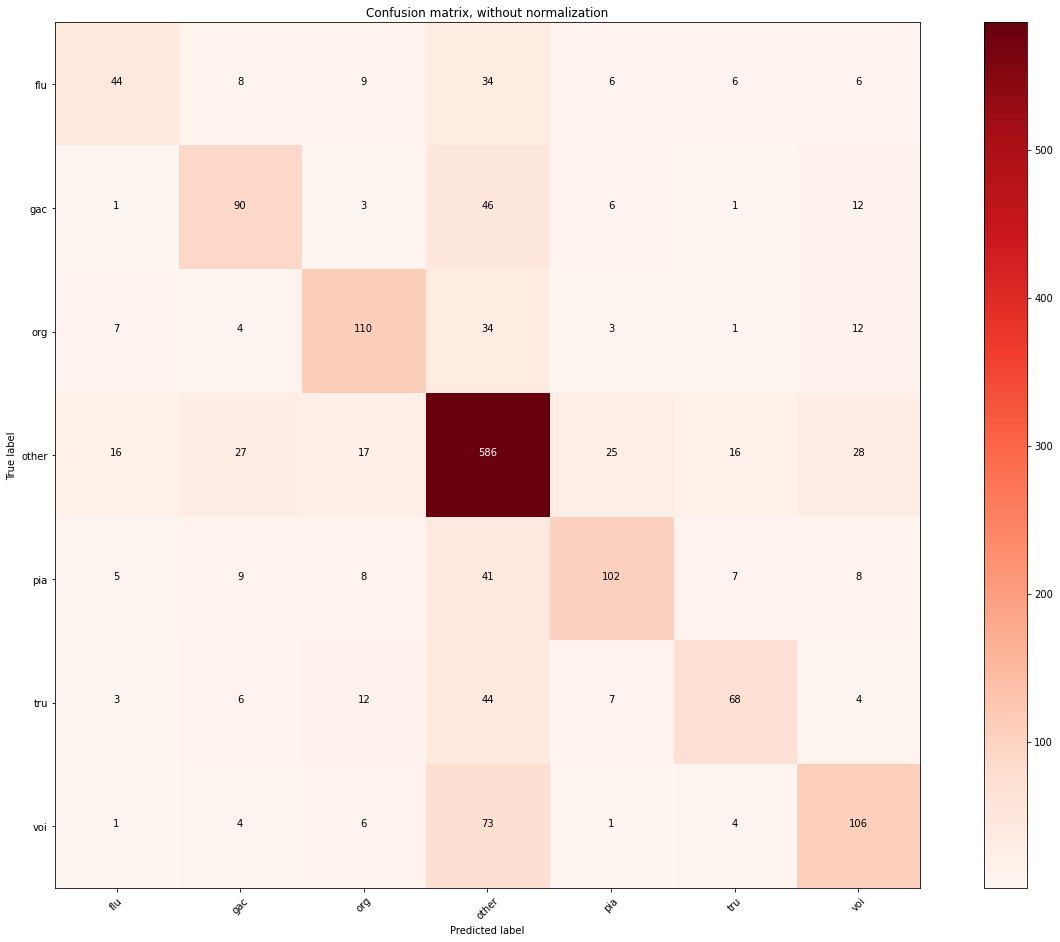

In [132]:
# Plotting non-normalized confusion matrix
%matplotlib inline
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')
plt.savefig("Charts.pdf")

In [133]:
# Finding wrongly predicted samples
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]

In [134]:
# Find wrong predicted audio files
print("True labels")
print(np.array(labels)[test_index[wrong_predictions]])
print("Predicted labels")
print(labelencoder.inverse_transform(predicted_labels[wrong_predictions]))

True labels
['tru' 'pia' 'org' 'gac' 'flu' 'tru' 'voi' 'other' 'pia' 'org' 'other'
 'gac' 'other' 'gac' 'voi' 'flu' 'flu' 'voi' 'org' 'tru' 'org' 'tru'
 'other' 'other' 'org' 'voi' 'voi' 'tru' 'pia' 'other' 'flu' 'other'
 'other' 'tru' 'tru' 'org' 'voi' 'voi' 'other' 'other' 'pia' 'tru' 'voi'
 'voi' 'voi' 'flu' 'gac' 'voi' 'flu' 'voi' 'other' 'flu' 'gac' 'voi' 'pia'
 'org' 'org' 'other' 'other' 'other' 'org' 'gac' 'other' 'pia' 'gac' 'flu'
 'gac' 'org' 'flu' 'voi' 'voi' 'gac' 'tru' 'voi' 'voi' 'pia' 'flu' 'other'
 'gac' 'other' 'gac' 'other' 'pia' 'other' 'pia' 'other' 'other' 'pia'
 'voi' 'pia' 'tru' 'gac' 'pia' 'tru' 'pia' 'org' 'flu' 'voi' 'flu' 'voi'
 'tru' 'other' 'voi' 'pia' 'flu' 'pia' 'gac' 'tru' 'other' 'tru' 'tru'
 'flu' 'other' 'flu' 'other' 'flu' 'gac' 'other' 'other' 'gac' 'org' 'voi'
 'other' 'tru' 'other' 'org' 'other' 'other' 'pia' 'gac' 'other' 'voi'
 'tru' 'tru' 'other' 'other' 'other' 'other' 'voi' 'org' 'voi' 'voi' 'gac'
 'gac' 'org' 'other' 'voi' 'voi' 'other' 'voi